
### <center> Food Demand Forecasting Challenge</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
df_train=pd.read_csv("train.csv")
df_meal=pd.read_csv("meal_info.csv")
df_ffc=pd.read_csv("fulfilment_center_info.csv")
df_test=pd.read_csv("test_QoiMO9B.csv")

In [3]:
df_train = pd.merge(df_train, df_ffc, on='center_id')
df_test = pd.merge(df_test, df_ffc, on='center_id')

df_train = pd.merge(df_train, df_meal, on='meal_id')
df_test = pd.merge(df_test, df_meal, on='meal_id')

In [4]:
df_train['train/test'] = 'train'
df_test['train/test'] = 'test'

In [5]:
df = df_train.append(df_test).reset_index(drop=True)[df_train.columns]
df = df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Visualization

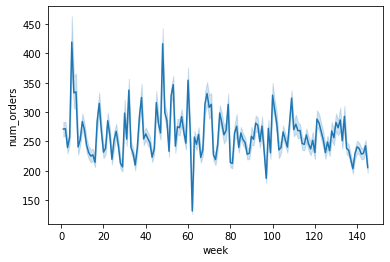

In [79]:
sn.lineplot(df_train['week'],df_train['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

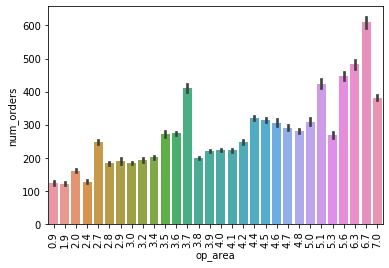

In [80]:
sn.barplot(df_train['op_area'],df_train['num_orders'])
plt.xticks(rotation = '90')

(array([400., 450., 500., 550., 600., 650., 700., 750.]),
 <a list of 8 Text xticklabel objects>)

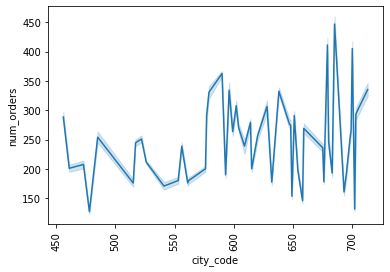

In [81]:
sn.lineplot(df_train['city_code'],df_train['num_orders'])
plt.xticks(rotation = '90')

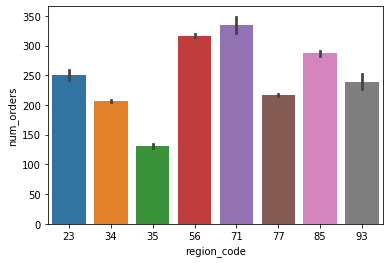

In [82]:
sn.barplot(df_train['region_code'],df_train['num_orders'])

### Outliers

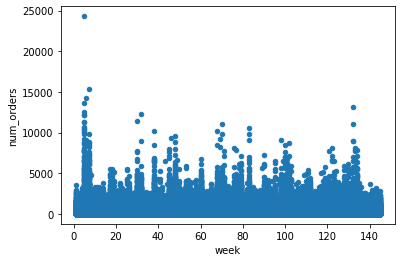

In [235]:
df.plot.scatter(x='week', y='num_orders')

In [6]:
df.drop(df[df['num_orders'] >20000].index, inplace = True) 

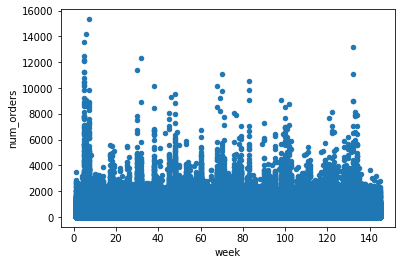

In [237]:
df.plot.scatter(x='week', y='num_orders')

In [302]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train/test
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,56,TYPE_B,6.3,Beverages,Italian,train
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,56,TYPE_B,6.3,Beverages,Italian,train
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,56,TYPE_B,6.3,Beverages,Italian,train
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,56,TYPE_B,6.3,Beverages,Italian,train
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,56,TYPE_B,6.3,Beverages,Italian,train


In [7]:
df['profit']=df['checkout_price']-df['base_price']
df['pricediff']=df['base_price']-df['checkout_price']
df['profit/loss'] = (df['profit'] > 0).astype(int)
df['price_last_curr_diff'] = (df['checkout_price'].shift(1) - df['checkout_price']).fillna(1)/ df['checkout_price'].shift(1).fillna(1)
df['price_last_curr_diff'] = df['price_last_curr_diff'].fillna(0)
df['price_increase'] = (df['price_last_curr_diff'] < 0).astype(int)

In [8]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,center_type,op_area,category,cuisine,train/test,profit,pricediff,profit/loss,price_last_curr_diff,price_increase
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,...,TYPE_B,6.3,Beverages,Italian,train,0.0,0.0,0,1.000000,0
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,...,TYPE_B,6.3,Beverages,Italian,train,1.0,-1.0,1,-0.010861,1
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,...,TYPE_B,6.3,Beverages,Italian,train,2.0,-2.0,1,-0.005454,1
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,...,TYPE_B,6.3,Beverages,Italian,train,-1.0,1.0,0,0.010848,0
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,...,TYPE_B,6.3,Beverages,Italian,train,2.0,-2.0,1,-0.005648,1


In [9]:
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

In [10]:
df = create_sales_lag_feats(df, gpby_cols=['center_id','meal_id'], target_col='pricediff', lags=[10,11,12])
df = create_sales_lag_feats(df, gpby_cols=['center_id','meal_id'], target_col='checkout_price', lags=[10,11,12])

In [11]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,pricediff,profit/loss,price_last_curr_diff,price_increase,pricediff_lag_10,pricediff_lag_11,pricediff_lag_12,checkout_price_lag_10,checkout_price_lag_11,checkout_price_lag_12
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,...,0.0,0,1.000000,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,...,-1.0,1,-0.010861,1,NaN,NaN,NaN,NaN,NaN,NaN
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,...,-2.0,1,-0.005454,1,NaN,NaN,NaN,NaN,NaN,NaN
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,...,1.0,0,0.010848,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,...,-2.0,1,-0.005648,1,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.isna().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders               32573
city_code                    0
region_code                  0
center_type                  0
op_area                      0
category                     0
cuisine                      0
train/test                   0
profit                       0
pricediff                    0
profit/loss                  0
price_last_curr_diff         0
price_increase               0
pricediff_lag_10         35877
pricediff_lag_11         39449
pricediff_lag_12         43020
checkout_price_lag_10    35877
checkout_price_lag_11    39449
checkout_price_lag_12    43020
dtype: int64

In [13]:
df_train = df.loc[df['train/test']=='train', :]
df_test = df.loc[df['train/test']=='test', :]

In [14]:
df_train['city_region'] = \
        df_train['city_code'].astype('str') + '_' + \
        df_train['region_code'].astype('str')

df_test['city_region'] = \
        df_test['city_code'].astype('str') + '_' + \
        df_test['region_code'].astype('str')

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:

df_train['week_sin'] = \
        np.sin(2 * np.pi * df_train['week'] / 52.143)
df_train['week_cos'] = \
        np.cos(2 * np.pi * df_train['week'] / 52.143)

df_test['week_sin'] = \
        np.sin(2 * np.pi * df_test['week'] / 52.143)
df_test['week_cos'] = \
        np.cos(2 * np.pi * df_test['week'] / 52.143)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [16]:
df_train['num_orders_log1p'] = np.log1p(df_train['num_orders'])


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
df = df_train.append(df_test).reset_index(drop=True)[df_train.columns]
df = df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [18]:
df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'train/test', 'profit', 'pricediff', 'profit/loss',
       'price_last_curr_diff', 'price_increase', 'pricediff_lag_10',
       'pricediff_lag_11', 'pricediff_lag_12', 'checkout_price_lag_10',
       'checkout_price_lag_11', 'checkout_price_lag_12', 'city_region',
       'week_sin', 'week_cos', 'num_orders_log1p'],
      dtype='object')

In [19]:
df['price_last_curr_diff']=df['price_last_curr_diff'].fillna(df['price_last_curr_diff'].mean())
df['pricediff_lag_10']=df['pricediff_lag_10'].fillna(0)
df['pricediff_lag_11']=df['pricediff_lag_11'].fillna(0)
df['pricediff_lag_12']=df['pricediff_lag_12'].fillna(0)
df['checkout_price_lag_10']=df['checkout_price_lag_10'].fillna(0)
df['checkout_price_lag_11']=df['checkout_price_lag_11'].fillna(0)
df['checkout_price_lag_12']=df['checkout_price_lag_12'].fillna(0)

### Pre-processing

In [20]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()
le4=LabelEncoder()
le5=LabelEncoder()
le6=LabelEncoder()
le7=LabelEncoder()
le8=LabelEncoder()
se1=StandardScaler()
se2=StandardScaler()
se3=StandardScaler()
se4=StandardScaler()
se5=StandardScaler()
se6=StandardScaler()
se7=StandardScaler()
fitter=StandardScaler()
df['category'] = le1.fit_transform(df['category'])
df['cuisine'] = le2.fit_transform(df['cuisine'])
df['center_type'] = le3.fit_transform(df['center_type'])
df['center_id'] = le4.fit_transform(df['center_id'])
df['meal_id'] = le5.fit_transform(df['meal_id'])
df['city_region']=le6.fit_transform(df['city_region'])
df['price_increase']=le7.fit_transform(df['price_increase'])
df['profit/loss']=le8.fit_transform(df['profit/loss'])
df['profit'] = se1.fit_transform(df[['profit']])
df['checkout_price'] = se2.fit_transform(df[['checkout_price']])
df['base_price'] = se3.fit_transform(df[['base_price']])
df['op_area'] = se4.fit_transform(df[['op_area']])
df['price_last_curr_diff'] = se5.fit_transform(df[['price_last_curr_diff']])
df['pricediff_lag_10'] = se5.fit_transform(df[['pricediff_lag_10']])
df['pricediff_lag_11'] = se5.fit_transform(df[['pricediff_lag_11']])
df['pricediff_lag_12'] = se5.fit_transform(df[['pricediff_lag_12']])
df['checkout_price_lag_10'] = se5.fit_transform(df[['checkout_price_lag_10']])
df['checkout_price_lag_11'] = se5.fit_transform(df[['checkout_price_lag_11']])
df['checkout_price_lag_12'] = se5.fit_transform(df[['checkout_price_lag_12']])
df['week'] = fitter.fit_transform(df[['week']])

In [355]:
df.dtypes

id                         int64
week                     float64
center_id                  int64
meal_id                    int64
checkout_price           float64
base_price               float64
emailer_for_promotion      int64
homepage_featured          int64
num_orders               float64
city_code                  int64
region_code                int64
center_type                int64
op_area                  float64
category                   int64
cuisine                    int64
train/test                object
profit                   float64
pricediff                float64
profit/loss                int64
price_last_curr_diff     float64
price_increase             int64
pricediff_lag_10         float64
pricediff_lag_11         float64
pricediff_lag_12         float64
checkout_price_lag_10    float64
checkout_price_lag_11    float64
checkout_price_lag_12    float64
city_region                int64
week_sin                 float64
week_cos                 float64
num_orders

In [185]:
#One hot encoding
one_hot = pd.get_dummies(df['emailer_for_promotion'],prefix='emailer_for_promotion_')
df = df.drop('emailer_for_promotion',axis = 1)
df = df.join(one_hot)
efp=list(one_hot.columns)
efp=efp[:-1]

one_hot = pd.get_dummies(df['homepage_featured'],prefix='homepage_featured_')
df = df.drop('homepage_featured',axis = 1)
df = df.join(one_hot)
hf=list(one_hot.columns)
hf=hf[:-1]

one_hot = pd.get_dummies(df['category'],prefix='category_')
df = df.drop('category',axis = 1)
df = df.join(one_hot)
c=list(one_hot.columns)
c=c[:-1]

one_hot = pd.get_dummies(df['cuisine'],prefix='cuisine_')
df = df.drop('cuisine',axis = 1)
df = df.join(one_hot)
cu=list(one_hot.columns)
cu=cu[:-1]

one_hot = pd.get_dummies(df['center_type'],prefix='center_type_')
df = df.drop('center_type',axis = 1)
df = df.join(one_hot)
ct=list(one_hot.columns)
ct=ct[:-1]

one_hot = pd.get_dummies(df['price_increase'],prefix='price_increase_')
df = df.drop('price_increase',axis = 1)
df = df.join(one_hot)
pi=list(one_hot.columns)
pi=pi[:-1]

one_hot = pd.get_dummies(df['profit/loss'],prefix='profit/loss_')
df = df.drop('profit/loss',axis = 1)
df = df.join(one_hot)
pl=list(one_hot.columns)
pl=pl[:-1]

one_hot = pd.get_dummies(df['city_region'],prefix='city_region_')
df = df.drop('city_region',axis = 1)
df = df.join(one_hot)
cr=list(one_hot.columns)
cr=cr[:-1]


In [186]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,num_orders,city_code,region_code,op_area,...,city_region__41,city_region__42,city_region__43,city_region__44,city_region__45,city_region__46,city_region__47,city_region__48,city_region__49,city_region__50
0,1436842,-1.777291,0,0,-0.989987,-1.078391,865.0,590,56,2.029128,...,0,0,0,0,0,0,0,0,0,0
1,1205013,-1.754740,0,0,-0.977113,-1.072342,782.0,590,56,2.029128,...,0,0,0,0,0,0,0,0,0,0
2,1447751,-1.732188,0,0,-0.970578,-1.072342,851.0,590,56,2.029128,...,0,0,0,0,0,0,0,0,0,0
3,1014968,-1.709637,0,0,-0.983648,-1.066106,1202.0,590,56,2.029128,...,0,0,0,0,0,0,0,0,0,0
4,1003563,-1.687086,0,0,-0.976917,-1.078391,958.0,590,56,2.029128,...,0,0,0,0,0,0,0,0,0,0


### Pre-processing2

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 20 18:08:22 2019

@author: sanjana
"""

import pandas as pd
import numpy as np
from sklearn import preprocessing
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split



df_train = pd.read_csv('train.csv')
df_center_info = pd.read_csv('fulfilment_center_info.csv')
df_meal_info = pd.read_csv('meal_info.csv')
df_test = pd.read_csv('test_QoiMO9B.csv')



df_train = pd.merge(df_train, df_center_info,
                    how="left",
                    left_on='center_id',
                    right_on='center_id')

df_train = pd.merge(df_train, df_meal_info,
                    how='left',
                    left_on='meal_id',
                    right_on='meal_id')



df_test = pd.merge(df_test, df_center_info,
                   how="left",
                   left_on='center_id',
                   right_on='center_id')

df_test = pd.merge(df_test, df_meal_info,
                   how='left',
                   left_on='meal_id',
                   right_on='meal_id')



df_train['city_region'] = \
        df_train['city_code'].astype('str') + '_' + \
        df_train['region_code'].astype('str')

df_test['city_region'] = \
        df_test['city_code'].astype('str') + '_' + \
        df_test['region_code'].astype('str')


"""def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

df_train = create_sales_lag_feats(df, gpby_cols=['center_id','meal_id'], target_col='num_orders', lags=[10,11,12])"""



label_encode_columns = ['center_id', 
                        'meal_id', 
                        'city_code', 
                        'region_code', 
                        'city_region', 
                        'center_type', 
                        'category', 
                        'cuisine']

le = preprocessing.LabelEncoder()

for col in label_encode_columns:
    le.fit(df_train[col])
    df_train[col + '_encoded'] = le.transform(df_train[col])
    df_test[col + '_encoded'] = le.transform(df_test[col])



df_train['week_sin'] = \
        np.sin(2 * np.pi * df_train['week'] / 52.143)
df_train['week_cos'] = \
        np.cos(2 * np.pi * df_train['week'] / 52.143)

df_test['week_sin'] = \
        np.sin(2 * np.pi * df_test['week'] / 52.143)
df_test['week_cos'] = \
        np.cos(2 * np.pi * df_test['week'] / 52.143)



df_train['price_diff_percent'] = \
        (df_train['base_price'] - df_train['checkout_price']) / \
        df_train['base_price']

df_test['price_diff_percent'] = \
        (df_test['base_price'] - df_test['checkout_price']) / \
        df_test['base_price']



df_train['email_plus_homepage'] = \
        df_train['emailer_for_promotion'] + \
        df_train['homepage_featured']

df_test['email_plus_homepage'] = \
        df_test['emailer_for_promotion'] + \
        df_test['homepage_featured']


columns_to_train = ['week',
                    'week_sin',
                    'week_cos',
                    'checkout_price',
                    'base_price',
                    'price_diff_percent',
                    'email_plus_homepage',
                    'city_region_encoded',
                    'center_type_encoded',
                    'op_area',
                    'category_encoded',
                    'cuisine_encoded',
                    'center_id_encoded',
                    'meal_id_encoded']

categorical_columns = ['email_plus_homepage',
                       'city_region_encoded',
                       'center_type_encoded',
                       'category_encoded',
                       'cuisine_encoded',
                       'center_id_encoded',
                       'meal_id_encoded']

numerical_columns = [col for col in columns_to_train if col not in categorical_columns]


df_train['num_orders_log1p'] = np.log1p(df_train['num_orders'])


X = df_train[categorical_columns + numerical_columns]
y = df_train['num_orders_log1p']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.02, 
                                                    shuffle=False)







In [6]:
#PCA
#Normal PCA pls remove it 
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train= pca.fit_transform(X_train)
X_test= pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

[9.28019149e-01 3.19650561e-02 2.20835247e-02 9.67475965e-03
 4.20775536e-03 3.65234068e-03 3.32468745e-04 2.37577699e-05
 1.10649131e-05 9.77244087e-06 8.98825041e-06 8.09977945e-06
 3.21807024e-06 4.43964695e-08]


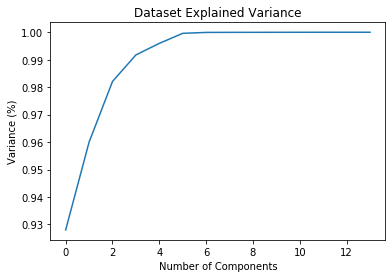

In [5]:
print(explained_variance)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [14]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 5)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

ValueError: Unknown label type: (array([5.18178355, 5.60211882, 5.24702407, ..., 3.33220451, 3.98898405,
       4.24849524]),)

In [21]:
df_train = df.loc[df['train/test']=='train', :]
df_test = df.loc[df['train/test']=='test', :]

In [319]:
df_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,profit/loss,price_last_curr_diff,price_increase,pricediff_lag_10,pricediff_lag_11,pricediff_lag_12,city_region,week_sin,week_cos,num_orders_log1p
0,1436842,-1.777291,0,0,-0.989987,-1.078391,0,0,865.0,590,...,0,4.614483,0,-0.431482,-0.430068,-0.428581,17,0.120208,0.992749,6.763885
1,1205013,-1.754740,0,0,-0.977113,-1.072342,0,0,782.0,590,...,1,-0.003888,1,-0.431482,-0.430068,-0.428581,17,0.238672,0.971100,6.663133
2,1447751,-1.732188,0,0,-0.970578,-1.072342,0,0,851.0,590,...,1,0.020815,1,-0.431482,-0.430068,-0.428581,17,0.353675,0.935368,6.747587
3,1014968,-1.709637,0,0,-0.983648,-1.066106,0,0,1202.0,590,...,0,0.095295,0,-0.431482,-0.430068,-0.428581,17,0.463549,0.886071,7.092574
4,1003563,-1.687086,0,0,-0.976917,-1.078391,0,0,958.0,590,...,1,0.019926,1,-0.431482,-0.430068,-0.428581,17,0.566700,0.823924,6.865891


In [22]:
xfeat=['meal_id','center_id','week','week_sin','week_cos','profit','op_area','checkout_price','price_last_curr_diff','pricediff_lag_10','pricediff_lag_11','pricediff_lag_12']
cat=['emailer_for_promotion','homepage_featured','category','cuisine','center_type','price_increase','profit/loss','city_region']
#xfeat=xfeat+efp+hf+c+cu+ct+pi+pl+cr
xfeat=xfeat+cat
X=df_train[xfeat]
y=df_train['num_orders_log1p']


In [23]:
df_train.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
train/test               0
profit                   0
pricediff                0
profit/loss              0
price_last_curr_diff     0
price_increase           0
pricediff_lag_10         0
pricediff_lag_11         0
pricediff_lag_12         0
checkout_price_lag_10    0
checkout_price_lag_11    0
checkout_price_lag_12    0
city_region              0
week_sin                 0
week_cos                 0
num_orders_log1p         0
dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.02, 
                                                    shuffle=False)

### RandonmForest 

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0,verbose=2,n_jobs=-1,min_samples_leaf=5,max_depth=20,min_samples_split=16,oob_score=True)
regressor.fit(X_train,y_train)
ypred=regressor.predict(X_test)
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(ypred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10building tree 2 of 10building tree 3 of 10

building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.5s finished


Accuracy: 41.5340114712235


//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


###  Catboost with our features included

In [27]:
xfeat=['meal_id','center_id','week','week_sin','week_cos','profit','op_area','checkout_price','price_last_curr_diff','pricediff_lag_10','pricediff_lag_11','pricediff_lag_12','checkout_price_lag_10','checkout_price_lag_11','checkout_price_lag_12']
cat=['emailer_for_promotion','homepage_featured','category','cuisine','center_type','price_increase','profit/loss','city_region']
xfeat=xfeat+cat
X=df_train[xfeat]
y=df_train['num_orders_log1p']


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.02, 
                                                    shuffle=False)

In [29]:
import catboost as cb
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)

In [30]:
cat_rg1.fit(X_train, y_train, cat_features=cat, verbose=True)

0:	learn: 1.1590550	total: 312ms	remaining: 3m 14s
1:	learn: 1.1169784	total: 719ms	remaining: 3m 43s
2:	learn: 1.0783941	total: 1.13s	remaining: 3m 54s
3:	learn: 1.0432081	total: 1.42s	remaining: 3m 40s
4:	learn: 1.0105754	total: 1.62s	remaining: 3m 21s
5:	learn: 0.9806645	total: 1.81s	remaining: 3m 6s
6:	learn: 0.9534413	total: 2.04s	remaining: 2m 59s
7:	learn: 0.9280231	total: 2.35s	remaining: 3m 1s
8:	learn: 0.9043455	total: 2.5s	remaining: 2m 51s
9:	learn: 0.8825733	total: 2.68s	remaining: 2m 44s
10:	learn: 0.8627708	total: 2.83s	remaining: 2m 37s
11:	learn: 0.8449039	total: 3.04s	remaining: 2m 35s
12:	learn: 0.8282573	total: 3.21s	remaining: 2m 30s
13:	learn: 0.8131313	total: 3.39s	remaining: 2m 27s
14:	learn: 0.7984094	total: 3.55s	remaining: 2m 24s
15:	learn: 0.7850094	total: 3.73s	remaining: 2m 21s
16:	learn: 0.7729847	total: 3.88s	remaining: 2m 18s
17:	learn: 0.7618967	total: 4.07s	remaining: 2m 17s
18:	learn: 0.7521152	total: 4.22s	remaining: 2m 14s
19:	learn: 0.7430360	tota

159:	learn: 0.5485531	total: 35.2s	remaining: 1m 42s
160:	learn: 0.5482456	total: 35.4s	remaining: 1m 42s
161:	learn: 0.5479176	total: 35.6s	remaining: 1m 41s
162:	learn: 0.5476835	total: 35.8s	remaining: 1m 41s
163:	learn: 0.5473305	total: 36.2s	remaining: 1m 41s
164:	learn: 0.5471319	total: 36.5s	remaining: 1m 41s
165:	learn: 0.5468359	total: 36.7s	remaining: 1m 41s
166:	learn: 0.5465856	total: 37s	remaining: 1m 41s
167:	learn: 0.5462272	total: 37.3s	remaining: 1m 41s
168:	learn: 0.5459965	total: 37.7s	remaining: 1m 41s
169:	learn: 0.5456986	total: 38s	remaining: 1m 41s
170:	learn: 0.5455217	total: 38.5s	remaining: 1m 42s
171:	learn: 0.5451429	total: 38.7s	remaining: 1m 42s
172:	learn: 0.5448021	total: 38.9s	remaining: 1m 41s
173:	learn: 0.5445559	total: 39.2s	remaining: 1m 41s
174:	learn: 0.5441726	total: 39.4s	remaining: 1m 41s
175:	learn: 0.5439129	total: 39.6s	remaining: 1m 40s
176:	learn: 0.5436527	total: 39.8s	remaining: 1m 40s
177:	learn: 0.5433659	total: 40s	remaining: 1m 40s

315:	learn: 0.5144179	total: 1m 11s	remaining: 1m 9s
316:	learn: 0.5141633	total: 1m 11s	remaining: 1m 9s
317:	learn: 0.5139900	total: 1m 11s	remaining: 1m 9s
318:	learn: 0.5138221	total: 1m 11s	remaining: 1m 8s
319:	learn: 0.5136987	total: 1m 12s	remaining: 1m 8s
320:	learn: 0.5135438	total: 1m 12s	remaining: 1m 8s
321:	learn: 0.5134247	total: 1m 12s	remaining: 1m 8s
322:	learn: 0.5133307	total: 1m 12s	remaining: 1m 8s
323:	learn: 0.5132179	total: 1m 13s	remaining: 1m 7s
324:	learn: 0.5129811	total: 1m 13s	remaining: 1m 7s
325:	learn: 0.5128414	total: 1m 13s	remaining: 1m 7s
326:	learn: 0.5126926	total: 1m 13s	remaining: 1m 7s
327:	learn: 0.5125568	total: 1m 13s	remaining: 1m 6s
328:	learn: 0.5123730	total: 1m 14s	remaining: 1m 6s
329:	learn: 0.5122531	total: 1m 14s	remaining: 1m 6s
330:	learn: 0.5120985	total: 1m 14s	remaining: 1m 6s
331:	learn: 0.5119787	total: 1m 14s	remaining: 1m 6s
332:	learn: 0.5117929	total: 1m 15s	remaining: 1m 5s
333:	learn: 0.5116022	total: 1m 15s	remaining:

471:	learn: 0.4970575	total: 1m 44s	remaining: 33.9s
472:	learn: 0.4969615	total: 1m 44s	remaining: 33.7s
473:	learn: 0.4969244	total: 1m 45s	remaining: 33.5s
474:	learn: 0.4968614	total: 1m 45s	remaining: 33.3s
475:	learn: 0.4968161	total: 1m 45s	remaining: 33.1s
476:	learn: 0.4967029	total: 1m 45s	remaining: 32.8s
477:	learn: 0.4966350	total: 1m 45s	remaining: 32.6s
478:	learn: 0.4965447	total: 1m 46s	remaining: 32.4s
479:	learn: 0.4964876	total: 1m 46s	remaining: 32.1s
480:	learn: 0.4964228	total: 1m 46s	remaining: 31.9s
481:	learn: 0.4962802	total: 1m 46s	remaining: 31.7s
482:	learn: 0.4962146	total: 1m 47s	remaining: 31.5s
483:	learn: 0.4960886	total: 1m 47s	remaining: 31.3s
484:	learn: 0.4959919	total: 1m 47s	remaining: 31.1s
485:	learn: 0.4959090	total: 1m 47s	remaining: 30.9s
486:	learn: 0.4958830	total: 1m 48s	remaining: 30.6s
487:	learn: 0.4957519	total: 1m 48s	remaining: 30.4s
488:	learn: 0.4957302	total: 1m 48s	remaining: 30.2s
489:	learn: 0.4956389	total: 1m 48s	remaining:

In [31]:
pred = cat_rg1.predict(X_test)
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(pred)))

Accuracy: 32.48252564548408


In [108]:
df_train['city_region']

0         590_56
1         590_56
2         590_56
3         590_56
4         590_56
5         590_56
6         590_56
7         590_56
8         590_56
9         590_56
10        590_56
11        590_56
12        590_56
13        590_56
14        590_56
15        590_56
16        590_56
17        590_56
18        590_56
19        590_56
20        590_56
21        590_56
22        590_56
23        590_56
24        590_56
25        590_56
26        590_56
27        590_56
28        590_56
29        590_56
           ...  
489090    649_34
489091    649_34
489092    649_34
489093    649_34
489094    649_34
489095    649_34
489096    649_34
489097    649_34
489098    649_34
489099    649_34
489100    649_34
489101    649_34
489102    649_34
489103    649_34
489104    649_34
489105    649_34
489106    649_34
489107    649_34
489108    649_34
489109    649_34
489110    649_34
489111    649_34
489112    649_34
489113    649_34
489114    649_34
489115    649_34
489116    649_34
489117    649_

### LightGBM with our features included

In [370]:
from lightgbm import LGBMRegressor

g = {'colsample_bytree': 0.4,
     'min_child_samples': 5,
     'num_leaves': 255}

estimator = LGBMRegressor(learning_rate=0.003,
                          n_estimators=40000,
                          silent=False,
                          **g)

fit_params = {'early_stopping_rounds': 1000,
              'feature_name': xfeat,
              'categorical_feature': cat,
              'eval_set': [(X_train, y_train), (X_test, y_test)]}

estimator.fit(X_train, y_train, **fit_params)


//anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'center_type', 'city_region', 'cuisine', 'emailer_for_promotion', 'homepage_featured', 'price_increase', 'profit/loss']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 1.44476	valid_1's l2: 1.29104
Training until validation scores don't improve for 1000 rounds.
[2]	training's l2: 1.43866	valid_1's l2: 1.28566
[3]	training's l2: 1.43314	valid_1's l2: 1.28021
[4]	training's l2: 1.42774	valid_1's l2: 1.27545
[5]	training's l2: 1.42201	valid_1's l2: 1.27059
[6]	training's l2: 1.41654	valid_1's l2: 1.2657
[7]	training's l2: 1.41086	valid_1's l2: 1.26059
[8]	training's l2: 1.40503	valid_1's l2: 1.25539
[9]	training's l2: 1.40132	valid_1's l2: 1.25222
[10]	training's l2: 1.39572	valid_1's l2: 1.24735
[11]	training's l2: 1.39191	valid_1's l2: 1.24442
[12]	training's l2: 1.39045	valid_1's l2: 1.24328
[13]	training's l2: 1.38518	valid_1's l2: 1.2384
[14]	training's l2: 1.37994	valid_1's l2: 1.23446
[15]	training's l2: 1.37452	valid_1's l2: 1.22966
[16]	training's l2: 1.36933	valid_1's l2: 1.22492
[17]	training's l2: 1.36369	valid_1's l2: 1.22005
[18]	training's l2: 1.35891	valid_1's l2: 1.21547
[19]	training's l2: 1.35331	valid_1's l2: 1.210

[165]	training's l2: 0.845306	valid_1's l2: 0.769719
[166]	training's l2: 0.843351	valid_1's l2: 0.768113
[167]	training's l2: 0.840684	valid_1's l2: 0.765699
[168]	training's l2: 0.838895	valid_1's l2: 0.764075
[169]	training's l2: 0.836534	valid_1's l2: 0.762032
[170]	training's l2: 0.834771	valid_1's l2: 0.760524
[171]	training's l2: 0.832939	valid_1's l2: 0.758949
[172]	training's l2: 0.830279	valid_1's l2: 0.756415
[173]	training's l2: 0.827722	valid_1's l2: 0.754353
[174]	training's l2: 0.824795	valid_1's l2: 0.751914
[175]	training's l2: 0.823316	valid_1's l2: 0.75087
[176]	training's l2: 0.820914	valid_1's l2: 0.748996
[177]	training's l2: 0.818491	valid_1's l2: 0.747157
[178]	training's l2: 0.816323	valid_1's l2: 0.745298
[179]	training's l2: 0.813791	valid_1's l2: 0.743285
[180]	training's l2: 0.811231	valid_1's l2: 0.741099
[181]	training's l2: 0.809628	valid_1's l2: 0.739671
[182]	training's l2: 0.808217	valid_1's l2: 0.738503
[183]	training's l2: 0.806684	valid_1's l2: 0.7

[322]	training's l2: 0.577471	valid_1's l2: 0.547148
[323]	training's l2: 0.576484	valid_1's l2: 0.54619
[324]	training's l2: 0.575274	valid_1's l2: 0.545165
[325]	training's l2: 0.574409	valid_1's l2: 0.544575
[326]	training's l2: 0.573311	valid_1's l2: 0.543883
[327]	training's l2: 0.572333	valid_1's l2: 0.542994
[328]	training's l2: 0.570945	valid_1's l2: 0.542027
[329]	training's l2: 0.570103	valid_1's l2: 0.541366
[330]	training's l2: 0.568991	valid_1's l2: 0.540374
[331]	training's l2: 0.567557	valid_1's l2: 0.539209
[332]	training's l2: 0.566562	valid_1's l2: 0.538618
[333]	training's l2: 0.565165	valid_1's l2: 0.537546
[334]	training's l2: 0.564327	valid_1's l2: 0.536847
[335]	training's l2: 0.563245	valid_1's l2: 0.536019
[336]	training's l2: 0.562572	valid_1's l2: 0.535558
[337]	training's l2: 0.561239	valid_1's l2: 0.534583
[338]	training's l2: 0.560627	valid_1's l2: 0.534216
[339]	training's l2: 0.559791	valid_1's l2: 0.533579
[340]	training's l2: 0.558321	valid_1's l2: 0.5

[480]	training's l2: 0.43693	valid_1's l2: 0.438982
[481]	training's l2: 0.436584	valid_1's l2: 0.438755
[482]	training's l2: 0.43603	valid_1's l2: 0.438401
[483]	training's l2: 0.435166	valid_1's l2: 0.437837
[484]	training's l2: 0.434401	valid_1's l2: 0.437222
[485]	training's l2: 0.433935	valid_1's l2: 0.43695
[486]	training's l2: 0.433241	valid_1's l2: 0.436627
[487]	training's l2: 0.432823	valid_1's l2: 0.436342
[488]	training's l2: 0.432394	valid_1's l2: 0.43609
[489]	training's l2: 0.431952	valid_1's l2: 0.435751
[490]	training's l2: 0.43154	valid_1's l2: 0.435455
[491]	training's l2: 0.431127	valid_1's l2: 0.435115
[492]	training's l2: 0.430447	valid_1's l2: 0.43463
[493]	training's l2: 0.429771	valid_1's l2: 0.434207
[494]	training's l2: 0.429455	valid_1's l2: 0.434018
[495]	training's l2: 0.429	valid_1's l2: 0.433748
[496]	training's l2: 0.428266	valid_1's l2: 0.433236
[497]	training's l2: 0.427554	valid_1's l2: 0.432756
[498]	training's l2: 0.426895	valid_1's l2: 0.432138
[4

[637]	training's l2: 0.361608	valid_1's l2: 0.387268
[638]	training's l2: 0.361348	valid_1's l2: 0.387115
[639]	training's l2: 0.360919	valid_1's l2: 0.386959
[640]	training's l2: 0.360559	valid_1's l2: 0.386751
[641]	training's l2: 0.360038	valid_1's l2: 0.386444
[642]	training's l2: 0.359563	valid_1's l2: 0.386068
[643]	training's l2: 0.359163	valid_1's l2: 0.385778
[644]	training's l2: 0.358754	valid_1's l2: 0.385544
[645]	training's l2: 0.358364	valid_1's l2: 0.385324
[646]	training's l2: 0.358138	valid_1's l2: 0.385234
[647]	training's l2: 0.357693	valid_1's l2: 0.384896
[648]	training's l2: 0.357447	valid_1's l2: 0.384706
[649]	training's l2: 0.357145	valid_1's l2: 0.384575
[650]	training's l2: 0.356661	valid_1's l2: 0.384201
[651]	training's l2: 0.356476	valid_1's l2: 0.384051
[652]	training's l2: 0.356053	valid_1's l2: 0.383785
[653]	training's l2: 0.355641	valid_1's l2: 0.383512
[654]	training's l2: 0.355281	valid_1's l2: 0.383217
[655]	training's l2: 0.354806	valid_1's l2: 0.

[794]	training's l2: 0.316007	valid_1's l2: 0.357711
[795]	training's l2: 0.315758	valid_1's l2: 0.357568
[796]	training's l2: 0.315544	valid_1's l2: 0.357393
[797]	training's l2: 0.315455	valid_1's l2: 0.357345
[798]	training's l2: 0.315173	valid_1's l2: 0.357016
[799]	training's l2: 0.315045	valid_1's l2: 0.356848
[800]	training's l2: 0.314793	valid_1's l2: 0.35664
[801]	training's l2: 0.314523	valid_1's l2: 0.356531
[802]	training's l2: 0.314426	valid_1's l2: 0.35649
[803]	training's l2: 0.314197	valid_1's l2: 0.356381
[804]	training's l2: 0.314042	valid_1's l2: 0.356242
[805]	training's l2: 0.313805	valid_1's l2: 0.356071
[806]	training's l2: 0.313666	valid_1's l2: 0.356026
[807]	training's l2: 0.313476	valid_1's l2: 0.355935
[808]	training's l2: 0.313216	valid_1's l2: 0.355745
[809]	training's l2: 0.31294	valid_1's l2: 0.355615
[810]	training's l2: 0.312648	valid_1's l2: 0.355325
[811]	training's l2: 0.312435	valid_1's l2: 0.355294
[812]	training's l2: 0.312208	valid_1's l2: 0.355

[955]	training's l2: 0.287193	valid_1's l2: 0.33986
[956]	training's l2: 0.287035	valid_1's l2: 0.339774
[957]	training's l2: 0.286818	valid_1's l2: 0.339746
[958]	training's l2: 0.286651	valid_1's l2: 0.3397
[959]	training's l2: 0.286487	valid_1's l2: 0.339523
[960]	training's l2: 0.286392	valid_1's l2: 0.339429
[961]	training's l2: 0.286286	valid_1's l2: 0.33944
[962]	training's l2: 0.286145	valid_1's l2: 0.33935
[963]	training's l2: 0.285983	valid_1's l2: 0.339297
[964]	training's l2: 0.285882	valid_1's l2: 0.339261
[965]	training's l2: 0.285694	valid_1's l2: 0.33922
[966]	training's l2: 0.285538	valid_1's l2: 0.339139
[967]	training's l2: 0.285369	valid_1's l2: 0.338993
[968]	training's l2: 0.285209	valid_1's l2: 0.338873
[969]	training's l2: 0.285123	valid_1's l2: 0.338791
[970]	training's l2: 0.285029	valid_1's l2: 0.338764
[971]	training's l2: 0.284849	valid_1's l2: 0.338566
[972]	training's l2: 0.284758	valid_1's l2: 0.338512
[973]	training's l2: 0.284681	valid_1's l2: 0.338401

[1109]	training's l2: 0.269532	valid_1's l2: 0.329635
[1110]	training's l2: 0.269439	valid_1's l2: 0.329628
[1111]	training's l2: 0.269322	valid_1's l2: 0.3295
[1112]	training's l2: 0.26921	valid_1's l2: 0.32939
[1113]	training's l2: 0.269143	valid_1's l2: 0.329324
[1114]	training's l2: 0.269012	valid_1's l2: 0.329184
[1115]	training's l2: 0.26895	valid_1's l2: 0.329115
[1116]	training's l2: 0.268848	valid_1's l2: 0.32905
[1117]	training's l2: 0.268798	valid_1's l2: 0.328991
[1118]	training's l2: 0.268673	valid_1's l2: 0.329
[1119]	training's l2: 0.268574	valid_1's l2: 0.32896
[1120]	training's l2: 0.268441	valid_1's l2: 0.328935
[1121]	training's l2: 0.268324	valid_1's l2: 0.328931
[1122]	training's l2: 0.268234	valid_1's l2: 0.328897
[1123]	training's l2: 0.268168	valid_1's l2: 0.328834
[1124]	training's l2: 0.268059	valid_1's l2: 0.328752
[1125]	training's l2: 0.267962	valid_1's l2: 0.328767
[1126]	training's l2: 0.2679	valid_1's l2: 0.328767
[1127]	training's l2: 0.267845	valid_1's

[1265]	training's l2: 0.256483	valid_1's l2: 0.323302
[1266]	training's l2: 0.25638	valid_1's l2: 0.323205
[1267]	training's l2: 0.256314	valid_1's l2: 0.323175
[1268]	training's l2: 0.25623	valid_1's l2: 0.323137
[1269]	training's l2: 0.25616	valid_1's l2: 0.323095
[1270]	training's l2: 0.256089	valid_1's l2: 0.323046
[1271]	training's l2: 0.256015	valid_1's l2: 0.323019
[1272]	training's l2: 0.255918	valid_1's l2: 0.322919
[1273]	training's l2: 0.255856	valid_1's l2: 0.32293
[1274]	training's l2: 0.255785	valid_1's l2: 0.322894
[1275]	training's l2: 0.255709	valid_1's l2: 0.322884
[1276]	training's l2: 0.255653	valid_1's l2: 0.322845
[1277]	training's l2: 0.255559	valid_1's l2: 0.322757
[1278]	training's l2: 0.255515	valid_1's l2: 0.322712
[1279]	training's l2: 0.255474	valid_1's l2: 0.322682
[1280]	training's l2: 0.255432	valid_1's l2: 0.322652
[1281]	training's l2: 0.255328	valid_1's l2: 0.322564
[1282]	training's l2: 0.255258	valid_1's l2: 0.322533
[1283]	training's l2: 0.255181	v

[1420]	training's l2: 0.246915	valid_1's l2: 0.31761
[1421]	training's l2: 0.246873	valid_1's l2: 0.31758
[1422]	training's l2: 0.246812	valid_1's l2: 0.317532
[1423]	training's l2: 0.246735	valid_1's l2: 0.317481
[1424]	training's l2: 0.246646	valid_1's l2: 0.317412
[1425]	training's l2: 0.246586	valid_1's l2: 0.31735
[1426]	training's l2: 0.246547	valid_1's l2: 0.31738
[1427]	training's l2: 0.246498	valid_1's l2: 0.317389
[1428]	training's l2: 0.246441	valid_1's l2: 0.317346
[1429]	training's l2: 0.246411	valid_1's l2: 0.317319
[1430]	training's l2: 0.246351	valid_1's l2: 0.317295
[1431]	training's l2: 0.246302	valid_1's l2: 0.317277
[1432]	training's l2: 0.246237	valid_1's l2: 0.317315
[1433]	training's l2: 0.24618	valid_1's l2: 0.31728
[1434]	training's l2: 0.246115	valid_1's l2: 0.317304
[1435]	training's l2: 0.246074	valid_1's l2: 0.317278
[1436]	training's l2: 0.246016	valid_1's l2: 0.3173
[1437]	training's l2: 0.245971	valid_1's l2: 0.317273
[1438]	training's l2: 0.245894	valid

[1575]	training's l2: 0.239079	valid_1's l2: 0.314811
[1576]	training's l2: 0.23902	valid_1's l2: 0.314777
[1577]	training's l2: 0.238994	valid_1's l2: 0.314765
[1578]	training's l2: 0.238946	valid_1's l2: 0.31473
[1579]	training's l2: 0.238901	valid_1's l2: 0.3147
[1580]	training's l2: 0.23887	valid_1's l2: 0.314696
[1581]	training's l2: 0.238821	valid_1's l2: 0.314674
[1582]	training's l2: 0.238778	valid_1's l2: 0.314665
[1583]	training's l2: 0.23871	valid_1's l2: 0.31462
[1584]	training's l2: 0.238658	valid_1's l2: 0.314587
[1585]	training's l2: 0.238628	valid_1's l2: 0.31456
[1586]	training's l2: 0.238579	valid_1's l2: 0.314575
[1587]	training's l2: 0.238539	valid_1's l2: 0.314546
[1588]	training's l2: 0.23849	valid_1's l2: 0.314505
[1589]	training's l2: 0.238438	valid_1's l2: 0.314459
[1590]	training's l2: 0.238401	valid_1's l2: 0.314417
[1591]	training's l2: 0.238358	valid_1's l2: 0.314385
[1592]	training's l2: 0.2383	valid_1's l2: 0.314355
[1593]	training's l2: 0.238272	valid_1'

[1735]	training's l2: 0.232413	valid_1's l2: 0.311029
[1736]	training's l2: 0.232374	valid_1's l2: 0.311015
[1737]	training's l2: 0.232343	valid_1's l2: 0.311004
[1738]	training's l2: 0.232297	valid_1's l2: 0.310969
[1739]	training's l2: 0.232275	valid_1's l2: 0.310952
[1740]	training's l2: 0.232247	valid_1's l2: 0.310934
[1741]	training's l2: 0.232199	valid_1's l2: 0.310896
[1742]	training's l2: 0.232155	valid_1's l2: 0.310864
[1743]	training's l2: 0.232112	valid_1's l2: 0.310827
[1744]	training's l2: 0.232079	valid_1's l2: 0.310805
[1745]	training's l2: 0.232049	valid_1's l2: 0.310787
[1746]	training's l2: 0.232009	valid_1's l2: 0.310745
[1747]	training's l2: 0.231985	valid_1's l2: 0.31073
[1748]	training's l2: 0.231961	valid_1's l2: 0.310702
[1749]	training's l2: 0.231926	valid_1's l2: 0.310683
[1750]	training's l2: 0.23191	valid_1's l2: 0.31067
[1751]	training's l2: 0.231868	valid_1's l2: 0.31064
[1752]	training's l2: 0.231825	valid_1's l2: 0.310598
[1753]	training's l2: 0.23178	va

[1893]	training's l2: 0.226989	valid_1's l2: 0.308248
[1894]	training's l2: 0.226943	valid_1's l2: 0.308221
[1895]	training's l2: 0.226901	valid_1's l2: 0.3082
[1896]	training's l2: 0.22687	valid_1's l2: 0.308146
[1897]	training's l2: 0.226843	valid_1's l2: 0.308138
[1898]	training's l2: 0.226801	valid_1's l2: 0.308096
[1899]	training's l2: 0.226758	valid_1's l2: 0.308065
[1900]	training's l2: 0.22672	valid_1's l2: 0.308047
[1901]	training's l2: 0.226673	valid_1's l2: 0.308013
[1902]	training's l2: 0.226634	valid_1's l2: 0.308071
[1903]	training's l2: 0.226597	valid_1's l2: 0.308066
[1904]	training's l2: 0.226565	valid_1's l2: 0.308056
[1905]	training's l2: 0.226525	valid_1's l2: 0.308045
[1906]	training's l2: 0.226504	valid_1's l2: 0.308031
[1907]	training's l2: 0.226474	valid_1's l2: 0.308018
[1908]	training's l2: 0.226435	valid_1's l2: 0.307996
[1909]	training's l2: 0.226415	valid_1's l2: 0.307971
[1910]	training's l2: 0.226388	valid_1's l2: 0.307963
[1911]	training's l2: 0.226373	v

[2047]	training's l2: 0.222275	valid_1's l2: 0.306006
[2048]	training's l2: 0.222248	valid_1's l2: 0.305989
[2049]	training's l2: 0.222221	valid_1's l2: 0.305982
[2050]	training's l2: 0.222198	valid_1's l2: 0.305965
[2051]	training's l2: 0.222167	valid_1's l2: 0.306
[2052]	training's l2: 0.222135	valid_1's l2: 0.306017
[2053]	training's l2: 0.222119	valid_1's l2: 0.306011
[2054]	training's l2: 0.222106	valid_1's l2: 0.306013
[2055]	training's l2: 0.22209	valid_1's l2: 0.306019
[2056]	training's l2: 0.222061	valid_1's l2: 0.306001
[2057]	training's l2: 0.222018	valid_1's l2: 0.305994
[2058]	training's l2: 0.222001	valid_1's l2: 0.305976
[2059]	training's l2: 0.221979	valid_1's l2: 0.305964
[2060]	training's l2: 0.221943	valid_1's l2: 0.305979
[2061]	training's l2: 0.221921	valid_1's l2: 0.305974
[2062]	training's l2: 0.221895	valid_1's l2: 0.30597
[2063]	training's l2: 0.221877	valid_1's l2: 0.305959
[2064]	training's l2: 0.221844	valid_1's l2: 0.30596
[2065]	training's l2: 0.221819	val

[2207]	training's l2: 0.218143	valid_1's l2: 0.304587
[2208]	training's l2: 0.218114	valid_1's l2: 0.304573
[2209]	training's l2: 0.218089	valid_1's l2: 0.304567
[2210]	training's l2: 0.218071	valid_1's l2: 0.304555
[2211]	training's l2: 0.218049	valid_1's l2: 0.304564
[2212]	training's l2: 0.218008	valid_1's l2: 0.304515
[2213]	training's l2: 0.217977	valid_1's l2: 0.304528
[2214]	training's l2: 0.217951	valid_1's l2: 0.30452
[2215]	training's l2: 0.217924	valid_1's l2: 0.304513
[2216]	training's l2: 0.217902	valid_1's l2: 0.304474
[2217]	training's l2: 0.217867	valid_1's l2: 0.30445
[2218]	training's l2: 0.217833	valid_1's l2: 0.304428
[2219]	training's l2: 0.217809	valid_1's l2: 0.304382
[2220]	training's l2: 0.217776	valid_1's l2: 0.304346
[2221]	training's l2: 0.217742	valid_1's l2: 0.304318
[2222]	training's l2: 0.217717	valid_1's l2: 0.304298
[2223]	training's l2: 0.217686	valid_1's l2: 0.304283
[2224]	training's l2: 0.217663	valid_1's l2: 0.304283
[2225]	training's l2: 0.217627

[2360]	training's l2: 0.2146	valid_1's l2: 0.303159
[2361]	training's l2: 0.214582	valid_1's l2: 0.303143
[2362]	training's l2: 0.214568	valid_1's l2: 0.303137
[2363]	training's l2: 0.214553	valid_1's l2: 0.303129
[2364]	training's l2: 0.214522	valid_1's l2: 0.303125
[2365]	training's l2: 0.214494	valid_1's l2: 0.30311
[2366]	training's l2: 0.214474	valid_1's l2: 0.30311
[2367]	training's l2: 0.214452	valid_1's l2: 0.303102
[2368]	training's l2: 0.214436	valid_1's l2: 0.303107
[2369]	training's l2: 0.21442	valid_1's l2: 0.3031
[2370]	training's l2: 0.214393	valid_1's l2: 0.303078
[2371]	training's l2: 0.214362	valid_1's l2: 0.303064
[2372]	training's l2: 0.214345	valid_1's l2: 0.303055
[2373]	training's l2: 0.214321	valid_1's l2: 0.303099
[2374]	training's l2: 0.214294	valid_1's l2: 0.303092
[2375]	training's l2: 0.214277	valid_1's l2: 0.303082
[2376]	training's l2: 0.214253	valid_1's l2: 0.303063
[2377]	training's l2: 0.214224	valid_1's l2: 0.3031
[2378]	training's l2: 0.214213	valid_

[2517]	training's l2: 0.211398	valid_1's l2: 0.302157
[2518]	training's l2: 0.21138	valid_1's l2: 0.30215
[2519]	training's l2: 0.211362	valid_1's l2: 0.302141
[2520]	training's l2: 0.211346	valid_1's l2: 0.302133
[2521]	training's l2: 0.211328	valid_1's l2: 0.302182
[2522]	training's l2: 0.211313	valid_1's l2: 0.302171
[2523]	training's l2: 0.211291	valid_1's l2: 0.30218
[2524]	training's l2: 0.211274	valid_1's l2: 0.302184
[2525]	training's l2: 0.211252	valid_1's l2: 0.302198
[2526]	training's l2: 0.211225	valid_1's l2: 0.302186
[2527]	training's l2: 0.211199	valid_1's l2: 0.302163
[2528]	training's l2: 0.211179	valid_1's l2: 0.302151
[2529]	training's l2: 0.211164	valid_1's l2: 0.302143
[2530]	training's l2: 0.21115	valid_1's l2: 0.302134
[2531]	training's l2: 0.211122	valid_1's l2: 0.302121
[2532]	training's l2: 0.211104	valid_1's l2: 0.302111
[2533]	training's l2: 0.211083	valid_1's l2: 0.302113
[2534]	training's l2: 0.211062	valid_1's l2: 0.302123
[2535]	training's l2: 0.211043	v

[2673]	training's l2: 0.208487	valid_1's l2: 0.301116
[2674]	training's l2: 0.208466	valid_1's l2: 0.301107
[2675]	training's l2: 0.20845	valid_1's l2: 0.301099
[2676]	training's l2: 0.208427	valid_1's l2: 0.301085
[2677]	training's l2: 0.208409	valid_1's l2: 0.301055
[2678]	training's l2: 0.208392	valid_1's l2: 0.301046
[2679]	training's l2: 0.208375	valid_1's l2: 0.301038
[2680]	training's l2: 0.208361	valid_1's l2: 0.301032
[2681]	training's l2: 0.208339	valid_1's l2: 0.301017
[2682]	training's l2: 0.208328	valid_1's l2: 0.30101
[2683]	training's l2: 0.208312	valid_1's l2: 0.301004
[2684]	training's l2: 0.208299	valid_1's l2: 0.300998
[2685]	training's l2: 0.208288	valid_1's l2: 0.30099
[2686]	training's l2: 0.208264	valid_1's l2: 0.300973
[2687]	training's l2: 0.208241	valid_1's l2: 0.300959
[2688]	training's l2: 0.208228	valid_1's l2: 0.300953
[2689]	training's l2: 0.208213	valid_1's l2: 0.300945
[2690]	training's l2: 0.208202	valid_1's l2: 0.300935
[2691]	training's l2: 0.208183	

[2828]	training's l2: 0.205883	valid_1's l2: 0.300155
[2829]	training's l2: 0.20587	valid_1's l2: 0.300153
[2830]	training's l2: 0.205856	valid_1's l2: 0.300148
[2831]	training's l2: 0.205836	valid_1's l2: 0.300136
[2832]	training's l2: 0.205822	valid_1's l2: 0.300144
[2833]	training's l2: 0.20581	valid_1's l2: 0.300143
[2834]	training's l2: 0.205796	valid_1's l2: 0.300139
[2835]	training's l2: 0.205781	valid_1's l2: 0.30013
[2836]	training's l2: 0.205768	valid_1's l2: 0.300127
[2837]	training's l2: 0.205748	valid_1's l2: 0.300092
[2838]	training's l2: 0.205725	valid_1's l2: 0.300084
[2839]	training's l2: 0.205712	valid_1's l2: 0.300077
[2840]	training's l2: 0.205703	valid_1's l2: 0.300071
[2841]	training's l2: 0.205691	valid_1's l2: 0.300067
[2842]	training's l2: 0.205671	valid_1's l2: 0.300054
[2843]	training's l2: 0.205656	valid_1's l2: 0.300046
[2844]	training's l2: 0.205642	valid_1's l2: 0.30004
[2845]	training's l2: 0.205623	valid_1's l2: 0.300032
[2846]	training's l2: 0.205604	v

[2984]	training's l2: 0.203506	valid_1's l2: 0.299737
[2985]	training's l2: 0.203495	valid_1's l2: 0.29973
[2986]	training's l2: 0.203472	valid_1's l2: 0.299731
[2987]	training's l2: 0.203463	valid_1's l2: 0.299727
[2988]	training's l2: 0.203452	valid_1's l2: 0.299724
[2989]	training's l2: 0.203432	valid_1's l2: 0.299739
[2990]	training's l2: 0.203419	valid_1's l2: 0.299733
[2991]	training's l2: 0.2034	valid_1's l2: 0.299714
[2992]	training's l2: 0.203379	valid_1's l2: 0.299701
[2993]	training's l2: 0.203369	valid_1's l2: 0.299696
[2994]	training's l2: 0.203356	valid_1's l2: 0.299737
[2995]	training's l2: 0.203345	valid_1's l2: 0.29973
[2996]	training's l2: 0.203334	valid_1's l2: 0.299724
[2997]	training's l2: 0.203318	valid_1's l2: 0.29972
[2998]	training's l2: 0.203299	valid_1's l2: 0.299706
[2999]	training's l2: 0.203284	valid_1's l2: 0.299701
[3000]	training's l2: 0.203265	valid_1's l2: 0.299685
[3001]	training's l2: 0.203244	valid_1's l2: 0.299687
[3002]	training's l2: 0.203222	va

[3141]	training's l2: 0.201319	valid_1's l2: 0.299101
[3142]	training's l2: 0.2013	valid_1's l2: 0.299096
[3143]	training's l2: 0.20129	valid_1's l2: 0.299091
[3144]	training's l2: 0.201277	valid_1's l2: 0.299083
[3145]	training's l2: 0.201269	valid_1's l2: 0.299079
[3146]	training's l2: 0.201254	valid_1's l2: 0.299077
[3147]	training's l2: 0.20124	valid_1's l2: 0.299071
[3148]	training's l2: 0.201217	valid_1's l2: 0.299071
[3149]	training's l2: 0.20121	valid_1's l2: 0.299072
[3150]	training's l2: 0.201201	valid_1's l2: 0.299071
[3151]	training's l2: 0.201185	valid_1's l2: 0.299063
[3152]	training's l2: 0.201172	valid_1's l2: 0.299058
[3153]	training's l2: 0.201155	valid_1's l2: 0.299063
[3154]	training's l2: 0.201139	valid_1's l2: 0.299052
[3155]	training's l2: 0.201128	valid_1's l2: 0.299053
[3156]	training's l2: 0.201113	valid_1's l2: 0.299046
[3157]	training's l2: 0.201097	valid_1's l2: 0.299038
[3158]	training's l2: 0.20108	valid_1's l2: 0.299028
[3159]	training's l2: 0.201065	val

[3294]	training's l2: 0.199319	valid_1's l2: 0.298722
[3295]	training's l2: 0.199308	valid_1's l2: 0.298721
[3296]	training's l2: 0.199296	valid_1's l2: 0.298715
[3297]	training's l2: 0.199279	valid_1's l2: 0.298706
[3298]	training's l2: 0.199272	valid_1's l2: 0.298704
[3299]	training's l2: 0.19926	valid_1's l2: 0.298697
[3300]	training's l2: 0.199242	valid_1's l2: 0.298686
[3301]	training's l2: 0.199229	valid_1's l2: 0.298671
[3302]	training's l2: 0.199221	valid_1's l2: 0.298669
[3303]	training's l2: 0.199207	valid_1's l2: 0.298665
[3304]	training's l2: 0.1992	valid_1's l2: 0.298667
[3305]	training's l2: 0.199181	valid_1's l2: 0.298679
[3306]	training's l2: 0.199171	valid_1's l2: 0.298672
[3307]	training's l2: 0.199156	valid_1's l2: 0.29867
[3308]	training's l2: 0.199146	valid_1's l2: 0.298666
[3309]	training's l2: 0.199137	valid_1's l2: 0.298662
[3310]	training's l2: 0.199124	valid_1's l2: 0.298711
[3311]	training's l2: 0.199113	valid_1's l2: 0.298715
[3312]	training's l2: 0.1991	val

[3447]	training's l2: 0.197477	valid_1's l2: 0.298571
[3448]	training's l2: 0.197468	valid_1's l2: 0.298579
[3449]	training's l2: 0.19746	valid_1's l2: 0.298577
[3450]	training's l2: 0.197448	valid_1's l2: 0.298592
[3451]	training's l2: 0.197439	valid_1's l2: 0.298589
[3452]	training's l2: 0.197428	valid_1's l2: 0.298579
[3453]	training's l2: 0.197415	valid_1's l2: 0.298571
[3454]	training's l2: 0.197406	valid_1's l2: 0.298566
[3455]	training's l2: 0.197397	valid_1's l2: 0.298558
[3456]	training's l2: 0.197388	valid_1's l2: 0.298552
[3457]	training's l2: 0.197379	valid_1's l2: 0.298548
[3458]	training's l2: 0.197368	valid_1's l2: 0.29854
[3459]	training's l2: 0.19736	valid_1's l2: 0.298532
[3460]	training's l2: 0.197348	valid_1's l2: 0.298551
[3461]	training's l2: 0.197334	valid_1's l2: 0.298538
[3462]	training's l2: 0.197326	valid_1's l2: 0.298539
[3463]	training's l2: 0.197308	valid_1's l2: 0.298564
[3464]	training's l2: 0.197297	valid_1's l2: 0.298559
[3465]	training's l2: 0.197285	

[3601]	training's l2: 0.195747	valid_1's l2: 0.298317
[3602]	training's l2: 0.195739	valid_1's l2: 0.298315
[3603]	training's l2: 0.195728	valid_1's l2: 0.298309
[3604]	training's l2: 0.195719	valid_1's l2: 0.29831
[3605]	training's l2: 0.19571	valid_1's l2: 0.298306
[3606]	training's l2: 0.195695	valid_1's l2: 0.298329
[3607]	training's l2: 0.195686	valid_1's l2: 0.298327
[3608]	training's l2: 0.195678	valid_1's l2: 0.298327
[3609]	training's l2: 0.195663	valid_1's l2: 0.298328
[3610]	training's l2: 0.195653	valid_1's l2: 0.298319
[3611]	training's l2: 0.195641	valid_1's l2: 0.298309
[3612]	training's l2: 0.19563	valid_1's l2: 0.298303
[3613]	training's l2: 0.195619	valid_1's l2: 0.298303
[3614]	training's l2: 0.19561	valid_1's l2: 0.298307
[3615]	training's l2: 0.195594	valid_1's l2: 0.29832
[3616]	training's l2: 0.195585	valid_1's l2: 0.298312
[3617]	training's l2: 0.19557	valid_1's l2: 0.298335
[3618]	training's l2: 0.195564	valid_1's l2: 0.298333
[3619]	training's l2: 0.195551	val

[3755]	training's l2: 0.194148	valid_1's l2: 0.298154
[3756]	training's l2: 0.194139	valid_1's l2: 0.298154
[3757]	training's l2: 0.194129	valid_1's l2: 0.298153
[3758]	training's l2: 0.194119	valid_1's l2: 0.298151
[3759]	training's l2: 0.194107	valid_1's l2: 0.298147
[3760]	training's l2: 0.194101	valid_1's l2: 0.298141
[3761]	training's l2: 0.194089	valid_1's l2: 0.298153
[3762]	training's l2: 0.194078	valid_1's l2: 0.298154
[3763]	training's l2: 0.194068	valid_1's l2: 0.298147
[3764]	training's l2: 0.194059	valid_1's l2: 0.298157
[3765]	training's l2: 0.194052	valid_1's l2: 0.298157
[3766]	training's l2: 0.194044	valid_1's l2: 0.298142
[3767]	training's l2: 0.194034	valid_1's l2: 0.29814
[3768]	training's l2: 0.194025	valid_1's l2: 0.298138
[3769]	training's l2: 0.194013	valid_1's l2: 0.298134
[3770]	training's l2: 0.194003	valid_1's l2: 0.298133
[3771]	training's l2: 0.193988	valid_1's l2: 0.29813
[3772]	training's l2: 0.193975	valid_1's l2: 0.298133
[3773]	training's l2: 0.193967

[3915]	training's l2: 0.192657	valid_1's l2: 0.297963
[3916]	training's l2: 0.19265	valid_1's l2: 0.297982
[3917]	training's l2: 0.192639	valid_1's l2: 0.297978
[3918]	training's l2: 0.192621	valid_1's l2: 0.297977
[3919]	training's l2: 0.192612	valid_1's l2: 0.297978
[3920]	training's l2: 0.192605	valid_1's l2: 0.297975
[3921]	training's l2: 0.192598	valid_1's l2: 0.297973
[3922]	training's l2: 0.192589	valid_1's l2: 0.297971
[3923]	training's l2: 0.192583	valid_1's l2: 0.297968
[3924]	training's l2: 0.192573	valid_1's l2: 0.29797
[3925]	training's l2: 0.192565	valid_1's l2: 0.297966
[3926]	training's l2: 0.192551	valid_1's l2: 0.297955
[3927]	training's l2: 0.192543	valid_1's l2: 0.297952
[3928]	training's l2: 0.192533	valid_1's l2: 0.297947
[3929]	training's l2: 0.192524	valid_1's l2: 0.297943
[3930]	training's l2: 0.192517	valid_1's l2: 0.297947
[3931]	training's l2: 0.192506	valid_1's l2: 0.297945
[3932]	training's l2: 0.192498	valid_1's l2: 0.297944
[3933]	training's l2: 0.192488

[4074]	training's l2: 0.191274	valid_1's l2: 0.297913
[4075]	training's l2: 0.191267	valid_1's l2: 0.297912
[4076]	training's l2: 0.191261	valid_1's l2: 0.297907
[4077]	training's l2: 0.191255	valid_1's l2: 0.297908
[4078]	training's l2: 0.191244	valid_1's l2: 0.297906
[4079]	training's l2: 0.191237	valid_1's l2: 0.297906
[4080]	training's l2: 0.19123	valid_1's l2: 0.297903
[4081]	training's l2: 0.191222	valid_1's l2: 0.297901
[4082]	training's l2: 0.191215	valid_1's l2: 0.297899
[4083]	training's l2: 0.191208	valid_1's l2: 0.297889
[4084]	training's l2: 0.191201	valid_1's l2: 0.297884
[4085]	training's l2: 0.191192	valid_1's l2: 0.297883
[4086]	training's l2: 0.191185	valid_1's l2: 0.297882
[4087]	training's l2: 0.191178	valid_1's l2: 0.297879
[4088]	training's l2: 0.191171	valid_1's l2: 0.297878
[4089]	training's l2: 0.191166	valid_1's l2: 0.297876
[4090]	training's l2: 0.19116	valid_1's l2: 0.297874
[4091]	training's l2: 0.191153	valid_1's l2: 0.297873
[4092]	training's l2: 0.191146

[4233]	training's l2: 0.189997	valid_1's l2: 0.297679
[4234]	training's l2: 0.18999	valid_1's l2: 0.297682
[4235]	training's l2: 0.189982	valid_1's l2: 0.297679
[4236]	training's l2: 0.189975	valid_1's l2: 0.297679
[4237]	training's l2: 0.189966	valid_1's l2: 0.297677
[4238]	training's l2: 0.18996	valid_1's l2: 0.29767
[4239]	training's l2: 0.189955	valid_1's l2: 0.297671
[4240]	training's l2: 0.189949	valid_1's l2: 0.29767
[4241]	training's l2: 0.189934	valid_1's l2: 0.297668
[4242]	training's l2: 0.189927	valid_1's l2: 0.297658
[4243]	training's l2: 0.189922	valid_1's l2: 0.297657
[4244]	training's l2: 0.189916	valid_1's l2: 0.297656
[4245]	training's l2: 0.18991	valid_1's l2: 0.297654
[4246]	training's l2: 0.189901	valid_1's l2: 0.297665
[4247]	training's l2: 0.189895	valid_1's l2: 0.297664
[4248]	training's l2: 0.189889	valid_1's l2: 0.29766
[4249]	training's l2: 0.189882	valid_1's l2: 0.297657
[4250]	training's l2: 0.189875	valid_1's l2: 0.297665
[4251]	training's l2: 0.189867	val

[4389]	training's l2: 0.188842	valid_1's l2: 0.297594
[4390]	training's l2: 0.188836	valid_1's l2: 0.297591
[4391]	training's l2: 0.188827	valid_1's l2: 0.297574
[4392]	training's l2: 0.188817	valid_1's l2: 0.297581
[4393]	training's l2: 0.188809	valid_1's l2: 0.297583
[4394]	training's l2: 0.188799	valid_1's l2: 0.297592
[4395]	training's l2: 0.188793	valid_1's l2: 0.29759
[4396]	training's l2: 0.188779	valid_1's l2: 0.297611
[4397]	training's l2: 0.188771	valid_1's l2: 0.297607
[4398]	training's l2: 0.188765	valid_1's l2: 0.297606
[4399]	training's l2: 0.188757	valid_1's l2: 0.297605
[4400]	training's l2: 0.188752	valid_1's l2: 0.297604
[4401]	training's l2: 0.188747	valid_1's l2: 0.2976
[4402]	training's l2: 0.188738	valid_1's l2: 0.297595
[4403]	training's l2: 0.188727	valid_1's l2: 0.297594
[4404]	training's l2: 0.188721	valid_1's l2: 0.297594
[4405]	training's l2: 0.188714	valid_1's l2: 0.297595
[4406]	training's l2: 0.188709	valid_1's l2: 0.297594
[4407]	training's l2: 0.188703	

[4542]	training's l2: 0.187716	valid_1's l2: 0.29763
[4543]	training's l2: 0.187711	valid_1's l2: 0.297632
[4544]	training's l2: 0.187704	valid_1's l2: 0.297632
[4545]	training's l2: 0.187698	valid_1's l2: 0.297637
[4546]	training's l2: 0.187691	valid_1's l2: 0.297635
[4547]	training's l2: 0.187686	valid_1's l2: 0.297636
[4548]	training's l2: 0.18768	valid_1's l2: 0.297638
[4549]	training's l2: 0.18767	valid_1's l2: 0.297634
[4550]	training's l2: 0.187664	valid_1's l2: 0.297631
[4551]	training's l2: 0.187657	valid_1's l2: 0.297635
[4552]	training's l2: 0.187652	valid_1's l2: 0.297633
[4553]	training's l2: 0.187643	valid_1's l2: 0.297659
[4554]	training's l2: 0.187637	valid_1's l2: 0.297654
[4555]	training's l2: 0.18763	valid_1's l2: 0.297646
[4556]	training's l2: 0.187623	valid_1's l2: 0.297643
[4557]	training's l2: 0.187619	valid_1's l2: 0.297643
[4558]	training's l2: 0.18761	valid_1's l2: 0.297641
[4559]	training's l2: 0.187604	valid_1's l2: 0.297638
[4560]	training's l2: 0.187599	va

[4701]	training's l2: 0.186647	valid_1's l2: 0.297666
[4702]	training's l2: 0.186642	valid_1's l2: 0.297665
[4703]	training's l2: 0.186637	valid_1's l2: 0.297664
[4704]	training's l2: 0.186632	valid_1's l2: 0.297663
[4705]	training's l2: 0.186628	valid_1's l2: 0.297665
[4706]	training's l2: 0.186621	valid_1's l2: 0.297665
[4707]	training's l2: 0.186615	valid_1's l2: 0.297665
[4708]	training's l2: 0.18661	valid_1's l2: 0.297672
[4709]	training's l2: 0.186605	valid_1's l2: 0.297668
[4710]	training's l2: 0.1866	valid_1's l2: 0.297668
[4711]	training's l2: 0.186592	valid_1's l2: 0.297662
[4712]	training's l2: 0.186587	valid_1's l2: 0.297663
[4713]	training's l2: 0.18658	valid_1's l2: 0.297661
[4714]	training's l2: 0.186573	valid_1's l2: 0.297656
[4715]	training's l2: 0.186566	valid_1's l2: 0.297653
[4716]	training's l2: 0.186556	valid_1's l2: 0.297651
[4717]	training's l2: 0.186549	valid_1's l2: 0.297649
[4718]	training's l2: 0.186541	valid_1's l2: 0.297656
[4719]	training's l2: 0.186535	v

[4862]	training's l2: 0.185641	valid_1's l2: 0.297687
[4863]	training's l2: 0.185634	valid_1's l2: 0.297684
[4864]	training's l2: 0.185628	valid_1's l2: 0.297696
[4865]	training's l2: 0.185622	valid_1's l2: 0.297695
[4866]	training's l2: 0.185614	valid_1's l2: 0.297692
[4867]	training's l2: 0.185609	valid_1's l2: 0.297691
[4868]	training's l2: 0.185605	valid_1's l2: 0.297688
[4869]	training's l2: 0.185598	valid_1's l2: 0.297693
[4870]	training's l2: 0.185592	valid_1's l2: 0.297692
[4871]	training's l2: 0.185588	valid_1's l2: 0.297691
[4872]	training's l2: 0.185583	valid_1's l2: 0.297695
[4873]	training's l2: 0.185579	valid_1's l2: 0.297695
[4874]	training's l2: 0.185574	valid_1's l2: 0.297694
[4875]	training's l2: 0.18557	valid_1's l2: 0.297696
[4876]	training's l2: 0.185561	valid_1's l2: 0.297692
[4877]	training's l2: 0.185553	valid_1's l2: 0.29769
[4878]	training's l2: 0.185547	valid_1's l2: 0.297687
[4879]	training's l2: 0.185542	valid_1's l2: 0.297692
[4880]	training's l2: 0.185537

[5023]	training's l2: 0.184656	valid_1's l2: 0.297652
[5024]	training's l2: 0.184651	valid_1's l2: 0.297651
[5025]	training's l2: 0.184644	valid_1's l2: 0.297647
[5026]	training's l2: 0.184637	valid_1's l2: 0.297644
[5027]	training's l2: 0.184632	valid_1's l2: 0.297641
[5028]	training's l2: 0.184627	valid_1's l2: 0.29764
[5029]	training's l2: 0.184623	valid_1's l2: 0.297641
[5030]	training's l2: 0.184614	valid_1's l2: 0.29765
[5031]	training's l2: 0.18461	valid_1's l2: 0.297649
[5032]	training's l2: 0.184604	valid_1's l2: 0.297646
[5033]	training's l2: 0.184598	valid_1's l2: 0.297642
[5034]	training's l2: 0.184593	valid_1's l2: 0.297641
[5035]	training's l2: 0.184584	valid_1's l2: 0.297657
[5036]	training's l2: 0.184579	valid_1's l2: 0.297659
[5037]	training's l2: 0.184573	valid_1's l2: 0.297656
[5038]	training's l2: 0.184569	valid_1's l2: 0.297657
[5039]	training's l2: 0.184561	valid_1's l2: 0.29767
[5040]	training's l2: 0.184556	valid_1's l2: 0.297669
[5041]	training's l2: 0.184552	v

[5180]	training's l2: 0.183705	valid_1's l2: 0.297607
[5181]	training's l2: 0.183698	valid_1's l2: 0.297607
[5182]	training's l2: 0.183693	valid_1's l2: 0.297608
[5183]	training's l2: 0.183688	valid_1's l2: 0.297604
[5184]	training's l2: 0.183682	valid_1's l2: 0.297601
[5185]	training's l2: 0.183677	valid_1's l2: 0.297601
[5186]	training's l2: 0.183672	valid_1's l2: 0.297602
[5187]	training's l2: 0.183668	valid_1's l2: 0.297601
[5188]	training's l2: 0.183663	valid_1's l2: 0.297602
[5189]	training's l2: 0.183659	valid_1's l2: 0.2976
[5190]	training's l2: 0.183652	valid_1's l2: 0.297601
[5191]	training's l2: 0.183642	valid_1's l2: 0.297592
[5192]	training's l2: 0.183638	valid_1's l2: 0.297591
[5193]	training's l2: 0.183633	valid_1's l2: 0.297592
[5194]	training's l2: 0.183629	valid_1's l2: 0.297593
[5195]	training's l2: 0.183621	valid_1's l2: 0.297596
[5196]	training's l2: 0.183615	valid_1's l2: 0.297596
[5197]	training's l2: 0.18361	valid_1's l2: 0.297594
[5198]	training's l2: 0.183604	

[5339]	training's l2: 0.182774	valid_1's l2: 0.297519
[5340]	training's l2: 0.18277	valid_1's l2: 0.297522
[5341]	training's l2: 0.182762	valid_1's l2: 0.297521
[5342]	training's l2: 0.182757	valid_1's l2: 0.297527
[5343]	training's l2: 0.182752	valid_1's l2: 0.297527
[5344]	training's l2: 0.182748	valid_1's l2: 0.297511
[5345]	training's l2: 0.18274	valid_1's l2: 0.297531
[5346]	training's l2: 0.182732	valid_1's l2: 0.297527
[5347]	training's l2: 0.182727	valid_1's l2: 0.297528
[5348]	training's l2: 0.18272	valid_1's l2: 0.297523
[5349]	training's l2: 0.182714	valid_1's l2: 0.297524
[5350]	training's l2: 0.182709	valid_1's l2: 0.297525
[5351]	training's l2: 0.182704	valid_1's l2: 0.297525
[5352]	training's l2: 0.182697	valid_1's l2: 0.29752
[5353]	training's l2: 0.182687	valid_1's l2: 0.29754
[5354]	training's l2: 0.182682	valid_1's l2: 0.297539
[5355]	training's l2: 0.182678	valid_1's l2: 0.297539
[5356]	training's l2: 0.182671	valid_1's l2: 0.297538
[5357]	training's l2: 0.182664	va

[5495]	training's l2: 0.181884	valid_1's l2: 0.297489
[5496]	training's l2: 0.181878	valid_1's l2: 0.297486
[5497]	training's l2: 0.181874	valid_1's l2: 0.297494
[5498]	training's l2: 0.181867	valid_1's l2: 0.297493
[5499]	training's l2: 0.181863	valid_1's l2: 0.297492
[5500]	training's l2: 0.181859	valid_1's l2: 0.297493
[5501]	training's l2: 0.181857	valid_1's l2: 0.297493
[5502]	training's l2: 0.181851	valid_1's l2: 0.297491
[5503]	training's l2: 0.181843	valid_1's l2: 0.297485
[5504]	training's l2: 0.18184	valid_1's l2: 0.297485
[5505]	training's l2: 0.181831	valid_1's l2: 0.297486
[5506]	training's l2: 0.181827	valid_1's l2: 0.297487
[5507]	training's l2: 0.181818	valid_1's l2: 0.297502
[5508]	training's l2: 0.181814	valid_1's l2: 0.297502
[5509]	training's l2: 0.18181	valid_1's l2: 0.297503
[5510]	training's l2: 0.181805	valid_1's l2: 0.297504
[5511]	training's l2: 0.181799	valid_1's l2: 0.2975
[5512]	training's l2: 0.181794	valid_1's l2: 0.297501
[5513]	training's l2: 0.18179	va

[5651]	training's l2: 0.181005	valid_1's l2: 0.297489
[5652]	training's l2: 0.180997	valid_1's l2: 0.297485
[5653]	training's l2: 0.18099	valid_1's l2: 0.297482
[5654]	training's l2: 0.180986	valid_1's l2: 0.29748
[5655]	training's l2: 0.180981	valid_1's l2: 0.297479
[5656]	training's l2: 0.180971	valid_1's l2: 0.297484
[5657]	training's l2: 0.180966	valid_1's l2: 0.297481
[5658]	training's l2: 0.18096	valid_1's l2: 0.29748
[5659]	training's l2: 0.180952	valid_1's l2: 0.297488
[5660]	training's l2: 0.180947	valid_1's l2: 0.297486
[5661]	training's l2: 0.180941	valid_1's l2: 0.297479
[5662]	training's l2: 0.180934	valid_1's l2: 0.29748
[5663]	training's l2: 0.180929	valid_1's l2: 0.297478
[5664]	training's l2: 0.180925	valid_1's l2: 0.297477
[5665]	training's l2: 0.180921	valid_1's l2: 0.297478
[5666]	training's l2: 0.180915	valid_1's l2: 0.297474
[5667]	training's l2: 0.18091	valid_1's l2: 0.297475
[5668]	training's l2: 0.180904	valid_1's l2: 0.297474
[5669]	training's l2: 0.180899	val

[5808]	training's l2: 0.180148	valid_1's l2: 0.297499
[5809]	training's l2: 0.180143	valid_1's l2: 0.297496
[5810]	training's l2: 0.180137	valid_1's l2: 0.297495
[5811]	training's l2: 0.18013	valid_1's l2: 0.297493
[5812]	training's l2: 0.180126	valid_1's l2: 0.297492
[5813]	training's l2: 0.180121	valid_1's l2: 0.297492
[5814]	training's l2: 0.180115	valid_1's l2: 0.297496
[5815]	training's l2: 0.180111	valid_1's l2: 0.297496
[5816]	training's l2: 0.180105	valid_1's l2: 0.297493
[5817]	training's l2: 0.180101	valid_1's l2: 0.297493
[5818]	training's l2: 0.180096	valid_1's l2: 0.297493
[5819]	training's l2: 0.180089	valid_1's l2: 0.297492
[5820]	training's l2: 0.180083	valid_1's l2: 0.297493
[5821]	training's l2: 0.180078	valid_1's l2: 0.297493
[5822]	training's l2: 0.180074	valid_1's l2: 0.297494
[5823]	training's l2: 0.180069	valid_1's l2: 0.297495
[5824]	training's l2: 0.180063	valid_1's l2: 0.297495
[5825]	training's l2: 0.180059	valid_1's l2: 0.297495
[5826]	training's l2: 0.18005

[5973]	training's l2: 0.179288	valid_1's l2: 0.297425
[5974]	training's l2: 0.179284	valid_1's l2: 0.297425
[5975]	training's l2: 0.179279	valid_1's l2: 0.297424
[5976]	training's l2: 0.179274	valid_1's l2: 0.297424
[5977]	training's l2: 0.17927	valid_1's l2: 0.297423
[5978]	training's l2: 0.179266	valid_1's l2: 0.29742
[5979]	training's l2: 0.179261	valid_1's l2: 0.29742
[5980]	training's l2: 0.179255	valid_1's l2: 0.29742
[5981]	training's l2: 0.179249	valid_1's l2: 0.297421
[5982]	training's l2: 0.179244	valid_1's l2: 0.297419
[5983]	training's l2: 0.179239	valid_1's l2: 0.297419
[5984]	training's l2: 0.179234	valid_1's l2: 0.297417
[5985]	training's l2: 0.17923	valid_1's l2: 0.297417
[5986]	training's l2: 0.179222	valid_1's l2: 0.297424
[5987]	training's l2: 0.179219	valid_1's l2: 0.297426
[5988]	training's l2: 0.179211	valid_1's l2: 0.29742
[5989]	training's l2: 0.179205	valid_1's l2: 0.297415
[5990]	training's l2: 0.179201	valid_1's l2: 0.297416
[5991]	training's l2: 0.179196	val

[6132]	training's l2: 0.17846	valid_1's l2: 0.297348
[6133]	training's l2: 0.178455	valid_1's l2: 0.297348
[6134]	training's l2: 0.178451	valid_1's l2: 0.297346
[6135]	training's l2: 0.178445	valid_1's l2: 0.297344
[6136]	training's l2: 0.17844	valid_1's l2: 0.297344
[6137]	training's l2: 0.178435	valid_1's l2: 0.297339
[6138]	training's l2: 0.178424	valid_1's l2: 0.297333
[6139]	training's l2: 0.178418	valid_1's l2: 0.297333
[6140]	training's l2: 0.178409	valid_1's l2: 0.297337
[6141]	training's l2: 0.178405	valid_1's l2: 0.297338
[6142]	training's l2: 0.1784	valid_1's l2: 0.297337
[6143]	training's l2: 0.178396	valid_1's l2: 0.297343
[6144]	training's l2: 0.178393	valid_1's l2: 0.297342
[6145]	training's l2: 0.178388	valid_1's l2: 0.297342
[6146]	training's l2: 0.178383	valid_1's l2: 0.297341
[6147]	training's l2: 0.178377	valid_1's l2: 0.29734
[6148]	training's l2: 0.178374	valid_1's l2: 0.297338
[6149]	training's l2: 0.178369	valid_1's l2: 0.297339
[6150]	training's l2: 0.178366	va

[6285]	training's l2: 0.177688	valid_1's l2: 0.297271
[6286]	training's l2: 0.177685	valid_1's l2: 0.29727
[6287]	training's l2: 0.177674	valid_1's l2: 0.297278
[6288]	training's l2: 0.177669	valid_1's l2: 0.297274
[6289]	training's l2: 0.177665	valid_1's l2: 0.297274
[6290]	training's l2: 0.177661	valid_1's l2: 0.297273
[6291]	training's l2: 0.177655	valid_1's l2: 0.297281
[6292]	training's l2: 0.177649	valid_1's l2: 0.29728
[6293]	training's l2: 0.177644	valid_1's l2: 0.29728
[6294]	training's l2: 0.17764	valid_1's l2: 0.29728
[6295]	training's l2: 0.177632	valid_1's l2: 0.297281
[6296]	training's l2: 0.177627	valid_1's l2: 0.29728
[6297]	training's l2: 0.177624	valid_1's l2: 0.29728
[6298]	training's l2: 0.177621	valid_1's l2: 0.29728
[6299]	training's l2: 0.177616	valid_1's l2: 0.297279
[6300]	training's l2: 0.177611	valid_1's l2: 0.297277
[6301]	training's l2: 0.177605	valid_1's l2: 0.297276
[6302]	training's l2: 0.1776	valid_1's l2: 0.297277
[6303]	training's l2: 0.177597	valid_1

[6450]	training's l2: 0.176862	valid_1's l2: 0.297241
[6451]	training's l2: 0.176855	valid_1's l2: 0.297243
[6452]	training's l2: 0.176849	valid_1's l2: 0.297243
[6453]	training's l2: 0.176845	valid_1's l2: 0.297242
[6454]	training's l2: 0.176841	valid_1's l2: 0.297246
[6455]	training's l2: 0.176837	valid_1's l2: 0.297245
[6456]	training's l2: 0.176826	valid_1's l2: 0.297245
[6457]	training's l2: 0.176823	valid_1's l2: 0.297244
[6458]	training's l2: 0.17682	valid_1's l2: 0.297246
[6459]	training's l2: 0.176815	valid_1's l2: 0.297247
[6460]	training's l2: 0.176809	valid_1's l2: 0.297245
[6461]	training's l2: 0.176802	valid_1's l2: 0.297235
[6462]	training's l2: 0.176798	valid_1's l2: 0.297236
[6463]	training's l2: 0.176791	valid_1's l2: 0.297231
[6464]	training's l2: 0.176787	valid_1's l2: 0.29723
[6465]	training's l2: 0.176782	valid_1's l2: 0.297228
[6466]	training's l2: 0.176776	valid_1's l2: 0.297222
[6467]	training's l2: 0.176773	valid_1's l2: 0.297222
[6468]	training's l2: 0.17677	

[6607]	training's l2: 0.176083	valid_1's l2: 0.297189
[6608]	training's l2: 0.176079	valid_1's l2: 0.297188
[6609]	training's l2: 0.176074	valid_1's l2: 0.29719
[6610]	training's l2: 0.176069	valid_1's l2: 0.297189
[6611]	training's l2: 0.176063	valid_1's l2: 0.297188
[6612]	training's l2: 0.176059	valid_1's l2: 0.297189
[6613]	training's l2: 0.176054	valid_1's l2: 0.297192
[6614]	training's l2: 0.176049	valid_1's l2: 0.29719
[6615]	training's l2: 0.176045	valid_1's l2: 0.29719
[6616]	training's l2: 0.176041	valid_1's l2: 0.297194
[6617]	training's l2: 0.176037	valid_1's l2: 0.297196
[6618]	training's l2: 0.176032	valid_1's l2: 0.297197
[6619]	training's l2: 0.176028	valid_1's l2: 0.297196
[6620]	training's l2: 0.176023	valid_1's l2: 0.297188
[6621]	training's l2: 0.17602	valid_1's l2: 0.297191
[6622]	training's l2: 0.176014	valid_1's l2: 0.297191
[6623]	training's l2: 0.176011	valid_1's l2: 0.29719
[6624]	training's l2: 0.176007	valid_1's l2: 0.29719
[6625]	training's l2: 0.176004	val

[6768]	training's l2: 0.17532	valid_1's l2: 0.297167
[6769]	training's l2: 0.175316	valid_1's l2: 0.297169
[6770]	training's l2: 0.17531	valid_1's l2: 0.297166
[6771]	training's l2: 0.175301	valid_1's l2: 0.297163
[6772]	training's l2: 0.175297	valid_1's l2: 0.297161
[6773]	training's l2: 0.175294	valid_1's l2: 0.297163
[6774]	training's l2: 0.175291	valid_1's l2: 0.297163
[6775]	training's l2: 0.175284	valid_1's l2: 0.297159
[6776]	training's l2: 0.175278	valid_1's l2: 0.297154
[6777]	training's l2: 0.175273	valid_1's l2: 0.297153
[6778]	training's l2: 0.175269	valid_1's l2: 0.297153
[6779]	training's l2: 0.175264	valid_1's l2: 0.297152
[6780]	training's l2: 0.175261	valid_1's l2: 0.297151
[6781]	training's l2: 0.175258	valid_1's l2: 0.297152
[6782]	training's l2: 0.175246	valid_1's l2: 0.297135
[6783]	training's l2: 0.175243	valid_1's l2: 0.297134
[6784]	training's l2: 0.175238	valid_1's l2: 0.297136
[6785]	training's l2: 0.175235	valid_1's l2: 0.297141
[6786]	training's l2: 0.175232

[6931]	training's l2: 0.174523	valid_1's l2: 0.297184
[6932]	training's l2: 0.174518	valid_1's l2: 0.297199
[6933]	training's l2: 0.174515	valid_1's l2: 0.297198
[6934]	training's l2: 0.174508	valid_1's l2: 0.297195
[6935]	training's l2: 0.174505	valid_1's l2: 0.297194
[6936]	training's l2: 0.1745	valid_1's l2: 0.297194
[6937]	training's l2: 0.174491	valid_1's l2: 0.297192
[6938]	training's l2: 0.174488	valid_1's l2: 0.297191
[6939]	training's l2: 0.174484	valid_1's l2: 0.297192
[6940]	training's l2: 0.174478	valid_1's l2: 0.297191
[6941]	training's l2: 0.174474	valid_1's l2: 0.297192
[6942]	training's l2: 0.174469	valid_1's l2: 0.297191
[6943]	training's l2: 0.174465	valid_1's l2: 0.297192
[6944]	training's l2: 0.17446	valid_1's l2: 0.297193
[6945]	training's l2: 0.174452	valid_1's l2: 0.297202
[6946]	training's l2: 0.174449	valid_1's l2: 0.297201
[6947]	training's l2: 0.174446	valid_1's l2: 0.2972
[6948]	training's l2: 0.174443	valid_1's l2: 0.2972
[6949]	training's l2: 0.174438	vali

[7092]	training's l2: 0.173762	valid_1's l2: 0.29711
[7093]	training's l2: 0.173757	valid_1's l2: 0.29711
[7094]	training's l2: 0.173753	valid_1's l2: 0.297109
[7095]	training's l2: 0.173749	valid_1's l2: 0.297107
[7096]	training's l2: 0.173746	valid_1's l2: 0.297108
[7097]	training's l2: 0.17374	valid_1's l2: 0.29711
[7098]	training's l2: 0.173735	valid_1's l2: 0.297109
[7099]	training's l2: 0.17373	valid_1's l2: 0.29711
[7100]	training's l2: 0.173727	valid_1's l2: 0.29711
[7101]	training's l2: 0.173719	valid_1's l2: 0.297112
[7102]	training's l2: 0.173712	valid_1's l2: 0.297102
[7103]	training's l2: 0.173706	valid_1's l2: 0.2971
[7104]	training's l2: 0.173703	valid_1's l2: 0.2971
[7105]	training's l2: 0.173698	valid_1's l2: 0.2971
[7106]	training's l2: 0.173693	valid_1's l2: 0.2971
[7107]	training's l2: 0.17369	valid_1's l2: 0.2971
[7108]	training's l2: 0.173685	valid_1's l2: 0.2971
[7109]	training's l2: 0.173681	valid_1's l2: 0.297099
[7110]	training's l2: 0.173678	valid_1's l2: 0.2

[7245]	training's l2: 0.173061	valid_1's l2: 0.297065
[7246]	training's l2: 0.173057	valid_1's l2: 0.297065
[7247]	training's l2: 0.173052	valid_1's l2: 0.29705
[7248]	training's l2: 0.173048	valid_1's l2: 0.297051
[7249]	training's l2: 0.17304	valid_1's l2: 0.297051
[7250]	training's l2: 0.173037	valid_1's l2: 0.29705
[7251]	training's l2: 0.173032	valid_1's l2: 0.297041
[7252]	training's l2: 0.173028	valid_1's l2: 0.297041
[7253]	training's l2: 0.173022	valid_1's l2: 0.297044
[7254]	training's l2: 0.173018	valid_1's l2: 0.297043
[7255]	training's l2: 0.173013	valid_1's l2: 0.297042
[7256]	training's l2: 0.173009	valid_1's l2: 0.297043
[7257]	training's l2: 0.173003	valid_1's l2: 0.297041
[7258]	training's l2: 0.173	valid_1's l2: 0.297041
[7259]	training's l2: 0.172992	valid_1's l2: 0.29704
[7260]	training's l2: 0.172988	valid_1's l2: 0.29704
[7261]	training's l2: 0.172984	valid_1's l2: 0.297041
[7262]	training's l2: 0.17298	valid_1's l2: 0.29704
[7263]	training's l2: 0.172977	valid_1

[7405]	training's l2: 0.172333	valid_1's l2: 0.296974
[7406]	training's l2: 0.172329	valid_1's l2: 0.296973
[7407]	training's l2: 0.172325	valid_1's l2: 0.296971
[7408]	training's l2: 0.172319	valid_1's l2: 0.296968
[7409]	training's l2: 0.172317	valid_1's l2: 0.296967
[7410]	training's l2: 0.172312	valid_1's l2: 0.296967
[7411]	training's l2: 0.172304	valid_1's l2: 0.296971
[7412]	training's l2: 0.172301	valid_1's l2: 0.296972
[7413]	training's l2: 0.172294	valid_1's l2: 0.296968
[7414]	training's l2: 0.172284	valid_1's l2: 0.296963
[7415]	training's l2: 0.172279	valid_1's l2: 0.296963
[7416]	training's l2: 0.172274	valid_1's l2: 0.296964
[7417]	training's l2: 0.172271	valid_1's l2: 0.296964
[7418]	training's l2: 0.172268	valid_1's l2: 0.296964
[7419]	training's l2: 0.172265	valid_1's l2: 0.296963
[7420]	training's l2: 0.172261	valid_1's l2: 0.296965
[7421]	training's l2: 0.172256	valid_1's l2: 0.29695
[7422]	training's l2: 0.172253	valid_1's l2: 0.29695
[7423]	training's l2: 0.172248

[7567]	training's l2: 0.171604	valid_1's l2: 0.296908
[7568]	training's l2: 0.171598	valid_1's l2: 0.296906
[7569]	training's l2: 0.171594	valid_1's l2: 0.296903
[7570]	training's l2: 0.171587	valid_1's l2: 0.296898
[7571]	training's l2: 0.171584	valid_1's l2: 0.296899
[7572]	training's l2: 0.171581	valid_1's l2: 0.296898
[7573]	training's l2: 0.171576	valid_1's l2: 0.296899
[7574]	training's l2: 0.171573	valid_1's l2: 0.296899
[7575]	training's l2: 0.17157	valid_1's l2: 0.296899
[7576]	training's l2: 0.171566	valid_1's l2: 0.2969
[7577]	training's l2: 0.171562	valid_1's l2: 0.296898
[7578]	training's l2: 0.171558	valid_1's l2: 0.296897
[7579]	training's l2: 0.171554	valid_1's l2: 0.296895
[7580]	training's l2: 0.17155	valid_1's l2: 0.296896
[7581]	training's l2: 0.171544	valid_1's l2: 0.2969
[7582]	training's l2: 0.171539	valid_1's l2: 0.296899
[7583]	training's l2: 0.171536	valid_1's l2: 0.2969
[7584]	training's l2: 0.171532	valid_1's l2: 0.2969
[7585]	training's l2: 0.171529	valid_1

[7731]	training's l2: 0.170832	valid_1's l2: 0.296895
[7732]	training's l2: 0.170827	valid_1's l2: 0.296896
[7733]	training's l2: 0.170821	valid_1's l2: 0.296896
[7734]	training's l2: 0.170818	valid_1's l2: 0.296897
[7735]	training's l2: 0.170812	valid_1's l2: 0.296893
[7736]	training's l2: 0.170807	valid_1's l2: 0.296894
[7737]	training's l2: 0.170799	valid_1's l2: 0.296889
[7738]	training's l2: 0.170795	valid_1's l2: 0.296905
[7739]	training's l2: 0.170789	valid_1's l2: 0.296903
[7740]	training's l2: 0.170784	valid_1's l2: 0.296904
[7741]	training's l2: 0.170782	valid_1's l2: 0.296904
[7742]	training's l2: 0.170779	valid_1's l2: 0.296904
[7743]	training's l2: 0.170774	valid_1's l2: 0.296902
[7744]	training's l2: 0.170767	valid_1's l2: 0.296905
[7745]	training's l2: 0.170761	valid_1's l2: 0.296904
[7746]	training's l2: 0.170752	valid_1's l2: 0.296904
[7747]	training's l2: 0.170747	valid_1's l2: 0.296903
[7748]	training's l2: 0.170741	valid_1's l2: 0.296902
[7749]	training's l2: 0.1707

[7887]	training's l2: 0.170111	valid_1's l2: 0.29697
[7888]	training's l2: 0.170106	valid_1's l2: 0.296969
[7889]	training's l2: 0.170101	valid_1's l2: 0.29697
[7890]	training's l2: 0.170098	valid_1's l2: 0.29697
[7891]	training's l2: 0.170095	valid_1's l2: 0.29697
[7892]	training's l2: 0.170093	valid_1's l2: 0.296971
[7893]	training's l2: 0.170089	valid_1's l2: 0.296971
[7894]	training's l2: 0.170081	valid_1's l2: 0.296957
[7895]	training's l2: 0.170076	valid_1's l2: 0.296957
[7896]	training's l2: 0.170072	valid_1's l2: 0.296957
[7897]	training's l2: 0.170068	valid_1's l2: 0.296957
[7898]	training's l2: 0.170063	valid_1's l2: 0.296956
[7899]	training's l2: 0.17006	valid_1's l2: 0.296957
[7900]	training's l2: 0.170053	valid_1's l2: 0.296954
[7901]	training's l2: 0.170048	valid_1's l2: 0.296955
[7902]	training's l2: 0.170044	valid_1's l2: 0.296953
[7903]	training's l2: 0.170039	valid_1's l2: 0.296952
[7904]	training's l2: 0.170036	valid_1's l2: 0.296952
[7905]	training's l2: 0.17003	val

[8049]	training's l2: 0.169411	valid_1's l2: 0.29697
[8050]	training's l2: 0.169407	valid_1's l2: 0.296971
[8051]	training's l2: 0.169403	valid_1's l2: 0.296973
[8052]	training's l2: 0.169401	valid_1's l2: 0.296973
[8053]	training's l2: 0.169396	valid_1's l2: 0.296973
[8054]	training's l2: 0.169394	valid_1's l2: 0.296973
[8055]	training's l2: 0.169391	valid_1's l2: 0.296973
[8056]	training's l2: 0.169387	valid_1's l2: 0.296975
[8057]	training's l2: 0.169382	valid_1's l2: 0.296975
[8058]	training's l2: 0.169379	valid_1's l2: 0.296975
[8059]	training's l2: 0.169375	valid_1's l2: 0.296973
[8060]	training's l2: 0.169369	valid_1's l2: 0.296973
[8061]	training's l2: 0.169365	valid_1's l2: 0.296973
[8062]	training's l2: 0.169361	valid_1's l2: 0.296972
[8063]	training's l2: 0.169356	valid_1's l2: 0.296972
[8064]	training's l2: 0.169353	valid_1's l2: 0.296971
[8065]	training's l2: 0.169351	valid_1's l2: 0.296971
[8066]	training's l2: 0.169346	valid_1's l2: 0.296972
[8067]	training's l2: 0.16934

[8214]	training's l2: 0.168701	valid_1's l2: 0.29691
[8215]	training's l2: 0.168697	valid_1's l2: 0.29691
[8216]	training's l2: 0.168693	valid_1's l2: 0.29691
[8217]	training's l2: 0.168689	valid_1's l2: 0.29691
[8218]	training's l2: 0.168685	valid_1's l2: 0.29691
[8219]	training's l2: 0.168682	valid_1's l2: 0.29691
[8220]	training's l2: 0.168678	valid_1's l2: 0.296905
[8221]	training's l2: 0.168672	valid_1's l2: 0.296903
[8222]	training's l2: 0.168667	valid_1's l2: 0.296902
[8223]	training's l2: 0.168663	valid_1's l2: 0.2969
[8224]	training's l2: 0.168658	valid_1's l2: 0.2969
[8225]	training's l2: 0.168653	valid_1's l2: 0.296898
[8226]	training's l2: 0.168648	valid_1's l2: 0.296898
[8227]	training's l2: 0.168643	valid_1's l2: 0.296901
[8228]	training's l2: 0.16864	valid_1's l2: 0.296901
[8229]	training's l2: 0.168634	valid_1's l2: 0.296907
[8230]	training's l2: 0.16863	valid_1's l2: 0.296906
[8231]	training's l2: 0.168626	valid_1's l2: 0.296904
[8232]	training's l2: 0.168623	valid_1's

[8372]	training's l2: 0.16801	valid_1's l2: 0.29684
[8373]	training's l2: 0.168007	valid_1's l2: 0.296838
[8374]	training's l2: 0.168003	valid_1's l2: 0.296838
[8375]	training's l2: 0.167993	valid_1's l2: 0.296841
[8376]	training's l2: 0.16799	valid_1's l2: 0.296841
[8377]	training's l2: 0.167986	valid_1's l2: 0.296837
[8378]	training's l2: 0.167983	valid_1's l2: 0.296837
[8379]	training's l2: 0.16798	valid_1's l2: 0.296837
[8380]	training's l2: 0.167975	valid_1's l2: 0.296839
[8381]	training's l2: 0.167972	valid_1's l2: 0.296838
[8382]	training's l2: 0.167969	valid_1's l2: 0.296837
[8383]	training's l2: 0.167966	valid_1's l2: 0.296837
[8384]	training's l2: 0.167964	valid_1's l2: 0.296837
[8385]	training's l2: 0.167959	valid_1's l2: 0.296834
[8386]	training's l2: 0.167954	valid_1's l2: 0.29683
[8387]	training's l2: 0.167949	valid_1's l2: 0.296831
[8388]	training's l2: 0.167944	valid_1's l2: 0.29683
[8389]	training's l2: 0.16794	valid_1's l2: 0.296831
[8390]	training's l2: 0.167936	vali

[8530]	training's l2: 0.167326	valid_1's l2: 0.29679
[8531]	training's l2: 0.167323	valid_1's l2: 0.296789
[8532]	training's l2: 0.167318	valid_1's l2: 0.296789
[8533]	training's l2: 0.167315	valid_1's l2: 0.296787
[8534]	training's l2: 0.167311	valid_1's l2: 0.296784
[8535]	training's l2: 0.167307	valid_1's l2: 0.296785
[8536]	training's l2: 0.167302	valid_1's l2: 0.296785
[8537]	training's l2: 0.167296	valid_1's l2: 0.296788
[8538]	training's l2: 0.167294	valid_1's l2: 0.29679
[8539]	training's l2: 0.16729	valid_1's l2: 0.296788
[8540]	training's l2: 0.167285	valid_1's l2: 0.296786
[8541]	training's l2: 0.16728	valid_1's l2: 0.296787
[8542]	training's l2: 0.167276	valid_1's l2: 0.296788
[8543]	training's l2: 0.167271	valid_1's l2: 0.296785
[8544]	training's l2: 0.167268	valid_1's l2: 0.296786
[8545]	training's l2: 0.167261	valid_1's l2: 0.296782
[8546]	training's l2: 0.167257	valid_1's l2: 0.296781
[8547]	training's l2: 0.167254	valid_1's l2: 0.296782
[8548]	training's l2: 0.16725	va

[8687]	training's l2: 0.166654	valid_1's l2: 0.296734
[8688]	training's l2: 0.16665	valid_1's l2: 0.296734
[8689]	training's l2: 0.166646	valid_1's l2: 0.296732
[8690]	training's l2: 0.166641	valid_1's l2: 0.296733
[8691]	training's l2: 0.166639	valid_1's l2: 0.296733
[8692]	training's l2: 0.166634	valid_1's l2: 0.296733
[8693]	training's l2: 0.16663	valid_1's l2: 0.296734
[8694]	training's l2: 0.166625	valid_1's l2: 0.296734
[8695]	training's l2: 0.166622	valid_1's l2: 0.296735
[8696]	training's l2: 0.166617	valid_1's l2: 0.296741
[8697]	training's l2: 0.166613	valid_1's l2: 0.296741
[8698]	training's l2: 0.166608	valid_1's l2: 0.296739
[8699]	training's l2: 0.166602	valid_1's l2: 0.296737
[8700]	training's l2: 0.166597	valid_1's l2: 0.296731
[8701]	training's l2: 0.166595	valid_1's l2: 0.29673
[8702]	training's l2: 0.166585	valid_1's l2: 0.296734
[8703]	training's l2: 0.16658	valid_1's l2: 0.296738
[8704]	training's l2: 0.166575	valid_1's l2: 0.296737
[8705]	training's l2: 0.166571	v

[8844]	training's l2: 0.166001	valid_1's l2: 0.296745
[8845]	training's l2: 0.165997	valid_1's l2: 0.296745
[8846]	training's l2: 0.165992	valid_1's l2: 0.296743
[8847]	training's l2: 0.165989	valid_1's l2: 0.296744
[8848]	training's l2: 0.165985	valid_1's l2: 0.296742
[8849]	training's l2: 0.165982	valid_1's l2: 0.296742
[8850]	training's l2: 0.165974	valid_1's l2: 0.296738
[8851]	training's l2: 0.165971	valid_1's l2: 0.296738
[8852]	training's l2: 0.165966	valid_1's l2: 0.296734
[8853]	training's l2: 0.16596	valid_1's l2: 0.296735
[8854]	training's l2: 0.165957	valid_1's l2: 0.296736
[8855]	training's l2: 0.165952	valid_1's l2: 0.296736
[8856]	training's l2: 0.165949	valid_1's l2: 0.296761
[8857]	training's l2: 0.165944	valid_1's l2: 0.296761
[8858]	training's l2: 0.16594	valid_1's l2: 0.296762
[8859]	training's l2: 0.165936	valid_1's l2: 0.296761
[8860]	training's l2: 0.165932	valid_1's l2: 0.29676
[8861]	training's l2: 0.165926	valid_1's l2: 0.296758
[8862]	training's l2: 0.165919	

[9006]	training's l2: 0.165295	valid_1's l2: 0.296803
[9007]	training's l2: 0.165288	valid_1's l2: 0.296804
[9008]	training's l2: 0.165285	valid_1's l2: 0.296805
[9009]	training's l2: 0.165282	valid_1's l2: 0.296808
[9010]	training's l2: 0.165278	valid_1's l2: 0.296806
[9011]	training's l2: 0.165276	valid_1's l2: 0.296806
[9012]	training's l2: 0.165273	valid_1's l2: 0.296806
[9013]	training's l2: 0.16527	valid_1's l2: 0.296806
[9014]	training's l2: 0.165266	valid_1's l2: 0.296805
[9015]	training's l2: 0.165262	valid_1's l2: 0.296805
[9016]	training's l2: 0.165258	valid_1's l2: 0.296805
[9017]	training's l2: 0.165253	valid_1's l2: 0.296809
[9018]	training's l2: 0.16525	valid_1's l2: 0.296804
[9019]	training's l2: 0.165244	valid_1's l2: 0.296804
[9020]	training's l2: 0.165239	valid_1's l2: 0.296803
[9021]	training's l2: 0.165236	valid_1's l2: 0.296804
[9022]	training's l2: 0.165232	valid_1's l2: 0.296806
[9023]	training's l2: 0.165228	valid_1's l2: 0.296805
[9024]	training's l2: 0.165224

[9164]	training's l2: 0.164641	valid_1's l2: 0.296836
[9165]	training's l2: 0.164637	valid_1's l2: 0.296841
[9166]	training's l2: 0.164633	valid_1's l2: 0.29684
[9167]	training's l2: 0.16463	valid_1's l2: 0.29684
[9168]	training's l2: 0.164625	valid_1's l2: 0.296841
[9169]	training's l2: 0.164621	valid_1's l2: 0.296839
[9170]	training's l2: 0.164618	valid_1's l2: 0.296836
[9171]	training's l2: 0.164614	valid_1's l2: 0.296835
[9172]	training's l2: 0.164611	valid_1's l2: 0.296835
[9173]	training's l2: 0.164608	valid_1's l2: 0.296841
[9174]	training's l2: 0.164603	valid_1's l2: 0.296841
[9175]	training's l2: 0.1646	valid_1's l2: 0.296843
[9176]	training's l2: 0.164596	valid_1's l2: 0.296843
[9177]	training's l2: 0.164592	valid_1's l2: 0.296843
[9178]	training's l2: 0.164588	valid_1's l2: 0.296842
[9179]	training's l2: 0.164585	valid_1's l2: 0.296839
[9180]	training's l2: 0.16458	valid_1's l2: 0.296842
[9181]	training's l2: 0.164576	valid_1's l2: 0.296841
[9182]	training's l2: 0.164574	val

[9318]	training's l2: 0.164024	valid_1's l2: 0.29691
[9319]	training's l2: 0.16402	valid_1's l2: 0.29691
[9320]	training's l2: 0.164016	valid_1's l2: 0.296907
[9321]	training's l2: 0.164013	valid_1's l2: 0.296906
[9322]	training's l2: 0.164009	valid_1's l2: 0.296907
[9323]	training's l2: 0.164004	valid_1's l2: 0.296898
[9324]	training's l2: 0.164	valid_1's l2: 0.296898
[9325]	training's l2: 0.163994	valid_1's l2: 0.296896
[9326]	training's l2: 0.163989	valid_1's l2: 0.296895
[9327]	training's l2: 0.163984	valid_1's l2: 0.296895
[9328]	training's l2: 0.16398	valid_1's l2: 0.296893
[9329]	training's l2: 0.163978	valid_1's l2: 0.296894
[9330]	training's l2: 0.163974	valid_1's l2: 0.296895
[9331]	training's l2: 0.163969	valid_1's l2: 0.296894
[9332]	training's l2: 0.163966	valid_1's l2: 0.296894
[9333]	training's l2: 0.163963	valid_1's l2: 0.296896
[9334]	training's l2: 0.163959	valid_1's l2: 0.296895
[9335]	training's l2: 0.163953	valid_1's l2: 0.296901
[9336]	training's l2: 0.163949	vali

[9472]	training's l2: 0.163389	valid_1's l2: 0.296945
[9473]	training's l2: 0.163382	valid_1's l2: 0.296947
[9474]	training's l2: 0.163377	valid_1's l2: 0.296948
[9475]	training's l2: 0.163373	valid_1's l2: 0.296947
[9476]	training's l2: 0.163369	valid_1's l2: 0.296947
[9477]	training's l2: 0.163363	valid_1's l2: 0.296954
[9478]	training's l2: 0.163359	valid_1's l2: 0.296954
[9479]	training's l2: 0.163355	valid_1's l2: 0.296953
[9480]	training's l2: 0.16335	valid_1's l2: 0.296921
[9481]	training's l2: 0.163348	valid_1's l2: 0.296921
[9482]	training's l2: 0.163343	valid_1's l2: 0.296918
[9483]	training's l2: 0.163341	valid_1's l2: 0.296918
[9484]	training's l2: 0.163336	valid_1's l2: 0.296919
[9485]	training's l2: 0.163331	valid_1's l2: 0.296921
[9486]	training's l2: 0.163326	valid_1's l2: 0.296921
[9487]	training's l2: 0.163323	valid_1's l2: 0.296923
[9488]	training's l2: 0.163319	valid_1's l2: 0.296921
[9489]	training's l2: 0.163313	valid_1's l2: 0.296925
[9490]	training's l2: 0.16330

[9627]	training's l2: 0.162762	valid_1's l2: 0.296887
[9628]	training's l2: 0.162757	valid_1's l2: 0.296888
[9629]	training's l2: 0.162753	valid_1's l2: 0.296889
[9630]	training's l2: 0.162746	valid_1's l2: 0.296896
[9631]	training's l2: 0.162741	valid_1's l2: 0.296896
[9632]	training's l2: 0.162736	valid_1's l2: 0.296886
[9633]	training's l2: 0.162733	valid_1's l2: 0.296888
[9634]	training's l2: 0.16273	valid_1's l2: 0.296887
[9635]	training's l2: 0.162726	valid_1's l2: 0.296887
[9636]	training's l2: 0.162722	valid_1's l2: 0.296885
[9637]	training's l2: 0.162716	valid_1's l2: 0.296885
[9638]	training's l2: 0.162713	valid_1's l2: 0.296884
[9639]	training's l2: 0.162707	valid_1's l2: 0.296885
[9640]	training's l2: 0.162703	valid_1's l2: 0.296885
[9641]	training's l2: 0.162701	valid_1's l2: 0.296885
[9642]	training's l2: 0.162698	valid_1's l2: 0.296885
[9643]	training's l2: 0.162693	valid_1's l2: 0.296883
[9644]	training's l2: 0.16269	valid_1's l2: 0.296882
[9645]	training's l2: 0.162686

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
              importance_type='split', learning_rate=0.003, max_depth=-1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40000, n_jobs=-1, num_leaves=255, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [371]:
pred = estimator.predict(X_test)
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(pred)))

Accuracy: 30.87864569651626


### XGBoost with our feat

In [222]:
import xgboost as xgb
model = xgb.XGBRegressor(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          n_jobs=-1 , verbosity=2,learning_rate=0.16)
model.fit(X_train,y_train)

[16:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:17] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2396 extra nodes, 0 pruned nodes, max_depth=22
[16:21:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3320 extra nodes, 0 pruned nodes, max_depth=24
[16:21:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4590 extra nodes, 0 pruned nodes, max_depth=24
[16:21:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6794 extra nodes, 0 pruned nodes, max_depth=27
[16:21:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10900 extra nodes, 0 pruned nodes, max_depth=29
[16:21:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18656 extra nodes, 0 pruned nodes, max_depth=31
[16:21:25] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30534 extra nodes, 0 pruned nodes, max_depth=37
[16:21:27] INFO: src/tree/updater_

[16:25:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196128 extra nodes, 0 pruned nodes, max_depth=50
[16:25:36] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184016 extra nodes, 0 pruned nodes, max_depth=50
[16:25:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 165436 extra nodes, 0 pruned nodes, max_depth=50
[16:25:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 155234 extra nodes, 0 pruned nodes, max_depth=50
[16:25:46] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142280 extra nodes, 0 pruned nodes, max_depth=50
[16:25:49] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 129264 extra nodes, 0 pruned nodes, max_depth=50
[16:25:52] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118542 extra nodes, 0 pruned nodes, max_depth=50
[16:25:55] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104064 extra nodes, 0 pruned nodes, max_depth=50
[16:25:58] INFO:

[16:26:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16:26:39] INFO: src/tree/updater_prune.cc:74: tree pruning end,

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.16, max_delta_step=0,
             max_depth=50, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=2)

In [223]:
pred1 = model.predict(X_test)
from sklearn.metrics import mean_squared_log_error
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(pred1)))

Accuracy: 41.39622749819311


###  Catboost

In [28]:
ano = ['id', 'num_orders', 'train/test', 'checkout_price', 'base_price', 'city_code', 'region_code', 'center_type', '']

In [29]:
feat = [col for col in Test.columns if col not in no]
feat

['week',
 'center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'op_area',
 'category',
 'cuisine',
 'profit',
 'profit/loss',
 'price_last_curr_diff',
 'price_increase',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12']

In [32]:
import catboost as cb
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)

In [40]:
cat_rg1.fit(X, y, cat_features=categorical_columns, verbose=True)

0:	learn: 1.1567987	total: 605ms	remaining: 6m 17s
1:	learn: 1.1138547	total: 899ms	remaining: 4m 40s
2:	learn: 1.0743786	total: 1.16s	remaining: 4m
3:	learn: 1.0374316	total: 1.46s	remaining: 3m 46s
4:	learn: 1.0035044	total: 1.65s	remaining: 3m 25s
5:	learn: 0.9720140	total: 1.85s	remaining: 3m 11s
6:	learn: 0.9438021	total: 2.04s	remaining: 3m
7:	learn: 0.9173733	total: 2.35s	remaining: 3m 1s
8:	learn: 0.8927993	total: 2.69s	remaining: 3m 4s
9:	learn: 0.8691784	total: 2.94s	remaining: 3m
10:	learn: 0.8479312	total: 3.21s	remaining: 2m 59s
11:	learn: 0.8280638	total: 3.54s	remaining: 3m
12:	learn: 0.8092710	total: 3.86s	remaining: 3m 1s
13:	learn: 0.7920191	total: 4.25s	remaining: 3m 5s
14:	learn: 0.7760797	total: 4.73s	remaining: 3m 12s
15:	learn: 0.7615597	total: 5s	remaining: 3m 10s
16:	learn: 0.7482135	total: 5.24s	remaining: 3m 7s
17:	learn: 0.7360512	total: 5.49s	remaining: 3m 5s
18:	learn: 0.7250403	total: 5.77s	remaining: 3m 4s
19:	learn: 0.7147239	total: 5.99s	remaining: 3m 

160:	learn: 0.5174609	total: 55.9s	remaining: 2m 41s
161:	learn: 0.5172790	total: 56.3s	remaining: 2m 40s
162:	learn: 0.5170333	total: 56.6s	remaining: 2m 40s
163:	learn: 0.5168228	total: 57s	remaining: 2m 40s
164:	learn: 0.5166906	total: 57.3s	remaining: 2m 39s
165:	learn: 0.5165909	total: 57.7s	remaining: 2m 39s
166:	learn: 0.5164416	total: 57.9s	remaining: 2m 38s
167:	learn: 0.5162374	total: 58.2s	remaining: 2m 38s
168:	learn: 0.5160317	total: 58.5s	remaining: 2m 37s
169:	learn: 0.5158735	total: 58.9s	remaining: 2m 37s
170:	learn: 0.5157353	total: 59.2s	remaining: 2m 37s
171:	learn: 0.5155356	total: 59.5s	remaining: 2m 36s
172:	learn: 0.5153562	total: 59.9s	remaining: 2m 36s
173:	learn: 0.5151591	total: 1m	remaining: 2m 36s
174:	learn: 0.5150336	total: 1m	remaining: 2m 35s
175:	learn: 0.5148642	total: 1m	remaining: 2m 35s
176:	learn: 0.5146987	total: 1m 1s	remaining: 2m 35s
177:	learn: 0.5144885	total: 1m 1s	remaining: 2m 34s
178:	learn: 0.5143024	total: 1m 1s	remaining: 2m 34s
179:

314:	learn: 0.4955388	total: 1m 49s	remaining: 1m 47s
315:	learn: 0.4954533	total: 1m 50s	remaining: 1m 47s
316:	learn: 0.4953221	total: 1m 50s	remaining: 1m 47s
317:	learn: 0.4952354	total: 1m 50s	remaining: 1m 46s
318:	learn: 0.4951218	total: 1m 50s	remaining: 1m 46s
319:	learn: 0.4950631	total: 1m 51s	remaining: 1m 46s
320:	learn: 0.4949697	total: 1m 51s	remaining: 1m 45s
321:	learn: 0.4948717	total: 1m 51s	remaining: 1m 45s
322:	learn: 0.4947347	total: 1m 52s	remaining: 1m 45s
323:	learn: 0.4946499	total: 1m 52s	remaining: 1m 44s
324:	learn: 0.4945347	total: 1m 53s	remaining: 1m 44s
325:	learn: 0.4944119	total: 1m 53s	remaining: 1m 44s
326:	learn: 0.4942587	total: 1m 53s	remaining: 1m 43s
327:	learn: 0.4941935	total: 1m 54s	remaining: 1m 43s
328:	learn: 0.4941112	total: 1m 54s	remaining: 1m 43s
329:	learn: 0.4940493	total: 1m 55s	remaining: 1m 43s
330:	learn: 0.4939670	total: 1m 55s	remaining: 1m 42s
331:	learn: 0.4938880	total: 1m 56s	remaining: 1m 42s
332:	learn: 0.4938321	total:

468:	learn: 0.4841307	total: 2m 42s	remaining: 54s
469:	learn: 0.4840813	total: 2m 42s	remaining: 53.7s
470:	learn: 0.4839647	total: 2m 43s	remaining: 53.3s
471:	learn: 0.4839086	total: 2m 43s	remaining: 53s
472:	learn: 0.4838578	total: 2m 43s	remaining: 52.6s
473:	learn: 0.4838107	total: 2m 44s	remaining: 52.3s
474:	learn: 0.4837615	total: 2m 44s	remaining: 52s
475:	learn: 0.4836946	total: 2m 44s	remaining: 51.6s
476:	learn: 0.4836528	total: 2m 45s	remaining: 51.2s
477:	learn: 0.4836075	total: 2m 45s	remaining: 50.9s
478:	learn: 0.4835716	total: 2m 45s	remaining: 50.5s
479:	learn: 0.4835160	total: 2m 46s	remaining: 50.2s
480:	learn: 0.4834854	total: 2m 46s	remaining: 49.8s
481:	learn: 0.4834208	total: 2m 46s	remaining: 49.4s
482:	learn: 0.4833851	total: 2m 46s	remaining: 49.1s
483:	learn: 0.4833336	total: 2m 47s	remaining: 48.7s
484:	learn: 0.4832447	total: 2m 47s	remaining: 48.3s
485:	learn: 0.4831937	total: 2m 47s	remaining: 48s
486:	learn: 0.4831556	total: 2m 48s	remaining: 47.7s
4

624:	learn: 0.4761921	total: 3m 35s	remaining: 0us


In [23]:
cat_rg1.fit(X=Train[feat], y=Train['num_orders'], cat_features=[1,2,3,4,6,7,9,11], verbose=True)

0:	learn: 380.6832699	total: 312ms	remaining: 3m 14s
1:	learn: 367.8605293	total: 565ms	remaining: 2m 55s
2:	learn: 356.0223549	total: 851ms	remaining: 2m 56s
3:	learn: 345.1884346	total: 1.23s	remaining: 3m 10s
4:	learn: 334.7881383	total: 1.7s	remaining: 3m 31s
5:	learn: 325.6062531	total: 1.88s	remaining: 3m 13s
6:	learn: 317.0114453	total: 2.08s	remaining: 3m 3s
7:	learn: 308.6479946	total: 2.28s	remaining: 2m 56s
8:	learn: 300.9971885	total: 2.49s	remaining: 2m 50s
9:	learn: 293.3417393	total: 2.67s	remaining: 2m 44s
10:	learn: 286.4398747	total: 2.87s	remaining: 2m 40s
11:	learn: 279.9413879	total: 3.03s	remaining: 2m 34s
12:	learn: 274.3003308	total: 3.21s	remaining: 2m 31s
13:	learn: 268.7087345	total: 3.38s	remaining: 2m 27s
14:	learn: 263.5419335	total: 3.58s	remaining: 2m 25s
15:	learn: 258.7473118	total: 3.76s	remaining: 2m 23s
16:	learn: 254.3673131	total: 3.95s	remaining: 2m 21s
17:	learn: 250.3400479	total: 4.12s	remaining: 2m 18s
18:	learn: 246.5112187	total: 4.32s	rema

153:	learn: 171.1000712	total: 30.2s	remaining: 1m 32s
154:	learn: 170.7909718	total: 30.4s	remaining: 1m 32s
155:	learn: 170.6848963	total: 30.6s	remaining: 1m 32s
156:	learn: 170.6335480	total: 30.8s	remaining: 1m 31s
157:	learn: 170.3290608	total: 31s	remaining: 1m 31s
158:	learn: 170.2256186	total: 31.3s	remaining: 1m 31s
159:	learn: 170.1283718	total: 31.5s	remaining: 1m 31s
160:	learn: 169.9981207	total: 31.8s	remaining: 1m 31s
161:	learn: 169.7864346	total: 31.9s	remaining: 1m 31s
162:	learn: 169.6812495	total: 32.1s	remaining: 1m 31s
163:	learn: 169.5869787	total: 32.3s	remaining: 1m 30s
164:	learn: 169.3620479	total: 32.5s	remaining: 1m 30s
165:	learn: 169.2481968	total: 32.7s	remaining: 1m 30s
166:	learn: 169.2148806	total: 32.9s	remaining: 1m 30s
167:	learn: 169.0805781	total: 33.1s	remaining: 1m 30s
168:	learn: 168.9894160	total: 33.3s	remaining: 1m 29s
169:	learn: 168.9167900	total: 33.5s	remaining: 1m 29s
170:	learn: 168.8061430	total: 33.7s	remaining: 1m 29s
171:	learn: 

304:	learn: 156.4544302	total: 1m 2s	remaining: 1m 5s
305:	learn: 156.4216626	total: 1m 2s	remaining: 1m 5s
306:	learn: 156.3230674	total: 1m 3s	remaining: 1m 5s
307:	learn: 156.2969913	total: 1m 3s	remaining: 1m 5s
308:	learn: 156.2320008	total: 1m 3s	remaining: 1m 4s
309:	learn: 156.1265714	total: 1m 3s	remaining: 1m 4s
310:	learn: 156.0621223	total: 1m 3s	remaining: 1m 4s
311:	learn: 155.9444554	total: 1m 4s	remaining: 1m 4s
312:	learn: 155.8782939	total: 1m 4s	remaining: 1m 4s
313:	learn: 155.8432146	total: 1m 4s	remaining: 1m 3s
314:	learn: 155.7763963	total: 1m 4s	remaining: 1m 3s
315:	learn: 155.7204774	total: 1m 4s	remaining: 1m 3s
316:	learn: 155.6938472	total: 1m 5s	remaining: 1m 3s
317:	learn: 155.6647472	total: 1m 5s	remaining: 1m 3s
318:	learn: 155.5930728	total: 1m 5s	remaining: 1m 2s
319:	learn: 155.5592209	total: 1m 5s	remaining: 1m 2s
320:	learn: 155.5433437	total: 1m 5s	remaining: 1m 2s
321:	learn: 155.4512770	total: 1m 6s	remaining: 1m 2s
322:	learn: 155.3840073	tota

455:	learn: 148.4385225	total: 1m 37s	remaining: 36.2s
456:	learn: 148.4159373	total: 1m 38s	remaining: 36s
457:	learn: 148.3905959	total: 1m 38s	remaining: 35.8s
458:	learn: 148.3641769	total: 1m 38s	remaining: 35.6s
459:	learn: 148.3513167	total: 1m 38s	remaining: 35.4s
460:	learn: 148.2247259	total: 1m 38s	remaining: 35.2s
461:	learn: 148.1178781	total: 1m 39s	remaining: 35s
462:	learn: 148.0833894	total: 1m 39s	remaining: 34.8s
463:	learn: 148.0617712	total: 1m 39s	remaining: 34.6s
464:	learn: 148.0203928	total: 1m 39s	remaining: 34.3s
465:	learn: 147.9427585	total: 1m 40s	remaining: 34.1s
466:	learn: 147.8996058	total: 1m 40s	remaining: 33.9s
467:	learn: 147.8580732	total: 1m 40s	remaining: 33.7s
468:	learn: 147.8170312	total: 1m 40s	remaining: 33.5s
469:	learn: 147.7717800	total: 1m 41s	remaining: 33.3s
470:	learn: 147.7301138	total: 1m 41s	remaining: 33.1s
471:	learn: 147.7111852	total: 1m 41s	remaining: 32.9s
472:	learn: 147.7008938	total: 1m 41s	remaining: 32.7s
473:	learn: 14

606:	learn: 142.8693705	total: 2m 10s	remaining: 3.88s
607:	learn: 142.8418030	total: 2m 11s	remaining: 3.67s
608:	learn: 142.7818461	total: 2m 11s	remaining: 3.45s
609:	learn: 142.7315652	total: 2m 11s	remaining: 3.24s
610:	learn: 142.6945912	total: 2m 11s	remaining: 3.02s
611:	learn: 142.6178820	total: 2m 12s	remaining: 2.8s
612:	learn: 142.5900759	total: 2m 12s	remaining: 2.59s
613:	learn: 142.5565508	total: 2m 12s	remaining: 2.37s
614:	learn: 142.5053023	total: 2m 12s	remaining: 2.16s
615:	learn: 142.4931350	total: 2m 12s	remaining: 1.94s
616:	learn: 142.4741674	total: 2m 13s	remaining: 1.72s
617:	learn: 142.4205691	total: 2m 13s	remaining: 1.51s
618:	learn: 142.3321356	total: 2m 13s	remaining: 1.29s
619:	learn: 142.3094401	total: 2m 13s	remaining: 1.08s
620:	learn: 142.2725503	total: 2m 14s	remaining: 863ms
621:	learn: 142.2561884	total: 2m 14s	remaining: 648ms
622:	learn: 142.2042478	total: 2m 14s	remaining: 432ms
623:	learn: 142.1829589	total: 2m 14s	remaining: 216ms
624:	learn:

In [41]:
Xt = df_test[categorical_columns + numerical_columns]

pred = cat_rg1.predict(Xt)
pred = np.expm1(pred)
submission_df = df_test.copy()
submission_df['num_orders'] = pred
submission_df = submission_df[['id', 'num_orders']]
submission_df.to_csv('submission.csv', index=False)

In [24]:
pred = cat_rg1.predict(Test[feat])

In [34]:
pred=cat_rg1.predict(X_test)

In [75]:
train1=df.loc[(df['train/test']=='train') & (df['week']<=135), :]
test1=df.loc[(df['train/test']=='train') & (df['week']>135), :]
train1.shape


(423727, 23)

In [76]:
test1.shape

(32821, 23)

In [22]:
train=train1[testft]
y_train=train1['num_orders']
test=test1[testft]
y_test=test1['num_orders']

NameError: name 'train1' is not defined

In [77]:
cat_rg1.fit(X=train1[testft], y=train1['num_orders'], cat_features=[1,2,3,4,6,7,10,11], verbose=True)

0:	learn: 389.4703138	total: 229ms	remaining: 2m 22s
1:	learn: 376.4783736	total: 402ms	remaining: 2m 5s
2:	learn: 364.6298544	total: 624ms	remaining: 2m 9s
3:	learn: 353.6486722	total: 812ms	remaining: 2m 6s
4:	learn: 343.1699700	total: 1.05s	remaining: 2m 10s
5:	learn: 333.1184241	total: 1.23s	remaining: 2m 7s
6:	learn: 323.7442413	total: 1.42s	remaining: 2m 5s
7:	learn: 315.0399102	total: 1.6s	remaining: 2m 3s
8:	learn: 306.8339483	total: 1.77s	remaining: 2m 1s
9:	learn: 299.2793745	total: 1.93s	remaining: 1m 58s
10:	learn: 292.4604080	total: 2.12s	remaining: 1m 58s
11:	learn: 286.0357239	total: 2.27s	remaining: 1m 56s
12:	learn: 280.1334218	total: 2.46s	remaining: 1m 56s
13:	learn: 274.5912054	total: 2.63s	remaining: 1m 54s
14:	learn: 269.6281659	total: 2.8s	remaining: 1m 53s
15:	learn: 264.9950880	total: 2.95s	remaining: 1m 52s
16:	learn: 260.5429627	total: 3.14s	remaining: 1m 52s
17:	learn: 256.5317545	total: 3.3s	remaining: 1m 51s
18:	learn: 252.5447164	total: 3.48s	remaining: 1

153:	learn: 174.7769154	total: 29.6s	remaining: 1m 30s
154:	learn: 174.6484435	total: 29.8s	remaining: 1m 30s
155:	learn: 174.4922966	total: 30s	remaining: 1m 30s
156:	learn: 174.3490968	total: 30.3s	remaining: 1m 30s
157:	learn: 174.0515448	total: 30.4s	remaining: 1m 29s
158:	learn: 173.6565421	total: 30.6s	remaining: 1m 29s
159:	learn: 173.3003437	total: 30.9s	remaining: 1m 29s
160:	learn: 173.1522396	total: 31.1s	remaining: 1m 29s
161:	learn: 173.0496633	total: 31.2s	remaining: 1m 29s
162:	learn: 172.9564537	total: 31.5s	remaining: 1m 29s
163:	learn: 172.8817385	total: 31.7s	remaining: 1m 29s
164:	learn: 172.7798632	total: 31.9s	remaining: 1m 28s
165:	learn: 172.6239731	total: 32.1s	remaining: 1m 28s
166:	learn: 172.5403606	total: 32.4s	remaining: 1m 28s
167:	learn: 172.2187223	total: 32.5s	remaining: 1m 28s
168:	learn: 172.1199602	total: 32.7s	remaining: 1m 28s
169:	learn: 171.9449540	total: 32.9s	remaining: 1m 28s
170:	learn: 171.8996296	total: 33.1s	remaining: 1m 27s
171:	learn: 

304:	learn: 159.6076375	total: 1m 1s	remaining: 1m 4s
305:	learn: 159.5124488	total: 1m 1s	remaining: 1m 4s
306:	learn: 159.4195676	total: 1m 1s	remaining: 1m 4s
307:	learn: 159.3880009	total: 1m 2s	remaining: 1m 3s
308:	learn: 159.3473300	total: 1m 2s	remaining: 1m 3s
309:	learn: 159.3073110	total: 1m 2s	remaining: 1m 3s
310:	learn: 159.2232317	total: 1m 2s	remaining: 1m 3s
311:	learn: 159.1196842	total: 1m 2s	remaining: 1m 3s
312:	learn: 158.9662161	total: 1m 3s	remaining: 1m 2s
313:	learn: 158.9275175	total: 1m 3s	remaining: 1m 2s
314:	learn: 158.8781915	total: 1m 3s	remaining: 1m 2s
315:	learn: 158.7768099	total: 1m 3s	remaining: 1m 2s
316:	learn: 158.7114821	total: 1m 3s	remaining: 1m 1s
317:	learn: 158.6602702	total: 1m 3s	remaining: 1m 1s
318:	learn: 158.5786226	total: 1m 4s	remaining: 1m 1s
319:	learn: 158.5542631	total: 1m 4s	remaining: 1m 1s
320:	learn: 158.5046152	total: 1m 4s	remaining: 1m 1s
321:	learn: 158.4362003	total: 1m 4s	remaining: 1m 1s
322:	learn: 158.4009744	tota

455:	learn: 151.7670145	total: 1m 34s	remaining: 35s
456:	learn: 151.7110011	total: 1m 34s	remaining: 34.8s
457:	learn: 151.6742124	total: 1m 35s	remaining: 34.7s
458:	learn: 151.6552304	total: 1m 35s	remaining: 34.5s
459:	learn: 151.6407861	total: 1m 35s	remaining: 34.4s
460:	learn: 151.6334638	total: 1m 35s	remaining: 34.1s
461:	learn: 151.6135051	total: 1m 36s	remaining: 34s
462:	learn: 151.5842687	total: 1m 36s	remaining: 33.8s
463:	learn: 151.5517668	total: 1m 36s	remaining: 33.5s
464:	learn: 151.5307977	total: 1m 36s	remaining: 33.3s
465:	learn: 151.4437075	total: 1m 37s	remaining: 33.1s
466:	learn: 151.4368890	total: 1m 37s	remaining: 32.9s
467:	learn: 151.3983076	total: 1m 37s	remaining: 32.7s
468:	learn: 151.3306408	total: 1m 37s	remaining: 32.5s
469:	learn: 151.2933335	total: 1m 37s	remaining: 32.3s
470:	learn: 151.2645885	total: 1m 38s	remaining: 32.1s
471:	learn: 151.2353366	total: 1m 38s	remaining: 31.9s
472:	learn: 151.2053383	total: 1m 38s	remaining: 31.7s
473:	learn: 15

606:	learn: 146.1439983	total: 2m 6s	remaining: 3.76s
607:	learn: 146.1210546	total: 2m 6s	remaining: 3.55s
608:	learn: 146.0705632	total: 2m 7s	remaining: 3.34s
609:	learn: 146.0525369	total: 2m 7s	remaining: 3.13s
610:	learn: 146.0167071	total: 2m 7s	remaining: 2.92s
611:	learn: 145.9284864	total: 2m 7s	remaining: 2.71s
612:	learn: 145.8603514	total: 2m 7s	remaining: 2.5s
613:	learn: 145.8468919	total: 2m 8s	remaining: 2.3s
614:	learn: 145.8015842	total: 2m 8s	remaining: 2.09s
615:	learn: 145.7733748	total: 2m 8s	remaining: 1.88s
616:	learn: 145.7444948	total: 2m 8s	remaining: 1.67s
617:	learn: 145.6943130	total: 2m 9s	remaining: 1.46s
618:	learn: 145.6619669	total: 2m 9s	remaining: 1.25s
619:	learn: 145.6218293	total: 2m 9s	remaining: 1.04s
620:	learn: 145.5781333	total: 2m 9s	remaining: 836ms
621:	learn: 145.5579285	total: 2m 10s	remaining: 627ms
622:	learn: 145.5389404	total: 2m 10s	remaining: 418ms
623:	learn: 145.4553718	total: 2m 10s	remaining: 209ms
624:	learn: 145.4294577	tot

In [96]:
pred1 = cat_rg1.predict(test1[feat])
pred1

array([727.41116036, 735.37581125, 736.02228271, ...,  22.10117031,
        68.38697831,  25.24554187])

In [86]:
np.sum(pred1< 0, axis=0)

73

In [35]:
from sklearn.metrics import r2_score
r2_score(y_test, pred2)  

0.817289895056577

In [37]:
from sklearn.metrics import mean_squared_log_error
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(pred2)))

Accuracy: 23.448668705536356


In [25]:
df_fin=pd.DataFrame()
df_fin['id']=df_test['id']
df_fin['num_orders']=pred

In [26]:
df_fin.to_csv("sub.csv")

### XGboost

In [19]:
Train = df.loc[df['train/test']=='train', :]
Test = df.loc[df['train/test']=='test', :]
train=Train[feat]
y_train=Train['num_orders']
test=Test[feat]

In [42]:
import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))


In [ ]:
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.0min


In [44]:
model = xgb.XGBRegressor(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          n_jobs=-1 , verbosity=1,learning_rate=0.16)
model.fit(X_train,y_train)


[16:43:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.16, max_delta_step=0,
             max_depth=50, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [45]:
pred1 = model.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test, pred1)  

0.7714039638606138

In [46]:
from sklearn.metrics import mean_squared_log_error
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),np.expm1(pred1)))

Accuracy: 29.337582179656202


In [8]:
X_train

array([[-281.15265781,   70.75311985,    4.63436448],
       [-293.08857611,   70.96973027,   -6.75871058],
       [-294.42900341,   70.82945261,   -5.49594687],
       ...,
       [-310.81939305,  -71.16616653,   -9.58983391],
       [-266.97545452,  -70.9347464 ,  -10.76667501],
       [-267.64800683,  -70.68558479,   -9.50142342]])

### Lightgbm

In [16]:
g = {'colsample_bytree': 0.4,
     'min_child_samples': 5,
     'num_leaves': 255}

estimator = LGBMRegressor(learning_rate=0.003,
                          n_estimators=40000,
                          silent=False,
                          **g)

fit_params = {'early_stopping_rounds': 1000,
              'feature_name': categorical_columns + numerical_columns,
              'categorical_feature': categorical_columns,
              'eval_set': [(X_train, y_train), (X_test, y_test)]}

estimator.fit(X_train, y_train, **fit_params)


//anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_encoded', 'center_id_encoded', 'center_type_encoded', 'city_region_encoded', 'cuisine_encoded', 'email_plus_homepage', 'meal_id_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 1.44525	valid_1's l2: 1.28216
Training until validation scores don't improve for 1000 rounds.
[2]	training's l2: 1.4397	valid_1's l2: 1.2774
[3]	training's l2: 1.43744	valid_1's l2: 1.276
[4]	training's l2: 1.43431	valid_1's l2: 1.27345
[5]	training's l2: 1.43227	valid_1's l2: 1.272
[6]	training's l2: 1.42596	valid_1's l2: 1.26638
[7]	training's l2: 1.42045	valid_1's l2: 1.26165
[8]	training's l2: 1.41643	valid_1's l2: 1.25885
[9]	training's l2: 1.41306	valid_1's l2: 1.25642
[10]	training's l2: 1.40884	valid_1's l2: 1.25359
[11]	training's l2: 1.40288	valid_1's l2: 1.24847
[12]	training's l2: 1.39653	valid_1's l2: 1.24286
[13]	training's l2: 1.39093	valid_1's l2: 1.23817
[14]	training's l2: 1.38467	valid_1's l2: 1.23266
[15]	training's l2: 1.38076	valid_1's l2: 1.2301
[16]	training's l2: 1.37515	valid_1's l2: 1.22515
[17]	training's l2: 1.37193	valid_1's l2: 1.22278
[18]	training's l2: 1.36675	valid_1's l2: 1.21839
[19]	training's l2: 1.36447	valid_1's l2: 1.21668
[2

[169]	training's l2: 0.878283	valid_1's l2: 0.815684
[170]	training's l2: 0.877405	valid_1's l2: 0.815062
[171]	training's l2: 0.87473	valid_1's l2: 0.81272
[172]	training's l2: 0.873001	valid_1's l2: 0.811623
[173]	training's l2: 0.871966	valid_1's l2: 0.811062
[174]	training's l2: 0.870481	valid_1's l2: 0.809997
[175]	training's l2: 0.868648	valid_1's l2: 0.808896
[176]	training's l2: 0.86635	valid_1's l2: 0.807038
[177]	training's l2: 0.863568	valid_1's l2: 0.80453
[178]	training's l2: 0.862831	valid_1's l2: 0.80405
[179]	training's l2: 0.861617	valid_1's l2: 0.803129
[180]	training's l2: 0.859977	valid_1's l2: 0.801854
[181]	training's l2: 0.857451	valid_1's l2: 0.799774
[182]	training's l2: 0.855008	valid_1's l2: 0.797737
[183]	training's l2: 0.851737	valid_1's l2: 0.794749
[184]	training's l2: 0.84981	valid_1's l2: 0.793615
[185]	training's l2: 0.847041	valid_1's l2: 0.791019
[186]	training's l2: 0.844065	valid_1's l2: 0.788454
[187]	training's l2: 0.842179	valid_1's l2: 0.787222

[328]	training's l2: 0.590436	valid_1's l2: 0.571183
[329]	training's l2: 0.588784	valid_1's l2: 0.569719
[330]	training's l2: 0.587238	valid_1's l2: 0.568226
[331]	training's l2: 0.585651	valid_1's l2: 0.566811
[332]	training's l2: 0.585099	valid_1's l2: 0.566464
[333]	training's l2: 0.583742	valid_1's l2: 0.565155
[334]	training's l2: 0.582093	valid_1's l2: 0.563669
[335]	training's l2: 0.580965	valid_1's l2: 0.562613
[336]	training's l2: 0.579399	valid_1's l2: 0.561122
[337]	training's l2: 0.57777	valid_1's l2: 0.559664
[338]	training's l2: 0.576032	valid_1's l2: 0.5581
[339]	training's l2: 0.574542	valid_1's l2: 0.556772
[340]	training's l2: 0.572834	valid_1's l2: 0.555124
[341]	training's l2: 0.571378	valid_1's l2: 0.553692
[342]	training's l2: 0.570462	valid_1's l2: 0.553056
[343]	training's l2: 0.569203	valid_1's l2: 0.551875
[344]	training's l2: 0.568267	valid_1's l2: 0.551311
[345]	training's l2: 0.567657	valid_1's l2: 0.550831
[346]	training's l2: 0.567288	valid_1's l2: 0.550

[486]	training's l2: 0.434141	valid_1's l2: 0.433486
[487]	training's l2: 0.433235	valid_1's l2: 0.432592
[488]	training's l2: 0.432752	valid_1's l2: 0.432323
[489]	training's l2: 0.432287	valid_1's l2: 0.43208
[490]	training's l2: 0.431532	valid_1's l2: 0.431409
[491]	training's l2: 0.43107	valid_1's l2: 0.431125
[492]	training's l2: 0.430127	valid_1's l2: 0.430241
[493]	training's l2: 0.42928	valid_1's l2: 0.429422
[494]	training's l2: 0.42899	valid_1's l2: 0.429277
[495]	training's l2: 0.428646	valid_1's l2: 0.429005
[496]	training's l2: 0.428408	valid_1's l2: 0.428867
[497]	training's l2: 0.428083	valid_1's l2: 0.428642
[498]	training's l2: 0.427657	valid_1's l2: 0.428429
[499]	training's l2: 0.427065	valid_1's l2: 0.427937
[500]	training's l2: 0.426594	valid_1's l2: 0.427584
[501]	training's l2: 0.425793	valid_1's l2: 0.426873
[502]	training's l2: 0.425118	valid_1's l2: 0.426299
[503]	training's l2: 0.424644	valid_1's l2: 0.426054
[504]	training's l2: 0.424207	valid_1's l2: 0.4258

[643]	training's l2: 0.356547	valid_1's l2: 0.366769
[644]	training's l2: 0.356331	valid_1's l2: 0.366674
[645]	training's l2: 0.356082	valid_1's l2: 0.366633
[646]	training's l2: 0.355814	valid_1's l2: 0.366503
[647]	training's l2: 0.355612	valid_1's l2: 0.366357
[648]	training's l2: 0.355265	valid_1's l2: 0.366019
[649]	training's l2: 0.354756	valid_1's l2: 0.365515
[650]	training's l2: 0.354279	valid_1's l2: 0.365085
[651]	training's l2: 0.353784	valid_1's l2: 0.364632
[652]	training's l2: 0.353373	valid_1's l2: 0.364241
[653]	training's l2: 0.353243	valid_1's l2: 0.364134
[654]	training's l2: 0.35283	valid_1's l2: 0.363775
[655]	training's l2: 0.352434	valid_1's l2: 0.363388
[656]	training's l2: 0.352093	valid_1's l2: 0.363059
[657]	training's l2: 0.351715	valid_1's l2: 0.362729
[658]	training's l2: 0.351307	valid_1's l2: 0.362379
[659]	training's l2: 0.351051	valid_1's l2: 0.362254
[660]	training's l2: 0.350513	valid_1's l2: 0.361745
[661]	training's l2: 0.350305	valid_1's l2: 0.3

[802]	training's l2: 0.309929	valid_1's l2: 0.325424
[803]	training's l2: 0.309796	valid_1's l2: 0.325373
[804]	training's l2: 0.309488	valid_1's l2: 0.325064
[805]	training's l2: 0.309434	valid_1's l2: 0.325031
[806]	training's l2: 0.309163	valid_1's l2: 0.324771
[807]	training's l2: 0.308979	valid_1's l2: 0.324607
[808]	training's l2: 0.308699	valid_1's l2: 0.324327
[809]	training's l2: 0.308442	valid_1's l2: 0.324102
[810]	training's l2: 0.30827	valid_1's l2: 0.323911
[811]	training's l2: 0.307961	valid_1's l2: 0.323609
[812]	training's l2: 0.307631	valid_1's l2: 0.323289
[813]	training's l2: 0.307374	valid_1's l2: 0.323025
[814]	training's l2: 0.307052	valid_1's l2: 0.322719
[815]	training's l2: 0.306776	valid_1's l2: 0.322442
[816]	training's l2: 0.306501	valid_1's l2: 0.322165
[817]	training's l2: 0.306189	valid_1's l2: 0.321824
[818]	training's l2: 0.30594	valid_1's l2: 0.321556
[819]	training's l2: 0.305753	valid_1's l2: 0.321382
[820]	training's l2: 0.305626	valid_1's l2: 0.32

[958]	training's l2: 0.282122	valid_1's l2: 0.300171
[959]	training's l2: 0.282008	valid_1's l2: 0.30005
[960]	training's l2: 0.281936	valid_1's l2: 0.300033
[961]	training's l2: 0.281822	valid_1's l2: 0.299928
[962]	training's l2: 0.281698	valid_1's l2: 0.299819
[963]	training's l2: 0.281479	valid_1's l2: 0.299586
[964]	training's l2: 0.281294	valid_1's l2: 0.299411
[965]	training's l2: 0.281136	valid_1's l2: 0.299253
[966]	training's l2: 0.280909	valid_1's l2: 0.299021
[967]	training's l2: 0.280757	valid_1's l2: 0.298894
[968]	training's l2: 0.280562	valid_1's l2: 0.298698
[969]	training's l2: 0.280479	valid_1's l2: 0.298658
[970]	training's l2: 0.280268	valid_1's l2: 0.298453
[971]	training's l2: 0.280086	valid_1's l2: 0.29827
[972]	training's l2: 0.279886	valid_1's l2: 0.298069
[973]	training's l2: 0.279676	valid_1's l2: 0.297852
[974]	training's l2: 0.279505	valid_1's l2: 0.29769
[975]	training's l2: 0.279327	valid_1's l2: 0.297517
[976]	training's l2: 0.279126	valid_1's l2: 0.297

[1113]	training's l2: 0.262489	valid_1's l2: 0.282177
[1114]	training's l2: 0.262361	valid_1's l2: 0.282031
[1115]	training's l2: 0.262298	valid_1's l2: 0.282005
[1116]	training's l2: 0.262248	valid_1's l2: 0.281981
[1117]	training's l2: 0.262142	valid_1's l2: 0.281882
[1118]	training's l2: 0.262007	valid_1's l2: 0.281754
[1119]	training's l2: 0.261937	valid_1's l2: 0.281755
[1120]	training's l2: 0.261876	valid_1's l2: 0.281728
[1121]	training's l2: 0.261824	valid_1's l2: 0.281711
[1122]	training's l2: 0.261684	valid_1's l2: 0.281575
[1123]	training's l2: 0.261581	valid_1's l2: 0.281475
[1124]	training's l2: 0.261493	valid_1's l2: 0.28144
[1125]	training's l2: 0.261427	valid_1's l2: 0.281399
[1126]	training's l2: 0.261389	valid_1's l2: 0.281389
[1127]	training's l2: 0.261251	valid_1's l2: 0.281241
[1128]	training's l2: 0.261105	valid_1's l2: 0.281083
[1129]	training's l2: 0.260989	valid_1's l2: 0.280971
[1130]	training's l2: 0.260838	valid_1's l2: 0.28081
[1131]	training's l2: 0.260801

[1270]	training's l2: 0.249219	valid_1's l2: 0.270145
[1271]	training's l2: 0.249125	valid_1's l2: 0.270037
[1272]	training's l2: 0.249082	valid_1's l2: 0.27003
[1273]	training's l2: 0.249029	valid_1's l2: 0.269999
[1274]	training's l2: 0.248958	valid_1's l2: 0.269946
[1275]	training's l2: 0.248872	valid_1's l2: 0.269867
[1276]	training's l2: 0.24882	valid_1's l2: 0.269823
[1277]	training's l2: 0.248732	valid_1's l2: 0.269743
[1278]	training's l2: 0.248699	valid_1's l2: 0.269726
[1279]	training's l2: 0.248625	valid_1's l2: 0.269674
[1280]	training's l2: 0.248517	valid_1's l2: 0.269567
[1281]	training's l2: 0.248482	valid_1's l2: 0.269556
[1282]	training's l2: 0.248446	valid_1's l2: 0.269545
[1283]	training's l2: 0.248333	valid_1's l2: 0.269422
[1284]	training's l2: 0.248303	valid_1's l2: 0.269413
[1285]	training's l2: 0.248274	valid_1's l2: 0.269409
[1286]	training's l2: 0.248237	valid_1's l2: 0.269393
[1287]	training's l2: 0.24816	valid_1's l2: 0.26932
[1288]	training's l2: 0.248121	v

[1424]	training's l2: 0.239743	valid_1's l2: 0.261686
[1425]	training's l2: 0.239716	valid_1's l2: 0.261674
[1426]	training's l2: 0.239682	valid_1's l2: 0.261662
[1427]	training's l2: 0.239601	valid_1's l2: 0.261573
[1428]	training's l2: 0.239575	valid_1's l2: 0.26156
[1429]	training's l2: 0.239486	valid_1's l2: 0.261443
[1430]	training's l2: 0.239406	valid_1's l2: 0.261361
[1431]	training's l2: 0.239378	valid_1's l2: 0.261349
[1432]	training's l2: 0.239344	valid_1's l2: 0.261346
[1433]	training's l2: 0.239285	valid_1's l2: 0.261299
[1434]	training's l2: 0.239261	valid_1's l2: 0.261293
[1435]	training's l2: 0.239229	valid_1's l2: 0.261263
[1436]	training's l2: 0.239147	valid_1's l2: 0.26117
[1437]	training's l2: 0.23909	valid_1's l2: 0.261109
[1438]	training's l2: 0.239009	valid_1's l2: 0.261025
[1439]	training's l2: 0.238944	valid_1's l2: 0.260965
[1440]	training's l2: 0.238868	valid_1's l2: 0.260889
[1441]	training's l2: 0.238784	valid_1's l2: 0.260792
[1442]	training's l2: 0.238734	

[1577]	training's l2: 0.232556	valid_1's l2: 0.255485
[1578]	training's l2: 0.232523	valid_1's l2: 0.255471
[1579]	training's l2: 0.232457	valid_1's l2: 0.255399
[1580]	training's l2: 0.23244	valid_1's l2: 0.255393
[1581]	training's l2: 0.232415	valid_1's l2: 0.255386
[1582]	training's l2: 0.232369	valid_1's l2: 0.255342
[1583]	training's l2: 0.232324	valid_1's l2: 0.255284
[1584]	training's l2: 0.23228	valid_1's l2: 0.255222
[1585]	training's l2: 0.232244	valid_1's l2: 0.255199
[1586]	training's l2: 0.232198	valid_1's l2: 0.255162
[1587]	training's l2: 0.23217	valid_1's l2: 0.255129
[1588]	training's l2: 0.232107	valid_1's l2: 0.255061
[1589]	training's l2: 0.232062	valid_1's l2: 0.25502
[1590]	training's l2: 0.232	valid_1's l2: 0.25496
[1591]	training's l2: 0.23193	valid_1's l2: 0.254875
[1592]	training's l2: 0.231866	valid_1's l2: 0.254803
[1593]	training's l2: 0.231837	valid_1's l2: 0.254782
[1594]	training's l2: 0.231793	valid_1's l2: 0.254739
[1595]	training's l2: 0.231743	valid_

[1731]	training's l2: 0.226718	valid_1's l2: 0.250512
[1732]	training's l2: 0.22668	valid_1's l2: 0.250472
[1733]	training's l2: 0.226652	valid_1's l2: 0.250467
[1734]	training's l2: 0.226599	valid_1's l2: 0.250403
[1735]	training's l2: 0.226556	valid_1's l2: 0.250361
[1736]	training's l2: 0.226503	valid_1's l2: 0.250302
[1737]	training's l2: 0.226452	valid_1's l2: 0.250247
[1738]	training's l2: 0.226406	valid_1's l2: 0.2502
[1739]	training's l2: 0.226355	valid_1's l2: 0.250145
[1740]	training's l2: 0.226323	valid_1's l2: 0.250115
[1741]	training's l2: 0.226288	valid_1's l2: 0.250099
[1742]	training's l2: 0.226253	valid_1's l2: 0.250073
[1743]	training's l2: 0.226203	valid_1's l2: 0.250018
[1744]	training's l2: 0.226153	valid_1's l2: 0.249967
[1745]	training's l2: 0.226101	valid_1's l2: 0.249929
[1746]	training's l2: 0.226055	valid_1's l2: 0.249885
[1747]	training's l2: 0.226019	valid_1's l2: 0.249867
[1748]	training's l2: 0.22598	valid_1's l2: 0.249835
[1749]	training's l2: 0.225956	v

[1885]	training's l2: 0.221618	valid_1's l2: 0.246078
[1886]	training's l2: 0.221602	valid_1's l2: 0.246075
[1887]	training's l2: 0.221588	valid_1's l2: 0.246071
[1888]	training's l2: 0.221557	valid_1's l2: 0.246051
[1889]	training's l2: 0.221544	valid_1's l2: 0.246044
[1890]	training's l2: 0.221499	valid_1's l2: 0.245997
[1891]	training's l2: 0.221458	valid_1's l2: 0.245953
[1892]	training's l2: 0.221438	valid_1's l2: 0.245942
[1893]	training's l2: 0.221418	valid_1's l2: 0.245916
[1894]	training's l2: 0.221392	valid_1's l2: 0.245884
[1895]	training's l2: 0.221345	valid_1's l2: 0.245825
[1896]	training's l2: 0.221331	valid_1's l2: 0.245821
[1897]	training's l2: 0.221289	valid_1's l2: 0.245773
[1898]	training's l2: 0.22125	valid_1's l2: 0.245733
[1899]	training's l2: 0.221232	valid_1's l2: 0.245729
[1900]	training's l2: 0.221199	valid_1's l2: 0.245696
[1901]	training's l2: 0.221172	valid_1's l2: 0.245663
[1902]	training's l2: 0.221137	valid_1's l2: 0.24565
[1903]	training's l2: 0.221101

[2046]	training's l2: 0.217123	valid_1's l2: 0.242338
[2047]	training's l2: 0.217105	valid_1's l2: 0.242315
[2048]	training's l2: 0.217068	valid_1's l2: 0.242273
[2049]	training's l2: 0.217036	valid_1's l2: 0.242268
[2050]	training's l2: 0.217001	valid_1's l2: 0.242261
[2051]	training's l2: 0.216974	valid_1's l2: 0.242237
[2052]	training's l2: 0.216949	valid_1's l2: 0.242228
[2053]	training's l2: 0.216919	valid_1's l2: 0.242197
[2054]	training's l2: 0.216885	valid_1's l2: 0.242167
[2055]	training's l2: 0.21687	valid_1's l2: 0.242163
[2056]	training's l2: 0.216847	valid_1's l2: 0.24215
[2057]	training's l2: 0.216819	valid_1's l2: 0.242128
[2058]	training's l2: 0.216796	valid_1's l2: 0.242113
[2059]	training's l2: 0.216762	valid_1's l2: 0.242088
[2060]	training's l2: 0.216721	valid_1's l2: 0.242052
[2061]	training's l2: 0.216707	valid_1's l2: 0.242048
[2062]	training's l2: 0.21667	valid_1's l2: 0.242012
[2063]	training's l2: 0.216628	valid_1's l2: 0.241969
[2064]	training's l2: 0.216591	

[2202]	training's l2: 0.213205	valid_1's l2: 0.239126
[2203]	training's l2: 0.213172	valid_1's l2: 0.239086
[2204]	training's l2: 0.213142	valid_1's l2: 0.239057
[2205]	training's l2: 0.213126	valid_1's l2: 0.239051
[2206]	training's l2: 0.213109	valid_1's l2: 0.239038
[2207]	training's l2: 0.213079	valid_1's l2: 0.239035
[2208]	training's l2: 0.213073	valid_1's l2: 0.239032
[2209]	training's l2: 0.213058	valid_1's l2: 0.239024
[2210]	training's l2: 0.213023	valid_1's l2: 0.238998
[2211]	training's l2: 0.212995	valid_1's l2: 0.238991
[2212]	training's l2: 0.212964	valid_1's l2: 0.238961
[2213]	training's l2: 0.212937	valid_1's l2: 0.238934
[2214]	training's l2: 0.212923	valid_1's l2: 0.238932
[2215]	training's l2: 0.212911	valid_1's l2: 0.238931
[2216]	training's l2: 0.212881	valid_1's l2: 0.238899
[2217]	training's l2: 0.212867	valid_1's l2: 0.238883
[2218]	training's l2: 0.212845	valid_1's l2: 0.238852
[2219]	training's l2: 0.21283	valid_1's l2: 0.238836
[2220]	training's l2: 0.21280

[2358]	training's l2: 0.20987	valid_1's l2: 0.236636
[2359]	training's l2: 0.209852	valid_1's l2: 0.236631
[2360]	training's l2: 0.209832	valid_1's l2: 0.236626
[2361]	training's l2: 0.209819	valid_1's l2: 0.236622
[2362]	training's l2: 0.209796	valid_1's l2: 0.236621
[2363]	training's l2: 0.209773	valid_1's l2: 0.236605
[2364]	training's l2: 0.209754	valid_1's l2: 0.236601
[2365]	training's l2: 0.209738	valid_1's l2: 0.23659
[2366]	training's l2: 0.209725	valid_1's l2: 0.236584
[2367]	training's l2: 0.209704	valid_1's l2: 0.23658
[2368]	training's l2: 0.209673	valid_1's l2: 0.236544
[2369]	training's l2: 0.209656	valid_1's l2: 0.236523
[2370]	training's l2: 0.209632	valid_1's l2: 0.236509
[2371]	training's l2: 0.209618	valid_1's l2: 0.236495
[2372]	training's l2: 0.209593	valid_1's l2: 0.236471
[2373]	training's l2: 0.209573	valid_1's l2: 0.236468
[2374]	training's l2: 0.209554	valid_1's l2: 0.236449
[2375]	training's l2: 0.209538	valid_1's l2: 0.236448
[2376]	training's l2: 0.209523	

[2518]	training's l2: 0.20678	valid_1's l2: 0.234426
[2519]	training's l2: 0.20677	valid_1's l2: 0.234421
[2520]	training's l2: 0.206748	valid_1's l2: 0.234398
[2521]	training's l2: 0.206738	valid_1's l2: 0.234392
[2522]	training's l2: 0.206707	valid_1's l2: 0.234358
[2523]	training's l2: 0.206694	valid_1's l2: 0.234354
[2524]	training's l2: 0.206679	valid_1's l2: 0.234343
[2525]	training's l2: 0.20666	valid_1's l2: 0.234327
[2526]	training's l2: 0.206636	valid_1's l2: 0.234322
[2527]	training's l2: 0.206605	valid_1's l2: 0.234286
[2528]	training's l2: 0.206581	valid_1's l2: 0.234259
[2529]	training's l2: 0.206558	valid_1's l2: 0.234238
[2530]	training's l2: 0.206548	valid_1's l2: 0.23423
[2531]	training's l2: 0.206533	valid_1's l2: 0.234221
[2532]	training's l2: 0.20651	valid_1's l2: 0.234199
[2533]	training's l2: 0.2065	valid_1's l2: 0.234194
[2534]	training's l2: 0.206484	valid_1's l2: 0.234182
[2535]	training's l2: 0.206469	valid_1's l2: 0.234181
[2536]	training's l2: 0.206441	vali

[2675]	training's l2: 0.204047	valid_1's l2: 0.232282
[2676]	training's l2: 0.204032	valid_1's l2: 0.232267
[2677]	training's l2: 0.204018	valid_1's l2: 0.232254
[2678]	training's l2: 0.204008	valid_1's l2: 0.232252
[2679]	training's l2: 0.203982	valid_1's l2: 0.232227
[2680]	training's l2: 0.20396	valid_1's l2: 0.232208
[2681]	training's l2: 0.203951	valid_1's l2: 0.232205
[2682]	training's l2: 0.203932	valid_1's l2: 0.232188
[2683]	training's l2: 0.203906	valid_1's l2: 0.232159
[2684]	training's l2: 0.203901	valid_1's l2: 0.232156
[2685]	training's l2: 0.20388	valid_1's l2: 0.232137
[2686]	training's l2: 0.203852	valid_1's l2: 0.232109
[2687]	training's l2: 0.203841	valid_1's l2: 0.232099
[2688]	training's l2: 0.203828	valid_1's l2: 0.232092
[2689]	training's l2: 0.20381	valid_1's l2: 0.232086
[2690]	training's l2: 0.203797	valid_1's l2: 0.232084
[2691]	training's l2: 0.203785	valid_1's l2: 0.232067
[2692]	training's l2: 0.203776	valid_1's l2: 0.232067
[2693]	training's l2: 0.203762	

[2835]	training's l2: 0.20164	valid_1's l2: 0.230607
[2836]	training's l2: 0.201633	valid_1's l2: 0.230606
[2837]	training's l2: 0.201629	valid_1's l2: 0.230601
[2838]	training's l2: 0.201606	valid_1's l2: 0.230581
[2839]	training's l2: 0.201592	valid_1's l2: 0.230582
[2840]	training's l2: 0.201568	valid_1's l2: 0.230559
[2841]	training's l2: 0.201557	valid_1's l2: 0.230557
[2842]	training's l2: 0.201544	valid_1's l2: 0.230547
[2843]	training's l2: 0.201529	valid_1's l2: 0.230544
[2844]	training's l2: 0.201508	valid_1's l2: 0.230493
[2845]	training's l2: 0.201487	valid_1's l2: 0.230459
[2846]	training's l2: 0.201468	valid_1's l2: 0.230446
[2847]	training's l2: 0.201458	valid_1's l2: 0.230445
[2848]	training's l2: 0.201435	valid_1's l2: 0.230415
[2849]	training's l2: 0.201412	valid_1's l2: 0.23039
[2850]	training's l2: 0.201403	valid_1's l2: 0.230385
[2851]	training's l2: 0.201393	valid_1's l2: 0.230378
[2852]	training's l2: 0.201384	valid_1's l2: 0.230375
[2853]	training's l2: 0.20137	

[2988]	training's l2: 0.199421	valid_1's l2: 0.229101
[2989]	training's l2: 0.199411	valid_1's l2: 0.229099
[2990]	training's l2: 0.199398	valid_1's l2: 0.229094
[2991]	training's l2: 0.199386	valid_1's l2: 0.229091
[2992]	training's l2: 0.19937	valid_1's l2: 0.229089
[2993]	training's l2: 0.199361	valid_1's l2: 0.229084
[2994]	training's l2: 0.199348	valid_1's l2: 0.229071
[2995]	training's l2: 0.199339	valid_1's l2: 0.22906
[2996]	training's l2: 0.199317	valid_1's l2: 0.229036
[2997]	training's l2: 0.199301	valid_1's l2: 0.229024
[2998]	training's l2: 0.199294	valid_1's l2: 0.229021
[2999]	training's l2: 0.199286	valid_1's l2: 0.229015
[3000]	training's l2: 0.19927	valid_1's l2: 0.229014
[3001]	training's l2: 0.199261	valid_1's l2: 0.229013
[3002]	training's l2: 0.19925	valid_1's l2: 0.229005
[3003]	training's l2: 0.199232	valid_1's l2: 0.228987
[3004]	training's l2: 0.199223	valid_1's l2: 0.228985
[3005]	training's l2: 0.199209	valid_1's l2: 0.228976
[3006]	training's l2: 0.1992	val

[3142]	training's l2: 0.197429	valid_1's l2: 0.227667
[3143]	training's l2: 0.19742	valid_1's l2: 0.227664
[3144]	training's l2: 0.197404	valid_1's l2: 0.227646
[3145]	training's l2: 0.197396	valid_1's l2: 0.227643
[3146]	training's l2: 0.19738	valid_1's l2: 0.227629
[3147]	training's l2: 0.197373	valid_1's l2: 0.227627
[3148]	training's l2: 0.197362	valid_1's l2: 0.227621
[3149]	training's l2: 0.197349	valid_1's l2: 0.227613
[3150]	training's l2: 0.197341	valid_1's l2: 0.22761
[3151]	training's l2: 0.197325	valid_1's l2: 0.227604
[3152]	training's l2: 0.19732	valid_1's l2: 0.227601
[3153]	training's l2: 0.197314	valid_1's l2: 0.227596
[3154]	training's l2: 0.1973	valid_1's l2: 0.22759
[3155]	training's l2: 0.197289	valid_1's l2: 0.227585
[3156]	training's l2: 0.197278	valid_1's l2: 0.227579
[3157]	training's l2: 0.197265	valid_1's l2: 0.227571
[3158]	training's l2: 0.197253	valid_1's l2: 0.227561
[3159]	training's l2: 0.197243	valid_1's l2: 0.227556
[3160]	training's l2: 0.197236	vali

[3295]	training's l2: 0.195574	valid_1's l2: 0.226438
[3296]	training's l2: 0.195563	valid_1's l2: 0.226436
[3297]	training's l2: 0.195553	valid_1's l2: 0.226435
[3298]	training's l2: 0.195544	valid_1's l2: 0.226428
[3299]	training's l2: 0.195535	valid_1's l2: 0.226423
[3300]	training's l2: 0.195528	valid_1's l2: 0.22642
[3301]	training's l2: 0.195521	valid_1's l2: 0.226415
[3302]	training's l2: 0.195511	valid_1's l2: 0.22641
[3303]	training's l2: 0.195502	valid_1's l2: 0.226412
[3304]	training's l2: 0.195483	valid_1's l2: 0.22639
[3305]	training's l2: 0.195474	valid_1's l2: 0.226358
[3306]	training's l2: 0.195461	valid_1's l2: 0.226356
[3307]	training's l2: 0.195446	valid_1's l2: 0.22635
[3308]	training's l2: 0.195433	valid_1's l2: 0.226336
[3309]	training's l2: 0.195423	valid_1's l2: 0.226329
[3310]	training's l2: 0.195411	valid_1's l2: 0.226326
[3311]	training's l2: 0.195392	valid_1's l2: 0.226304
[3312]	training's l2: 0.195385	valid_1's l2: 0.2263
[3313]	training's l2: 0.19537	vali

[3451]	training's l2: 0.193843	valid_1's l2: 0.225319
[3452]	training's l2: 0.193835	valid_1's l2: 0.225318
[3453]	training's l2: 0.193818	valid_1's l2: 0.225307
[3454]	training's l2: 0.193808	valid_1's l2: 0.225296
[3455]	training's l2: 0.193804	valid_1's l2: 0.225295
[3456]	training's l2: 0.193795	valid_1's l2: 0.225287
[3457]	training's l2: 0.193788	valid_1's l2: 0.225281
[3458]	training's l2: 0.193773	valid_1's l2: 0.225259
[3459]	training's l2: 0.19376	valid_1's l2: 0.225253
[3460]	training's l2: 0.193752	valid_1's l2: 0.225252
[3461]	training's l2: 0.193741	valid_1's l2: 0.225241
[3462]	training's l2: 0.193733	valid_1's l2: 0.225242
[3463]	training's l2: 0.193719	valid_1's l2: 0.225233
[3464]	training's l2: 0.193705	valid_1's l2: 0.225223
[3465]	training's l2: 0.193694	valid_1's l2: 0.225219
[3466]	training's l2: 0.193681	valid_1's l2: 0.225218
[3467]	training's l2: 0.193666	valid_1's l2: 0.225218
[3468]	training's l2: 0.19366	valid_1's l2: 0.225213
[3469]	training's l2: 0.193653

[3605]	training's l2: 0.192254	valid_1's l2: 0.22431
[3606]	training's l2: 0.192244	valid_1's l2: 0.224304
[3607]	training's l2: 0.192229	valid_1's l2: 0.224302
[3608]	training's l2: 0.192222	valid_1's l2: 0.224297
[3609]	training's l2: 0.192216	valid_1's l2: 0.224292
[3610]	training's l2: 0.192208	valid_1's l2: 0.224282
[3611]	training's l2: 0.192201	valid_1's l2: 0.224275
[3612]	training's l2: 0.192188	valid_1's l2: 0.224265
[3613]	training's l2: 0.192178	valid_1's l2: 0.224262
[3614]	training's l2: 0.192163	valid_1's l2: 0.224248
[3615]	training's l2: 0.192148	valid_1's l2: 0.224234
[3616]	training's l2: 0.19214	valid_1's l2: 0.22423
[3617]	training's l2: 0.192132	valid_1's l2: 0.224221
[3618]	training's l2: 0.192123	valid_1's l2: 0.224217
[3619]	training's l2: 0.192112	valid_1's l2: 0.224215
[3620]	training's l2: 0.192104	valid_1's l2: 0.224212
[3621]	training's l2: 0.192092	valid_1's l2: 0.224201
[3622]	training's l2: 0.192078	valid_1's l2: 0.224191
[3623]	training's l2: 0.19206	v

[3759]	training's l2: 0.190725	valid_1's l2: 0.22331
[3760]	training's l2: 0.190713	valid_1's l2: 0.223298
[3761]	training's l2: 0.190706	valid_1's l2: 0.223288
[3762]	training's l2: 0.190694	valid_1's l2: 0.22328
[3763]	training's l2: 0.190683	valid_1's l2: 0.223274
[3764]	training's l2: 0.190671	valid_1's l2: 0.223267
[3765]	training's l2: 0.190663	valid_1's l2: 0.22327
[3766]	training's l2: 0.190651	valid_1's l2: 0.223265
[3767]	training's l2: 0.190641	valid_1's l2: 0.223261
[3768]	training's l2: 0.19063	valid_1's l2: 0.223251
[3769]	training's l2: 0.190615	valid_1's l2: 0.223237
[3770]	training's l2: 0.190606	valid_1's l2: 0.223228
[3771]	training's l2: 0.190591	valid_1's l2: 0.223223
[3772]	training's l2: 0.19058	valid_1's l2: 0.223213
[3773]	training's l2: 0.190571	valid_1's l2: 0.223205
[3774]	training's l2: 0.190563	valid_1's l2: 0.223206
[3775]	training's l2: 0.190552	valid_1's l2: 0.223196
[3776]	training's l2: 0.190542	valid_1's l2: 0.223192
[3777]	training's l2: 0.190532	va

[3921]	training's l2: 0.189232	valid_1's l2: 0.222392
[3922]	training's l2: 0.189217	valid_1's l2: 0.222383
[3923]	training's l2: 0.189209	valid_1's l2: 0.222382
[3924]	training's l2: 0.189199	valid_1's l2: 0.222371
[3925]	training's l2: 0.189189	valid_1's l2: 0.222361
[3926]	training's l2: 0.189182	valid_1's l2: 0.222351
[3927]	training's l2: 0.189171	valid_1's l2: 0.222346
[3928]	training's l2: 0.189165	valid_1's l2: 0.222344
[3929]	training's l2: 0.189154	valid_1's l2: 0.222336
[3930]	training's l2: 0.189144	valid_1's l2: 0.222336
[3931]	training's l2: 0.189136	valid_1's l2: 0.222333
[3932]	training's l2: 0.189129	valid_1's l2: 0.22232
[3933]	training's l2: 0.189123	valid_1's l2: 0.22232
[3934]	training's l2: 0.189113	valid_1's l2: 0.222313
[3935]	training's l2: 0.189098	valid_1's l2: 0.222303
[3936]	training's l2: 0.189091	valid_1's l2: 0.222304
[3937]	training's l2: 0.189083	valid_1's l2: 0.222302
[3938]	training's l2: 0.189076	valid_1's l2: 0.2223
[3939]	training's l2: 0.189066	v

[4077]	training's l2: 0.187866	valid_1's l2: 0.221525
[4078]	training's l2: 0.18786	valid_1's l2: 0.221517
[4079]	training's l2: 0.187854	valid_1's l2: 0.221514
[4080]	training's l2: 0.187849	valid_1's l2: 0.221508
[4081]	training's l2: 0.187833	valid_1's l2: 0.22149
[4082]	training's l2: 0.187819	valid_1's l2: 0.221479
[4083]	training's l2: 0.187814	valid_1's l2: 0.221476
[4084]	training's l2: 0.187812	valid_1's l2: 0.221472
[4085]	training's l2: 0.187804	valid_1's l2: 0.221468
[4086]	training's l2: 0.187794	valid_1's l2: 0.221458
[4087]	training's l2: 0.187783	valid_1's l2: 0.221449
[4088]	training's l2: 0.187771	valid_1's l2: 0.221442
[4089]	training's l2: 0.187762	valid_1's l2: 0.221434
[4090]	training's l2: 0.187753	valid_1's l2: 0.221432
[4091]	training's l2: 0.187747	valid_1's l2: 0.221423
[4092]	training's l2: 0.187733	valid_1's l2: 0.221413
[4093]	training's l2: 0.187725	valid_1's l2: 0.221411
[4094]	training's l2: 0.187715	valid_1's l2: 0.221404
[4095]	training's l2: 0.187701

[4237]	training's l2: 0.186532	valid_1's l2: 0.220719
[4238]	training's l2: 0.186526	valid_1's l2: 0.220713
[4239]	training's l2: 0.186516	valid_1's l2: 0.220706
[4240]	training's l2: 0.186503	valid_1's l2: 0.220696
[4241]	training's l2: 0.186496	valid_1's l2: 0.220694
[4242]	training's l2: 0.186488	valid_1's l2: 0.220687
[4243]	training's l2: 0.186476	valid_1's l2: 0.220674
[4244]	training's l2: 0.18647	valid_1's l2: 0.22067
[4245]	training's l2: 0.186463	valid_1's l2: 0.220669
[4246]	training's l2: 0.186456	valid_1's l2: 0.220665
[4247]	training's l2: 0.186448	valid_1's l2: 0.220656
[4248]	training's l2: 0.186441	valid_1's l2: 0.22065
[4249]	training's l2: 0.186434	valid_1's l2: 0.220641
[4250]	training's l2: 0.186427	valid_1's l2: 0.22064
[4251]	training's l2: 0.186422	valid_1's l2: 0.220637
[4252]	training's l2: 0.186416	valid_1's l2: 0.220633
[4253]	training's l2: 0.186408	valid_1's l2: 0.220625
[4254]	training's l2: 0.186403	valid_1's l2: 0.220623
[4255]	training's l2: 0.186393	v

[4391]	training's l2: 0.185305	valid_1's l2: 0.219891
[4392]	training's l2: 0.185294	valid_1's l2: 0.219882
[4393]	training's l2: 0.185285	valid_1's l2: 0.219872
[4394]	training's l2: 0.18528	valid_1's l2: 0.219872
[4395]	training's l2: 0.185266	valid_1's l2: 0.219858
[4396]	training's l2: 0.18526	valid_1's l2: 0.219855
[4397]	training's l2: 0.185252	valid_1's l2: 0.219849
[4398]	training's l2: 0.185243	valid_1's l2: 0.219844
[4399]	training's l2: 0.185238	valid_1's l2: 0.219841
[4400]	training's l2: 0.185231	valid_1's l2: 0.219836
[4401]	training's l2: 0.185223	valid_1's l2: 0.21983
[4402]	training's l2: 0.185211	valid_1's l2: 0.219826
[4403]	training's l2: 0.185205	valid_1's l2: 0.219825
[4404]	training's l2: 0.185194	valid_1's l2: 0.219816
[4405]	training's l2: 0.185189	valid_1's l2: 0.219814
[4406]	training's l2: 0.18518	valid_1's l2: 0.219776
[4407]	training's l2: 0.185175	valid_1's l2: 0.219777
[4408]	training's l2: 0.185169	valid_1's l2: 0.219776
[4409]	training's l2: 0.185164	v

[4544]	training's l2: 0.184168	valid_1's l2: 0.219199
[4545]	training's l2: 0.184162	valid_1's l2: 0.219197
[4546]	training's l2: 0.184156	valid_1's l2: 0.219195
[4547]	training's l2: 0.184152	valid_1's l2: 0.219195
[4548]	training's l2: 0.184146	valid_1's l2: 0.219194
[4549]	training's l2: 0.184138	valid_1's l2: 0.219188
[4550]	training's l2: 0.184132	valid_1's l2: 0.219183
[4551]	training's l2: 0.184125	valid_1's l2: 0.219179
[4552]	training's l2: 0.184118	valid_1's l2: 0.219177
[4553]	training's l2: 0.184112	valid_1's l2: 0.219175
[4554]	training's l2: 0.184106	valid_1's l2: 0.21917
[4555]	training's l2: 0.1841	valid_1's l2: 0.21917
[4556]	training's l2: 0.184094	valid_1's l2: 0.219161
[4557]	training's l2: 0.184088	valid_1's l2: 0.219157
[4558]	training's l2: 0.184077	valid_1's l2: 0.219147
[4559]	training's l2: 0.184072	valid_1's l2: 0.219146
[4560]	training's l2: 0.184068	valid_1's l2: 0.219147
[4561]	training's l2: 0.184062	valid_1's l2: 0.219147
[4562]	training's l2: 0.184051	v

[4703]	training's l2: 0.183061	valid_1's l2: 0.218611
[4704]	training's l2: 0.183048	valid_1's l2: 0.218598
[4705]	training's l2: 0.183041	valid_1's l2: 0.218596
[4706]	training's l2: 0.183035	valid_1's l2: 0.218593
[4707]	training's l2: 0.183027	valid_1's l2: 0.218588
[4708]	training's l2: 0.183017	valid_1's l2: 0.218585
[4709]	training's l2: 0.183012	valid_1's l2: 0.218585
[4710]	training's l2: 0.183006	valid_1's l2: 0.218584
[4711]	training's l2: 0.182997	valid_1's l2: 0.218577
[4712]	training's l2: 0.18299	valid_1's l2: 0.218573
[4713]	training's l2: 0.182985	valid_1's l2: 0.218572
[4714]	training's l2: 0.182977	valid_1's l2: 0.218565
[4715]	training's l2: 0.182971	valid_1's l2: 0.218564
[4716]	training's l2: 0.182964	valid_1's l2: 0.218558
[4717]	training's l2: 0.182957	valid_1's l2: 0.218554
[4718]	training's l2: 0.18295	valid_1's l2: 0.218553
[4719]	training's l2: 0.182944	valid_1's l2: 0.218552
[4720]	training's l2: 0.18294	valid_1's l2: 0.218551
[4721]	training's l2: 0.182935	

[4859]	training's l2: 0.182061	valid_1's l2: 0.218087
[4860]	training's l2: 0.182055	valid_1's l2: 0.218086
[4861]	training's l2: 0.18205	valid_1's l2: 0.218084
[4862]	training's l2: 0.182038	valid_1's l2: 0.218062
[4863]	training's l2: 0.182029	valid_1's l2: 0.218057
[4864]	training's l2: 0.182018	valid_1's l2: 0.218047
[4865]	training's l2: 0.182013	valid_1's l2: 0.218044
[4866]	training's l2: 0.182004	valid_1's l2: 0.218036
[4867]	training's l2: 0.181993	valid_1's l2: 0.218024
[4868]	training's l2: 0.181985	valid_1's l2: 0.218024
[4869]	training's l2: 0.18198	valid_1's l2: 0.218024
[4870]	training's l2: 0.181975	valid_1's l2: 0.218019
[4871]	training's l2: 0.181969	valid_1's l2: 0.218016
[4872]	training's l2: 0.181963	valid_1's l2: 0.218015
[4873]	training's l2: 0.181957	valid_1's l2: 0.218013
[4874]	training's l2: 0.181952	valid_1's l2: 0.218011
[4875]	training's l2: 0.181946	valid_1's l2: 0.218014
[4876]	training's l2: 0.181939	valid_1's l2: 0.218011
[4877]	training's l2: 0.181936

[5021]	training's l2: 0.181002	valid_1's l2: 0.217571
[5022]	training's l2: 0.180991	valid_1's l2: 0.217544
[5023]	training's l2: 0.180983	valid_1's l2: 0.217542
[5024]	training's l2: 0.180976	valid_1's l2: 0.217539
[5025]	training's l2: 0.180971	valid_1's l2: 0.217535
[5026]	training's l2: 0.180966	valid_1's l2: 0.217533
[5027]	training's l2: 0.18096	valid_1's l2: 0.217531
[5028]	training's l2: 0.180955	valid_1's l2: 0.21753
[5029]	training's l2: 0.180951	valid_1's l2: 0.217527
[5030]	training's l2: 0.180946	valid_1's l2: 0.217528
[5031]	training's l2: 0.18094	valid_1's l2: 0.217526
[5032]	training's l2: 0.180933	valid_1's l2: 0.217522
[5033]	training's l2: 0.180928	valid_1's l2: 0.217521
[5034]	training's l2: 0.180923	valid_1's l2: 0.21752
[5035]	training's l2: 0.180918	valid_1's l2: 0.217517
[5036]	training's l2: 0.180917	valid_1's l2: 0.217515
[5037]	training's l2: 0.180912	valid_1's l2: 0.217514
[5038]	training's l2: 0.180907	valid_1's l2: 0.217513
[5039]	training's l2: 0.180903	v

[5177]	training's l2: 0.180058	valid_1's l2: 0.217114
[5178]	training's l2: 0.18005	valid_1's l2: 0.217107
[5179]	training's l2: 0.180046	valid_1's l2: 0.217106
[5180]	training's l2: 0.180038	valid_1's l2: 0.217105
[5181]	training's l2: 0.180031	valid_1's l2: 0.217105
[5182]	training's l2: 0.180025	valid_1's l2: 0.217098
[5183]	training's l2: 0.180022	valid_1's l2: 0.217098
[5184]	training's l2: 0.180012	valid_1's l2: 0.217088
[5185]	training's l2: 0.180007	valid_1's l2: 0.217087
[5186]	training's l2: 0.179995	valid_1's l2: 0.217081
[5187]	training's l2: 0.17999	valid_1's l2: 0.217078
[5188]	training's l2: 0.179983	valid_1's l2: 0.217076
[5189]	training's l2: 0.17998	valid_1's l2: 0.217078
[5190]	training's l2: 0.179978	valid_1's l2: 0.217076
[5191]	training's l2: 0.179974	valid_1's l2: 0.217075
[5192]	training's l2: 0.179968	valid_1's l2: 0.217074
[5193]	training's l2: 0.179964	valid_1's l2: 0.217067
[5194]	training's l2: 0.179961	valid_1's l2: 0.217066
[5195]	training's l2: 0.179954	

[5332]	training's l2: 0.179145	valid_1's l2: 0.216613
[5333]	training's l2: 0.179137	valid_1's l2: 0.216609
[5334]	training's l2: 0.179132	valid_1's l2: 0.216607
[5335]	training's l2: 0.179128	valid_1's l2: 0.216605
[5336]	training's l2: 0.179124	valid_1's l2: 0.216605
[5337]	training's l2: 0.179117	valid_1's l2: 0.216598
[5338]	training's l2: 0.179111	valid_1's l2: 0.216595
[5339]	training's l2: 0.179102	valid_1's l2: 0.216566
[5340]	training's l2: 0.179099	valid_1's l2: 0.216565
[5341]	training's l2: 0.179088	valid_1's l2: 0.216561
[5342]	training's l2: 0.179083	valid_1's l2: 0.216559
[5343]	training's l2: 0.179078	valid_1's l2: 0.216554
[5344]	training's l2: 0.179073	valid_1's l2: 0.216547
[5345]	training's l2: 0.179065	valid_1's l2: 0.216543
[5346]	training's l2: 0.179061	valid_1's l2: 0.216542
[5347]	training's l2: 0.179049	valid_1's l2: 0.216531
[5348]	training's l2: 0.179044	valid_1's l2: 0.216529
[5349]	training's l2: 0.179038	valid_1's l2: 0.216526
[5350]	training's l2: 0.1790

[5492]	training's l2: 0.178254	valid_1's l2: 0.21612
[5493]	training's l2: 0.17825	valid_1's l2: 0.216116
[5494]	training's l2: 0.178246	valid_1's l2: 0.216116
[5495]	training's l2: 0.178239	valid_1's l2: 0.216113
[5496]	training's l2: 0.178233	valid_1's l2: 0.216113
[5497]	training's l2: 0.178226	valid_1's l2: 0.216112
[5498]	training's l2: 0.178222	valid_1's l2: 0.21611
[5499]	training's l2: 0.178217	valid_1's l2: 0.21611
[5500]	training's l2: 0.178213	valid_1's l2: 0.216107
[5501]	training's l2: 0.178204	valid_1's l2: 0.21609
[5502]	training's l2: 0.178199	valid_1's l2: 0.216087
[5503]	training's l2: 0.178195	valid_1's l2: 0.216085
[5504]	training's l2: 0.178187	valid_1's l2: 0.216082
[5505]	training's l2: 0.178182	valid_1's l2: 0.216082
[5506]	training's l2: 0.178171	valid_1's l2: 0.216071
[5507]	training's l2: 0.178167	valid_1's l2: 0.21607
[5508]	training's l2: 0.178163	valid_1's l2: 0.216068
[5509]	training's l2: 0.178157	valid_1's l2: 0.216065
[5510]	training's l2: 0.178153	val

[5649]	training's l2: 0.177367	valid_1's l2: 0.215656
[5650]	training's l2: 0.177362	valid_1's l2: 0.215655
[5651]	training's l2: 0.177357	valid_1's l2: 0.21565
[5652]	training's l2: 0.177351	valid_1's l2: 0.215647
[5653]	training's l2: 0.177346	valid_1's l2: 0.215645
[5654]	training's l2: 0.177342	valid_1's l2: 0.215644
[5655]	training's l2: 0.177337	valid_1's l2: 0.215639
[5656]	training's l2: 0.177334	valid_1's l2: 0.215637
[5657]	training's l2: 0.177332	valid_1's l2: 0.215637
[5658]	training's l2: 0.177329	valid_1's l2: 0.215636
[5659]	training's l2: 0.177322	valid_1's l2: 0.215635
[5660]	training's l2: 0.177315	valid_1's l2: 0.21563
[5661]	training's l2: 0.177312	valid_1's l2: 0.215629
[5662]	training's l2: 0.177309	valid_1's l2: 0.215629
[5663]	training's l2: 0.177306	valid_1's l2: 0.215629
[5664]	training's l2: 0.177303	valid_1's l2: 0.215628
[5665]	training's l2: 0.177293	valid_1's l2: 0.215623
[5666]	training's l2: 0.177288	valid_1's l2: 0.215613
[5667]	training's l2: 0.177282

[5810]	training's l2: 0.176522	valid_1's l2: 0.215218
[5811]	training's l2: 0.176517	valid_1's l2: 0.215218
[5812]	training's l2: 0.176511	valid_1's l2: 0.215216
[5813]	training's l2: 0.176508	valid_1's l2: 0.215216
[5814]	training's l2: 0.176505	valid_1's l2: 0.215218
[5815]	training's l2: 0.176502	valid_1's l2: 0.215218
[5816]	training's l2: 0.176498	valid_1's l2: 0.215215
[5817]	training's l2: 0.176494	valid_1's l2: 0.215215
[5818]	training's l2: 0.176489	valid_1's l2: 0.215215
[5819]	training's l2: 0.176482	valid_1's l2: 0.215212
[5820]	training's l2: 0.176479	valid_1's l2: 0.215212
[5821]	training's l2: 0.176474	valid_1's l2: 0.215212
[5822]	training's l2: 0.17647	valid_1's l2: 0.215211
[5823]	training's l2: 0.176466	valid_1's l2: 0.21521
[5824]	training's l2: 0.17646	valid_1's l2: 0.215208
[5825]	training's l2: 0.176456	valid_1's l2: 0.215206
[5826]	training's l2: 0.176452	valid_1's l2: 0.215206
[5827]	training's l2: 0.176445	valid_1's l2: 0.215201
[5828]	training's l2: 0.176441	

[5966]	training's l2: 0.175755	valid_1's l2: 0.214894
[5967]	training's l2: 0.17575	valid_1's l2: 0.214894
[5968]	training's l2: 0.175746	valid_1's l2: 0.214892
[5969]	training's l2: 0.175742	valid_1's l2: 0.214892
[5970]	training's l2: 0.175738	valid_1's l2: 0.21489
[5971]	training's l2: 0.175731	valid_1's l2: 0.214886
[5972]	training's l2: 0.175729	valid_1's l2: 0.214885
[5973]	training's l2: 0.175723	valid_1's l2: 0.214885
[5974]	training's l2: 0.175718	valid_1's l2: 0.214885
[5975]	training's l2: 0.175714	valid_1's l2: 0.214886
[5976]	training's l2: 0.175704	valid_1's l2: 0.214882
[5977]	training's l2: 0.175701	valid_1's l2: 0.214882
[5978]	training's l2: 0.175694	valid_1's l2: 0.21488
[5979]	training's l2: 0.17569	valid_1's l2: 0.214879
[5980]	training's l2: 0.175683	valid_1's l2: 0.214877
[5981]	training's l2: 0.175676	valid_1's l2: 0.214875
[5982]	training's l2: 0.175672	valid_1's l2: 0.214875
[5983]	training's l2: 0.175668	valid_1's l2: 0.214873
[5984]	training's l2: 0.175661	v

[6121]	training's l2: 0.174989	valid_1's l2: 0.214553
[6122]	training's l2: 0.174985	valid_1's l2: 0.214553
[6123]	training's l2: 0.17498	valid_1's l2: 0.214551
[6124]	training's l2: 0.174973	valid_1's l2: 0.214547
[6125]	training's l2: 0.174971	valid_1's l2: 0.214544
[6126]	training's l2: 0.174969	valid_1's l2: 0.214543
[6127]	training's l2: 0.174964	valid_1's l2: 0.21454
[6128]	training's l2: 0.174959	valid_1's l2: 0.214533
[6129]	training's l2: 0.174955	valid_1's l2: 0.214533
[6130]	training's l2: 0.17495	valid_1's l2: 0.214531
[6131]	training's l2: 0.174945	valid_1's l2: 0.214531
[6132]	training's l2: 0.174939	valid_1's l2: 0.214529
[6133]	training's l2: 0.174935	valid_1's l2: 0.214524
[6134]	training's l2: 0.17493	valid_1's l2: 0.214524
[6135]	training's l2: 0.174925	valid_1's l2: 0.214523
[6136]	training's l2: 0.174918	valid_1's l2: 0.214521
[6137]	training's l2: 0.174911	valid_1's l2: 0.214519
[6138]	training's l2: 0.174907	valid_1's l2: 0.214521
[6139]	training's l2: 0.174903	v

[6282]	training's l2: 0.174214	valid_1's l2: 0.214203
[6283]	training's l2: 0.174207	valid_1's l2: 0.214198
[6284]	training's l2: 0.174201	valid_1's l2: 0.214196
[6285]	training's l2: 0.174196	valid_1's l2: 0.214195
[6286]	training's l2: 0.174194	valid_1's l2: 0.214194
[6287]	training's l2: 0.174187	valid_1's l2: 0.214191
[6288]	training's l2: 0.174183	valid_1's l2: 0.21419
[6289]	training's l2: 0.174177	valid_1's l2: 0.214174
[6290]	training's l2: 0.174176	valid_1's l2: 0.214174
[6291]	training's l2: 0.174173	valid_1's l2: 0.214171
[6292]	training's l2: 0.174169	valid_1's l2: 0.214171
[6293]	training's l2: 0.174166	valid_1's l2: 0.21417
[6294]	training's l2: 0.174162	valid_1's l2: 0.21417
[6295]	training's l2: 0.174161	valid_1's l2: 0.214168
[6296]	training's l2: 0.174158	valid_1's l2: 0.214168
[6297]	training's l2: 0.174153	valid_1's l2: 0.214164
[6298]	training's l2: 0.174147	valid_1's l2: 0.214161
[6299]	training's l2: 0.174145	valid_1's l2: 0.214163
[6300]	training's l2: 0.174135	

[6437]	training's l2: 0.173505	valid_1's l2: 0.213907
[6438]	training's l2: 0.173496	valid_1's l2: 0.213899
[6439]	training's l2: 0.173494	valid_1's l2: 0.213898
[6440]	training's l2: 0.17349	valid_1's l2: 0.213894
[6441]	training's l2: 0.17348	valid_1's l2: 0.213892
[6442]	training's l2: 0.173476	valid_1's l2: 0.213889
[6443]	training's l2: 0.173472	valid_1's l2: 0.213888
[6444]	training's l2: 0.173467	valid_1's l2: 0.21389
[6445]	training's l2: 0.173465	valid_1's l2: 0.21389
[6446]	training's l2: 0.173461	valid_1's l2: 0.213888
[6447]	training's l2: 0.173459	valid_1's l2: 0.213887
[6448]	training's l2: 0.173454	valid_1's l2: 0.213884
[6449]	training's l2: 0.17345	valid_1's l2: 0.213884
[6450]	training's l2: 0.17344	valid_1's l2: 0.213877
[6451]	training's l2: 0.173438	valid_1's l2: 0.213876
[6452]	training's l2: 0.173434	valid_1's l2: 0.213875
[6453]	training's l2: 0.173427	valid_1's l2: 0.213875
[6454]	training's l2: 0.173421	valid_1's l2: 0.213871
[6455]	training's l2: 0.173416	val

[6595]	training's l2: 0.172809	valid_1's l2: 0.213649
[6596]	training's l2: 0.172808	valid_1's l2: 0.213647
[6597]	training's l2: 0.172805	valid_1's l2: 0.213646
[6598]	training's l2: 0.172802	valid_1's l2: 0.213644
[6599]	training's l2: 0.172796	valid_1's l2: 0.213642
[6600]	training's l2: 0.172792	valid_1's l2: 0.213641
[6601]	training's l2: 0.172786	valid_1's l2: 0.213639
[6602]	training's l2: 0.172783	valid_1's l2: 0.213639
[6603]	training's l2: 0.172779	valid_1's l2: 0.213637
[6604]	training's l2: 0.172773	valid_1's l2: 0.213637
[6605]	training's l2: 0.172771	valid_1's l2: 0.213636
[6606]	training's l2: 0.172766	valid_1's l2: 0.213634
[6607]	training's l2: 0.172761	valid_1's l2: 0.213634
[6608]	training's l2: 0.172758	valid_1's l2: 0.213634
[6609]	training's l2: 0.172756	valid_1's l2: 0.213634
[6610]	training's l2: 0.172752	valid_1's l2: 0.213633
[6611]	training's l2: 0.172746	valid_1's l2: 0.213629
[6612]	training's l2: 0.172742	valid_1's l2: 0.213625
[6613]	training's l2: 0.1727

[6753]	training's l2: 0.17215	valid_1's l2: 0.213382
[6754]	training's l2: 0.172146	valid_1's l2: 0.213381
[6755]	training's l2: 0.172139	valid_1's l2: 0.213381
[6756]	training's l2: 0.172136	valid_1's l2: 0.213381
[6757]	training's l2: 0.172129	valid_1's l2: 0.21338
[6758]	training's l2: 0.172122	valid_1's l2: 0.213379
[6759]	training's l2: 0.172117	valid_1's l2: 0.213377
[6760]	training's l2: 0.172114	valid_1's l2: 0.213377
[6761]	training's l2: 0.17211	valid_1's l2: 0.213374
[6762]	training's l2: 0.172107	valid_1's l2: 0.213373
[6763]	training's l2: 0.172101	valid_1's l2: 0.213369
[6764]	training's l2: 0.172099	valid_1's l2: 0.213369
[6765]	training's l2: 0.172096	valid_1's l2: 0.213368
[6766]	training's l2: 0.172092	valid_1's l2: 0.213365
[6767]	training's l2: 0.172086	valid_1's l2: 0.21336
[6768]	training's l2: 0.172082	valid_1's l2: 0.213358
[6769]	training's l2: 0.172077	valid_1's l2: 0.213356
[6770]	training's l2: 0.172074	valid_1's l2: 0.213356
[6771]	training's l2: 0.172068	v

[6912]	training's l2: 0.171494	valid_1's l2: 0.213116
[6913]	training's l2: 0.171492	valid_1's l2: 0.213115
[6914]	training's l2: 0.171486	valid_1's l2: 0.213111
[6915]	training's l2: 0.171484	valid_1's l2: 0.213113
[6916]	training's l2: 0.171479	valid_1's l2: 0.21311
[6917]	training's l2: 0.171476	valid_1's l2: 0.213107
[6918]	training's l2: 0.171472	valid_1's l2: 0.213101
[6919]	training's l2: 0.171469	valid_1's l2: 0.213102
[6920]	training's l2: 0.171465	valid_1's l2: 0.2131
[6921]	training's l2: 0.171462	valid_1's l2: 0.213098
[6922]	training's l2: 0.17146	valid_1's l2: 0.2131
[6923]	training's l2: 0.171455	valid_1's l2: 0.213096
[6924]	training's l2: 0.171448	valid_1's l2: 0.21309
[6925]	training's l2: 0.171446	valid_1's l2: 0.21309
[6926]	training's l2: 0.171442	valid_1's l2: 0.213091
[6927]	training's l2: 0.17144	valid_1's l2: 0.21309
[6928]	training's l2: 0.171437	valid_1's l2: 0.213089
[6929]	training's l2: 0.17143	valid_1's l2: 0.213086
[6930]	training's l2: 0.171426	valid_1'

[7078]	training's l2: 0.170836	valid_1's l2: 0.21287
[7079]	training's l2: 0.170829	valid_1's l2: 0.21286
[7080]	training's l2: 0.170824	valid_1's l2: 0.212858
[7081]	training's l2: 0.170821	valid_1's l2: 0.212858
[7082]	training's l2: 0.170818	valid_1's l2: 0.212857
[7083]	training's l2: 0.170816	valid_1's l2: 0.212857
[7084]	training's l2: 0.170812	valid_1's l2: 0.212856
[7085]	training's l2: 0.170806	valid_1's l2: 0.212855
[7086]	training's l2: 0.170803	valid_1's l2: 0.212855
[7087]	training's l2: 0.170801	valid_1's l2: 0.212855
[7088]	training's l2: 0.170796	valid_1's l2: 0.212855
[7089]	training's l2: 0.170792	valid_1's l2: 0.212854
[7090]	training's l2: 0.170783	valid_1's l2: 0.212847
[7091]	training's l2: 0.17078	valid_1's l2: 0.212846
[7092]	training's l2: 0.170771	valid_1's l2: 0.212839
[7093]	training's l2: 0.170766	valid_1's l2: 0.21284
[7094]	training's l2: 0.170762	valid_1's l2: 0.21284
[7095]	training's l2: 0.170755	valid_1's l2: 0.212827
[7096]	training's l2: 0.170751	va

[7232]	training's l2: 0.170255	valid_1's l2: 0.212672
[7233]	training's l2: 0.170252	valid_1's l2: 0.212672
[7234]	training's l2: 0.170247	valid_1's l2: 0.212671
[7235]	training's l2: 0.170242	valid_1's l2: 0.212669
[7236]	training's l2: 0.170238	valid_1's l2: 0.212669
[7237]	training's l2: 0.170232	valid_1's l2: 0.212665
[7238]	training's l2: 0.170226	valid_1's l2: 0.212664
[7239]	training's l2: 0.170224	valid_1's l2: 0.212663
[7240]	training's l2: 0.17022	valid_1's l2: 0.212664
[7241]	training's l2: 0.170218	valid_1's l2: 0.212663
[7242]	training's l2: 0.170214	valid_1's l2: 0.212662
[7243]	training's l2: 0.170211	valid_1's l2: 0.212661
[7244]	training's l2: 0.170208	valid_1's l2: 0.212661
[7245]	training's l2: 0.170205	valid_1's l2: 0.21266
[7246]	training's l2: 0.170202	valid_1's l2: 0.212659
[7247]	training's l2: 0.170198	valid_1's l2: 0.21266
[7248]	training's l2: 0.170192	valid_1's l2: 0.212658
[7249]	training's l2: 0.170186	valid_1's l2: 0.212654
[7250]	training's l2: 0.170182	

[7389]	training's l2: 0.169644	valid_1's l2: 0.212483
[7390]	training's l2: 0.169642	valid_1's l2: 0.212479
[7391]	training's l2: 0.169638	valid_1's l2: 0.212478
[7392]	training's l2: 0.169634	valid_1's l2: 0.212475
[7393]	training's l2: 0.16963	valid_1's l2: 0.212475
[7394]	training's l2: 0.169625	valid_1's l2: 0.212469
[7395]	training's l2: 0.169623	valid_1's l2: 0.212467
[7396]	training's l2: 0.169619	valid_1's l2: 0.212466
[7397]	training's l2: 0.169613	valid_1's l2: 0.212463
[7398]	training's l2: 0.169609	valid_1's l2: 0.212461
[7399]	training's l2: 0.169607	valid_1's l2: 0.212461
[7400]	training's l2: 0.169604	valid_1's l2: 0.212461
[7401]	training's l2: 0.1696	valid_1's l2: 0.212459
[7402]	training's l2: 0.169593	valid_1's l2: 0.212457
[7403]	training's l2: 0.16959	valid_1's l2: 0.212455
[7404]	training's l2: 0.169585	valid_1's l2: 0.212452
[7405]	training's l2: 0.169575	valid_1's l2: 0.212446
[7406]	training's l2: 0.169573	valid_1's l2: 0.212446
[7407]	training's l2: 0.16957	va

[7544]	training's l2: 0.169069	valid_1's l2: 0.212315
[7545]	training's l2: 0.169066	valid_1's l2: 0.212316
[7546]	training's l2: 0.169062	valid_1's l2: 0.212314
[7547]	training's l2: 0.169057	valid_1's l2: 0.212312
[7548]	training's l2: 0.169051	valid_1's l2: 0.212309
[7549]	training's l2: 0.169048	valid_1's l2: 0.212308
[7550]	training's l2: 0.169044	valid_1's l2: 0.212305
[7551]	training's l2: 0.169039	valid_1's l2: 0.212303
[7552]	training's l2: 0.169034	valid_1's l2: 0.212301
[7553]	training's l2: 0.169031	valid_1's l2: 0.2123
[7554]	training's l2: 0.169028	valid_1's l2: 0.212299
[7555]	training's l2: 0.169025	valid_1's l2: 0.2123
[7556]	training's l2: 0.16902	valid_1's l2: 0.212296
[7557]	training's l2: 0.169018	valid_1's l2: 0.212296
[7558]	training's l2: 0.169014	valid_1's l2: 0.212297
[7559]	training's l2: 0.169011	valid_1's l2: 0.212298
[7560]	training's l2: 0.169006	valid_1's l2: 0.212295
[7561]	training's l2: 0.169002	valid_1's l2: 0.212295
[7562]	training's l2: 0.168998	va

[7710]	training's l2: 0.16846	valid_1's l2: 0.212119
[7711]	training's l2: 0.168456	valid_1's l2: 0.212119
[7712]	training's l2: 0.168453	valid_1's l2: 0.212116
[7713]	training's l2: 0.16845	valid_1's l2: 0.212116
[7714]	training's l2: 0.168444	valid_1's l2: 0.212108
[7715]	training's l2: 0.168441	valid_1's l2: 0.212107
[7716]	training's l2: 0.168439	valid_1's l2: 0.212106
[7717]	training's l2: 0.168434	valid_1's l2: 0.212105
[7718]	training's l2: 0.168431	valid_1's l2: 0.212105
[7719]	training's l2: 0.168428	valid_1's l2: 0.212104
[7720]	training's l2: 0.168425	valid_1's l2: 0.212103
[7721]	training's l2: 0.168422	valid_1's l2: 0.212101
[7722]	training's l2: 0.16842	valid_1's l2: 0.212101
[7723]	training's l2: 0.168418	valid_1's l2: 0.212102
[7724]	training's l2: 0.168414	valid_1's l2: 0.212097
[7725]	training's l2: 0.168409	valid_1's l2: 0.212094
[7726]	training's l2: 0.168407	valid_1's l2: 0.212093
[7727]	training's l2: 0.168403	valid_1's l2: 0.212092
[7728]	training's l2: 0.168401	

[7876]	training's l2: 0.1679	valid_1's l2: 0.211951
[7877]	training's l2: 0.167898	valid_1's l2: 0.211952
[7878]	training's l2: 0.167891	valid_1's l2: 0.211942
[7879]	training's l2: 0.167888	valid_1's l2: 0.211943
[7880]	training's l2: 0.167884	valid_1's l2: 0.211943
[7881]	training's l2: 0.167882	valid_1's l2: 0.211943
[7882]	training's l2: 0.167879	valid_1's l2: 0.211944
[7883]	training's l2: 0.167874	valid_1's l2: 0.211943
[7884]	training's l2: 0.16787	valid_1's l2: 0.211942
[7885]	training's l2: 0.167865	valid_1's l2: 0.211942
[7886]	training's l2: 0.167861	valid_1's l2: 0.211943
[7887]	training's l2: 0.167858	valid_1's l2: 0.211942
[7888]	training's l2: 0.167854	valid_1's l2: 0.211938
[7889]	training's l2: 0.167852	valid_1's l2: 0.211941
[7890]	training's l2: 0.167848	valid_1's l2: 0.21194
[7891]	training's l2: 0.167845	valid_1's l2: 0.21194
[7892]	training's l2: 0.167842	valid_1's l2: 0.211939
[7893]	training's l2: 0.16784	valid_1's l2: 0.211939
[7894]	training's l2: 0.167837	val

[8041]	training's l2: 0.167313	valid_1's l2: 0.211787
[8042]	training's l2: 0.16731	valid_1's l2: 0.211787
[8043]	training's l2: 0.167307	valid_1's l2: 0.211785
[8044]	training's l2: 0.167305	valid_1's l2: 0.211784
[8045]	training's l2: 0.167301	valid_1's l2: 0.211785
[8046]	training's l2: 0.167297	valid_1's l2: 0.211774
[8047]	training's l2: 0.167293	valid_1's l2: 0.211776
[8048]	training's l2: 0.16729	valid_1's l2: 0.211777
[8049]	training's l2: 0.167286	valid_1's l2: 0.211774
[8050]	training's l2: 0.167279	valid_1's l2: 0.211765
[8051]	training's l2: 0.167277	valid_1's l2: 0.211765
[8052]	training's l2: 0.167274	valid_1's l2: 0.211763
[8053]	training's l2: 0.167271	valid_1's l2: 0.211763
[8054]	training's l2: 0.167269	valid_1's l2: 0.211763
[8055]	training's l2: 0.167267	valid_1's l2: 0.211762
[8056]	training's l2: 0.167265	valid_1's l2: 0.211761
[8057]	training's l2: 0.167263	valid_1's l2: 0.21176
[8058]	training's l2: 0.16726	valid_1's l2: 0.21176
[8059]	training's l2: 0.167257	va

[8201]	training's l2: 0.166783	valid_1's l2: 0.211596
[8202]	training's l2: 0.16678	valid_1's l2: 0.211594
[8203]	training's l2: 0.166778	valid_1's l2: 0.211594
[8204]	training's l2: 0.166773	valid_1's l2: 0.211595
[8205]	training's l2: 0.166769	valid_1's l2: 0.211593
[8206]	training's l2: 0.166765	valid_1's l2: 0.211592
[8207]	training's l2: 0.166761	valid_1's l2: 0.211589
[8208]	training's l2: 0.166757	valid_1's l2: 0.211588
[8209]	training's l2: 0.166755	valid_1's l2: 0.211589
[8210]	training's l2: 0.166752	valid_1's l2: 0.211588
[8211]	training's l2: 0.166748	valid_1's l2: 0.211586
[8212]	training's l2: 0.166745	valid_1's l2: 0.211586
[8213]	training's l2: 0.166739	valid_1's l2: 0.211581
[8214]	training's l2: 0.166736	valid_1's l2: 0.211581
[8215]	training's l2: 0.166734	valid_1's l2: 0.21158
[8216]	training's l2: 0.166733	valid_1's l2: 0.21158
[8217]	training's l2: 0.166729	valid_1's l2: 0.211575
[8218]	training's l2: 0.166726	valid_1's l2: 0.211577
[8219]	training's l2: 0.166722	

[8362]	training's l2: 0.166249	valid_1's l2: 0.211444
[8363]	training's l2: 0.166248	valid_1's l2: 0.211442
[8364]	training's l2: 0.166245	valid_1's l2: 0.211443
[8365]	training's l2: 0.166242	valid_1's l2: 0.211442
[8366]	training's l2: 0.166238	valid_1's l2: 0.211442
[8367]	training's l2: 0.166235	valid_1's l2: 0.211443
[8368]	training's l2: 0.166231	valid_1's l2: 0.211441
[8369]	training's l2: 0.166229	valid_1's l2: 0.211441
[8370]	training's l2: 0.166225	valid_1's l2: 0.211441
[8371]	training's l2: 0.16622	valid_1's l2: 0.211441
[8372]	training's l2: 0.166218	valid_1's l2: 0.211441
[8373]	training's l2: 0.166213	valid_1's l2: 0.211441
[8374]	training's l2: 0.16621	valid_1's l2: 0.211438
[8375]	training's l2: 0.166204	valid_1's l2: 0.211425
[8376]	training's l2: 0.166198	valid_1's l2: 0.211422
[8377]	training's l2: 0.166195	valid_1's l2: 0.211421
[8378]	training's l2: 0.166191	valid_1's l2: 0.21142
[8379]	training's l2: 0.166186	valid_1's l2: 0.211421
[8380]	training's l2: 0.166178	

[8516]	training's l2: 0.165698	valid_1's l2: 0.211286
[8517]	training's l2: 0.165694	valid_1's l2: 0.211284
[8518]	training's l2: 0.165693	valid_1's l2: 0.211284
[8519]	training's l2: 0.16569	valid_1's l2: 0.211285
[8520]	training's l2: 0.165687	valid_1's l2: 0.211285
[8521]	training's l2: 0.165685	valid_1's l2: 0.211284
[8522]	training's l2: 0.165682	valid_1's l2: 0.211283
[8523]	training's l2: 0.16568	valid_1's l2: 0.211283
[8524]	training's l2: 0.165677	valid_1's l2: 0.211283
[8525]	training's l2: 0.165674	valid_1's l2: 0.211282
[8526]	training's l2: 0.165672	valid_1's l2: 0.211281
[8527]	training's l2: 0.165669	valid_1's l2: 0.211282
[8528]	training's l2: 0.165666	valid_1's l2: 0.21128
[8529]	training's l2: 0.165663	valid_1's l2: 0.211279
[8530]	training's l2: 0.165661	valid_1's l2: 0.211279
[8531]	training's l2: 0.165658	valid_1's l2: 0.211278
[8532]	training's l2: 0.165655	valid_1's l2: 0.211278
[8533]	training's l2: 0.165653	valid_1's l2: 0.211277
[8534]	training's l2: 0.16565	v

[8669]	training's l2: 0.165209	valid_1's l2: 0.211135
[8670]	training's l2: 0.165204	valid_1's l2: 0.211135
[8671]	training's l2: 0.165201	valid_1's l2: 0.211134
[8672]	training's l2: 0.165199	valid_1's l2: 0.211133
[8673]	training's l2: 0.165197	valid_1's l2: 0.211132
[8674]	training's l2: 0.165193	valid_1's l2: 0.211132
[8675]	training's l2: 0.16519	valid_1's l2: 0.211133
[8676]	training's l2: 0.165187	valid_1's l2: 0.211134
[8677]	training's l2: 0.165181	valid_1's l2: 0.211128
[8678]	training's l2: 0.165177	valid_1's l2: 0.211125
[8679]	training's l2: 0.165173	valid_1's l2: 0.211124
[8680]	training's l2: 0.16517	valid_1's l2: 0.211127
[8681]	training's l2: 0.165165	valid_1's l2: 0.211125
[8682]	training's l2: 0.165162	valid_1's l2: 0.211124
[8683]	training's l2: 0.165159	valid_1's l2: 0.211124
[8684]	training's l2: 0.165157	valid_1's l2: 0.211122
[8685]	training's l2: 0.165155	valid_1's l2: 0.211122
[8686]	training's l2: 0.165152	valid_1's l2: 0.211122
[8687]	training's l2: 0.165148

[8833]	training's l2: 0.16471	valid_1's l2: 0.210978
[8834]	training's l2: 0.164706	valid_1's l2: 0.210977
[8835]	training's l2: 0.164705	valid_1's l2: 0.210978
[8836]	training's l2: 0.164702	valid_1's l2: 0.210978
[8837]	training's l2: 0.164698	valid_1's l2: 0.210979
[8838]	training's l2: 0.164695	valid_1's l2: 0.210975
[8839]	training's l2: 0.164689	valid_1's l2: 0.210969
[8840]	training's l2: 0.164686	valid_1's l2: 0.210969
[8841]	training's l2: 0.164682	valid_1's l2: 0.210969
[8842]	training's l2: 0.164679	valid_1's l2: 0.210968
[8843]	training's l2: 0.164676	valid_1's l2: 0.210969
[8844]	training's l2: 0.164675	valid_1's l2: 0.210969
[8845]	training's l2: 0.164671	valid_1's l2: 0.210966
[8846]	training's l2: 0.164668	valid_1's l2: 0.210965
[8847]	training's l2: 0.164664	valid_1's l2: 0.210972
[8848]	training's l2: 0.164661	valid_1's l2: 0.210972
[8849]	training's l2: 0.164658	valid_1's l2: 0.21097
[8850]	training's l2: 0.164656	valid_1's l2: 0.21097
[8851]	training's l2: 0.164653	

[8992]	training's l2: 0.164197	valid_1's l2: 0.210802
[8993]	training's l2: 0.164194	valid_1's l2: 0.210802
[8994]	training's l2: 0.164191	valid_1's l2: 0.2108
[8995]	training's l2: 0.164188	valid_1's l2: 0.210798
[8996]	training's l2: 0.164186	valid_1's l2: 0.210799
[8997]	training's l2: 0.164183	valid_1's l2: 0.210799
[8998]	training's l2: 0.164179	valid_1's l2: 0.210794
[8999]	training's l2: 0.164177	valid_1's l2: 0.210794
[9000]	training's l2: 0.164174	valid_1's l2: 0.210794
[9001]	training's l2: 0.164173	valid_1's l2: 0.210794
[9002]	training's l2: 0.16417	valid_1's l2: 0.210793
[9003]	training's l2: 0.164165	valid_1's l2: 0.210792
[9004]	training's l2: 0.164161	valid_1's l2: 0.210791
[9005]	training's l2: 0.164158	valid_1's l2: 0.210789
[9006]	training's l2: 0.164156	valid_1's l2: 0.21079
[9007]	training's l2: 0.164154	valid_1's l2: 0.210789
[9008]	training's l2: 0.164152	valid_1's l2: 0.210787
[9009]	training's l2: 0.16415	valid_1's l2: 0.210787
[9010]	training's l2: 0.164146	va

[9156]	training's l2: 0.163687	valid_1's l2: 0.210706
[9157]	training's l2: 0.163684	valid_1's l2: 0.210707
[9158]	training's l2: 0.163681	valid_1's l2: 0.210707
[9159]	training's l2: 0.163678	valid_1's l2: 0.210705
[9160]	training's l2: 0.163675	valid_1's l2: 0.210698
[9161]	training's l2: 0.163672	valid_1's l2: 0.210696
[9162]	training's l2: 0.163668	valid_1's l2: 0.210696
[9163]	training's l2: 0.163665	valid_1's l2: 0.210695
[9164]	training's l2: 0.163663	valid_1's l2: 0.210695
[9165]	training's l2: 0.163658	valid_1's l2: 0.210694
[9166]	training's l2: 0.163655	valid_1's l2: 0.210692
[9167]	training's l2: 0.163653	valid_1's l2: 0.210691
[9168]	training's l2: 0.163649	valid_1's l2: 0.210691
[9169]	training's l2: 0.163643	valid_1's l2: 0.210689
[9170]	training's l2: 0.16364	valid_1's l2: 0.21069
[9171]	training's l2: 0.163638	valid_1's l2: 0.210691
[9172]	training's l2: 0.163634	valid_1's l2: 0.210692
[9173]	training's l2: 0.163629	valid_1's l2: 0.210691
[9174]	training's l2: 0.163625

[9316]	training's l2: 0.163189	valid_1's l2: 0.210593
[9317]	training's l2: 0.163185	valid_1's l2: 0.210593
[9318]	training's l2: 0.163182	valid_1's l2: 0.210589
[9319]	training's l2: 0.163179	valid_1's l2: 0.210589
[9320]	training's l2: 0.163177	valid_1's l2: 0.210589
[9321]	training's l2: 0.163174	valid_1's l2: 0.210587
[9322]	training's l2: 0.163171	valid_1's l2: 0.210587
[9323]	training's l2: 0.163168	valid_1's l2: 0.210588
[9324]	training's l2: 0.163161	valid_1's l2: 0.210587
[9325]	training's l2: 0.163158	valid_1's l2: 0.210586
[9326]	training's l2: 0.163156	valid_1's l2: 0.210586
[9327]	training's l2: 0.163153	valid_1's l2: 0.210584
[9328]	training's l2: 0.163151	valid_1's l2: 0.210582
[9329]	training's l2: 0.163149	valid_1's l2: 0.210581
[9330]	training's l2: 0.163147	valid_1's l2: 0.210581
[9331]	training's l2: 0.163144	valid_1's l2: 0.21058
[9332]	training's l2: 0.163141	valid_1's l2: 0.210581
[9333]	training's l2: 0.163135	valid_1's l2: 0.210565
[9334]	training's l2: 0.16313

[9473]	training's l2: 0.162696	valid_1's l2: 0.210444
[9474]	training's l2: 0.162691	valid_1's l2: 0.210444
[9475]	training's l2: 0.162689	valid_1's l2: 0.210443
[9476]	training's l2: 0.162685	valid_1's l2: 0.210443
[9477]	training's l2: 0.16268	valid_1's l2: 0.210438
[9478]	training's l2: 0.162675	valid_1's l2: 0.210432
[9479]	training's l2: 0.162671	valid_1's l2: 0.210432
[9480]	training's l2: 0.162668	valid_1's l2: 0.210432
[9481]	training's l2: 0.162665	valid_1's l2: 0.210431
[9482]	training's l2: 0.162661	valid_1's l2: 0.210431
[9483]	training's l2: 0.162659	valid_1's l2: 0.210432
[9484]	training's l2: 0.162656	valid_1's l2: 0.210435
[9485]	training's l2: 0.162651	valid_1's l2: 0.210433
[9486]	training's l2: 0.162649	valid_1's l2: 0.210433
[9487]	training's l2: 0.162646	valid_1's l2: 0.210432
[9488]	training's l2: 0.162644	valid_1's l2: 0.210433
[9489]	training's l2: 0.162642	valid_1's l2: 0.210432
[9490]	training's l2: 0.162639	valid_1's l2: 0.21043
[9491]	training's l2: 0.162636

[9626]	training's l2: 0.162212	valid_1's l2: 0.210264
[9627]	training's l2: 0.162209	valid_1's l2: 0.210268
[9628]	training's l2: 0.162208	valid_1's l2: 0.210267
[9629]	training's l2: 0.162205	valid_1's l2: 0.210267
[9630]	training's l2: 0.162203	valid_1's l2: 0.210269
[9631]	training's l2: 0.1622	valid_1's l2: 0.210269
[9632]	training's l2: 0.162195	valid_1's l2: 0.210264
[9633]	training's l2: 0.162193	valid_1's l2: 0.210264
[9634]	training's l2: 0.162192	valid_1's l2: 0.210264
[9635]	training's l2: 0.162188	valid_1's l2: 0.210263
[9636]	training's l2: 0.162187	valid_1's l2: 0.210263
[9637]	training's l2: 0.162183	valid_1's l2: 0.210263
[9638]	training's l2: 0.162181	valid_1's l2: 0.210262
[9639]	training's l2: 0.162177	valid_1's l2: 0.210261
[9640]	training's l2: 0.162174	valid_1's l2: 0.210262
[9641]	training's l2: 0.162171	valid_1's l2: 0.210263
[9642]	training's l2: 0.162168	valid_1's l2: 0.210263
[9643]	training's l2: 0.162166	valid_1's l2: 0.210262
[9644]	training's l2: 0.162163

[9779]	training's l2: 0.161723	valid_1's l2: 0.210153
[9780]	training's l2: 0.161719	valid_1's l2: 0.210154
[9781]	training's l2: 0.161716	valid_1's l2: 0.210154
[9782]	training's l2: 0.161713	valid_1's l2: 0.210153
[9783]	training's l2: 0.161711	valid_1's l2: 0.210153
[9784]	training's l2: 0.161707	valid_1's l2: 0.210153
[9785]	training's l2: 0.161705	valid_1's l2: 0.210152
[9786]	training's l2: 0.161701	valid_1's l2: 0.210151
[9787]	training's l2: 0.161698	valid_1's l2: 0.210149
[9788]	training's l2: 0.161695	valid_1's l2: 0.210149
[9789]	training's l2: 0.161693	valid_1's l2: 0.210149
[9790]	training's l2: 0.16169	valid_1's l2: 0.210147
[9791]	training's l2: 0.161688	valid_1's l2: 0.210147
[9792]	training's l2: 0.161686	valid_1's l2: 0.210146
[9793]	training's l2: 0.161685	valid_1's l2: 0.210147
[9794]	training's l2: 0.161683	valid_1's l2: 0.210148
[9795]	training's l2: 0.161679	valid_1's l2: 0.210145
[9796]	training's l2: 0.161675	valid_1's l2: 0.210145
[9797]	training's l2: 0.16167

[9932]	training's l2: 0.161261	valid_1's l2: 0.210021
[9933]	training's l2: 0.161258	valid_1's l2: 0.21002
[9934]	training's l2: 0.161255	valid_1's l2: 0.210021
[9935]	training's l2: 0.161254	valid_1's l2: 0.210021
[9936]	training's l2: 0.161251	valid_1's l2: 0.210021
[9937]	training's l2: 0.161249	valid_1's l2: 0.210021
[9938]	training's l2: 0.161247	valid_1's l2: 0.21002
[9939]	training's l2: 0.161245	valid_1's l2: 0.21002
[9940]	training's l2: 0.161243	valid_1's l2: 0.210019
[9941]	training's l2: 0.161241	valid_1's l2: 0.210018
[9942]	training's l2: 0.161237	valid_1's l2: 0.210018
[9943]	training's l2: 0.161236	valid_1's l2: 0.210019
[9944]	training's l2: 0.161231	valid_1's l2: 0.210011
[9945]	training's l2: 0.161228	valid_1's l2: 0.210012
[9946]	training's l2: 0.161225	valid_1's l2: 0.210013
[9947]	training's l2: 0.161222	valid_1's l2: 0.210012
[9948]	training's l2: 0.161221	valid_1's l2: 0.210011
[9949]	training's l2: 0.161218	valid_1's l2: 0.210009
[9950]	training's l2: 0.161215	

[10084]	training's l2: 0.160807	valid_1's l2: 0.209878
[10085]	training's l2: 0.160805	valid_1's l2: 0.209877
[10086]	training's l2: 0.160803	valid_1's l2: 0.209877
[10087]	training's l2: 0.160801	valid_1's l2: 0.209877
[10088]	training's l2: 0.160798	valid_1's l2: 0.209877
[10089]	training's l2: 0.160796	valid_1's l2: 0.209877
[10090]	training's l2: 0.160791	valid_1's l2: 0.209875
[10091]	training's l2: 0.160784	valid_1's l2: 0.209872
[10092]	training's l2: 0.160781	valid_1's l2: 0.209873
[10093]	training's l2: 0.160774	valid_1's l2: 0.20987
[10094]	training's l2: 0.16077	valid_1's l2: 0.209869
[10095]	training's l2: 0.160769	valid_1's l2: 0.209868
[10096]	training's l2: 0.160766	valid_1's l2: 0.209865
[10097]	training's l2: 0.160764	valid_1's l2: 0.209865
[10098]	training's l2: 0.160761	valid_1's l2: 0.209866
[10099]	training's l2: 0.160757	valid_1's l2: 0.209866
[10100]	training's l2: 0.160754	valid_1's l2: 0.209867
[10101]	training's l2: 0.16075	valid_1's l2: 0.209863
[10102]	train

[10241]	training's l2: 0.160354	valid_1's l2: 0.209778
[10242]	training's l2: 0.160352	valid_1's l2: 0.209779
[10243]	training's l2: 0.160351	valid_1's l2: 0.209778
[10244]	training's l2: 0.160348	valid_1's l2: 0.209776
[10245]	training's l2: 0.160345	valid_1's l2: 0.209776
[10246]	training's l2: 0.160342	valid_1's l2: 0.209775
[10247]	training's l2: 0.16034	valid_1's l2: 0.209775
[10248]	training's l2: 0.160334	valid_1's l2: 0.209773
[10249]	training's l2: 0.160331	valid_1's l2: 0.209773
[10250]	training's l2: 0.160327	valid_1's l2: 0.209767
[10251]	training's l2: 0.160325	valid_1's l2: 0.209766
[10252]	training's l2: 0.160322	valid_1's l2: 0.209765
[10253]	training's l2: 0.160318	valid_1's l2: 0.209763
[10254]	training's l2: 0.160315	valid_1's l2: 0.209763
[10255]	training's l2: 0.160312	valid_1's l2: 0.209763
[10256]	training's l2: 0.16031	valid_1's l2: 0.209763
[10257]	training's l2: 0.160308	valid_1's l2: 0.209762
[10258]	training's l2: 0.160307	valid_1's l2: 0.209761
[10259]	trai

[10396]	training's l2: 0.159912	valid_1's l2: 0.209652
[10397]	training's l2: 0.159908	valid_1's l2: 0.20965
[10398]	training's l2: 0.159907	valid_1's l2: 0.209649
[10399]	training's l2: 0.159903	valid_1's l2: 0.209648
[10400]	training's l2: 0.159899	valid_1's l2: 0.209648
[10401]	training's l2: 0.159896	valid_1's l2: 0.209648
[10402]	training's l2: 0.159894	valid_1's l2: 0.209648
[10403]	training's l2: 0.15989	valid_1's l2: 0.209648
[10404]	training's l2: 0.159887	valid_1's l2: 0.209648
[10405]	training's l2: 0.159883	valid_1's l2: 0.209641
[10406]	training's l2: 0.159881	valid_1's l2: 0.209639
[10407]	training's l2: 0.159876	valid_1's l2: 0.209638
[10408]	training's l2: 0.159871	valid_1's l2: 0.209636
[10409]	training's l2: 0.15987	valid_1's l2: 0.209635
[10410]	training's l2: 0.159866	valid_1's l2: 0.209634
[10411]	training's l2: 0.159864	valid_1's l2: 0.209632
[10412]	training's l2: 0.15986	valid_1's l2: 0.209628
[10413]	training's l2: 0.159857	valid_1's l2: 0.209628
[10414]	traini

[10555]	training's l2: 0.15947	valid_1's l2: 0.209519
[10556]	training's l2: 0.159467	valid_1's l2: 0.209518
[10557]	training's l2: 0.159466	valid_1's l2: 0.209518
[10558]	training's l2: 0.159464	valid_1's l2: 0.209519
[10559]	training's l2: 0.159461	valid_1's l2: 0.209519
[10560]	training's l2: 0.159454	valid_1's l2: 0.209512
[10561]	training's l2: 0.159451	valid_1's l2: 0.209512
[10562]	training's l2: 0.159448	valid_1's l2: 0.209514
[10563]	training's l2: 0.159445	valid_1's l2: 0.209514
[10564]	training's l2: 0.159442	valid_1's l2: 0.209515
[10565]	training's l2: 0.159438	valid_1's l2: 0.209515
[10566]	training's l2: 0.159434	valid_1's l2: 0.209515
[10567]	training's l2: 0.159432	valid_1's l2: 0.209515
[10568]	training's l2: 0.159429	valid_1's l2: 0.209515
[10569]	training's l2: 0.159427	valid_1's l2: 0.209516
[10570]	training's l2: 0.159424	valid_1's l2: 0.209516
[10571]	training's l2: 0.159422	valid_1's l2: 0.209514
[10572]	training's l2: 0.159419	valid_1's l2: 0.209513
[10573]	tra

[10713]	training's l2: 0.159049	valid_1's l2: 0.209408
[10714]	training's l2: 0.159047	valid_1's l2: 0.209406
[10715]	training's l2: 0.159044	valid_1's l2: 0.209406
[10716]	training's l2: 0.15904	valid_1's l2: 0.209405
[10717]	training's l2: 0.159037	valid_1's l2: 0.209405
[10718]	training's l2: 0.159033	valid_1's l2: 0.209404
[10719]	training's l2: 0.159031	valid_1's l2: 0.209404
[10720]	training's l2: 0.159029	valid_1's l2: 0.209402
[10721]	training's l2: 0.159028	valid_1's l2: 0.209402
[10722]	training's l2: 0.159026	valid_1's l2: 0.209402
[10723]	training's l2: 0.159022	valid_1's l2: 0.209393
[10724]	training's l2: 0.159016	valid_1's l2: 0.20939
[10725]	training's l2: 0.159014	valid_1's l2: 0.209388
[10726]	training's l2: 0.159012	valid_1's l2: 0.209388
[10727]	training's l2: 0.159008	valid_1's l2: 0.209388
[10728]	training's l2: 0.159005	valid_1's l2: 0.209388
[10729]	training's l2: 0.159002	valid_1's l2: 0.209387
[10730]	training's l2: 0.159	valid_1's l2: 0.209387
[10731]	trainin

[10875]	training's l2: 0.158606	valid_1's l2: 0.209253
[10876]	training's l2: 0.158604	valid_1's l2: 0.209251
[10877]	training's l2: 0.158601	valid_1's l2: 0.209249
[10878]	training's l2: 0.158597	valid_1's l2: 0.209238
[10879]	training's l2: 0.158595	valid_1's l2: 0.209238
[10880]	training's l2: 0.158593	valid_1's l2: 0.209238
[10881]	training's l2: 0.158587	valid_1's l2: 0.209232
[10882]	training's l2: 0.158585	valid_1's l2: 0.20923
[10883]	training's l2: 0.158582	valid_1's l2: 0.20923
[10884]	training's l2: 0.15858	valid_1's l2: 0.20923
[10885]	training's l2: 0.158576	valid_1's l2: 0.209228
[10886]	training's l2: 0.158571	valid_1's l2: 0.209226
[10887]	training's l2: 0.158569	valid_1's l2: 0.209221
[10888]	training's l2: 0.158566	valid_1's l2: 0.209221
[10889]	training's l2: 0.158562	valid_1's l2: 0.209219
[10890]	training's l2: 0.158561	valid_1's l2: 0.209219
[10891]	training's l2: 0.158559	valid_1's l2: 0.209218
[10892]	training's l2: 0.158557	valid_1's l2: 0.209218
[10893]	traini

[11026]	training's l2: 0.15819	valid_1's l2: 0.209123
[11027]	training's l2: 0.158183	valid_1's l2: 0.209118
[11028]	training's l2: 0.158182	valid_1's l2: 0.209118
[11029]	training's l2: 0.15818	valid_1's l2: 0.209118
[11030]	training's l2: 0.158177	valid_1's l2: 0.20912
[11031]	training's l2: 0.158176	valid_1's l2: 0.20912
[11032]	training's l2: 0.158173	valid_1's l2: 0.209119
[11033]	training's l2: 0.158171	valid_1's l2: 0.209119
[11034]	training's l2: 0.15817	valid_1's l2: 0.209119
[11035]	training's l2: 0.158168	valid_1's l2: 0.209119
[11036]	training's l2: 0.158166	valid_1's l2: 0.209118
[11037]	training's l2: 0.158162	valid_1's l2: 0.209119
[11038]	training's l2: 0.158161	valid_1's l2: 0.209119
[11039]	training's l2: 0.158158	valid_1's l2: 0.209119
[11040]	training's l2: 0.158156	valid_1's l2: 0.209119
[11041]	training's l2: 0.158155	valid_1's l2: 0.209119
[11042]	training's l2: 0.158149	valid_1's l2: 0.209117
[11043]	training's l2: 0.158147	valid_1's l2: 0.209117
[11044]	trainin

[11188]	training's l2: 0.157761	valid_1's l2: 0.208988
[11189]	training's l2: 0.157758	valid_1's l2: 0.208985
[11190]	training's l2: 0.157757	valid_1's l2: 0.208985
[11191]	training's l2: 0.157755	valid_1's l2: 0.208986
[11192]	training's l2: 0.157753	valid_1's l2: 0.208986
[11193]	training's l2: 0.15775	valid_1's l2: 0.208986
[11194]	training's l2: 0.157748	valid_1's l2: 0.208986
[11195]	training's l2: 0.157746	valid_1's l2: 0.208987
[11196]	training's l2: 0.157742	valid_1's l2: 0.208985
[11197]	training's l2: 0.15774	valid_1's l2: 0.208984
[11198]	training's l2: 0.157738	valid_1's l2: 0.208985
[11199]	training's l2: 0.157735	valid_1's l2: 0.208986
[11200]	training's l2: 0.157732	valid_1's l2: 0.208985
[11201]	training's l2: 0.15773	valid_1's l2: 0.208985
[11202]	training's l2: 0.157726	valid_1's l2: 0.208983
[11203]	training's l2: 0.157723	valid_1's l2: 0.208983
[11204]	training's l2: 0.15772	valid_1's l2: 0.208983
[11205]	training's l2: 0.157718	valid_1's l2: 0.208983
[11206]	traini

[11343]	training's l2: 0.157358	valid_1's l2: 0.208869
[11344]	training's l2: 0.157355	valid_1's l2: 0.208871
[11345]	training's l2: 0.157352	valid_1's l2: 0.208871
[11346]	training's l2: 0.157348	valid_1's l2: 0.208869
[11347]	training's l2: 0.157346	valid_1's l2: 0.208871
[11348]	training's l2: 0.157343	valid_1's l2: 0.208871
[11349]	training's l2: 0.157341	valid_1's l2: 0.208869
[11350]	training's l2: 0.157338	valid_1's l2: 0.208872
[11351]	training's l2: 0.157335	valid_1's l2: 0.208865
[11352]	training's l2: 0.157332	valid_1's l2: 0.208864
[11353]	training's l2: 0.15733	valid_1's l2: 0.208865
[11354]	training's l2: 0.157327	valid_1's l2: 0.208866
[11355]	training's l2: 0.157325	valid_1's l2: 0.208866
[11356]	training's l2: 0.157322	valid_1's l2: 0.208871
[11357]	training's l2: 0.157319	valid_1's l2: 0.20887
[11358]	training's l2: 0.157317	valid_1's l2: 0.208868
[11359]	training's l2: 0.157315	valid_1's l2: 0.208868
[11360]	training's l2: 0.157311	valid_1's l2: 0.208867
[11361]	trai

[11497]	training's l2: 0.156932	valid_1's l2: 0.208764
[11498]	training's l2: 0.15693	valid_1's l2: 0.208763
[11499]	training's l2: 0.156927	valid_1's l2: 0.208763
[11500]	training's l2: 0.156925	valid_1's l2: 0.208762
[11501]	training's l2: 0.156923	valid_1's l2: 0.208761
[11502]	training's l2: 0.156921	valid_1's l2: 0.208756
[11503]	training's l2: 0.156919	valid_1's l2: 0.208756
[11504]	training's l2: 0.156915	valid_1's l2: 0.208756
[11505]	training's l2: 0.156911	valid_1's l2: 0.208753
[11506]	training's l2: 0.156907	valid_1's l2: 0.208754
[11507]	training's l2: 0.156902	valid_1's l2: 0.208752
[11508]	training's l2: 0.1569	valid_1's l2: 0.208748
[11509]	training's l2: 0.156899	valid_1's l2: 0.208748
[11510]	training's l2: 0.156897	valid_1's l2: 0.208748
[11511]	training's l2: 0.156893	valid_1's l2: 0.208744
[11512]	training's l2: 0.15689	valid_1's l2: 0.208744
[11513]	training's l2: 0.156887	valid_1's l2: 0.208743
[11514]	training's l2: 0.156882	valid_1's l2: 0.208746
[11515]	traini

[11653]	training's l2: 0.156527	valid_1's l2: 0.208674
[11654]	training's l2: 0.156525	valid_1's l2: 0.208673
[11655]	training's l2: 0.156522	valid_1's l2: 0.208673
[11656]	training's l2: 0.156519	valid_1's l2: 0.208672
[11657]	training's l2: 0.156518	valid_1's l2: 0.208673
[11658]	training's l2: 0.156515	valid_1's l2: 0.208671
[11659]	training's l2: 0.156513	valid_1's l2: 0.208671
[11660]	training's l2: 0.156509	valid_1's l2: 0.208672
[11661]	training's l2: 0.156506	valid_1's l2: 0.208672
[11662]	training's l2: 0.156502	valid_1's l2: 0.208669
[11663]	training's l2: 0.156498	valid_1's l2: 0.20867
[11664]	training's l2: 0.156495	valid_1's l2: 0.208671
[11665]	training's l2: 0.156492	valid_1's l2: 0.20867
[11666]	training's l2: 0.15649	valid_1's l2: 0.20867
[11667]	training's l2: 0.156488	valid_1's l2: 0.208669
[11668]	training's l2: 0.156486	valid_1's l2: 0.208669
[11669]	training's l2: 0.156484	valid_1's l2: 0.208671
[11670]	training's l2: 0.156481	valid_1's l2: 0.208671
[11671]	traini

[11814]	training's l2: 0.156111	valid_1's l2: 0.208571
[11815]	training's l2: 0.15611	valid_1's l2: 0.208571
[11816]	training's l2: 0.156108	valid_1's l2: 0.20857
[11817]	training's l2: 0.156105	valid_1's l2: 0.20857
[11818]	training's l2: 0.156103	valid_1's l2: 0.20857
[11819]	training's l2: 0.1561	valid_1's l2: 0.20857
[11820]	training's l2: 0.156097	valid_1's l2: 0.20857
[11821]	training's l2: 0.156096	valid_1's l2: 0.208572
[11822]	training's l2: 0.156093	valid_1's l2: 0.208573
[11823]	training's l2: 0.156091	valid_1's l2: 0.208572
[11824]	training's l2: 0.156088	valid_1's l2: 0.208571
[11825]	training's l2: 0.156086	valid_1's l2: 0.208566
[11826]	training's l2: 0.156082	valid_1's l2: 0.208544
[11827]	training's l2: 0.15608	valid_1's l2: 0.208543
[11828]	training's l2: 0.156078	valid_1's l2: 0.208543
[11829]	training's l2: 0.156076	valid_1's l2: 0.208543
[11830]	training's l2: 0.156075	valid_1's l2: 0.208543
[11831]	training's l2: 0.156071	valid_1's l2: 0.208541
[11832]	training's 

[11971]	training's l2: 0.155735	valid_1's l2: 0.208431
[11972]	training's l2: 0.155732	valid_1's l2: 0.20843
[11973]	training's l2: 0.15573	valid_1's l2: 0.208428
[11974]	training's l2: 0.155727	valid_1's l2: 0.208428
[11975]	training's l2: 0.155724	valid_1's l2: 0.20843
[11976]	training's l2: 0.155723	valid_1's l2: 0.20843
[11977]	training's l2: 0.155719	valid_1's l2: 0.208424
[11978]	training's l2: 0.155717	valid_1's l2: 0.208424
[11979]	training's l2: 0.155716	valid_1's l2: 0.208423
[11980]	training's l2: 0.155714	valid_1's l2: 0.208423
[11981]	training's l2: 0.155712	valid_1's l2: 0.208423
[11982]	training's l2: 0.15571	valid_1's l2: 0.208422
[11983]	training's l2: 0.155709	valid_1's l2: 0.208423
[11984]	training's l2: 0.155706	valid_1's l2: 0.20842
[11985]	training's l2: 0.155705	valid_1's l2: 0.20842
[11986]	training's l2: 0.155699	valid_1's l2: 0.208417
[11987]	training's l2: 0.155697	valid_1's l2: 0.208417
[11988]	training's l2: 0.155695	valid_1's l2: 0.208416
[11989]	training'

[12127]	training's l2: 0.155337	valid_1's l2: 0.20832
[12128]	training's l2: 0.155335	valid_1's l2: 0.20832
[12129]	training's l2: 0.155332	valid_1's l2: 0.208314
[12130]	training's l2: 0.155331	valid_1's l2: 0.208314
[12131]	training's l2: 0.155329	valid_1's l2: 0.208314
[12132]	training's l2: 0.155327	valid_1's l2: 0.208314
[12133]	training's l2: 0.155325	valid_1's l2: 0.208315
[12134]	training's l2: 0.155322	valid_1's l2: 0.208316
[12135]	training's l2: 0.15532	valid_1's l2: 0.208315
[12136]	training's l2: 0.155318	valid_1's l2: 0.208315
[12137]	training's l2: 0.155317	valid_1's l2: 0.208316
[12138]	training's l2: 0.155316	valid_1's l2: 0.208316
[12139]	training's l2: 0.155313	valid_1's l2: 0.208315
[12140]	training's l2: 0.15531	valid_1's l2: 0.208315
[12141]	training's l2: 0.155309	valid_1's l2: 0.208316
[12142]	training's l2: 0.155308	valid_1's l2: 0.208316
[12143]	training's l2: 0.155305	valid_1's l2: 0.208317
[12144]	training's l2: 0.155301	valid_1's l2: 0.208315
[12145]	traini

[12280]	training's l2: 0.15496	valid_1's l2: 0.208186
[12281]	training's l2: 0.154957	valid_1's l2: 0.208184
[12282]	training's l2: 0.154954	valid_1's l2: 0.20818
[12283]	training's l2: 0.154951	valid_1's l2: 0.208176
[12284]	training's l2: 0.154948	valid_1's l2: 0.208175
[12285]	training's l2: 0.154946	valid_1's l2: 0.208175
[12286]	training's l2: 0.154944	valid_1's l2: 0.208175
[12287]	training's l2: 0.154942	valid_1's l2: 0.208174
[12288]	training's l2: 0.15494	valid_1's l2: 0.208175
[12289]	training's l2: 0.154938	valid_1's l2: 0.208175
[12290]	training's l2: 0.154935	valid_1's l2: 0.208173
[12291]	training's l2: 0.154933	valid_1's l2: 0.208172
[12292]	training's l2: 0.154931	valid_1's l2: 0.208174
[12293]	training's l2: 0.154928	valid_1's l2: 0.208173
[12294]	training's l2: 0.154925	valid_1's l2: 0.208173
[12295]	training's l2: 0.154924	valid_1's l2: 0.208172
[12296]	training's l2: 0.154922	valid_1's l2: 0.208172
[12297]	training's l2: 0.15492	valid_1's l2: 0.208172
[12298]	traini

[12431]	training's l2: 0.154594	valid_1's l2: 0.208091
[12432]	training's l2: 0.154591	valid_1's l2: 0.208091
[12433]	training's l2: 0.154588	valid_1's l2: 0.208089
[12434]	training's l2: 0.154586	valid_1's l2: 0.208089
[12435]	training's l2: 0.154585	valid_1's l2: 0.208089
[12436]	training's l2: 0.154582	valid_1's l2: 0.208087
[12437]	training's l2: 0.154579	valid_1's l2: 0.208083
[12438]	training's l2: 0.154576	valid_1's l2: 0.20808
[12439]	training's l2: 0.154573	valid_1's l2: 0.20808
[12440]	training's l2: 0.154572	valid_1's l2: 0.20808
[12441]	training's l2: 0.15457	valid_1's l2: 0.20808
[12442]	training's l2: 0.154569	valid_1's l2: 0.208081
[12443]	training's l2: 0.154567	valid_1's l2: 0.208084
[12444]	training's l2: 0.154562	valid_1's l2: 0.20808
[12445]	training's l2: 0.154559	valid_1's l2: 0.20808
[12446]	training's l2: 0.154555	valid_1's l2: 0.20808
[12447]	training's l2: 0.154553	valid_1's l2: 0.20808
[12448]	training's l2: 0.154551	valid_1's l2: 0.208085
[12449]	training's 

[12592]	training's l2: 0.154202	valid_1's l2: 0.208017
[12593]	training's l2: 0.154198	valid_1's l2: 0.208017
[12594]	training's l2: 0.154193	valid_1's l2: 0.208014
[12595]	training's l2: 0.15419	valid_1's l2: 0.208015
[12596]	training's l2: 0.154188	valid_1's l2: 0.208014
[12597]	training's l2: 0.154185	valid_1's l2: 0.208013
[12598]	training's l2: 0.154183	valid_1's l2: 0.208014
[12599]	training's l2: 0.154181	valid_1's l2: 0.208014
[12600]	training's l2: 0.154178	valid_1's l2: 0.208013
[12601]	training's l2: 0.154176	valid_1's l2: 0.208014
[12602]	training's l2: 0.154173	valid_1's l2: 0.208012
[12603]	training's l2: 0.154171	valid_1's l2: 0.208012
[12604]	training's l2: 0.154167	valid_1's l2: 0.208011
[12605]	training's l2: 0.154165	valid_1's l2: 0.208011
[12606]	training's l2: 0.154163	valid_1's l2: 0.208011
[12607]	training's l2: 0.15416	valid_1's l2: 0.208011
[12608]	training's l2: 0.154158	valid_1's l2: 0.208011
[12609]	training's l2: 0.154156	valid_1's l2: 0.208011
[12610]	trai

[12749]	training's l2: 0.153813	valid_1's l2: 0.207911
[12750]	training's l2: 0.153812	valid_1's l2: 0.20791
[12751]	training's l2: 0.153809	valid_1's l2: 0.20791
[12752]	training's l2: 0.153806	valid_1's l2: 0.207907
[12753]	training's l2: 0.153803	valid_1's l2: 0.207906
[12754]	training's l2: 0.153801	valid_1's l2: 0.207902
[12755]	training's l2: 0.153798	valid_1's l2: 0.207902
[12756]	training's l2: 0.153796	valid_1's l2: 0.207902
[12757]	training's l2: 0.153794	valid_1's l2: 0.207903
[12758]	training's l2: 0.153792	valid_1's l2: 0.207903
[12759]	training's l2: 0.15379	valid_1's l2: 0.207906
[12760]	training's l2: 0.153787	valid_1's l2: 0.207906
[12761]	training's l2: 0.153784	valid_1's l2: 0.207906
[12762]	training's l2: 0.153783	valid_1's l2: 0.207906
[12763]	training's l2: 0.153781	valid_1's l2: 0.207904
[12764]	training's l2: 0.153779	valid_1's l2: 0.207904
[12765]	training's l2: 0.153776	valid_1's l2: 0.207904
[12766]	training's l2: 0.153774	valid_1's l2: 0.207903
[12767]	train

[12908]	training's l2: 0.153434	valid_1's l2: 0.207771
[12909]	training's l2: 0.153432	valid_1's l2: 0.207771
[12910]	training's l2: 0.15343	valid_1's l2: 0.207771
[12911]	training's l2: 0.153428	valid_1's l2: 0.20777
[12912]	training's l2: 0.153426	valid_1's l2: 0.20777
[12913]	training's l2: 0.153424	valid_1's l2: 0.207771
[12914]	training's l2: 0.153421	valid_1's l2: 0.207771
[12915]	training's l2: 0.153418	valid_1's l2: 0.20777
[12916]	training's l2: 0.153414	valid_1's l2: 0.207769
[12917]	training's l2: 0.153409	valid_1's l2: 0.207765
[12918]	training's l2: 0.153407	valid_1's l2: 0.207765
[12919]	training's l2: 0.153405	valid_1's l2: 0.207766
[12920]	training's l2: 0.1534	valid_1's l2: 0.20776
[12921]	training's l2: 0.153396	valid_1's l2: 0.207762
[12922]	training's l2: 0.153394	valid_1's l2: 0.207761
[12923]	training's l2: 0.15339	valid_1's l2: 0.20776
[12924]	training's l2: 0.153387	valid_1's l2: 0.207759
[12925]	training's l2: 0.153384	valid_1's l2: 0.207761
[12926]	training's 

[13063]	training's l2: 0.15306	valid_1's l2: 0.20772
[13064]	training's l2: 0.153059	valid_1's l2: 0.20772
[13065]	training's l2: 0.153055	valid_1's l2: 0.207717
[13066]	training's l2: 0.153053	valid_1's l2: 0.207718
[13067]	training's l2: 0.153051	valid_1's l2: 0.20771
[13068]	training's l2: 0.153049	valid_1's l2: 0.20771
[13069]	training's l2: 0.153046	valid_1's l2: 0.207709
[13070]	training's l2: 0.153043	valid_1's l2: 0.207709
[13071]	training's l2: 0.153038	valid_1's l2: 0.207706
[13072]	training's l2: 0.153034	valid_1's l2: 0.207709
[13073]	training's l2: 0.153031	valid_1's l2: 0.207708
[13074]	training's l2: 0.153029	valid_1's l2: 0.207707
[13075]	training's l2: 0.153026	valid_1's l2: 0.207705
[13076]	training's l2: 0.153022	valid_1's l2: 0.207705
[13077]	training's l2: 0.15302	valid_1's l2: 0.207704
[13078]	training's l2: 0.153018	valid_1's l2: 0.207705
[13079]	training's l2: 0.153016	valid_1's l2: 0.207705
[13080]	training's l2: 0.153012	valid_1's l2: 0.207704
[13081]	training

[13221]	training's l2: 0.152714	valid_1's l2: 0.207632
[13222]	training's l2: 0.152711	valid_1's l2: 0.207632
[13223]	training's l2: 0.152709	valid_1's l2: 0.207633
[13224]	training's l2: 0.152706	valid_1's l2: 0.207629
[13225]	training's l2: 0.152705	valid_1's l2: 0.207629
[13226]	training's l2: 0.152702	valid_1's l2: 0.207629
[13227]	training's l2: 0.152698	valid_1's l2: 0.207629
[13228]	training's l2: 0.152696	valid_1's l2: 0.207629
[13229]	training's l2: 0.152693	valid_1's l2: 0.207629
[13230]	training's l2: 0.152689	valid_1's l2: 0.207621
[13231]	training's l2: 0.152688	valid_1's l2: 0.207621
[13232]	training's l2: 0.152688	valid_1's l2: 0.207621
[13233]	training's l2: 0.152686	valid_1's l2: 0.20762
[13234]	training's l2: 0.152684	valid_1's l2: 0.20762
[13235]	training's l2: 0.152679	valid_1's l2: 0.207618
[13236]	training's l2: 0.152675	valid_1's l2: 0.207618
[13237]	training's l2: 0.152671	valid_1's l2: 0.207617
[13238]	training's l2: 0.152668	valid_1's l2: 0.207617
[13239]	trai

[13372]	training's l2: 0.152354	valid_1's l2: 0.207539
[13373]	training's l2: 0.152351	valid_1's l2: 0.20754
[13374]	training's l2: 0.152347	valid_1's l2: 0.207539
[13375]	training's l2: 0.152345	valid_1's l2: 0.207539
[13376]	training's l2: 0.152344	valid_1's l2: 0.207538
[13377]	training's l2: 0.152338	valid_1's l2: 0.207535
[13378]	training's l2: 0.152335	valid_1's l2: 0.207534
[13379]	training's l2: 0.152333	valid_1's l2: 0.207534
[13380]	training's l2: 0.152331	valid_1's l2: 0.207534
[13381]	training's l2: 0.15233	valid_1's l2: 0.207533
[13382]	training's l2: 0.152328	valid_1's l2: 0.207533
[13383]	training's l2: 0.152325	valid_1's l2: 0.207533
[13384]	training's l2: 0.152323	valid_1's l2: 0.207532
[13385]	training's l2: 0.152321	valid_1's l2: 0.207533
[13386]	training's l2: 0.152318	valid_1's l2: 0.207531
[13387]	training's l2: 0.152315	valid_1's l2: 0.20753
[13388]	training's l2: 0.152313	valid_1's l2: 0.20753
[13389]	training's l2: 0.15231	valid_1's l2: 0.20753
[13390]	training

[13524]	training's l2: 0.151995	valid_1's l2: 0.207442
[13525]	training's l2: 0.151993	valid_1's l2: 0.207442
[13526]	training's l2: 0.151992	valid_1's l2: 0.207442
[13527]	training's l2: 0.15199	valid_1's l2: 0.20744
[13528]	training's l2: 0.151989	valid_1's l2: 0.20744
[13529]	training's l2: 0.151986	valid_1's l2: 0.20744
[13530]	training's l2: 0.151985	valid_1's l2: 0.207439
[13531]	training's l2: 0.151984	valid_1's l2: 0.207438
[13532]	training's l2: 0.151982	valid_1's l2: 0.207438
[13533]	training's l2: 0.151979	valid_1's l2: 0.207438
[13534]	training's l2: 0.151976	valid_1's l2: 0.207438
[13535]	training's l2: 0.151974	valid_1's l2: 0.207438
[13536]	training's l2: 0.151973	valid_1's l2: 0.207438
[13537]	training's l2: 0.15197	valid_1's l2: 0.207438
[13538]	training's l2: 0.151967	valid_1's l2: 0.207439
[13539]	training's l2: 0.151962	valid_1's l2: 0.207438
[13540]	training's l2: 0.151958	valid_1's l2: 0.207434
[13541]	training's l2: 0.151955	valid_1's l2: 0.207434
[13542]	trainin

[13677]	training's l2: 0.151653	valid_1's l2: 0.207347
[13678]	training's l2: 0.151651	valid_1's l2: 0.207347
[13679]	training's l2: 0.151647	valid_1's l2: 0.207346
[13680]	training's l2: 0.151645	valid_1's l2: 0.207347
[13681]	training's l2: 0.151643	valid_1's l2: 0.207346
[13682]	training's l2: 0.15164	valid_1's l2: 0.207345
[13683]	training's l2: 0.151638	valid_1's l2: 0.207345
[13684]	training's l2: 0.151636	valid_1's l2: 0.207341
[13685]	training's l2: 0.151635	valid_1's l2: 0.207341
[13686]	training's l2: 0.151634	valid_1's l2: 0.207341
[13687]	training's l2: 0.151632	valid_1's l2: 0.207339
[13688]	training's l2: 0.15163	valid_1's l2: 0.207339
[13689]	training's l2: 0.151628	valid_1's l2: 0.20734
[13690]	training's l2: 0.151624	valid_1's l2: 0.20734
[13691]	training's l2: 0.151623	valid_1's l2: 0.207341
[13692]	training's l2: 0.151622	valid_1's l2: 0.207341
[13693]	training's l2: 0.151619	valid_1's l2: 0.207341
[13694]	training's l2: 0.151616	valid_1's l2: 0.207339
[13695]	traini

[13832]	training's l2: 0.1513	valid_1's l2: 0.207254
[13833]	training's l2: 0.151298	valid_1's l2: 0.207254
[13834]	training's l2: 0.151296	valid_1's l2: 0.207254
[13835]	training's l2: 0.151293	valid_1's l2: 0.207252
[13836]	training's l2: 0.151291	valid_1's l2: 0.207249
[13837]	training's l2: 0.151288	valid_1's l2: 0.207247
[13838]	training's l2: 0.151285	valid_1's l2: 0.207243
[13839]	training's l2: 0.151282	valid_1's l2: 0.207243
[13840]	training's l2: 0.151281	valid_1's l2: 0.207243
[13841]	training's l2: 0.15128	valid_1's l2: 0.207242
[13842]	training's l2: 0.151279	valid_1's l2: 0.207241
[13843]	training's l2: 0.151276	valid_1's l2: 0.207241
[13844]	training's l2: 0.151276	valid_1's l2: 0.207241
[13845]	training's l2: 0.151274	valid_1's l2: 0.207234
[13846]	training's l2: 0.151271	valid_1's l2: 0.207233
[13847]	training's l2: 0.15127	valid_1's l2: 0.207234
[13848]	training's l2: 0.151269	valid_1's l2: 0.207234
[13849]	training's l2: 0.151266	valid_1's l2: 0.207234
[13850]	traini

[13997]	training's l2: 0.15092	valid_1's l2: 0.207102
[13998]	training's l2: 0.150919	valid_1's l2: 0.207102
[13999]	training's l2: 0.150917	valid_1's l2: 0.207099
[14000]	training's l2: 0.150915	valid_1's l2: 0.207099
[14001]	training's l2: 0.150912	valid_1's l2: 0.2071
[14002]	training's l2: 0.150909	valid_1's l2: 0.2071
[14003]	training's l2: 0.150907	valid_1's l2: 0.207096
[14004]	training's l2: 0.150906	valid_1's l2: 0.207097
[14005]	training's l2: 0.150904	valid_1's l2: 0.207097
[14006]	training's l2: 0.150902	valid_1's l2: 0.207097
[14007]	training's l2: 0.150901	valid_1's l2: 0.207097
[14008]	training's l2: 0.150898	valid_1's l2: 0.207094
[14009]	training's l2: 0.150895	valid_1's l2: 0.207092
[14010]	training's l2: 0.150891	valid_1's l2: 0.207092
[14011]	training's l2: 0.150889	valid_1's l2: 0.207091
[14012]	training's l2: 0.150888	valid_1's l2: 0.207091
[14013]	training's l2: 0.150887	valid_1's l2: 0.20709
[14014]	training's l2: 0.150886	valid_1's l2: 0.20709
[14015]	training'

[14157]	training's l2: 0.150565	valid_1's l2: 0.206984
[14158]	training's l2: 0.150563	valid_1's l2: 0.206984
[14159]	training's l2: 0.150561	valid_1's l2: 0.206984
[14160]	training's l2: 0.150558	valid_1's l2: 0.206982
[14161]	training's l2: 0.150556	valid_1's l2: 0.206982
[14162]	training's l2: 0.150553	valid_1's l2: 0.206981
[14163]	training's l2: 0.15055	valid_1's l2: 0.20698
[14164]	training's l2: 0.150546	valid_1's l2: 0.20698
[14165]	training's l2: 0.150543	valid_1's l2: 0.20698
[14166]	training's l2: 0.150541	valid_1's l2: 0.20698
[14167]	training's l2: 0.15054	valid_1's l2: 0.20698
[14168]	training's l2: 0.150537	valid_1's l2: 0.206979
[14169]	training's l2: 0.150537	valid_1's l2: 0.206979
[14170]	training's l2: 0.150535	valid_1's l2: 0.206978
[14171]	training's l2: 0.150534	valid_1's l2: 0.206978
[14172]	training's l2: 0.150533	valid_1's l2: 0.206978
[14173]	training's l2: 0.150531	valid_1's l2: 0.206977
[14174]	training's l2: 0.150528	valid_1's l2: 0.206976
[14175]	training'

[14313]	training's l2: 0.150238	valid_1's l2: 0.206932
[14314]	training's l2: 0.150236	valid_1's l2: 0.206931
[14315]	training's l2: 0.150234	valid_1's l2: 0.206931
[14316]	training's l2: 0.150232	valid_1's l2: 0.206932
[14317]	training's l2: 0.150229	valid_1's l2: 0.206931
[14318]	training's l2: 0.150228	valid_1's l2: 0.206931
[14319]	training's l2: 0.150225	valid_1's l2: 0.206929
[14320]	training's l2: 0.150224	valid_1's l2: 0.206929
[14321]	training's l2: 0.150219	valid_1's l2: 0.206925
[14322]	training's l2: 0.150217	valid_1's l2: 0.206923
[14323]	training's l2: 0.150215	valid_1's l2: 0.206924
[14324]	training's l2: 0.150214	valid_1's l2: 0.206924
[14325]	training's l2: 0.150213	valid_1's l2: 0.206924
[14326]	training's l2: 0.15021	valid_1's l2: 0.206924
[14327]	training's l2: 0.150208	valid_1's l2: 0.206924
[14328]	training's l2: 0.150207	valid_1's l2: 0.206923
[14329]	training's l2: 0.150206	valid_1's l2: 0.206923
[14330]	training's l2: 0.150203	valid_1's l2: 0.206924
[14331]	tra

[14467]	training's l2: 0.149909	valid_1's l2: 0.20684
[14468]	training's l2: 0.149908	valid_1's l2: 0.20684
[14469]	training's l2: 0.149906	valid_1's l2: 0.206841
[14470]	training's l2: 0.149903	valid_1's l2: 0.20684
[14471]	training's l2: 0.149897	valid_1's l2: 0.206833
[14472]	training's l2: 0.149895	valid_1's l2: 0.206833
[14473]	training's l2: 0.149892	valid_1's l2: 0.206835
[14474]	training's l2: 0.14989	valid_1's l2: 0.206836
[14475]	training's l2: 0.149888	valid_1's l2: 0.206836
[14476]	training's l2: 0.149887	valid_1's l2: 0.206836
[14477]	training's l2: 0.149884	valid_1's l2: 0.206836
[14478]	training's l2: 0.149883	valid_1's l2: 0.206836
[14479]	training's l2: 0.14988	valid_1's l2: 0.206827
[14480]	training's l2: 0.149879	valid_1's l2: 0.206828
[14481]	training's l2: 0.149878	valid_1's l2: 0.206828
[14482]	training's l2: 0.149876	valid_1's l2: 0.206827
[14483]	training's l2: 0.149873	valid_1's l2: 0.206819
[14484]	training's l2: 0.149871	valid_1's l2: 0.206817
[14485]	trainin

[14625]	training's l2: 0.149567	valid_1's l2: 0.206728
[14626]	training's l2: 0.149566	valid_1's l2: 0.206728
[14627]	training's l2: 0.149564	valid_1's l2: 0.206726
[14628]	training's l2: 0.14956	valid_1's l2: 0.206724
[14629]	training's l2: 0.149558	valid_1's l2: 0.206723
[14630]	training's l2: 0.149556	valid_1's l2: 0.206724
[14631]	training's l2: 0.149554	valid_1's l2: 0.206723
[14632]	training's l2: 0.149551	valid_1's l2: 0.20672
[14633]	training's l2: 0.149549	valid_1's l2: 0.20672
[14634]	training's l2: 0.149548	valid_1's l2: 0.206719
[14635]	training's l2: 0.149544	valid_1's l2: 0.206713
[14636]	training's l2: 0.149541	valid_1's l2: 0.206715
[14637]	training's l2: 0.149538	valid_1's l2: 0.206715
[14638]	training's l2: 0.149535	valid_1's l2: 0.206715
[14639]	training's l2: 0.149533	valid_1's l2: 0.206716
[14640]	training's l2: 0.14953	valid_1's l2: 0.206716
[14641]	training's l2: 0.149528	valid_1's l2: 0.206716
[14642]	training's l2: 0.149525	valid_1's l2: 0.206715
[14643]	traini

[14776]	training's l2: 0.149247	valid_1's l2: 0.206649
[14777]	training's l2: 0.149244	valid_1's l2: 0.206649
[14778]	training's l2: 0.149241	valid_1's l2: 0.206644
[14779]	training's l2: 0.149239	valid_1's l2: 0.206643
[14780]	training's l2: 0.149237	valid_1's l2: 0.206643
[14781]	training's l2: 0.149235	valid_1's l2: 0.206642
[14782]	training's l2: 0.149233	valid_1's l2: 0.206642
[14783]	training's l2: 0.14923	valid_1's l2: 0.206642
[14784]	training's l2: 0.149228	valid_1's l2: 0.206642
[14785]	training's l2: 0.149226	valid_1's l2: 0.206641
[14786]	training's l2: 0.149223	valid_1's l2: 0.206641
[14787]	training's l2: 0.149222	valid_1's l2: 0.206641
[14788]	training's l2: 0.14922	valid_1's l2: 0.206642
[14789]	training's l2: 0.149217	valid_1's l2: 0.206642
[14790]	training's l2: 0.149214	valid_1's l2: 0.206642
[14791]	training's l2: 0.149211	valid_1's l2: 0.206642
[14792]	training's l2: 0.149209	valid_1's l2: 0.206641
[14793]	training's l2: 0.149208	valid_1's l2: 0.206632
[14794]	trai

[14927]	training's l2: 0.148922	valid_1's l2: 0.20655
[14928]	training's l2: 0.148921	valid_1's l2: 0.20655
[14929]	training's l2: 0.148919	valid_1's l2: 0.206551
[14930]	training's l2: 0.148917	valid_1's l2: 0.206551
[14931]	training's l2: 0.148915	valid_1's l2: 0.20655
[14932]	training's l2: 0.148913	valid_1's l2: 0.20655
[14933]	training's l2: 0.148912	valid_1's l2: 0.20655
[14934]	training's l2: 0.148911	valid_1's l2: 0.20655
[14935]	training's l2: 0.14891	valid_1's l2: 0.20655
[14936]	training's l2: 0.148907	valid_1's l2: 0.20655
[14937]	training's l2: 0.148906	valid_1's l2: 0.20655
[14938]	training's l2: 0.148905	valid_1's l2: 0.206552
[14939]	training's l2: 0.148903	valid_1's l2: 0.206553
[14940]	training's l2: 0.1489	valid_1's l2: 0.206552
[14941]	training's l2: 0.148896	valid_1's l2: 0.206554
[14942]	training's l2: 0.148893	valid_1's l2: 0.206551
[14943]	training's l2: 0.148891	valid_1's l2: 0.20655
[14944]	training's l2: 0.148889	valid_1's l2: 0.206549
[14945]	training's l2: 

[15086]	training's l2: 0.14859	valid_1's l2: 0.206483
[15087]	training's l2: 0.148588	valid_1's l2: 0.206483
[15088]	training's l2: 0.148585	valid_1's l2: 0.206481
[15089]	training's l2: 0.148582	valid_1's l2: 0.20648
[15090]	training's l2: 0.14858	valid_1's l2: 0.206481
[15091]	training's l2: 0.148579	valid_1's l2: 0.206477
[15092]	training's l2: 0.148577	valid_1's l2: 0.206477
[15093]	training's l2: 0.148574	valid_1's l2: 0.206478
[15094]	training's l2: 0.148571	valid_1's l2: 0.20647
[15095]	training's l2: 0.148568	valid_1's l2: 0.206469
[15096]	training's l2: 0.148566	valid_1's l2: 0.20647
[15097]	training's l2: 0.148563	valid_1's l2: 0.20647
[15098]	training's l2: 0.148561	valid_1's l2: 0.206469
[15099]	training's l2: 0.148558	valid_1's l2: 0.206468
[15100]	training's l2: 0.148557	valid_1's l2: 0.206469
[15101]	training's l2: 0.148554	valid_1's l2: 0.206468
[15102]	training's l2: 0.148552	valid_1's l2: 0.206468
[15103]	training's l2: 0.148551	valid_1's l2: 0.206467
[15104]	training

[15240]	training's l2: 0.148263	valid_1's l2: 0.206413
[15241]	training's l2: 0.14826	valid_1's l2: 0.206413
[15242]	training's l2: 0.148256	valid_1's l2: 0.206407
[15243]	training's l2: 0.148254	valid_1's l2: 0.206407
[15244]	training's l2: 0.148253	valid_1's l2: 0.206407
[15245]	training's l2: 0.148252	valid_1's l2: 0.206407
[15246]	training's l2: 0.148249	valid_1's l2: 0.206405
[15247]	training's l2: 0.148247	valid_1's l2: 0.206406
[15248]	training's l2: 0.148244	valid_1's l2: 0.206406
[15249]	training's l2: 0.148241	valid_1's l2: 0.206405
[15250]	training's l2: 0.148239	valid_1's l2: 0.206406
[15251]	training's l2: 0.148234	valid_1's l2: 0.206404
[15252]	training's l2: 0.14823	valid_1's l2: 0.206403
[15253]	training's l2: 0.148226	valid_1's l2: 0.206401
[15254]	training's l2: 0.148225	valid_1's l2: 0.206401
[15255]	training's l2: 0.148223	valid_1's l2: 0.2064
[15256]	training's l2: 0.14822	valid_1's l2: 0.206395
[15257]	training's l2: 0.148217	valid_1's l2: 0.206394
[15258]	trainin

[15391]	training's l2: 0.147927	valid_1's l2: 0.206329
[15392]	training's l2: 0.147924	valid_1's l2: 0.20633
[15393]	training's l2: 0.147923	valid_1's l2: 0.206329
[15394]	training's l2: 0.147921	valid_1's l2: 0.206329
[15395]	training's l2: 0.14792	valid_1's l2: 0.206329
[15396]	training's l2: 0.147919	valid_1's l2: 0.206329
[15397]	training's l2: 0.147917	valid_1's l2: 0.20633
[15398]	training's l2: 0.147915	valid_1's l2: 0.206329
[15399]	training's l2: 0.14791	valid_1's l2: 0.206325
[15400]	training's l2: 0.147909	valid_1's l2: 0.206325
[15401]	training's l2: 0.147907	valid_1's l2: 0.206325
[15402]	training's l2: 0.147905	valid_1's l2: 0.206325
[15403]	training's l2: 0.147903	valid_1's l2: 0.206323
[15404]	training's l2: 0.1479	valid_1's l2: 0.206322
[15405]	training's l2: 0.147896	valid_1's l2: 0.206322
[15406]	training's l2: 0.147894	valid_1's l2: 0.206322
[15407]	training's l2: 0.147893	valid_1's l2: 0.206322
[15408]	training's l2: 0.147891	valid_1's l2: 0.20632
[15409]	training'

[15551]	training's l2: 0.147609	valid_1's l2: 0.206255
[15552]	training's l2: 0.147608	valid_1's l2: 0.206254
[15553]	training's l2: 0.147605	valid_1's l2: 0.206254
[15554]	training's l2: 0.147603	valid_1's l2: 0.206252
[15555]	training's l2: 0.147599	valid_1's l2: 0.206252
[15556]	training's l2: 0.147597	valid_1's l2: 0.206251
[15557]	training's l2: 0.147595	valid_1's l2: 0.206248
[15558]	training's l2: 0.147594	valid_1's l2: 0.206248
[15559]	training's l2: 0.147593	valid_1's l2: 0.206248
[15560]	training's l2: 0.147591	valid_1's l2: 0.206249
[15561]	training's l2: 0.14759	valid_1's l2: 0.206249
[15562]	training's l2: 0.147587	valid_1's l2: 0.206249
[15563]	training's l2: 0.147584	valid_1's l2: 0.206246
[15564]	training's l2: 0.147581	valid_1's l2: 0.206243
[15565]	training's l2: 0.147579	valid_1's l2: 0.206242
[15566]	training's l2: 0.147578	valid_1's l2: 0.206242
[15567]	training's l2: 0.147576	valid_1's l2: 0.206241
[15568]	training's l2: 0.147573	valid_1's l2: 0.206241
[15569]	tra

[15712]	training's l2: 0.147278	valid_1's l2: 0.206207
[15713]	training's l2: 0.147275	valid_1's l2: 0.206206
[15714]	training's l2: 0.14727	valid_1's l2: 0.2062
[15715]	training's l2: 0.147268	valid_1's l2: 0.2062
[15716]	training's l2: 0.147267	valid_1's l2: 0.2062
[15717]	training's l2: 0.147264	valid_1's l2: 0.2062
[15718]	training's l2: 0.147262	valid_1's l2: 0.2062
[15719]	training's l2: 0.14726	valid_1's l2: 0.206199
[15720]	training's l2: 0.147259	valid_1's l2: 0.206199
[15721]	training's l2: 0.147257	valid_1's l2: 0.206198
[15722]	training's l2: 0.147256	valid_1's l2: 0.206198
[15723]	training's l2: 0.147255	valid_1's l2: 0.206198
[15724]	training's l2: 0.147253	valid_1's l2: 0.206201
[15725]	training's l2: 0.147249	valid_1's l2: 0.2062
[15726]	training's l2: 0.147248	valid_1's l2: 0.2062
[15727]	training's l2: 0.147246	valid_1's l2: 0.206201
[15728]	training's l2: 0.147245	valid_1's l2: 0.2062
[15729]	training's l2: 0.147244	valid_1's l2: 0.2062
[15730]	training's l2: 0.14724

[15876]	training's l2: 0.146933	valid_1's l2: 0.206142
[15877]	training's l2: 0.146931	valid_1's l2: 0.20614
[15878]	training's l2: 0.146929	valid_1's l2: 0.20614
[15879]	training's l2: 0.146928	valid_1's l2: 0.20614
[15880]	training's l2: 0.146924	valid_1's l2: 0.206137
[15881]	training's l2: 0.14692	valid_1's l2: 0.206134
[15882]	training's l2: 0.146919	valid_1's l2: 0.206135
[15883]	training's l2: 0.146917	valid_1's l2: 0.206135
[15884]	training's l2: 0.146915	valid_1's l2: 0.206134
[15885]	training's l2: 0.146914	valid_1's l2: 0.206134
[15886]	training's l2: 0.146913	valid_1's l2: 0.206134
[15887]	training's l2: 0.14691	valid_1's l2: 0.206135
[15888]	training's l2: 0.146908	valid_1's l2: 0.206134
[15889]	training's l2: 0.146906	valid_1's l2: 0.206134
[15890]	training's l2: 0.146904	valid_1's l2: 0.206133
[15891]	training's l2: 0.146902	valid_1's l2: 0.206133
[15892]	training's l2: 0.1469	valid_1's l2: 0.206131
[15893]	training's l2: 0.146897	valid_1's l2: 0.206131
[15894]	training'

[16034]	training's l2: 0.14662	valid_1's l2: 0.206044
[16035]	training's l2: 0.146618	valid_1's l2: 0.206044
[16036]	training's l2: 0.146616	valid_1's l2: 0.206044
[16037]	training's l2: 0.146614	valid_1's l2: 0.206043
[16038]	training's l2: 0.146612	valid_1's l2: 0.206045
[16039]	training's l2: 0.14661	valid_1's l2: 0.206045
[16040]	training's l2: 0.146608	valid_1's l2: 0.206044
[16041]	training's l2: 0.146607	valid_1's l2: 0.206044
[16042]	training's l2: 0.146605	valid_1's l2: 0.206044
[16043]	training's l2: 0.146603	valid_1's l2: 0.206045
[16044]	training's l2: 0.146601	valid_1's l2: 0.206044
[16045]	training's l2: 0.1466	valid_1's l2: 0.206038
[16046]	training's l2: 0.146598	valid_1's l2: 0.206037
[16047]	training's l2: 0.146596	valid_1's l2: 0.206036
[16048]	training's l2: 0.146595	valid_1's l2: 0.206035
[16049]	training's l2: 0.146593	valid_1's l2: 0.206036
[16050]	training's l2: 0.146592	valid_1's l2: 0.206036
[16051]	training's l2: 0.146591	valid_1's l2: 0.206034
[16052]	traini

[16198]	training's l2: 0.146313	valid_1's l2: 0.205968
[16199]	training's l2: 0.146311	valid_1's l2: 0.205969
[16200]	training's l2: 0.146306	valid_1's l2: 0.205967
[16201]	training's l2: 0.146304	valid_1's l2: 0.205968
[16202]	training's l2: 0.146301	valid_1's l2: 0.205968
[16203]	training's l2: 0.1463	valid_1's l2: 0.205968
[16204]	training's l2: 0.146299	valid_1's l2: 0.205967
[16205]	training's l2: 0.146297	valid_1's l2: 0.205964
[16206]	training's l2: 0.146294	valid_1's l2: 0.205963
[16207]	training's l2: 0.146292	valid_1's l2: 0.205963
[16208]	training's l2: 0.14629	valid_1's l2: 0.205961
[16209]	training's l2: 0.146287	valid_1's l2: 0.20596
[16210]	training's l2: 0.146285	valid_1's l2: 0.205958
[16211]	training's l2: 0.146283	valid_1's l2: 0.205958
[16212]	training's l2: 0.14628	valid_1's l2: 0.205959
[16213]	training's l2: 0.146278	valid_1's l2: 0.205957
[16214]	training's l2: 0.146275	valid_1's l2: 0.205955
[16215]	training's l2: 0.146273	valid_1's l2: 0.205955
[16216]	trainin

[16356]	training's l2: 0.145996	valid_1's l2: 0.205877
[16357]	training's l2: 0.145994	valid_1's l2: 0.205877
[16358]	training's l2: 0.145992	valid_1's l2: 0.205877
[16359]	training's l2: 0.14599	valid_1's l2: 0.205876
[16360]	training's l2: 0.145989	valid_1's l2: 0.205878
[16361]	training's l2: 0.145985	valid_1's l2: 0.205876
[16362]	training's l2: 0.145983	valid_1's l2: 0.205876
[16363]	training's l2: 0.145982	valid_1's l2: 0.205877
[16364]	training's l2: 0.14598	valid_1's l2: 0.205878
[16365]	training's l2: 0.145977	valid_1's l2: 0.205875
[16366]	training's l2: 0.145973	valid_1's l2: 0.205873
[16367]	training's l2: 0.145971	valid_1's l2: 0.205872
[16368]	training's l2: 0.145969	valid_1's l2: 0.205872
[16369]	training's l2: 0.145967	valid_1's l2: 0.205872
[16370]	training's l2: 0.145965	valid_1's l2: 0.205871
[16371]	training's l2: 0.145964	valid_1's l2: 0.205871
[16372]	training's l2: 0.145962	valid_1's l2: 0.205872
[16373]	training's l2: 0.145961	valid_1's l2: 0.205872
[16374]	trai

[16518]	training's l2: 0.145668	valid_1's l2: 0.205796
[16519]	training's l2: 0.145666	valid_1's l2: 0.205796
[16520]	training's l2: 0.145664	valid_1's l2: 0.205796
[16521]	training's l2: 0.145661	valid_1's l2: 0.205797
[16522]	training's l2: 0.145658	valid_1's l2: 0.205797
[16523]	training's l2: 0.145656	valid_1's l2: 0.205796
[16524]	training's l2: 0.145653	valid_1's l2: 0.205795
[16525]	training's l2: 0.145649	valid_1's l2: 0.205791
[16526]	training's l2: 0.145646	valid_1's l2: 0.205792
[16527]	training's l2: 0.145643	valid_1's l2: 0.205791
[16528]	training's l2: 0.145641	valid_1's l2: 0.20579
[16529]	training's l2: 0.145638	valid_1's l2: 0.205791
[16530]	training's l2: 0.145636	valid_1's l2: 0.205792
[16531]	training's l2: 0.145635	valid_1's l2: 0.205792
[16532]	training's l2: 0.145632	valid_1's l2: 0.205792
[16533]	training's l2: 0.14563	valid_1's l2: 0.205793
[16534]	training's l2: 0.145627	valid_1's l2: 0.205792
[16535]	training's l2: 0.145627	valid_1's l2: 0.205792
[16536]	trai

[16668]	training's l2: 0.145374	valid_1's l2: 0.205731
[16669]	training's l2: 0.145373	valid_1's l2: 0.20573
[16670]	training's l2: 0.145372	valid_1's l2: 0.205731
[16671]	training's l2: 0.145369	valid_1's l2: 0.205729
[16672]	training's l2: 0.145367	valid_1's l2: 0.205729
[16673]	training's l2: 0.145366	valid_1's l2: 0.205728
[16674]	training's l2: 0.145363	valid_1's l2: 0.205729
[16675]	training's l2: 0.145362	valid_1's l2: 0.205729
[16676]	training's l2: 0.14536	valid_1's l2: 0.205728
[16677]	training's l2: 0.145358	valid_1's l2: 0.205729
[16678]	training's l2: 0.145355	valid_1's l2: 0.205728
[16679]	training's l2: 0.145353	valid_1's l2: 0.205729
[16680]	training's l2: 0.14535	valid_1's l2: 0.20573
[16681]	training's l2: 0.145349	valid_1's l2: 0.20573
[16682]	training's l2: 0.145345	valid_1's l2: 0.205731
[16683]	training's l2: 0.145342	valid_1's l2: 0.205731
[16684]	training's l2: 0.14534	valid_1's l2: 0.205732
[16685]	training's l2: 0.145336	valid_1's l2: 0.20573
[16686]	training'

[16831]	training's l2: 0.145042	valid_1's l2: 0.205681
[16832]	training's l2: 0.14504	valid_1's l2: 0.20568
[16833]	training's l2: 0.145038	valid_1's l2: 0.20568
[16834]	training's l2: 0.145036	valid_1's l2: 0.205679
[16835]	training's l2: 0.145033	valid_1's l2: 0.205678
[16836]	training's l2: 0.14503	valid_1's l2: 0.205678
[16837]	training's l2: 0.145027	valid_1's l2: 0.205675
[16838]	training's l2: 0.145025	valid_1's l2: 0.205674
[16839]	training's l2: 0.145025	valid_1's l2: 0.205674
[16840]	training's l2: 0.145022	valid_1's l2: 0.205679
[16841]	training's l2: 0.14502	valid_1's l2: 0.205677
[16842]	training's l2: 0.145018	valid_1's l2: 0.205678
[16843]	training's l2: 0.145016	valid_1's l2: 0.205679
[16844]	training's l2: 0.145013	valid_1's l2: 0.205677
[16845]	training's l2: 0.145011	valid_1's l2: 0.205678
[16846]	training's l2: 0.14501	valid_1's l2: 0.205677
[16847]	training's l2: 0.145008	valid_1's l2: 0.205677
[16848]	training's l2: 0.145007	valid_1's l2: 0.205676
[16849]	training

[16983]	training's l2: 0.144737	valid_1's l2: 0.205631
[16984]	training's l2: 0.144735	valid_1's l2: 0.205632
[16985]	training's l2: 0.144734	valid_1's l2: 0.205631
[16986]	training's l2: 0.144733	valid_1's l2: 0.205631
[16987]	training's l2: 0.14473	valid_1's l2: 0.205631
[16988]	training's l2: 0.144729	valid_1's l2: 0.205631
[16989]	training's l2: 0.144725	valid_1's l2: 0.205629
[16990]	training's l2: 0.144723	valid_1's l2: 0.205629
[16991]	training's l2: 0.144721	valid_1's l2: 0.205629
[16992]	training's l2: 0.14472	valid_1's l2: 0.205629
[16993]	training's l2: 0.144718	valid_1's l2: 0.205629
[16994]	training's l2: 0.144717	valid_1's l2: 0.20563
[16995]	training's l2: 0.144714	valid_1's l2: 0.205629
[16996]	training's l2: 0.144712	valid_1's l2: 0.205629
[16997]	training's l2: 0.14471	valid_1's l2: 0.205629
[16998]	training's l2: 0.144708	valid_1's l2: 0.20563
[16999]	training's l2: 0.144707	valid_1's l2: 0.20563
[17000]	training's l2: 0.144706	valid_1's l2: 0.205631
[17001]	training

[17140]	training's l2: 0.144442	valid_1's l2: 0.205575
[17141]	training's l2: 0.144441	valid_1's l2: 0.205575
[17142]	training's l2: 0.144438	valid_1's l2: 0.205568
[17143]	training's l2: 0.144434	valid_1's l2: 0.20557
[17144]	training's l2: 0.144433	valid_1's l2: 0.20557
[17145]	training's l2: 0.144431	valid_1's l2: 0.20557
[17146]	training's l2: 0.144431	valid_1's l2: 0.205569
[17147]	training's l2: 0.144427	valid_1's l2: 0.20557
[17148]	training's l2: 0.144423	valid_1's l2: 0.205568
[17149]	training's l2: 0.144419	valid_1's l2: 0.205564
[17150]	training's l2: 0.144418	valid_1's l2: 0.205563
[17151]	training's l2: 0.144415	valid_1's l2: 0.205564
[17152]	training's l2: 0.144413	valid_1's l2: 0.205564
[17153]	training's l2: 0.144411	valid_1's l2: 0.205563
[17154]	training's l2: 0.144409	valid_1's l2: 0.205563
[17155]	training's l2: 0.144408	valid_1's l2: 0.205563
[17156]	training's l2: 0.144406	valid_1's l2: 0.205561
[17157]	training's l2: 0.144404	valid_1's l2: 0.205562
[17158]	traini

[17293]	training's l2: 0.144151	valid_1's l2: 0.205531
[17294]	training's l2: 0.144149	valid_1's l2: 0.205529
[17295]	training's l2: 0.144147	valid_1's l2: 0.205529
[17296]	training's l2: 0.144147	valid_1's l2: 0.205529
[17297]	training's l2: 0.144145	valid_1's l2: 0.205529
[17298]	training's l2: 0.144144	valid_1's l2: 0.205529
[17299]	training's l2: 0.144141	valid_1's l2: 0.205528
[17300]	training's l2: 0.14414	valid_1's l2: 0.205528
[17301]	training's l2: 0.144138	valid_1's l2: 0.205526
[17302]	training's l2: 0.144137	valid_1's l2: 0.205527
[17303]	training's l2: 0.144136	valid_1's l2: 0.205528
[17304]	training's l2: 0.144134	valid_1's l2: 0.205528
[17305]	training's l2: 0.144133	valid_1's l2: 0.205528
[17306]	training's l2: 0.144132	valid_1's l2: 0.205528
[17307]	training's l2: 0.144128	valid_1's l2: 0.205528
[17308]	training's l2: 0.144127	valid_1's l2: 0.205528
[17309]	training's l2: 0.144126	valid_1's l2: 0.205527
[17310]	training's l2: 0.144124	valid_1's l2: 0.205527
[17311]	tra

[17452]	training's l2: 0.143847	valid_1's l2: 0.205481
[17453]	training's l2: 0.143844	valid_1's l2: 0.20548
[17454]	training's l2: 0.143843	valid_1's l2: 0.20548
[17455]	training's l2: 0.143842	valid_1's l2: 0.205481
[17456]	training's l2: 0.143839	valid_1's l2: 0.205479
[17457]	training's l2: 0.143838	valid_1's l2: 0.205479
[17458]	training's l2: 0.143837	valid_1's l2: 0.205479
[17459]	training's l2: 0.143834	valid_1's l2: 0.205479
[17460]	training's l2: 0.143831	valid_1's l2: 0.205477
[17461]	training's l2: 0.14383	valid_1's l2: 0.205477
[17462]	training's l2: 0.143828	valid_1's l2: 0.205475
[17463]	training's l2: 0.143824	valid_1's l2: 0.205478
[17464]	training's l2: 0.143821	valid_1's l2: 0.205478
[17465]	training's l2: 0.143818	valid_1's l2: 0.205478
[17466]	training's l2: 0.143817	valid_1's l2: 0.205478
[17467]	training's l2: 0.143815	valid_1's l2: 0.205479
[17468]	training's l2: 0.143814	valid_1's l2: 0.205478
[17469]	training's l2: 0.143813	valid_1's l2: 0.205478
[17470]	train

[17602]	training's l2: 0.143562	valid_1's l2: 0.205421
[17603]	training's l2: 0.143561	valid_1's l2: 0.205422
[17604]	training's l2: 0.14356	valid_1's l2: 0.205422
[17605]	training's l2: 0.143558	valid_1's l2: 0.205422
[17606]	training's l2: 0.143557	valid_1's l2: 0.205422
[17607]	training's l2: 0.143555	valid_1's l2: 0.205422
[17608]	training's l2: 0.143553	valid_1's l2: 0.205422
[17609]	training's l2: 0.143551	valid_1's l2: 0.205422
[17610]	training's l2: 0.143548	valid_1's l2: 0.205422
[17611]	training's l2: 0.143545	valid_1's l2: 0.205422
[17612]	training's l2: 0.143542	valid_1's l2: 0.205422
[17613]	training's l2: 0.143541	valid_1's l2: 0.205423
[17614]	training's l2: 0.143539	valid_1's l2: 0.205421
[17615]	training's l2: 0.143538	valid_1's l2: 0.205421
[17616]	training's l2: 0.143537	valid_1's l2: 0.205421
[17617]	training's l2: 0.143536	valid_1's l2: 0.205421
[17618]	training's l2: 0.143534	valid_1's l2: 0.205422
[17619]	training's l2: 0.14353	valid_1's l2: 0.205423
[17620]	trai

[17752]	training's l2: 0.143267	valid_1's l2: 0.205383
[17753]	training's l2: 0.143266	valid_1's l2: 0.205383
[17754]	training's l2: 0.143264	valid_1's l2: 0.205381
[17755]	training's l2: 0.143264	valid_1's l2: 0.205382
[17756]	training's l2: 0.143262	valid_1's l2: 0.205381
[17757]	training's l2: 0.143261	valid_1's l2: 0.205381
[17758]	training's l2: 0.143259	valid_1's l2: 0.20538
[17759]	training's l2: 0.143258	valid_1's l2: 0.20538
[17760]	training's l2: 0.143257	valid_1's l2: 0.205381
[17761]	training's l2: 0.143255	valid_1's l2: 0.205381
[17762]	training's l2: 0.143252	valid_1's l2: 0.205382
[17763]	training's l2: 0.14325	valid_1's l2: 0.205382
[17764]	training's l2: 0.143248	valid_1's l2: 0.205381
[17765]	training's l2: 0.143246	valid_1's l2: 0.205381
[17766]	training's l2: 0.143244	valid_1's l2: 0.205381
[17767]	training's l2: 0.143242	valid_1's l2: 0.205381
[17768]	training's l2: 0.143241	valid_1's l2: 0.20538
[17769]	training's l2: 0.143238	valid_1's l2: 0.205376
[17770]	traini

[17904]	training's l2: 0.142964	valid_1's l2: 0.205332
[17905]	training's l2: 0.142961	valid_1's l2: 0.205332
[17906]	training's l2: 0.142958	valid_1's l2: 0.205334
[17907]	training's l2: 0.142957	valid_1's l2: 0.205334
[17908]	training's l2: 0.142955	valid_1's l2: 0.205334
[17909]	training's l2: 0.142953	valid_1's l2: 0.205336
[17910]	training's l2: 0.142952	valid_1's l2: 0.205336
[17911]	training's l2: 0.142951	valid_1's l2: 0.205336
[17912]	training's l2: 0.142951	valid_1's l2: 0.205336
[17913]	training's l2: 0.142949	valid_1's l2: 0.205336
[17914]	training's l2: 0.142948	valid_1's l2: 0.205336
[17915]	training's l2: 0.142947	valid_1's l2: 0.205336
[17916]	training's l2: 0.142946	valid_1's l2: 0.205336
[17917]	training's l2: 0.142944	valid_1's l2: 0.205336
[17918]	training's l2: 0.142942	valid_1's l2: 0.205337
[17919]	training's l2: 0.142941	valid_1's l2: 0.205337
[17920]	training's l2: 0.142938	valid_1's l2: 0.205336
[17921]	training's l2: 0.142937	valid_1's l2: 0.205335
[17922]	tr

[18061]	training's l2: 0.14267	valid_1's l2: 0.205289
[18062]	training's l2: 0.142668	valid_1's l2: 0.20529
[18063]	training's l2: 0.142667	valid_1's l2: 0.205289
[18064]	training's l2: 0.142665	valid_1's l2: 0.205288
[18065]	training's l2: 0.142664	valid_1's l2: 0.205286
[18066]	training's l2: 0.142661	valid_1's l2: 0.205286
[18067]	training's l2: 0.14266	valid_1's l2: 0.205286
[18068]	training's l2: 0.142659	valid_1's l2: 0.205286
[18069]	training's l2: 0.142657	valid_1's l2: 0.205286
[18070]	training's l2: 0.142656	valid_1's l2: 0.205286
[18071]	training's l2: 0.142655	valid_1's l2: 0.205286
[18072]	training's l2: 0.142655	valid_1's l2: 0.205287
[18073]	training's l2: 0.142654	valid_1's l2: 0.205286
[18074]	training's l2: 0.142652	valid_1's l2: 0.205287
[18075]	training's l2: 0.14265	valid_1's l2: 0.205282
[18076]	training's l2: 0.142647	valid_1's l2: 0.205283
[18077]	training's l2: 0.142644	valid_1's l2: 0.205277
[18078]	training's l2: 0.142641	valid_1's l2: 0.205277
[18079]	traini

[18214]	training's l2: 0.142385	valid_1's l2: 0.205256
[18215]	training's l2: 0.142384	valid_1's l2: 0.205256
[18216]	training's l2: 0.142382	valid_1's l2: 0.205256
[18217]	training's l2: 0.142381	valid_1's l2: 0.205257
[18218]	training's l2: 0.14238	valid_1's l2: 0.205257
[18219]	training's l2: 0.142378	valid_1's l2: 0.205257
[18220]	training's l2: 0.142377	valid_1's l2: 0.205256
[18221]	training's l2: 0.142375	valid_1's l2: 0.205256
[18222]	training's l2: 0.142373	valid_1's l2: 0.205256
[18223]	training's l2: 0.142372	valid_1's l2: 0.205255
[18224]	training's l2: 0.142372	valid_1's l2: 0.205255
[18225]	training's l2: 0.142371	valid_1's l2: 0.205255
[18226]	training's l2: 0.142368	valid_1's l2: 0.205255
[18227]	training's l2: 0.142367	valid_1's l2: 0.205255
[18228]	training's l2: 0.142366	valid_1's l2: 0.205255
[18229]	training's l2: 0.142364	valid_1's l2: 0.205253
[18230]	training's l2: 0.142363	valid_1's l2: 0.205252
[18231]	training's l2: 0.14236	valid_1's l2: 0.205252
[18232]	trai

[18370]	training's l2: 0.142087	valid_1's l2: 0.205209
[18371]	training's l2: 0.142085	valid_1's l2: 0.205209
[18372]	training's l2: 0.142083	valid_1's l2: 0.205209
[18373]	training's l2: 0.14208	valid_1's l2: 0.205209
[18374]	training's l2: 0.142078	valid_1's l2: 0.205209
[18375]	training's l2: 0.142075	valid_1's l2: 0.205208
[18376]	training's l2: 0.142073	valid_1's l2: 0.205208
[18377]	training's l2: 0.142071	valid_1's l2: 0.205208
[18378]	training's l2: 0.142069	valid_1's l2: 0.205207
[18379]	training's l2: 0.142067	valid_1's l2: 0.205207
[18380]	training's l2: 0.142065	valid_1's l2: 0.205207
[18381]	training's l2: 0.142063	valid_1's l2: 0.205207
[18382]	training's l2: 0.142061	valid_1's l2: 0.205208
[18383]	training's l2: 0.142058	valid_1's l2: 0.205207
[18384]	training's l2: 0.142056	valid_1's l2: 0.205205
[18385]	training's l2: 0.142055	valid_1's l2: 0.205205
[18386]	training's l2: 0.142052	valid_1's l2: 0.205204
[18387]	training's l2: 0.142051	valid_1's l2: 0.205204
[18388]	tra

[18533]	training's l2: 0.141791	valid_1's l2: 0.205193
[18534]	training's l2: 0.14179	valid_1's l2: 0.205193
[18535]	training's l2: 0.141788	valid_1's l2: 0.205194
[18536]	training's l2: 0.141784	valid_1's l2: 0.205193
[18537]	training's l2: 0.141782	valid_1's l2: 0.205192
[18538]	training's l2: 0.14178	valid_1's l2: 0.205192
[18539]	training's l2: 0.141779	valid_1's l2: 0.205192
[18540]	training's l2: 0.141777	valid_1's l2: 0.205192
[18541]	training's l2: 0.141776	valid_1's l2: 0.205192
[18542]	training's l2: 0.141774	valid_1's l2: 0.205189
[18543]	training's l2: 0.141773	valid_1's l2: 0.205189
[18544]	training's l2: 0.141772	valid_1's l2: 0.205188
[18545]	training's l2: 0.14177	valid_1's l2: 0.205188
[18546]	training's l2: 0.141768	valid_1's l2: 0.205187
[18547]	training's l2: 0.141767	valid_1's l2: 0.205187
[18548]	training's l2: 0.141766	valid_1's l2: 0.205187
[18549]	training's l2: 0.141764	valid_1's l2: 0.205186
[18550]	training's l2: 0.141762	valid_1's l2: 0.205186
[18551]	train

[18689]	training's l2: 0.141513	valid_1's l2: 0.205138
[18690]	training's l2: 0.141511	valid_1's l2: 0.205138
[18691]	training's l2: 0.141509	valid_1's l2: 0.205138
[18692]	training's l2: 0.141508	valid_1's l2: 0.205138
[18693]	training's l2: 0.141507	valid_1's l2: 0.205138
[18694]	training's l2: 0.141506	valid_1's l2: 0.205138
[18695]	training's l2: 0.141503	valid_1's l2: 0.205137
[18696]	training's l2: 0.141501	valid_1's l2: 0.205137
[18697]	training's l2: 0.141499	valid_1's l2: 0.205138
[18698]	training's l2: 0.141498	valid_1's l2: 0.205138
[18699]	training's l2: 0.141497	valid_1's l2: 0.205138
[18700]	training's l2: 0.141496	valid_1's l2: 0.205137
[18701]	training's l2: 0.141495	valid_1's l2: 0.205137
[18702]	training's l2: 0.141494	valid_1's l2: 0.205137
[18703]	training's l2: 0.141492	valid_1's l2: 0.205138
[18704]	training's l2: 0.141489	valid_1's l2: 0.205139
[18705]	training's l2: 0.141487	valid_1's l2: 0.205139
[18706]	training's l2: 0.141486	valid_1's l2: 0.20514
[18707]	tra

[18848]	training's l2: 0.141214	valid_1's l2: 0.205109
[18849]	training's l2: 0.141212	valid_1's l2: 0.205104
[18850]	training's l2: 0.14121	valid_1's l2: 0.205104
[18851]	training's l2: 0.141208	valid_1's l2: 0.205104
[18852]	training's l2: 0.141206	valid_1's l2: 0.205104
[18853]	training's l2: 0.141205	valid_1's l2: 0.205104
[18854]	training's l2: 0.141204	valid_1's l2: 0.205105
[18855]	training's l2: 0.141202	valid_1's l2: 0.205104
[18856]	training's l2: 0.141199	valid_1's l2: 0.205104
[18857]	training's l2: 0.141198	valid_1's l2: 0.205104
[18858]	training's l2: 0.141197	valid_1's l2: 0.205103
[18859]	training's l2: 0.141196	valid_1's l2: 0.205103
[18860]	training's l2: 0.141193	valid_1's l2: 0.205098
[18861]	training's l2: 0.141191	valid_1's l2: 0.205097
[18862]	training's l2: 0.141188	valid_1's l2: 0.205094
[18863]	training's l2: 0.141183	valid_1's l2: 0.205094
[18864]	training's l2: 0.141181	valid_1's l2: 0.205094
[18865]	training's l2: 0.141179	valid_1's l2: 0.205092
[18866]	tra

[19012]	training's l2: 0.140917	valid_1's l2: 0.205043
[19013]	training's l2: 0.140916	valid_1's l2: 0.205043
[19014]	training's l2: 0.140915	valid_1's l2: 0.205042
[19015]	training's l2: 0.140913	valid_1's l2: 0.205042
[19016]	training's l2: 0.140911	valid_1's l2: 0.205042
[19017]	training's l2: 0.140909	valid_1's l2: 0.205041
[19018]	training's l2: 0.140908	valid_1's l2: 0.20504
[19019]	training's l2: 0.140906	valid_1's l2: 0.205041
[19020]	training's l2: 0.140904	valid_1's l2: 0.20504
[19021]	training's l2: 0.140902	valid_1's l2: 0.20504
[19022]	training's l2: 0.1409	valid_1's l2: 0.205041
[19023]	training's l2: 0.140897	valid_1's l2: 0.205041
[19024]	training's l2: 0.140896	valid_1's l2: 0.20504
[19025]	training's l2: 0.140895	valid_1's l2: 0.205041
[19026]	training's l2: 0.140894	valid_1's l2: 0.20504
[19027]	training's l2: 0.140893	valid_1's l2: 0.20504
[19028]	training's l2: 0.140891	valid_1's l2: 0.205041
[19029]	training's l2: 0.140889	valid_1's l2: 0.205041
[19030]	training's

[19173]	training's l2: 0.140615	valid_1's l2: 0.204971
[19174]	training's l2: 0.140613	valid_1's l2: 0.20497
[19175]	training's l2: 0.140611	valid_1's l2: 0.20497
[19176]	training's l2: 0.140611	valid_1's l2: 0.20497
[19177]	training's l2: 0.140608	valid_1's l2: 0.204969
[19178]	training's l2: 0.140607	valid_1's l2: 0.204969
[19179]	training's l2: 0.140603	valid_1's l2: 0.204967
[19180]	training's l2: 0.140601	valid_1's l2: 0.204967
[19181]	training's l2: 0.140598	valid_1's l2: 0.204967
[19182]	training's l2: 0.140596	valid_1's l2: 0.204967
[19183]	training's l2: 0.140594	valid_1's l2: 0.204966
[19184]	training's l2: 0.140593	valid_1's l2: 0.204966
[19185]	training's l2: 0.140591	valid_1's l2: 0.204965
[19186]	training's l2: 0.140588	valid_1's l2: 0.204962
[19187]	training's l2: 0.140587	valid_1's l2: 0.204961
[19188]	training's l2: 0.140586	valid_1's l2: 0.20496
[19189]	training's l2: 0.140585	valid_1's l2: 0.20496
[19190]	training's l2: 0.140584	valid_1's l2: 0.20496
[19191]	training

[19336]	training's l2: 0.140319	valid_1's l2: 0.204919
[19337]	training's l2: 0.140318	valid_1's l2: 0.204918
[19338]	training's l2: 0.140316	valid_1's l2: 0.204919
[19339]	training's l2: 0.140313	valid_1's l2: 0.204918
[19340]	training's l2: 0.140311	valid_1's l2: 0.204918
[19341]	training's l2: 0.140309	valid_1's l2: 0.204918
[19342]	training's l2: 0.140308	valid_1's l2: 0.204917
[19343]	training's l2: 0.140307	valid_1's l2: 0.204916
[19344]	training's l2: 0.140306	valid_1's l2: 0.204915
[19345]	training's l2: 0.140304	valid_1's l2: 0.204915
[19346]	training's l2: 0.140301	valid_1's l2: 0.204913
[19347]	training's l2: 0.1403	valid_1's l2: 0.204914
[19348]	training's l2: 0.140298	valid_1's l2: 0.204913
[19349]	training's l2: 0.140294	valid_1's l2: 0.204911
[19350]	training's l2: 0.140292	valid_1's l2: 0.204909
[19351]	training's l2: 0.140289	valid_1's l2: 0.204911
[19352]	training's l2: 0.140288	valid_1's l2: 0.204912
[19353]	training's l2: 0.140286	valid_1's l2: 0.204912
[19354]	trai

[19492]	training's l2: 0.140032	valid_1's l2: 0.204874
[19493]	training's l2: 0.14003	valid_1's l2: 0.204875
[19494]	training's l2: 0.140027	valid_1's l2: 0.204876
[19495]	training's l2: 0.140027	valid_1's l2: 0.204875
[19496]	training's l2: 0.140024	valid_1's l2: 0.204876
[19497]	training's l2: 0.140022	valid_1's l2: 0.204875
[19498]	training's l2: 0.140021	valid_1's l2: 0.204874
[19499]	training's l2: 0.14002	valid_1's l2: 0.204873
[19500]	training's l2: 0.140017	valid_1's l2: 0.204872
[19501]	training's l2: 0.140015	valid_1's l2: 0.204872
[19502]	training's l2: 0.140013	valid_1's l2: 0.204871
[19503]	training's l2: 0.140011	valid_1's l2: 0.204871
[19504]	training's l2: 0.140008	valid_1's l2: 0.204871
[19505]	training's l2: 0.140007	valid_1's l2: 0.204871
[19506]	training's l2: 0.140005	valid_1's l2: 0.204872
[19507]	training's l2: 0.140003	valid_1's l2: 0.204871
[19508]	training's l2: 0.140001	valid_1's l2: 0.20487
[19509]	training's l2: 0.139999	valid_1's l2: 0.204868
[19510]	train

[19650]	training's l2: 0.139763	valid_1's l2: 0.20484
[19651]	training's l2: 0.139761	valid_1's l2: 0.204839
[19652]	training's l2: 0.139759	valid_1's l2: 0.204839
[19653]	training's l2: 0.139759	valid_1's l2: 0.204838
[19654]	training's l2: 0.139757	valid_1's l2: 0.204837
[19655]	training's l2: 0.139754	valid_1's l2: 0.204835
[19656]	training's l2: 0.139753	valid_1's l2: 0.204835
[19657]	training's l2: 0.13975	valid_1's l2: 0.204836
[19658]	training's l2: 0.139749	valid_1's l2: 0.204835
[19659]	training's l2: 0.139746	valid_1's l2: 0.204834
[19660]	training's l2: 0.139744	valid_1's l2: 0.204834
[19661]	training's l2: 0.139744	valid_1's l2: 0.204834
[19662]	training's l2: 0.139743	valid_1's l2: 0.204834
[19663]	training's l2: 0.139741	valid_1's l2: 0.204833
[19664]	training's l2: 0.139739	valid_1's l2: 0.204833
[19665]	training's l2: 0.139737	valid_1's l2: 0.204833
[19666]	training's l2: 0.139736	valid_1's l2: 0.204834
[19667]	training's l2: 0.139733	valid_1's l2: 0.204832
[19668]	trai

[19807]	training's l2: 0.1395	valid_1's l2: 0.204805
[19808]	training's l2: 0.139498	valid_1's l2: 0.204805
[19809]	training's l2: 0.139496	valid_1's l2: 0.204805
[19810]	training's l2: 0.139495	valid_1's l2: 0.204805
[19811]	training's l2: 0.139493	valid_1's l2: 0.204805
[19812]	training's l2: 0.139492	valid_1's l2: 0.204804
[19813]	training's l2: 0.139489	valid_1's l2: 0.204804
[19814]	training's l2: 0.139487	valid_1's l2: 0.204804
[19815]	training's l2: 0.139486	valid_1's l2: 0.204804
[19816]	training's l2: 0.139485	valid_1's l2: 0.204804
[19817]	training's l2: 0.139483	valid_1's l2: 0.204804
[19818]	training's l2: 0.139482	valid_1's l2: 0.204804
[19819]	training's l2: 0.13948	valid_1's l2: 0.204805
[19820]	training's l2: 0.139479	valid_1's l2: 0.204805
[19821]	training's l2: 0.139477	valid_1's l2: 0.204804
[19822]	training's l2: 0.139474	valid_1's l2: 0.204796
[19823]	training's l2: 0.139472	valid_1's l2: 0.204796
[19824]	training's l2: 0.139469	valid_1's l2: 0.204796
[19825]	train

[19964]	training's l2: 0.139221	valid_1's l2: 0.204775
[19965]	training's l2: 0.139219	valid_1's l2: 0.204775
[19966]	training's l2: 0.139216	valid_1's l2: 0.204773
[19967]	training's l2: 0.139216	valid_1's l2: 0.204773
[19968]	training's l2: 0.139215	valid_1's l2: 0.204773
[19969]	training's l2: 0.139212	valid_1's l2: 0.204773
[19970]	training's l2: 0.139211	valid_1's l2: 0.204773
[19971]	training's l2: 0.139208	valid_1's l2: 0.204774
[19972]	training's l2: 0.139206	valid_1's l2: 0.204774
[19973]	training's l2: 0.139204	valid_1's l2: 0.204774
[19974]	training's l2: 0.139202	valid_1's l2: 0.204774
[19975]	training's l2: 0.139201	valid_1's l2: 0.204775
[19976]	training's l2: 0.139199	valid_1's l2: 0.204775
[19977]	training's l2: 0.139198	valid_1's l2: 0.204775
[19978]	training's l2: 0.139197	valid_1's l2: 0.204775
[19979]	training's l2: 0.139195	valid_1's l2: 0.204773
[19980]	training's l2: 0.139191	valid_1's l2: 0.204773
[19981]	training's l2: 0.139191	valid_1's l2: 0.204773
[19982]	tr

[20115]	training's l2: 0.138952	valid_1's l2: 0.204753
[20116]	training's l2: 0.13895	valid_1's l2: 0.204755
[20117]	training's l2: 0.138948	valid_1's l2: 0.204755
[20118]	training's l2: 0.138947	valid_1's l2: 0.204753
[20119]	training's l2: 0.138945	valid_1's l2: 0.204752
[20120]	training's l2: 0.138944	valid_1's l2: 0.204752
[20121]	training's l2: 0.138942	valid_1's l2: 0.204752
[20122]	training's l2: 0.13894	valid_1's l2: 0.204752
[20123]	training's l2: 0.138939	valid_1's l2: 0.20475
[20124]	training's l2: 0.138937	valid_1's l2: 0.204752
[20125]	training's l2: 0.138936	valid_1's l2: 0.204752
[20126]	training's l2: 0.138934	valid_1's l2: 0.204752
[20127]	training's l2: 0.138933	valid_1's l2: 0.204752
[20128]	training's l2: 0.13893	valid_1's l2: 0.204752
[20129]	training's l2: 0.138929	valid_1's l2: 0.204751
[20130]	training's l2: 0.138928	valid_1's l2: 0.204752
[20131]	training's l2: 0.138926	valid_1's l2: 0.204753
[20132]	training's l2: 0.138926	valid_1's l2: 0.204753
[20133]	traini

[20267]	training's l2: 0.138707	valid_1's l2: 0.204727
[20268]	training's l2: 0.138705	valid_1's l2: 0.204727
[20269]	training's l2: 0.138703	valid_1's l2: 0.204727
[20270]	training's l2: 0.138702	valid_1's l2: 0.204727
[20271]	training's l2: 0.138701	valid_1's l2: 0.204727
[20272]	training's l2: 0.138698	valid_1's l2: 0.204726
[20273]	training's l2: 0.138697	valid_1's l2: 0.204726
[20274]	training's l2: 0.138696	valid_1's l2: 0.204725
[20275]	training's l2: 0.138694	valid_1's l2: 0.204725
[20276]	training's l2: 0.138693	valid_1's l2: 0.204725
[20277]	training's l2: 0.138691	valid_1's l2: 0.204725
[20278]	training's l2: 0.138689	valid_1's l2: 0.204726
[20279]	training's l2: 0.138688	valid_1's l2: 0.204725
[20280]	training's l2: 0.138686	valid_1's l2: 0.204724
[20281]	training's l2: 0.138685	valid_1's l2: 0.204724
[20282]	training's l2: 0.138683	valid_1's l2: 0.204724
[20283]	training's l2: 0.13868	valid_1's l2: 0.204723
[20284]	training's l2: 0.138679	valid_1's l2: 0.204723
[20285]	tra

[20426]	training's l2: 0.138441	valid_1's l2: 0.204706
[20427]	training's l2: 0.13844	valid_1's l2: 0.204706
[20428]	training's l2: 0.138439	valid_1's l2: 0.204705
[20429]	training's l2: 0.138439	valid_1's l2: 0.204706
[20430]	training's l2: 0.138438	valid_1's l2: 0.204706
[20431]	training's l2: 0.138436	valid_1's l2: 0.204706
[20432]	training's l2: 0.138435	valid_1's l2: 0.204706
[20433]	training's l2: 0.138433	valid_1's l2: 0.204706
[20434]	training's l2: 0.138431	valid_1's l2: 0.204706
[20435]	training's l2: 0.138429	valid_1's l2: 0.204704
[20436]	training's l2: 0.138426	valid_1's l2: 0.204704
[20437]	training's l2: 0.138424	valid_1's l2: 0.204705
[20438]	training's l2: 0.138423	valid_1's l2: 0.204705
[20439]	training's l2: 0.138419	valid_1's l2: 0.204704
[20440]	training's l2: 0.138417	valid_1's l2: 0.204704
[20441]	training's l2: 0.138416	valid_1's l2: 0.204703
[20442]	training's l2: 0.138414	valid_1's l2: 0.204702
[20443]	training's l2: 0.138412	valid_1's l2: 0.204702
[20444]	tra

[20578]	training's l2: 0.13819	valid_1's l2: 0.204675
[20579]	training's l2: 0.138187	valid_1's l2: 0.204677
[20580]	training's l2: 0.138185	valid_1's l2: 0.204677
[20581]	training's l2: 0.138183	valid_1's l2: 0.204676
[20582]	training's l2: 0.138181	valid_1's l2: 0.204676
[20583]	training's l2: 0.13818	valid_1's l2: 0.204676
[20584]	training's l2: 0.138177	valid_1's l2: 0.204677
[20585]	training's l2: 0.138175	valid_1's l2: 0.204676
[20586]	training's l2: 0.138173	valid_1's l2: 0.204677
[20587]	training's l2: 0.138172	valid_1's l2: 0.204677
[20588]	training's l2: 0.138171	valid_1's l2: 0.204676
[20589]	training's l2: 0.138169	valid_1's l2: 0.204676
[20590]	training's l2: 0.138169	valid_1's l2: 0.204676
[20591]	training's l2: 0.138167	valid_1's l2: 0.204676
[20592]	training's l2: 0.138165	valid_1's l2: 0.204676
[20593]	training's l2: 0.138162	valid_1's l2: 0.204675
[20594]	training's l2: 0.13816	valid_1's l2: 0.204675
[20595]	training's l2: 0.138157	valid_1's l2: 0.204677
[20596]	train

[20741]	training's l2: 0.137924	valid_1's l2: 0.204658
[20742]	training's l2: 0.137923	valid_1's l2: 0.204658
[20743]	training's l2: 0.137921	valid_1's l2: 0.204658
[20744]	training's l2: 0.13792	valid_1's l2: 0.204657
[20745]	training's l2: 0.137919	valid_1's l2: 0.204658
[20746]	training's l2: 0.137917	valid_1's l2: 0.204657
[20747]	training's l2: 0.137914	valid_1's l2: 0.204657
[20748]	training's l2: 0.137912	valid_1's l2: 0.204656
[20749]	training's l2: 0.137912	valid_1's l2: 0.204655
[20750]	training's l2: 0.137911	valid_1's l2: 0.204655
[20751]	training's l2: 0.137909	valid_1's l2: 0.204654
[20752]	training's l2: 0.137907	valid_1's l2: 0.204654
[20753]	training's l2: 0.137905	valid_1's l2: 0.204654
[20754]	training's l2: 0.137903	valid_1's l2: 0.204653
[20755]	training's l2: 0.137902	valid_1's l2: 0.204653
[20756]	training's l2: 0.137901	valid_1's l2: 0.204653
[20757]	training's l2: 0.1379	valid_1's l2: 0.204652
[20758]	training's l2: 0.137899	valid_1's l2: 0.204652
[20759]	train

[20895]	training's l2: 0.137655	valid_1's l2: 0.204601
[20896]	training's l2: 0.137653	valid_1's l2: 0.204601
[20897]	training's l2: 0.137652	valid_1's l2: 0.204601
[20898]	training's l2: 0.137651	valid_1's l2: 0.204601
[20899]	training's l2: 0.137649	valid_1's l2: 0.204601
[20900]	training's l2: 0.137647	valid_1's l2: 0.204601
[20901]	training's l2: 0.137645	valid_1's l2: 0.204601
[20902]	training's l2: 0.137644	valid_1's l2: 0.204601
[20903]	training's l2: 0.137641	valid_1's l2: 0.204603
[20904]	training's l2: 0.137639	valid_1's l2: 0.204602
[20905]	training's l2: 0.137638	valid_1's l2: 0.204602
[20906]	training's l2: 0.137636	valid_1's l2: 0.204603
[20907]	training's l2: 0.137635	valid_1's l2: 0.204602
[20908]	training's l2: 0.137633	valid_1's l2: 0.204602
[20909]	training's l2: 0.137631	valid_1's l2: 0.204602
[20910]	training's l2: 0.13763	valid_1's l2: 0.204602
[20911]	training's l2: 0.137628	valid_1's l2: 0.204602
[20912]	training's l2: 0.137626	valid_1's l2: 0.204602
[20913]	tra

[21051]	training's l2: 0.13741	valid_1's l2: 0.204567
[21052]	training's l2: 0.137408	valid_1's l2: 0.204569
[21053]	training's l2: 0.137406	valid_1's l2: 0.204571
[21054]	training's l2: 0.137405	valid_1's l2: 0.20457
[21055]	training's l2: 0.137404	valid_1's l2: 0.204569
[21056]	training's l2: 0.137403	valid_1's l2: 0.20457
[21057]	training's l2: 0.137402	valid_1's l2: 0.20457
[21058]	training's l2: 0.137401	valid_1's l2: 0.204571
[21059]	training's l2: 0.1374	valid_1's l2: 0.20457
[21060]	training's l2: 0.137398	valid_1's l2: 0.20457
[21061]	training's l2: 0.137396	valid_1's l2: 0.20457
[21062]	training's l2: 0.137395	valid_1's l2: 0.20457
[21063]	training's l2: 0.137394	valid_1's l2: 0.204571
[21064]	training's l2: 0.137391	valid_1's l2: 0.204569
[21065]	training's l2: 0.13739	valid_1's l2: 0.204568
[21066]	training's l2: 0.137389	valid_1's l2: 0.204565
[21067]	training's l2: 0.137388	valid_1's l2: 0.204565
[21068]	training's l2: 0.137386	valid_1's l2: 0.204564
[21069]	training's l2

[21213]	training's l2: 0.137145	valid_1's l2: 0.204528
[21214]	training's l2: 0.137144	valid_1's l2: 0.204528
[21215]	training's l2: 0.137141	valid_1's l2: 0.204528
[21216]	training's l2: 0.137139	valid_1's l2: 0.204528
[21217]	training's l2: 0.137137	valid_1's l2: 0.204528
[21218]	training's l2: 0.137134	valid_1's l2: 0.204526
[21219]	training's l2: 0.137133	valid_1's l2: 0.204526
[21220]	training's l2: 0.137131	valid_1's l2: 0.204527
[21221]	training's l2: 0.13713	valid_1's l2: 0.204527
[21222]	training's l2: 0.137127	valid_1's l2: 0.204527
[21223]	training's l2: 0.137126	valid_1's l2: 0.204527
[21224]	training's l2: 0.137125	valid_1's l2: 0.204527
[21225]	training's l2: 0.137124	valid_1's l2: 0.204527
[21226]	training's l2: 0.137122	valid_1's l2: 0.204526
[21227]	training's l2: 0.137121	valid_1's l2: 0.204526
[21228]	training's l2: 0.137119	valid_1's l2: 0.204518
[21229]	training's l2: 0.137117	valid_1's l2: 0.204518
[21230]	training's l2: 0.137115	valid_1's l2: 0.204518
[21231]	tra

[21372]	training's l2: 0.136909	valid_1's l2: 0.20451
[21373]	training's l2: 0.136908	valid_1's l2: 0.20451
[21374]	training's l2: 0.136906	valid_1's l2: 0.20451
[21375]	training's l2: 0.136904	valid_1's l2: 0.204508
[21376]	training's l2: 0.136902	valid_1's l2: 0.204508
[21377]	training's l2: 0.136902	valid_1's l2: 0.204508
[21378]	training's l2: 0.1369	valid_1's l2: 0.204508
[21379]	training's l2: 0.1369	valid_1's l2: 0.204508
[21380]	training's l2: 0.1369	valid_1's l2: 0.204508
[21381]	training's l2: 0.136898	valid_1's l2: 0.204508
[21382]	training's l2: 0.136896	valid_1's l2: 0.204507
[21383]	training's l2: 0.136895	valid_1's l2: 0.204507
[21384]	training's l2: 0.136893	valid_1's l2: 0.204507
[21385]	training's l2: 0.136892	valid_1's l2: 0.204508
[21386]	training's l2: 0.13689	valid_1's l2: 0.204509
[21387]	training's l2: 0.136888	valid_1's l2: 0.204508
[21388]	training's l2: 0.136887	valid_1's l2: 0.204507
[21389]	training's l2: 0.136886	valid_1's l2: 0.204507
[21390]	training's l

[21528]	training's l2: 0.136668	valid_1's l2: 0.204512
[21529]	training's l2: 0.136667	valid_1's l2: 0.204512
[21530]	training's l2: 0.136665	valid_1's l2: 0.20451
[21531]	training's l2: 0.136663	valid_1's l2: 0.204512
[21532]	training's l2: 0.136661	valid_1's l2: 0.204513
[21533]	training's l2: 0.13666	valid_1's l2: 0.204513
[21534]	training's l2: 0.136658	valid_1's l2: 0.204513
[21535]	training's l2: 0.136656	valid_1's l2: 0.204513
[21536]	training's l2: 0.136653	valid_1's l2: 0.204514
[21537]	training's l2: 0.136652	valid_1's l2: 0.204514
[21538]	training's l2: 0.136651	valid_1's l2: 0.204513
[21539]	training's l2: 0.13665	valid_1's l2: 0.204513
[21540]	training's l2: 0.13665	valid_1's l2: 0.204513
[21541]	training's l2: 0.136648	valid_1's l2: 0.204512
[21542]	training's l2: 0.136647	valid_1's l2: 0.204512
[21543]	training's l2: 0.136645	valid_1's l2: 0.204512
[21544]	training's l2: 0.136644	valid_1's l2: 0.204511
[21545]	training's l2: 0.136642	valid_1's l2: 0.204511
[21546]	traini

[21683]	training's l2: 0.136425	valid_1's l2: 0.204476
[21684]	training's l2: 0.136423	valid_1's l2: 0.204477
[21685]	training's l2: 0.136422	valid_1's l2: 0.204477
[21686]	training's l2: 0.136422	valid_1's l2: 0.204477
[21687]	training's l2: 0.136421	valid_1's l2: 0.204478
[21688]	training's l2: 0.13642	valid_1's l2: 0.204478
[21689]	training's l2: 0.136417	valid_1's l2: 0.204478
[21690]	training's l2: 0.136415	valid_1's l2: 0.204476
[21691]	training's l2: 0.136414	valid_1's l2: 0.204476
[21692]	training's l2: 0.136412	valid_1's l2: 0.204475
[21693]	training's l2: 0.13641	valid_1's l2: 0.204475
[21694]	training's l2: 0.136409	valid_1's l2: 0.204475
[21695]	training's l2: 0.136407	valid_1's l2: 0.204476
[21696]	training's l2: 0.136405	valid_1's l2: 0.204477
[21697]	training's l2: 0.136403	valid_1's l2: 0.204476
[21698]	training's l2: 0.136401	valid_1's l2: 0.204477
[21699]	training's l2: 0.136399	valid_1's l2: 0.204477
[21700]	training's l2: 0.136398	valid_1's l2: 0.204478
[21701]	trai

[21842]	training's l2: 0.136176	valid_1's l2: 0.204454
[21843]	training's l2: 0.136173	valid_1's l2: 0.204453
[21844]	training's l2: 0.136172	valid_1's l2: 0.204454
[21845]	training's l2: 0.13617	valid_1's l2: 0.204454
[21846]	training's l2: 0.136168	valid_1's l2: 0.204453
[21847]	training's l2: 0.136167	valid_1's l2: 0.204454
[21848]	training's l2: 0.136165	valid_1's l2: 0.204455
[21849]	training's l2: 0.136164	valid_1's l2: 0.204454
[21850]	training's l2: 0.136163	valid_1's l2: 0.204454
[21851]	training's l2: 0.136162	valid_1's l2: 0.204454
[21852]	training's l2: 0.13616	valid_1's l2: 0.204455
[21853]	training's l2: 0.136156	valid_1's l2: 0.204453
[21854]	training's l2: 0.136154	valid_1's l2: 0.204452
[21855]	training's l2: 0.136153	valid_1's l2: 0.204452
[21856]	training's l2: 0.136152	valid_1's l2: 0.204452
[21857]	training's l2: 0.136151	valid_1's l2: 0.204452
[21858]	training's l2: 0.13615	valid_1's l2: 0.204451
[21859]	training's l2: 0.136148	valid_1's l2: 0.204452
[21860]	train

[22000]	training's l2: 0.135919	valid_1's l2: 0.204433
[22001]	training's l2: 0.135917	valid_1's l2: 0.204433
[22002]	training's l2: 0.135916	valid_1's l2: 0.204433
[22003]	training's l2: 0.135914	valid_1's l2: 0.204431
[22004]	training's l2: 0.135913	valid_1's l2: 0.204431
[22005]	training's l2: 0.135911	valid_1's l2: 0.204432
[22006]	training's l2: 0.135909	valid_1's l2: 0.204432
[22007]	training's l2: 0.135907	valid_1's l2: 0.204432
[22008]	training's l2: 0.135906	valid_1's l2: 0.204432
[22009]	training's l2: 0.135903	valid_1's l2: 0.20443
[22010]	training's l2: 0.135903	valid_1's l2: 0.20443
[22011]	training's l2: 0.135899	valid_1's l2: 0.204431
[22012]	training's l2: 0.135897	valid_1's l2: 0.20443
[22013]	training's l2: 0.135894	valid_1's l2: 0.20443
[22014]	training's l2: 0.135893	valid_1's l2: 0.20443
[22015]	training's l2: 0.135891	valid_1's l2: 0.204428
[22016]	training's l2: 0.135889	valid_1's l2: 0.204428
[22017]	training's l2: 0.135887	valid_1's l2: 0.204428
[22018]	trainin

[22157]	training's l2: 0.135683	valid_1's l2: 0.204414
[22158]	training's l2: 0.135681	valid_1's l2: 0.204414
[22159]	training's l2: 0.135679	valid_1's l2: 0.204415
[22160]	training's l2: 0.135677	valid_1's l2: 0.204414
[22161]	training's l2: 0.135676	valid_1's l2: 0.204415
[22162]	training's l2: 0.135675	valid_1's l2: 0.204415
[22163]	training's l2: 0.135673	valid_1's l2: 0.204415
[22164]	training's l2: 0.135672	valid_1's l2: 0.204415
[22165]	training's l2: 0.13567	valid_1's l2: 0.204411
[22166]	training's l2: 0.135669	valid_1's l2: 0.204411
[22167]	training's l2: 0.135667	valid_1's l2: 0.204411
[22168]	training's l2: 0.135666	valid_1's l2: 0.204411
[22169]	training's l2: 0.135664	valid_1's l2: 0.204411
[22170]	training's l2: 0.135662	valid_1's l2: 0.204412
[22171]	training's l2: 0.13566	valid_1's l2: 0.204411
[22172]	training's l2: 0.135659	valid_1's l2: 0.204412
[22173]	training's l2: 0.135658	valid_1's l2: 0.204412
[22174]	training's l2: 0.135656	valid_1's l2: 0.204407
[22175]	trai

[22310]	training's l2: 0.135428	valid_1's l2: 0.204357
[22311]	training's l2: 0.135426	valid_1's l2: 0.204357
[22312]	training's l2: 0.135425	valid_1's l2: 0.204357
[22313]	training's l2: 0.135423	valid_1's l2: 0.204355
[22314]	training's l2: 0.135422	valid_1's l2: 0.204355
[22315]	training's l2: 0.13542	valid_1's l2: 0.204355
[22316]	training's l2: 0.13542	valid_1's l2: 0.204355
[22317]	training's l2: 0.135419	valid_1's l2: 0.204355
[22318]	training's l2: 0.135416	valid_1's l2: 0.204354
[22319]	training's l2: 0.135414	valid_1's l2: 0.204353
[22320]	training's l2: 0.135413	valid_1's l2: 0.204352
[22321]	training's l2: 0.135412	valid_1's l2: 0.204352
[22322]	training's l2: 0.13541	valid_1's l2: 0.204352
[22323]	training's l2: 0.135408	valid_1's l2: 0.204352
[22324]	training's l2: 0.135407	valid_1's l2: 0.204352
[22325]	training's l2: 0.135405	valid_1's l2: 0.204351
[22326]	training's l2: 0.135403	valid_1's l2: 0.20435
[22327]	training's l2: 0.135402	valid_1's l2: 0.20435
[22328]	trainin

[22463]	training's l2: 0.135193	valid_1's l2: 0.204321
[22464]	training's l2: 0.135191	valid_1's l2: 0.204321
[22465]	training's l2: 0.135189	valid_1's l2: 0.204321
[22466]	training's l2: 0.135188	valid_1's l2: 0.204321
[22467]	training's l2: 0.135186	valid_1's l2: 0.20432
[22468]	training's l2: 0.135185	valid_1's l2: 0.204319
[22469]	training's l2: 0.135183	valid_1's l2: 0.20432
[22470]	training's l2: 0.135183	valid_1's l2: 0.204319
[22471]	training's l2: 0.135182	valid_1's l2: 0.204319
[22472]	training's l2: 0.135181	valid_1's l2: 0.204319
[22473]	training's l2: 0.135179	valid_1's l2: 0.204319
[22474]	training's l2: 0.135177	valid_1's l2: 0.204319
[22475]	training's l2: 0.135176	valid_1's l2: 0.204318
[22476]	training's l2: 0.135174	valid_1's l2: 0.204318
[22477]	training's l2: 0.135172	valid_1's l2: 0.204318
[22478]	training's l2: 0.13517	valid_1's l2: 0.204318
[22479]	training's l2: 0.135168	valid_1's l2: 0.204315
[22480]	training's l2: 0.135166	valid_1's l2: 0.204316
[22481]	train

[22616]	training's l2: 0.134952	valid_1's l2: 0.204276
[22617]	training's l2: 0.134951	valid_1's l2: 0.204277
[22618]	training's l2: 0.134951	valid_1's l2: 0.204277
[22619]	training's l2: 0.134949	valid_1's l2: 0.204276
[22620]	training's l2: 0.134947	valid_1's l2: 0.204277
[22621]	training's l2: 0.134947	valid_1's l2: 0.204277
[22622]	training's l2: 0.134945	valid_1's l2: 0.204277
[22623]	training's l2: 0.134943	valid_1's l2: 0.204277
[22624]	training's l2: 0.134941	valid_1's l2: 0.204277
[22625]	training's l2: 0.134937	valid_1's l2: 0.204274
[22626]	training's l2: 0.134936	valid_1's l2: 0.204274
[22627]	training's l2: 0.134934	valid_1's l2: 0.204274
[22628]	training's l2: 0.134932	valid_1's l2: 0.204273
[22629]	training's l2: 0.13493	valid_1's l2: 0.204272
[22630]	training's l2: 0.134928	valid_1's l2: 0.204271
[22631]	training's l2: 0.134927	valid_1's l2: 0.204271
[22632]	training's l2: 0.134927	valid_1's l2: 0.20427
[22633]	training's l2: 0.134926	valid_1's l2: 0.20427
[22634]	train

[22774]	training's l2: 0.134698	valid_1's l2: 0.204274
[22775]	training's l2: 0.134698	valid_1's l2: 0.204274
[22776]	training's l2: 0.134697	valid_1's l2: 0.204273
[22777]	training's l2: 0.134695	valid_1's l2: 0.204273
[22778]	training's l2: 0.134693	valid_1's l2: 0.204271
[22779]	training's l2: 0.134691	valid_1's l2: 0.20427
[22780]	training's l2: 0.134689	valid_1's l2: 0.204269
[22781]	training's l2: 0.134689	valid_1's l2: 0.204269
[22782]	training's l2: 0.134688	valid_1's l2: 0.204269
[22783]	training's l2: 0.134686	valid_1's l2: 0.204269
[22784]	training's l2: 0.134686	valid_1's l2: 0.204269
[22785]	training's l2: 0.134684	valid_1's l2: 0.204269
[22786]	training's l2: 0.134682	valid_1's l2: 0.204269
[22787]	training's l2: 0.134681	valid_1's l2: 0.204271
[22788]	training's l2: 0.134679	valid_1's l2: 0.20427
[22789]	training's l2: 0.134678	valid_1's l2: 0.20427
[22790]	training's l2: 0.134677	valid_1's l2: 0.204272
[22791]	training's l2: 0.134676	valid_1's l2: 0.204272
[22792]	train

[22932]	training's l2: 0.134462	valid_1's l2: 0.204261
[22933]	training's l2: 0.134461	valid_1's l2: 0.204261
[22934]	training's l2: 0.13446	valid_1's l2: 0.204262
[22935]	training's l2: 0.134459	valid_1's l2: 0.204262
[22936]	training's l2: 0.134458	valid_1's l2: 0.204264
[22937]	training's l2: 0.134457	valid_1's l2: 0.204265
[22938]	training's l2: 0.134456	valid_1's l2: 0.204265
[22939]	training's l2: 0.134454	valid_1's l2: 0.204264
[22940]	training's l2: 0.134453	valid_1's l2: 0.204265
[22941]	training's l2: 0.134451	valid_1's l2: 0.204265
[22942]	training's l2: 0.13445	valid_1's l2: 0.204265
[22943]	training's l2: 0.134448	valid_1's l2: 0.204264
[22944]	training's l2: 0.134447	valid_1's l2: 0.204264
[22945]	training's l2: 0.134445	valid_1's l2: 0.204263
[22946]	training's l2: 0.134443	valid_1's l2: 0.204263
[22947]	training's l2: 0.134442	valid_1's l2: 0.204263
[22948]	training's l2: 0.134441	valid_1's l2: 0.204263
[22949]	training's l2: 0.13444	valid_1's l2: 0.204263
[22950]	train

[23086]	training's l2: 0.134239	valid_1's l2: 0.20425
[23087]	training's l2: 0.134238	valid_1's l2: 0.20425
[23088]	training's l2: 0.134235	valid_1's l2: 0.20425
[23089]	training's l2: 0.134234	valid_1's l2: 0.204249
[23090]	training's l2: 0.134233	valid_1's l2: 0.204249
[23091]	training's l2: 0.134232	valid_1's l2: 0.204249
[23092]	training's l2: 0.134231	valid_1's l2: 0.204249
[23093]	training's l2: 0.13423	valid_1's l2: 0.204248
[23094]	training's l2: 0.134228	valid_1's l2: 0.204248
[23095]	training's l2: 0.134227	valid_1's l2: 0.204248
[23096]	training's l2: 0.134226	valid_1's l2: 0.204248
[23097]	training's l2: 0.134224	valid_1's l2: 0.204249
[23098]	training's l2: 0.134222	valid_1's l2: 0.20425
[23099]	training's l2: 0.13422	valid_1's l2: 0.204249
[23100]	training's l2: 0.134219	valid_1's l2: 0.204248
[23101]	training's l2: 0.134218	valid_1's l2: 0.204247
[23102]	training's l2: 0.134216	valid_1's l2: 0.204248
[23103]	training's l2: 0.134213	valid_1's l2: 0.204248
[23104]	training

[23243]	training's l2: 0.133999	valid_1's l2: 0.204231
[23244]	training's l2: 0.133995	valid_1's l2: 0.204231
[23245]	training's l2: 0.133994	valid_1's l2: 0.20423
[23246]	training's l2: 0.133993	valid_1's l2: 0.20423
[23247]	training's l2: 0.133991	valid_1's l2: 0.20423
[23248]	training's l2: 0.133989	valid_1's l2: 0.204229
[23249]	training's l2: 0.133986	valid_1's l2: 0.204229
[23250]	training's l2: 0.133984	valid_1's l2: 0.204229
[23251]	training's l2: 0.133982	valid_1's l2: 0.204229
[23252]	training's l2: 0.133981	valid_1's l2: 0.20423
[23253]	training's l2: 0.133979	valid_1's l2: 0.204229
[23254]	training's l2: 0.133977	valid_1's l2: 0.204229
[23255]	training's l2: 0.133976	valid_1's l2: 0.20423
[23256]	training's l2: 0.133975	valid_1's l2: 0.20423
[23257]	training's l2: 0.133972	valid_1's l2: 0.204225
[23258]	training's l2: 0.133969	valid_1's l2: 0.204224
[23259]	training's l2: 0.133969	valid_1's l2: 0.204224
[23260]	training's l2: 0.133967	valid_1's l2: 0.204225
[23261]	training

[23397]	training's l2: 0.133747	valid_1's l2: 0.204198
[23398]	training's l2: 0.133746	valid_1's l2: 0.204198
[23399]	training's l2: 0.133745	valid_1's l2: 0.204198
[23400]	training's l2: 0.133743	valid_1's l2: 0.204198
[23401]	training's l2: 0.133741	valid_1's l2: 0.204197
[23402]	training's l2: 0.13374	valid_1's l2: 0.204196
[23403]	training's l2: 0.133738	valid_1's l2: 0.204197
[23404]	training's l2: 0.133737	valid_1's l2: 0.204197
[23405]	training's l2: 0.133733	valid_1's l2: 0.204196
[23406]	training's l2: 0.133732	valid_1's l2: 0.204195
[23407]	training's l2: 0.133731	valid_1's l2: 0.204194
[23408]	training's l2: 0.133731	valid_1's l2: 0.204194
[23409]	training's l2: 0.133729	valid_1's l2: 0.204195
[23410]	training's l2: 0.133729	valid_1's l2: 0.204196
[23411]	training's l2: 0.133729	valid_1's l2: 0.204195
[23412]	training's l2: 0.133727	valid_1's l2: 0.204195
[23413]	training's l2: 0.133726	valid_1's l2: 0.204196
[23414]	training's l2: 0.133725	valid_1's l2: 0.204197
[23415]	tra

[23555]	training's l2: 0.133513	valid_1's l2: 0.204183
[23556]	training's l2: 0.133511	valid_1's l2: 0.204183
[23557]	training's l2: 0.13351	valid_1's l2: 0.204183
[23558]	training's l2: 0.133509	valid_1's l2: 0.204183
[23559]	training's l2: 0.133507	valid_1's l2: 0.204183
[23560]	training's l2: 0.133505	valid_1's l2: 0.204183
[23561]	training's l2: 0.133504	valid_1's l2: 0.204183
[23562]	training's l2: 0.133502	valid_1's l2: 0.204183
[23563]	training's l2: 0.133501	valid_1's l2: 0.204183
[23564]	training's l2: 0.1335	valid_1's l2: 0.204184
[23565]	training's l2: 0.133496	valid_1's l2: 0.20418
[23566]	training's l2: 0.133495	valid_1's l2: 0.20418
[23567]	training's l2: 0.133493	valid_1's l2: 0.204179
[23568]	training's l2: 0.133491	valid_1's l2: 0.204179
[23569]	training's l2: 0.13349	valid_1's l2: 0.204179
[23570]	training's l2: 0.133487	valid_1's l2: 0.20418
[23571]	training's l2: 0.133486	valid_1's l2: 0.20418
[23572]	training's l2: 0.133485	valid_1's l2: 0.204179
[23573]	training's

[23712]	training's l2: 0.133261	valid_1's l2: 0.204135
[23713]	training's l2: 0.133259	valid_1's l2: 0.204135
[23714]	training's l2: 0.133256	valid_1's l2: 0.204136
[23715]	training's l2: 0.133255	valid_1's l2: 0.204136
[23716]	training's l2: 0.133254	valid_1's l2: 0.204136
[23717]	training's l2: 0.133253	valid_1's l2: 0.204136
[23718]	training's l2: 0.133252	valid_1's l2: 0.204136
[23719]	training's l2: 0.133252	valid_1's l2: 0.204136
[23720]	training's l2: 0.133248	valid_1's l2: 0.204132
[23721]	training's l2: 0.133247	valid_1's l2: 0.204132
[23722]	training's l2: 0.133244	valid_1's l2: 0.204133
[23723]	training's l2: 0.133243	valid_1's l2: 0.204133
[23724]	training's l2: 0.133241	valid_1's l2: 0.204134
[23725]	training's l2: 0.13324	valid_1's l2: 0.204134
[23726]	training's l2: 0.133239	valid_1's l2: 0.204135
[23727]	training's l2: 0.133238	valid_1's l2: 0.204134
[23728]	training's l2: 0.133237	valid_1's l2: 0.204135
[23729]	training's l2: 0.133237	valid_1's l2: 0.204135
[23730]	tra

[23875]	training's l2: 0.133032	valid_1's l2: 0.204117
[23876]	training's l2: 0.133032	valid_1's l2: 0.204117
[23877]	training's l2: 0.133031	valid_1's l2: 0.204117
[23878]	training's l2: 0.133031	valid_1's l2: 0.204117
[23879]	training's l2: 0.13303	valid_1's l2: 0.204117
[23880]	training's l2: 0.133028	valid_1's l2: 0.204117
[23881]	training's l2: 0.133027	valid_1's l2: 0.204117
[23882]	training's l2: 0.133026	valid_1's l2: 0.204117
[23883]	training's l2: 0.133025	valid_1's l2: 0.204116
[23884]	training's l2: 0.133025	valid_1's l2: 0.204116
[23885]	training's l2: 0.133024	valid_1's l2: 0.204116
[23886]	training's l2: 0.133021	valid_1's l2: 0.204115
[23887]	training's l2: 0.133021	valid_1's l2: 0.204115
[23888]	training's l2: 0.13302	valid_1's l2: 0.204115
[23889]	training's l2: 0.133019	valid_1's l2: 0.204114
[23890]	training's l2: 0.133018	valid_1's l2: 0.204114
[23891]	training's l2: 0.133017	valid_1's l2: 0.204114
[23892]	training's l2: 0.133015	valid_1's l2: 0.204112
[23893]	trai

[24040]	training's l2: 0.132804	valid_1's l2: 0.204098
[24041]	training's l2: 0.132803	valid_1's l2: 0.204098
[24042]	training's l2: 0.132802	valid_1's l2: 0.204098
[24043]	training's l2: 0.1328	valid_1's l2: 0.204098
[24044]	training's l2: 0.132798	valid_1's l2: 0.204097
[24045]	training's l2: 0.132797	valid_1's l2: 0.204097
[24046]	training's l2: 0.132795	valid_1's l2: 0.204097
[24047]	training's l2: 0.132794	valid_1's l2: 0.204097
[24048]	training's l2: 0.132793	valid_1's l2: 0.204097
[24049]	training's l2: 0.132792	valid_1's l2: 0.204098
[24050]	training's l2: 0.13279	valid_1's l2: 0.204097
[24051]	training's l2: 0.132788	valid_1's l2: 0.204097
[24052]	training's l2: 0.132787	valid_1's l2: 0.204097
[24053]	training's l2: 0.132786	valid_1's l2: 0.204097
[24054]	training's l2: 0.132785	valid_1's l2: 0.204097
[24055]	training's l2: 0.132783	valid_1's l2: 0.204097
[24056]	training's l2: 0.132783	valid_1's l2: 0.204097
[24057]	training's l2: 0.132782	valid_1's l2: 0.204098
[24058]	train

[24196]	training's l2: 0.132576	valid_1's l2: 0.204082
[24197]	training's l2: 0.132575	valid_1's l2: 0.204081
[24198]	training's l2: 0.132574	valid_1's l2: 0.204082
[24199]	training's l2: 0.132573	valid_1's l2: 0.204082
[24200]	training's l2: 0.132573	valid_1's l2: 0.204083
[24201]	training's l2: 0.13257	valid_1's l2: 0.204082
[24202]	training's l2: 0.132569	valid_1's l2: 0.204083
[24203]	training's l2: 0.132567	valid_1's l2: 0.204082
[24204]	training's l2: 0.132566	valid_1's l2: 0.204082
[24205]	training's l2: 0.132566	valid_1's l2: 0.204083
[24206]	training's l2: 0.132564	valid_1's l2: 0.204083
[24207]	training's l2: 0.132561	valid_1's l2: 0.204083
[24208]	training's l2: 0.13256	valid_1's l2: 0.204083
[24209]	training's l2: 0.13256	valid_1's l2: 0.204083
[24210]	training's l2: 0.132557	valid_1's l2: 0.204083
[24211]	training's l2: 0.132557	valid_1's l2: 0.204083
[24212]	training's l2: 0.132555	valid_1's l2: 0.204083
[24213]	training's l2: 0.132554	valid_1's l2: 0.204083
[24214]	train

[24354]	training's l2: 0.132352	valid_1's l2: 0.204083
[24355]	training's l2: 0.132349	valid_1's l2: 0.204083
[24356]	training's l2: 0.132348	valid_1's l2: 0.204083
[24357]	training's l2: 0.132346	valid_1's l2: 0.204083
[24358]	training's l2: 0.132344	valid_1's l2: 0.204083
[24359]	training's l2: 0.132342	valid_1's l2: 0.204086
[24360]	training's l2: 0.13234	valid_1's l2: 0.204085
[24361]	training's l2: 0.132338	valid_1's l2: 0.204085
[24362]	training's l2: 0.132336	valid_1's l2: 0.204086
[24363]	training's l2: 0.132334	valid_1's l2: 0.204086
[24364]	training's l2: 0.132332	valid_1's l2: 0.204086
[24365]	training's l2: 0.13233	valid_1's l2: 0.204086
[24366]	training's l2: 0.132329	valid_1's l2: 0.204086
[24367]	training's l2: 0.132328	valid_1's l2: 0.204086
[24368]	training's l2: 0.132328	valid_1's l2: 0.204086
[24369]	training's l2: 0.132327	valid_1's l2: 0.204086
[24370]	training's l2: 0.132325	valid_1's l2: 0.204086
[24371]	training's l2: 0.132323	valid_1's l2: 0.204086
[24372]	trai

[24506]	training's l2: 0.132116	valid_1's l2: 0.20407
[24507]	training's l2: 0.132114	valid_1's l2: 0.204072
[24508]	training's l2: 0.132113	valid_1's l2: 0.204072
[24509]	training's l2: 0.132112	valid_1's l2: 0.204073
[24510]	training's l2: 0.132111	valid_1's l2: 0.204072
[24511]	training's l2: 0.13211	valid_1's l2: 0.204071
[24512]	training's l2: 0.132108	valid_1's l2: 0.204071
[24513]	training's l2: 0.132107	valid_1's l2: 0.204071
[24514]	training's l2: 0.132104	valid_1's l2: 0.204071
[24515]	training's l2: 0.132102	valid_1's l2: 0.204071
[24516]	training's l2: 0.132101	valid_1's l2: 0.204072
[24517]	training's l2: 0.132099	valid_1's l2: 0.204071
[24518]	training's l2: 0.132097	valid_1's l2: 0.204072
[24519]	training's l2: 0.132096	valid_1's l2: 0.204071
[24520]	training's l2: 0.132095	valid_1's l2: 0.204071
[24521]	training's l2: 0.132092	valid_1's l2: 0.204071
[24522]	training's l2: 0.132091	valid_1's l2: 0.20407
[24523]	training's l2: 0.132089	valid_1's l2: 0.20407
[24524]	traini

[24662]	training's l2: 0.131898	valid_1's l2: 0.204044
[24663]	training's l2: 0.131897	valid_1's l2: 0.204044
[24664]	training's l2: 0.131895	valid_1's l2: 0.204044
[24665]	training's l2: 0.131892	valid_1's l2: 0.204042
[24666]	training's l2: 0.13189	valid_1's l2: 0.204042
[24667]	training's l2: 0.131889	valid_1's l2: 0.204041
[24668]	training's l2: 0.131889	valid_1's l2: 0.204041
[24669]	training's l2: 0.131888	valid_1's l2: 0.204041
[24670]	training's l2: 0.131886	valid_1's l2: 0.204041
[24671]	training's l2: 0.131883	valid_1's l2: 0.204041
[24672]	training's l2: 0.131883	valid_1's l2: 0.204041
[24673]	training's l2: 0.131881	valid_1's l2: 0.204041
[24674]	training's l2: 0.13188	valid_1's l2: 0.20404
[24675]	training's l2: 0.131879	valid_1's l2: 0.20404
[24676]	training's l2: 0.131878	valid_1's l2: 0.204039
[24677]	training's l2: 0.131877	valid_1's l2: 0.204039
[24678]	training's l2: 0.131874	valid_1's l2: 0.20404
[24679]	training's l2: 0.131873	valid_1's l2: 0.20404
[24680]	training

[24813]	training's l2: 0.131689	valid_1's l2: 0.204044
[24814]	training's l2: 0.131687	valid_1's l2: 0.204043
[24815]	training's l2: 0.131686	valid_1's l2: 0.204042
[24816]	training's l2: 0.131684	valid_1's l2: 0.204042
[24817]	training's l2: 0.131682	valid_1's l2: 0.204042
[24818]	training's l2: 0.13168	valid_1's l2: 0.204042
[24819]	training's l2: 0.13168	valid_1's l2: 0.204042
[24820]	training's l2: 0.13168	valid_1's l2: 0.204042
[24821]	training's l2: 0.131678	valid_1's l2: 0.204041
[24822]	training's l2: 0.131677	valid_1's l2: 0.204041
[24823]	training's l2: 0.131675	valid_1's l2: 0.20404
[24824]	training's l2: 0.131673	valid_1's l2: 0.204039
[24825]	training's l2: 0.131672	valid_1's l2: 0.204039
[24826]	training's l2: 0.131669	valid_1's l2: 0.204039
[24827]	training's l2: 0.131667	valid_1's l2: 0.204039
[24828]	training's l2: 0.131667	valid_1's l2: 0.204039
[24829]	training's l2: 0.131665	valid_1's l2: 0.204039
[24830]	training's l2: 0.131663	valid_1's l2: 0.20404
[24831]	trainin

[24976]	training's l2: 0.131448	valid_1's l2: 0.204011
[24977]	training's l2: 0.131448	valid_1's l2: 0.204011
[24978]	training's l2: 0.131447	valid_1's l2: 0.204011
[24979]	training's l2: 0.131446	valid_1's l2: 0.204011
[24980]	training's l2: 0.131446	valid_1's l2: 0.204011
[24981]	training's l2: 0.131444	valid_1's l2: 0.204011
[24982]	training's l2: 0.131441	valid_1's l2: 0.204011
[24983]	training's l2: 0.131441	valid_1's l2: 0.204011
[24984]	training's l2: 0.131439	valid_1's l2: 0.204011
[24985]	training's l2: 0.131437	valid_1's l2: 0.20401
[24986]	training's l2: 0.131435	valid_1's l2: 0.20401
[24987]	training's l2: 0.131434	valid_1's l2: 0.20401
[24988]	training's l2: 0.131432	valid_1's l2: 0.204009
[24989]	training's l2: 0.131431	valid_1's l2: 0.204008
[24990]	training's l2: 0.13143	valid_1's l2: 0.204007
[24991]	training's l2: 0.131428	valid_1's l2: 0.204007
[24992]	training's l2: 0.131427	valid_1's l2: 0.204007
[24993]	training's l2: 0.131426	valid_1's l2: 0.204007
[24994]	traini

[25137]	training's l2: 0.131236	valid_1's l2: 0.203981
[25138]	training's l2: 0.131235	valid_1's l2: 0.203981
[25139]	training's l2: 0.131234	valid_1's l2: 0.203981
[25140]	training's l2: 0.131232	valid_1's l2: 0.203981
[25141]	training's l2: 0.13123	valid_1's l2: 0.20398
[25142]	training's l2: 0.131228	valid_1's l2: 0.203984
[25143]	training's l2: 0.131227	valid_1's l2: 0.203984
[25144]	training's l2: 0.131225	valid_1's l2: 0.203984
[25145]	training's l2: 0.131223	valid_1's l2: 0.203983
[25146]	training's l2: 0.131221	valid_1's l2: 0.203983
[25147]	training's l2: 0.131219	valid_1's l2: 0.203983
[25148]	training's l2: 0.131218	valid_1's l2: 0.203989
[25149]	training's l2: 0.131216	valid_1's l2: 0.203988
[25150]	training's l2: 0.131215	valid_1's l2: 0.20399
[25151]	training's l2: 0.131212	valid_1's l2: 0.203989
[25152]	training's l2: 0.13121	valid_1's l2: 0.20399
[25153]	training's l2: 0.131208	valid_1's l2: 0.203989
[25154]	training's l2: 0.131207	valid_1's l2: 0.203989
[25155]	trainin

[25303]	training's l2: 0.131009	valid_1's l2: 0.203951
[25304]	training's l2: 0.131009	valid_1's l2: 0.203951
[25305]	training's l2: 0.131007	valid_1's l2: 0.203951
[25306]	training's l2: 0.131005	valid_1's l2: 0.20395
[25307]	training's l2: 0.131004	valid_1's l2: 0.20395
[25308]	training's l2: 0.131003	valid_1's l2: 0.20395
[25309]	training's l2: 0.131003	valid_1's l2: 0.203949
[25310]	training's l2: 0.131002	valid_1's l2: 0.20395
[25311]	training's l2: 0.130999	valid_1's l2: 0.203953
[25312]	training's l2: 0.130998	valid_1's l2: 0.203953
[25313]	training's l2: 0.130997	valid_1's l2: 0.203952
[25314]	training's l2: 0.130996	valid_1's l2: 0.203952
[25315]	training's l2: 0.130995	valid_1's l2: 0.203952
[25316]	training's l2: 0.130993	valid_1's l2: 0.203952
[25317]	training's l2: 0.130991	valid_1's l2: 0.203953
[25318]	training's l2: 0.130989	valid_1's l2: 0.203954
[25319]	training's l2: 0.130989	valid_1's l2: 0.203953
[25320]	training's l2: 0.130987	valid_1's l2: 0.203953
[25321]	traini

[25463]	training's l2: 0.130783	valid_1's l2: 0.203934
[25464]	training's l2: 0.130782	valid_1's l2: 0.203934
[25465]	training's l2: 0.130782	valid_1's l2: 0.203934
[25466]	training's l2: 0.13078	valid_1's l2: 0.203935
[25467]	training's l2: 0.130779	valid_1's l2: 0.203935
[25468]	training's l2: 0.130776	valid_1's l2: 0.203935
[25469]	training's l2: 0.130776	valid_1's l2: 0.203935
[25470]	training's l2: 0.130774	valid_1's l2: 0.203935
[25471]	training's l2: 0.130771	valid_1's l2: 0.203935
[25472]	training's l2: 0.13077	valid_1's l2: 0.203934
[25473]	training's l2: 0.130769	valid_1's l2: 0.203936
[25474]	training's l2: 0.130767	valid_1's l2: 0.203936
[25475]	training's l2: 0.130766	valid_1's l2: 0.203936
[25476]	training's l2: 0.130762	valid_1's l2: 0.203937
[25477]	training's l2: 0.130761	valid_1's l2: 0.203936
[25478]	training's l2: 0.13076	valid_1's l2: 0.203936
[25479]	training's l2: 0.130758	valid_1's l2: 0.203937
[25480]	training's l2: 0.130757	valid_1's l2: 0.203937
[25481]	train

[25618]	training's l2: 0.130546	valid_1's l2: 0.203919
[25619]	training's l2: 0.130544	valid_1's l2: 0.203916
[25620]	training's l2: 0.130543	valid_1's l2: 0.203916
[25621]	training's l2: 0.130541	valid_1's l2: 0.203916
[25622]	training's l2: 0.130539	valid_1's l2: 0.203916
[25623]	training's l2: 0.130537	valid_1's l2: 0.203916
[25624]	training's l2: 0.130536	valid_1's l2: 0.203917
[25625]	training's l2: 0.130534	valid_1's l2: 0.203914
[25626]	training's l2: 0.130533	valid_1's l2: 0.203914
[25627]	training's l2: 0.130531	valid_1's l2: 0.203914
[25628]	training's l2: 0.130529	valid_1's l2: 0.203911
[25629]	training's l2: 0.130529	valid_1's l2: 0.203911
[25630]	training's l2: 0.130527	valid_1's l2: 0.203912
[25631]	training's l2: 0.130526	valid_1's l2: 0.203912
[25632]	training's l2: 0.130526	valid_1's l2: 0.203912
[25633]	training's l2: 0.130525	valid_1's l2: 0.203912
[25634]	training's l2: 0.130524	valid_1's l2: 0.203912
[25635]	training's l2: 0.130522	valid_1's l2: 0.203912
[25636]	tr

[25782]	training's l2: 0.130308	valid_1's l2: 0.203894
[25783]	training's l2: 0.130307	valid_1's l2: 0.203894
[25784]	training's l2: 0.130305	valid_1's l2: 0.203894
[25785]	training's l2: 0.130305	valid_1's l2: 0.203894
[25786]	training's l2: 0.130305	valid_1's l2: 0.203894
[25787]	training's l2: 0.130303	valid_1's l2: 0.203894
[25788]	training's l2: 0.130302	valid_1's l2: 0.203893
[25789]	training's l2: 0.1303	valid_1's l2: 0.203893
[25790]	training's l2: 0.130299	valid_1's l2: 0.203892
[25791]	training's l2: 0.130297	valid_1's l2: 0.203893
[25792]	training's l2: 0.130295	valid_1's l2: 0.203893
[25793]	training's l2: 0.130293	valid_1's l2: 0.203894
[25794]	training's l2: 0.13029	valid_1's l2: 0.203894
[25795]	training's l2: 0.130288	valid_1's l2: 0.203894
[25796]	training's l2: 0.130286	valid_1's l2: 0.203894
[25797]	training's l2: 0.130283	valid_1's l2: 0.203893
[25798]	training's l2: 0.130282	valid_1's l2: 0.203893
[25799]	training's l2: 0.130281	valid_1's l2: 0.203894
[25800]	train

[25941]	training's l2: 0.130066	valid_1's l2: 0.203871
[25942]	training's l2: 0.130064	valid_1's l2: 0.203871
[25943]	training's l2: 0.130062	valid_1's l2: 0.20387
[25944]	training's l2: 0.13006	valid_1's l2: 0.203871
[25945]	training's l2: 0.13006	valid_1's l2: 0.203871
[25946]	training's l2: 0.130058	valid_1's l2: 0.203871
[25947]	training's l2: 0.130057	valid_1's l2: 0.203871
[25948]	training's l2: 0.130056	valid_1's l2: 0.20387
[25949]	training's l2: 0.130054	valid_1's l2: 0.20387
[25950]	training's l2: 0.130052	valid_1's l2: 0.20387
[25951]	training's l2: 0.13005	valid_1's l2: 0.20387
[25952]	training's l2: 0.130049	valid_1's l2: 0.20387
[25953]	training's l2: 0.130049	valid_1's l2: 0.20387
[25954]	training's l2: 0.130048	valid_1's l2: 0.20387
[25955]	training's l2: 0.130047	valid_1's l2: 0.203871
[25956]	training's l2: 0.130044	valid_1's l2: 0.203871
[25957]	training's l2: 0.130042	valid_1's l2: 0.20387
[25958]	training's l2: 0.130042	valid_1's l2: 0.20387
[25959]	training's l2: 

[26091]	training's l2: 0.129849	valid_1's l2: 0.203842
[26092]	training's l2: 0.129846	valid_1's l2: 0.203842
[26093]	training's l2: 0.129844	valid_1's l2: 0.203842
[26094]	training's l2: 0.129843	valid_1's l2: 0.203842
[26095]	training's l2: 0.129842	valid_1's l2: 0.203842
[26096]	training's l2: 0.12984	valid_1's l2: 0.203842
[26097]	training's l2: 0.129839	valid_1's l2: 0.203842
[26098]	training's l2: 0.129838	valid_1's l2: 0.203842
[26099]	training's l2: 0.129838	valid_1's l2: 0.203842
[26100]	training's l2: 0.129837	valid_1's l2: 0.203842
[26101]	training's l2: 0.129836	valid_1's l2: 0.203842
[26102]	training's l2: 0.129835	valid_1's l2: 0.203841
[26103]	training's l2: 0.129834	valid_1's l2: 0.203844
[26104]	training's l2: 0.129833	valid_1's l2: 0.203844
[26105]	training's l2: 0.129832	valid_1's l2: 0.203846
[26106]	training's l2: 0.129831	valid_1's l2: 0.203846
[26107]	training's l2: 0.12983	valid_1's l2: 0.203846
[26108]	training's l2: 0.129829	valid_1's l2: 0.203846
[26109]	trai

[26256]	training's l2: 0.129623	valid_1's l2: 0.203847
[26257]	training's l2: 0.129622	valid_1's l2: 0.203848
[26258]	training's l2: 0.12962	valid_1's l2: 0.203848
[26259]	training's l2: 0.129617	valid_1's l2: 0.203848
[26260]	training's l2: 0.129617	valid_1's l2: 0.203848
[26261]	training's l2: 0.129615	valid_1's l2: 0.203848
[26262]	training's l2: 0.129614	valid_1's l2: 0.203849
[26263]	training's l2: 0.129613	valid_1's l2: 0.203849
[26264]	training's l2: 0.129611	valid_1's l2: 0.203849
[26265]	training's l2: 0.12961	valid_1's l2: 0.203849
[26266]	training's l2: 0.129609	valid_1's l2: 0.203849
[26267]	training's l2: 0.129607	valid_1's l2: 0.203849
[26268]	training's l2: 0.129606	valid_1's l2: 0.203849
[26269]	training's l2: 0.129606	valid_1's l2: 0.203849
[26270]	training's l2: 0.129605	valid_1's l2: 0.203849
[26271]	training's l2: 0.129604	valid_1's l2: 0.203849
[26272]	training's l2: 0.129602	valid_1's l2: 0.203849
[26273]	training's l2: 0.129601	valid_1's l2: 0.20385
[26274]	train

[26416]	training's l2: 0.129415	valid_1's l2: 0.203815
[26417]	training's l2: 0.129415	valid_1's l2: 0.203815
[26418]	training's l2: 0.129414	valid_1's l2: 0.203816
[26419]	training's l2: 0.129411	valid_1's l2: 0.203816
[26420]	training's l2: 0.129409	valid_1's l2: 0.203816
[26421]	training's l2: 0.129408	valid_1's l2: 0.203818
[26422]	training's l2: 0.129407	valid_1's l2: 0.203817
[26423]	training's l2: 0.129405	valid_1's l2: 0.203817
[26424]	training's l2: 0.129403	valid_1's l2: 0.203817
[26425]	training's l2: 0.1294	valid_1's l2: 0.203815
[26426]	training's l2: 0.129399	valid_1's l2: 0.203815
[26427]	training's l2: 0.129397	valid_1's l2: 0.203814
[26428]	training's l2: 0.129396	valid_1's l2: 0.203814
[26429]	training's l2: 0.129394	valid_1's l2: 0.203814
[26430]	training's l2: 0.129393	valid_1's l2: 0.203814
[26431]	training's l2: 0.129391	valid_1's l2: 0.203814
[26432]	training's l2: 0.12939	valid_1's l2: 0.203814
[26433]	training's l2: 0.129388	valid_1's l2: 0.203814
[26434]	train

[26581]	training's l2: 0.129184	valid_1's l2: 0.203813
[26582]	training's l2: 0.129182	valid_1's l2: 0.203809
[26583]	training's l2: 0.12918	valid_1's l2: 0.203809
[26584]	training's l2: 0.129178	valid_1's l2: 0.203809
[26585]	training's l2: 0.129177	valid_1's l2: 0.203809
[26586]	training's l2: 0.129176	valid_1's l2: 0.203809
[26587]	training's l2: 0.129174	valid_1's l2: 0.203809
[26588]	training's l2: 0.129173	valid_1's l2: 0.203809
[26589]	training's l2: 0.129171	valid_1's l2: 0.20381
[26590]	training's l2: 0.129169	valid_1's l2: 0.203806
[26591]	training's l2: 0.129168	valid_1's l2: 0.203807
[26592]	training's l2: 0.129165	valid_1's l2: 0.203806
[26593]	training's l2: 0.129164	valid_1's l2: 0.203806
[26594]	training's l2: 0.129162	valid_1's l2: 0.203804
[26595]	training's l2: 0.129161	valid_1's l2: 0.203805
[26596]	training's l2: 0.129161	valid_1's l2: 0.203804
[26597]	training's l2: 0.129159	valid_1's l2: 0.203804
[26598]	training's l2: 0.129157	valid_1's l2: 0.203804
[26599]	trai

[26733]	training's l2: 0.12896	valid_1's l2: 0.203791
[26734]	training's l2: 0.128957	valid_1's l2: 0.203791
[26735]	training's l2: 0.128956	valid_1's l2: 0.203791
[26736]	training's l2: 0.128955	valid_1's l2: 0.203793
[26737]	training's l2: 0.128954	valid_1's l2: 0.203792
[26738]	training's l2: 0.128953	valid_1's l2: 0.203794
[26739]	training's l2: 0.12895	valid_1's l2: 0.203794
[26740]	training's l2: 0.128948	valid_1's l2: 0.203794
[26741]	training's l2: 0.128946	valid_1's l2: 0.203794
[26742]	training's l2: 0.128945	valid_1's l2: 0.203794
[26743]	training's l2: 0.128945	valid_1's l2: 0.203795
[26744]	training's l2: 0.128944	valid_1's l2: 0.203795
[26745]	training's l2: 0.128943	valid_1's l2: 0.203795
[26746]	training's l2: 0.128942	valid_1's l2: 0.203795
[26747]	training's l2: 0.12894	valid_1's l2: 0.203794
[26748]	training's l2: 0.128939	valid_1's l2: 0.203794
[26749]	training's l2: 0.128936	valid_1's l2: 0.203794
[26750]	training's l2: 0.128934	valid_1's l2: 0.203794
[26751]	train

[26885]	training's l2: 0.128726	valid_1's l2: 0.203787
[26886]	training's l2: 0.128725	valid_1's l2: 0.203786
[26887]	training's l2: 0.128723	valid_1's l2: 0.203786
[26888]	training's l2: 0.128721	valid_1's l2: 0.203787
[26889]	training's l2: 0.12872	valid_1's l2: 0.203786
[26890]	training's l2: 0.128719	valid_1's l2: 0.203786
[26891]	training's l2: 0.128717	valid_1's l2: 0.203786
[26892]	training's l2: 0.128715	valid_1's l2: 0.203786
[26893]	training's l2: 0.128714	valid_1's l2: 0.203786
[26894]	training's l2: 0.128711	valid_1's l2: 0.203784
[26895]	training's l2: 0.128707	valid_1's l2: 0.203784
[26896]	training's l2: 0.128704	valid_1's l2: 0.203783
[26897]	training's l2: 0.128702	valid_1's l2: 0.203783
[26898]	training's l2: 0.128702	valid_1's l2: 0.203783
[26899]	training's l2: 0.128701	valid_1's l2: 0.203782
[26900]	training's l2: 0.128699	valid_1's l2: 0.203782
[26901]	training's l2: 0.128697	valid_1's l2: 0.203782
[26902]	training's l2: 0.128695	valid_1's l2: 0.203782
[26903]	tra

[27038]	training's l2: 0.128507	valid_1's l2: 0.203763
[27039]	training's l2: 0.128505	valid_1's l2: 0.203763
[27040]	training's l2: 0.128504	valid_1's l2: 0.203763
[27041]	training's l2: 0.128503	valid_1's l2: 0.203763
[27042]	training's l2: 0.128501	valid_1's l2: 0.203762
[27043]	training's l2: 0.128499	valid_1's l2: 0.20376
[27044]	training's l2: 0.128498	valid_1's l2: 0.20376
[27045]	training's l2: 0.128495	valid_1's l2: 0.203761
[27046]	training's l2: 0.128493	valid_1's l2: 0.20376
[27047]	training's l2: 0.12849	valid_1's l2: 0.20376
[27048]	training's l2: 0.128487	valid_1's l2: 0.20376
[27049]	training's l2: 0.128486	valid_1's l2: 0.20376
[27050]	training's l2: 0.128485	valid_1's l2: 0.203761
[27051]	training's l2: 0.128484	valid_1's l2: 0.203761
[27052]	training's l2: 0.128482	valid_1's l2: 0.20376
[27053]	training's l2: 0.128481	valid_1's l2: 0.203761
[27054]	training's l2: 0.12848	valid_1's l2: 0.203761
[27055]	training's l2: 0.128478	valid_1's l2: 0.203761
[27056]	training's 

[27188]	training's l2: 0.128272	valid_1's l2: 0.20374
[27189]	training's l2: 0.128271	valid_1's l2: 0.203741
[27190]	training's l2: 0.128269	valid_1's l2: 0.203741
[27191]	training's l2: 0.128268	valid_1's l2: 0.203741
[27192]	training's l2: 0.128267	valid_1's l2: 0.20374
[27193]	training's l2: 0.128266	valid_1's l2: 0.20374
[27194]	training's l2: 0.128265	valid_1's l2: 0.203739
[27195]	training's l2: 0.128263	valid_1's l2: 0.203741
[27196]	training's l2: 0.128262	valid_1's l2: 0.203742
[27197]	training's l2: 0.128261	valid_1's l2: 0.203741
[27198]	training's l2: 0.12826	valid_1's l2: 0.203741
[27199]	training's l2: 0.128259	valid_1's l2: 0.203741
[27200]	training's l2: 0.128255	valid_1's l2: 0.203736
[27201]	training's l2: 0.128254	valid_1's l2: 0.203736
[27202]	training's l2: 0.128253	valid_1's l2: 0.203736
[27203]	training's l2: 0.128252	valid_1's l2: 0.203736
[27204]	training's l2: 0.128251	valid_1's l2: 0.203735
[27205]	training's l2: 0.12825	valid_1's l2: 0.203735
[27206]	trainin

[27349]	training's l2: 0.128035	valid_1's l2: 0.203728
[27350]	training's l2: 0.128033	valid_1's l2: 0.203726
[27351]	training's l2: 0.128032	valid_1's l2: 0.203726
[27352]	training's l2: 0.128031	valid_1's l2: 0.203726
[27353]	training's l2: 0.128029	valid_1's l2: 0.203726
[27354]	training's l2: 0.128028	valid_1's l2: 0.203726
[27355]	training's l2: 0.128026	valid_1's l2: 0.203726
[27356]	training's l2: 0.128025	valid_1's l2: 0.203726
[27357]	training's l2: 0.128023	valid_1's l2: 0.203725
[27358]	training's l2: 0.128021	valid_1's l2: 0.203727
[27359]	training's l2: 0.12802	valid_1's l2: 0.203725
[27360]	training's l2: 0.128018	valid_1's l2: 0.203727
[27361]	training's l2: 0.128017	valid_1's l2: 0.203727
[27362]	training's l2: 0.128016	valid_1's l2: 0.203727
[27363]	training's l2: 0.128014	valid_1's l2: 0.203727
[27364]	training's l2: 0.128014	valid_1's l2: 0.203727
[27365]	training's l2: 0.128012	valid_1's l2: 0.203726
[27366]	training's l2: 0.12801	valid_1's l2: 0.203727
[27367]	trai

[27505]	training's l2: 0.12781	valid_1's l2: 0.203698
[27506]	training's l2: 0.127808	valid_1's l2: 0.203698
[27507]	training's l2: 0.127806	valid_1's l2: 0.203698
[27508]	training's l2: 0.127805	valid_1's l2: 0.203698
[27509]	training's l2: 0.127803	valid_1's l2: 0.2037
[27510]	training's l2: 0.127803	valid_1's l2: 0.2037
[27511]	training's l2: 0.127803	valid_1's l2: 0.2037
[27512]	training's l2: 0.127801	valid_1's l2: 0.203699
[27513]	training's l2: 0.1278	valid_1's l2: 0.203698
[27514]	training's l2: 0.127798	valid_1's l2: 0.203698
[27515]	training's l2: 0.127798	valid_1's l2: 0.203698
[27516]	training's l2: 0.127796	valid_1's l2: 0.203697
[27517]	training's l2: 0.127794	valid_1's l2: 0.203697
[27518]	training's l2: 0.127792	valid_1's l2: 0.203696
[27519]	training's l2: 0.12779	valid_1's l2: 0.203696
[27520]	training's l2: 0.127789	valid_1's l2: 0.203696
[27521]	training's l2: 0.127788	valid_1's l2: 0.203695
[27522]	training's l2: 0.127786	valid_1's l2: 0.203696
[27523]	training's l

[27664]	training's l2: 0.127576	valid_1's l2: 0.203692
[27665]	training's l2: 0.127575	valid_1's l2: 0.203692
[27666]	training's l2: 0.127572	valid_1's l2: 0.203692
[27667]	training's l2: 0.127571	valid_1's l2: 0.203691
[27668]	training's l2: 0.127569	valid_1's l2: 0.203692
[27669]	training's l2: 0.127569	valid_1's l2: 0.203691
[27670]	training's l2: 0.127566	valid_1's l2: 0.20369
[27671]	training's l2: 0.127565	valid_1's l2: 0.20369
[27672]	training's l2: 0.127564	valid_1's l2: 0.20369
[27673]	training's l2: 0.127562	valid_1's l2: 0.20369
[27674]	training's l2: 0.12756	valid_1's l2: 0.20369
[27675]	training's l2: 0.12756	valid_1's l2: 0.20369
[27676]	training's l2: 0.127559	valid_1's l2: 0.20369
[27677]	training's l2: 0.127557	valid_1's l2: 0.203691
[27678]	training's l2: 0.127556	valid_1's l2: 0.203697
[27679]	training's l2: 0.127554	valid_1's l2: 0.203697
[27680]	training's l2: 0.127552	valid_1's l2: 0.203697
[27681]	training's l2: 0.127552	valid_1's l2: 0.203697
[27682]	training's 

[27820]	training's l2: 0.127364	valid_1's l2: 0.203691
[27821]	training's l2: 0.127363	valid_1's l2: 0.203691
[27822]	training's l2: 0.127361	valid_1's l2: 0.203691
[27823]	training's l2: 0.12736	valid_1's l2: 0.20369
[27824]	training's l2: 0.127359	valid_1's l2: 0.20369
[27825]	training's l2: 0.127358	valid_1's l2: 0.203689
[27826]	training's l2: 0.127357	valid_1's l2: 0.203689
[27827]	training's l2: 0.127356	valid_1's l2: 0.203689
[27828]	training's l2: 0.127355	valid_1's l2: 0.203689
[27829]	training's l2: 0.127354	valid_1's l2: 0.203689
[27830]	training's l2: 0.127352	valid_1's l2: 0.203688
[27831]	training's l2: 0.12735	valid_1's l2: 0.203689
[27832]	training's l2: 0.12735	valid_1's l2: 0.203688
[27833]	training's l2: 0.127349	valid_1's l2: 0.203688
[27834]	training's l2: 0.127349	valid_1's l2: 0.203688
[27835]	training's l2: 0.127348	valid_1's l2: 0.203688
[27836]	training's l2: 0.127346	valid_1's l2: 0.203688
[27837]	training's l2: 0.127346	valid_1's l2: 0.203688
[27838]	trainin

[27970]	training's l2: 0.127187	valid_1's l2: 0.203686
[27971]	training's l2: 0.127186	valid_1's l2: 0.203686
[27972]	training's l2: 0.127184	valid_1's l2: 0.203686
[27973]	training's l2: 0.127183	valid_1's l2: 0.203685
[27974]	training's l2: 0.127182	valid_1's l2: 0.203686
[27975]	training's l2: 0.12718	valid_1's l2: 0.203687
[27976]	training's l2: 0.127178	valid_1's l2: 0.203687
[27977]	training's l2: 0.127177	valid_1's l2: 0.203686
[27978]	training's l2: 0.127175	valid_1's l2: 0.203686
[27979]	training's l2: 0.127173	valid_1's l2: 0.203686
[27980]	training's l2: 0.127171	valid_1's l2: 0.203686
[27981]	training's l2: 0.12717	valid_1's l2: 0.203686
[27982]	training's l2: 0.127168	valid_1's l2: 0.203685
[27983]	training's l2: 0.127166	valid_1's l2: 0.20368
[27984]	training's l2: 0.127164	valid_1's l2: 0.20368
[27985]	training's l2: 0.127163	valid_1's l2: 0.203679
[27986]	training's l2: 0.127162	valid_1's l2: 0.203679
[27987]	training's l2: 0.127161	valid_1's l2: 0.203678
[27988]	traini

[28124]	training's l2: 0.126983	valid_1's l2: 0.203673
[28125]	training's l2: 0.126982	valid_1's l2: 0.203673
[28126]	training's l2: 0.126981	valid_1's l2: 0.203673
[28127]	training's l2: 0.12698	valid_1's l2: 0.203673
[28128]	training's l2: 0.126979	valid_1's l2: 0.203672
[28129]	training's l2: 0.126978	valid_1's l2: 0.203671
[28130]	training's l2: 0.126976	valid_1's l2: 0.20367
[28131]	training's l2: 0.126976	valid_1's l2: 0.20367
[28132]	training's l2: 0.126973	valid_1's l2: 0.203671
[28133]	training's l2: 0.126971	valid_1's l2: 0.203671
[28134]	training's l2: 0.126969	valid_1's l2: 0.203669
[28135]	training's l2: 0.126969	valid_1's l2: 0.203669
[28136]	training's l2: 0.126967	valid_1's l2: 0.203669
[28137]	training's l2: 0.126966	valid_1's l2: 0.203669
[28138]	training's l2: 0.126964	valid_1's l2: 0.203669
[28139]	training's l2: 0.126963	valid_1's l2: 0.203669
[28140]	training's l2: 0.126961	valid_1's l2: 0.20367
[28141]	training's l2: 0.126958	valid_1's l2: 0.20367
[28142]	trainin

[28284]	training's l2: 0.126766	valid_1's l2: 0.20365
[28285]	training's l2: 0.126765	valid_1's l2: 0.20365
[28286]	training's l2: 0.126764	valid_1's l2: 0.20365
[28287]	training's l2: 0.126763	valid_1's l2: 0.20365
[28288]	training's l2: 0.126762	valid_1's l2: 0.20365
[28289]	training's l2: 0.12676	valid_1's l2: 0.20365
[28290]	training's l2: 0.126758	valid_1's l2: 0.203651
[28291]	training's l2: 0.126757	valid_1's l2: 0.203649
[28292]	training's l2: 0.126755	valid_1's l2: 0.203648
[28293]	training's l2: 0.126754	valid_1's l2: 0.203649
[28294]	training's l2: 0.126753	valid_1's l2: 0.203649
[28295]	training's l2: 0.126752	valid_1's l2: 0.203648
[28296]	training's l2: 0.126751	valid_1's l2: 0.203649
[28297]	training's l2: 0.126749	valid_1's l2: 0.203649
[28298]	training's l2: 0.126747	valid_1's l2: 0.203648
[28299]	training's l2: 0.126746	valid_1's l2: 0.203649
[28300]	training's l2: 0.126745	valid_1's l2: 0.203649
[28301]	training's l2: 0.126744	valid_1's l2: 0.203649
[28302]	training'

[28448]	training's l2: 0.126552	valid_1's l2: 0.203616
[28449]	training's l2: 0.126551	valid_1's l2: 0.203616
[28450]	training's l2: 0.12655	valid_1's l2: 0.203616
[28451]	training's l2: 0.126549	valid_1's l2: 0.203617
[28452]	training's l2: 0.126547	valid_1's l2: 0.203621
[28453]	training's l2: 0.126546	valid_1's l2: 0.203621
[28454]	training's l2: 0.126544	valid_1's l2: 0.203621
[28455]	training's l2: 0.126543	valid_1's l2: 0.203621
[28456]	training's l2: 0.126541	valid_1's l2: 0.203621
[28457]	training's l2: 0.126539	valid_1's l2: 0.203621
[28458]	training's l2: 0.126538	valid_1's l2: 0.203621
[28459]	training's l2: 0.126536	valid_1's l2: 0.203621
[28460]	training's l2: 0.126535	valid_1's l2: 0.203621
[28461]	training's l2: 0.126533	valid_1's l2: 0.203621
[28462]	training's l2: 0.126532	valid_1's l2: 0.203621
[28463]	training's l2: 0.126531	valid_1's l2: 0.203621
[28464]	training's l2: 0.126531	valid_1's l2: 0.203621
[28465]	training's l2: 0.12653	valid_1's l2: 0.203621
[28466]	trai

[28605]	training's l2: 0.126344	valid_1's l2: 0.203588
[28606]	training's l2: 0.126343	valid_1's l2: 0.203588
[28607]	training's l2: 0.126342	valid_1's l2: 0.203588
[28608]	training's l2: 0.126341	valid_1's l2: 0.203588
[28609]	training's l2: 0.126339	valid_1's l2: 0.203588
[28610]	training's l2: 0.126338	valid_1's l2: 0.203588
[28611]	training's l2: 0.126337	valid_1's l2: 0.203587
[28612]	training's l2: 0.126337	valid_1's l2: 0.203587
[28613]	training's l2: 0.126335	valid_1's l2: 0.203588
[28614]	training's l2: 0.126333	valid_1's l2: 0.203588
[28615]	training's l2: 0.126333	valid_1's l2: 0.203588
[28616]	training's l2: 0.126331	valid_1's l2: 0.203588
[28617]	training's l2: 0.12633	valid_1's l2: 0.203589
[28618]	training's l2: 0.126328	valid_1's l2: 0.203589
[28619]	training's l2: 0.126326	valid_1's l2: 0.203589
[28620]	training's l2: 0.126325	valid_1's l2: 0.203589
[28621]	training's l2: 0.126324	valid_1's l2: 0.20359
[28622]	training's l2: 0.126322	valid_1's l2: 0.203589
[28623]	trai

[28763]	training's l2: 0.126121	valid_1's l2: 0.203576
[28764]	training's l2: 0.12612	valid_1's l2: 0.203576
[28765]	training's l2: 0.126119	valid_1's l2: 0.203577
[28766]	training's l2: 0.126118	valid_1's l2: 0.203577
[28767]	training's l2: 0.126116	valid_1's l2: 0.203577
[28768]	training's l2: 0.126114	valid_1's l2: 0.203577
[28769]	training's l2: 0.126112	valid_1's l2: 0.203576
[28770]	training's l2: 0.126111	valid_1's l2: 0.203576
[28771]	training's l2: 0.12611	valid_1's l2: 0.203575
[28772]	training's l2: 0.126108	valid_1's l2: 0.203575
[28773]	training's l2: 0.126105	valid_1's l2: 0.203575
[28774]	training's l2: 0.126104	valid_1's l2: 0.203574
[28775]	training's l2: 0.126102	valid_1's l2: 0.203574
[28776]	training's l2: 0.126101	valid_1's l2: 0.203567
[28777]	training's l2: 0.126099	valid_1's l2: 0.203566
[28778]	training's l2: 0.126097	valid_1's l2: 0.203567
[28779]	training's l2: 0.126094	valid_1's l2: 0.203566
[28780]	training's l2: 0.126093	valid_1's l2: 0.203569
[28781]	trai

[28925]	training's l2: 0.125887	valid_1's l2: 0.203549
[28926]	training's l2: 0.125886	valid_1's l2: 0.203549
[28927]	training's l2: 0.125885	valid_1's l2: 0.203549
[28928]	training's l2: 0.125884	valid_1's l2: 0.203544
[28929]	training's l2: 0.125883	valid_1's l2: 0.203545
[28930]	training's l2: 0.125882	valid_1's l2: 0.203547
[28931]	training's l2: 0.125881	valid_1's l2: 0.203546
[28932]	training's l2: 0.12588	valid_1's l2: 0.203545
[28933]	training's l2: 0.125879	valid_1's l2: 0.203545
[28934]	training's l2: 0.125878	valid_1's l2: 0.203545
[28935]	training's l2: 0.125877	valid_1's l2: 0.203545
[28936]	training's l2: 0.125874	valid_1's l2: 0.203545
[28937]	training's l2: 0.125873	valid_1's l2: 0.203544
[28938]	training's l2: 0.125871	valid_1's l2: 0.203544
[28939]	training's l2: 0.12587	valid_1's l2: 0.203544
[28940]	training's l2: 0.125868	valid_1's l2: 0.203544
[28941]	training's l2: 0.125867	valid_1's l2: 0.203544
[28942]	training's l2: 0.125866	valid_1's l2: 0.203545
[28943]	trai

[29092]	training's l2: 0.125673	valid_1's l2: 0.203511
[29093]	training's l2: 0.125671	valid_1's l2: 0.203511
[29094]	training's l2: 0.12567	valid_1's l2: 0.203511
[29095]	training's l2: 0.125669	valid_1's l2: 0.203511
[29096]	training's l2: 0.125668	valid_1's l2: 0.203512
[29097]	training's l2: 0.125668	valid_1's l2: 0.203512
[29098]	training's l2: 0.125667	valid_1's l2: 0.203512
[29099]	training's l2: 0.125666	valid_1's l2: 0.203512
[29100]	training's l2: 0.125664	valid_1's l2: 0.203512
[29101]	training's l2: 0.125662	valid_1's l2: 0.203513
[29102]	training's l2: 0.12566	valid_1's l2: 0.203513
[29103]	training's l2: 0.125659	valid_1's l2: 0.203513
[29104]	training's l2: 0.125657	valid_1's l2: 0.203513
[29105]	training's l2: 0.125654	valid_1's l2: 0.203513
[29106]	training's l2: 0.125653	valid_1's l2: 0.203513
[29107]	training's l2: 0.125652	valid_1's l2: 0.203512
[29108]	training's l2: 0.125651	valid_1's l2: 0.203511
[29109]	training's l2: 0.125649	valid_1's l2: 0.20351
[29110]	train

[29256]	training's l2: 0.125446	valid_1's l2: 0.203478
[29257]	training's l2: 0.125444	valid_1's l2: 0.203477
[29258]	training's l2: 0.125442	valid_1's l2: 0.203477
[29259]	training's l2: 0.125441	valid_1's l2: 0.203477
[29260]	training's l2: 0.125437	valid_1's l2: 0.203476
[29261]	training's l2: 0.125435	valid_1's l2: 0.203476
[29262]	training's l2: 0.125434	valid_1's l2: 0.203475
[29263]	training's l2: 0.125433	valid_1's l2: 0.203476
[29264]	training's l2: 0.125432	valid_1's l2: 0.203476
[29265]	training's l2: 0.125431	valid_1's l2: 0.203476
[29266]	training's l2: 0.12543	valid_1's l2: 0.203476
[29267]	training's l2: 0.125427	valid_1's l2: 0.203475
[29268]	training's l2: 0.125426	valid_1's l2: 0.203475
[29269]	training's l2: 0.125424	valid_1's l2: 0.203475
[29270]	training's l2: 0.125423	valid_1's l2: 0.203475
[29271]	training's l2: 0.125422	valid_1's l2: 0.203475
[29272]	training's l2: 0.125421	valid_1's l2: 0.203475
[29273]	training's l2: 0.12542	valid_1's l2: 0.203475
[29274]	trai

[29419]	training's l2: 0.125221	valid_1's l2: 0.203457
[29420]	training's l2: 0.12522	valid_1's l2: 0.203457
[29421]	training's l2: 0.12522	valid_1's l2: 0.203457
[29422]	training's l2: 0.125219	valid_1's l2: 0.203457
[29423]	training's l2: 0.125218	valid_1's l2: 0.203457
[29424]	training's l2: 0.125216	valid_1's l2: 0.203457
[29425]	training's l2: 0.125215	valid_1's l2: 0.203458
[29426]	training's l2: 0.125213	valid_1's l2: 0.203457
[29427]	training's l2: 0.125212	valid_1's l2: 0.203455
[29428]	training's l2: 0.125211	valid_1's l2: 0.203458
[29429]	training's l2: 0.12521	valid_1's l2: 0.203457
[29430]	training's l2: 0.12521	valid_1's l2: 0.203457
[29431]	training's l2: 0.125209	valid_1's l2: 0.203457
[29432]	training's l2: 0.125207	valid_1's l2: 0.203457
[29433]	training's l2: 0.125207	valid_1's l2: 0.203457
[29434]	training's l2: 0.125206	valid_1's l2: 0.203458
[29435]	training's l2: 0.125205	valid_1's l2: 0.203458
[29436]	training's l2: 0.125204	valid_1's l2: 0.203458
[29437]	traini

[29581]	training's l2: 0.125027	valid_1's l2: 0.203458
[29582]	training's l2: 0.125025	valid_1's l2: 0.203458
[29583]	training's l2: 0.125023	valid_1's l2: 0.203458
[29584]	training's l2: 0.125022	valid_1's l2: 0.203458
[29585]	training's l2: 0.125021	valid_1's l2: 0.203457
[29586]	training's l2: 0.125019	valid_1's l2: 0.203457
[29587]	training's l2: 0.125018	valid_1's l2: 0.203457
[29588]	training's l2: 0.125017	valid_1's l2: 0.203457
[29589]	training's l2: 0.125016	valid_1's l2: 0.203457
[29590]	training's l2: 0.125014	valid_1's l2: 0.203459
[29591]	training's l2: 0.125012	valid_1's l2: 0.203458
[29592]	training's l2: 0.125011	valid_1's l2: 0.203458
[29593]	training's l2: 0.12501	valid_1's l2: 0.203458
[29594]	training's l2: 0.125009	valid_1's l2: 0.203458
[29595]	training's l2: 0.125007	valid_1's l2: 0.203458
[29596]	training's l2: 0.125006	valid_1's l2: 0.203458
[29597]	training's l2: 0.125005	valid_1's l2: 0.203458
[29598]	training's l2: 0.125004	valid_1's l2: 0.203457
[29599]	tra

[29740]	training's l2: 0.124822	valid_1's l2: 0.203451
[29741]	training's l2: 0.124821	valid_1's l2: 0.203451
[29742]	training's l2: 0.12482	valid_1's l2: 0.203451
[29743]	training's l2: 0.12482	valid_1's l2: 0.203452
[29744]	training's l2: 0.124819	valid_1's l2: 0.203452
[29745]	training's l2: 0.124817	valid_1's l2: 0.203452
[29746]	training's l2: 0.124817	valid_1's l2: 0.203452
[29747]	training's l2: 0.124815	valid_1's l2: 0.203452
[29748]	training's l2: 0.124814	valid_1's l2: 0.203452
[29749]	training's l2: 0.124814	valid_1's l2: 0.203452
[29750]	training's l2: 0.124811	valid_1's l2: 0.203452
[29751]	training's l2: 0.12481	valid_1's l2: 0.203453
[29752]	training's l2: 0.124809	valid_1's l2: 0.203453
[29753]	training's l2: 0.124808	valid_1's l2: 0.203453
[29754]	training's l2: 0.124805	valid_1's l2: 0.203452
[29755]	training's l2: 0.124804	valid_1's l2: 0.203452
[29756]	training's l2: 0.124803	valid_1's l2: 0.203452
[29757]	training's l2: 0.124801	valid_1's l2: 0.203452
[29758]	train

[29890]	training's l2: 0.124632	valid_1's l2: 0.203472
[29891]	training's l2: 0.124631	valid_1's l2: 0.203472
[29892]	training's l2: 0.12463	valid_1's l2: 0.203472
[29893]	training's l2: 0.124628	valid_1's l2: 0.203473
[29894]	training's l2: 0.124627	valid_1's l2: 0.203473
[29895]	training's l2: 0.124626	valid_1's l2: 0.203473
[29896]	training's l2: 0.124626	valid_1's l2: 0.203473
[29897]	training's l2: 0.124623	valid_1's l2: 0.203474
[29898]	training's l2: 0.124622	valid_1's l2: 0.203475
[29899]	training's l2: 0.12462	valid_1's l2: 0.203475
[29900]	training's l2: 0.124618	valid_1's l2: 0.203475
[29901]	training's l2: 0.124617	valid_1's l2: 0.203474
[29902]	training's l2: 0.124616	valid_1's l2: 0.203473
[29903]	training's l2: 0.124615	valid_1's l2: 0.203474
[29904]	training's l2: 0.124613	valid_1's l2: 0.203474
[29905]	training's l2: 0.124611	valid_1's l2: 0.203473
[29906]	training's l2: 0.12461	valid_1's l2: 0.203474
[29907]	training's l2: 0.124609	valid_1's l2: 0.203474
[29908]	train

[30040]	training's l2: 0.124427	valid_1's l2: 0.203466
[30041]	training's l2: 0.124425	valid_1's l2: 0.203466
[30042]	training's l2: 0.124423	valid_1's l2: 0.203466
[30043]	training's l2: 0.124423	valid_1's l2: 0.203466
[30044]	training's l2: 0.124422	valid_1's l2: 0.203466
[30045]	training's l2: 0.124421	valid_1's l2: 0.203466
[30046]	training's l2: 0.12442	valid_1's l2: 0.203466
[30047]	training's l2: 0.124419	valid_1's l2: 0.203466
[30048]	training's l2: 0.124419	valid_1's l2: 0.203466
[30049]	training's l2: 0.124418	valid_1's l2: 0.203467
[30050]	training's l2: 0.124418	valid_1's l2: 0.203467
[30051]	training's l2: 0.124417	valid_1's l2: 0.203467
[30052]	training's l2: 0.124415	valid_1's l2: 0.203467
[30053]	training's l2: 0.124415	valid_1's l2: 0.203467
[30054]	training's l2: 0.124413	valid_1's l2: 0.203467
[30055]	training's l2: 0.124413	valid_1's l2: 0.203467
[30056]	training's l2: 0.124411	valid_1's l2: 0.203468
[30057]	training's l2: 0.124411	valid_1's l2: 0.203468
[30058]	tra

[30190]	training's l2: 0.124233	valid_1's l2: 0.20344
[30191]	training's l2: 0.124232	valid_1's l2: 0.20344
[30192]	training's l2: 0.124231	valid_1's l2: 0.203441
[30193]	training's l2: 0.124229	valid_1's l2: 0.20344
[30194]	training's l2: 0.124227	valid_1's l2: 0.203443
[30195]	training's l2: 0.124226	valid_1's l2: 0.203443
[30196]	training's l2: 0.124225	valid_1's l2: 0.203443
[30197]	training's l2: 0.124223	valid_1's l2: 0.203443
[30198]	training's l2: 0.124222	valid_1's l2: 0.203443
[30199]	training's l2: 0.124222	valid_1's l2: 0.203443
[30200]	training's l2: 0.124221	valid_1's l2: 0.203443
[30201]	training's l2: 0.12422	valid_1's l2: 0.203442
[30202]	training's l2: 0.124219	valid_1's l2: 0.203442
[30203]	training's l2: 0.124217	valid_1's l2: 0.203442
[30204]	training's l2: 0.124216	valid_1's l2: 0.20344
[30205]	training's l2: 0.124215	valid_1's l2: 0.20344
[30206]	training's l2: 0.124214	valid_1's l2: 0.203439
[30207]	training's l2: 0.124212	valid_1's l2: 0.203439
[30208]	training

[30345]	training's l2: 0.124022	valid_1's l2: 0.203408
[30346]	training's l2: 0.124022	valid_1's l2: 0.203408
[30347]	training's l2: 0.124022	valid_1's l2: 0.203408
[30348]	training's l2: 0.124021	valid_1's l2: 0.203408
[30349]	training's l2: 0.124019	valid_1's l2: 0.203408
[30350]	training's l2: 0.124017	valid_1's l2: 0.203406
[30351]	training's l2: 0.124016	valid_1's l2: 0.203406
[30352]	training's l2: 0.124014	valid_1's l2: 0.203406
[30353]	training's l2: 0.124013	valid_1's l2: 0.203405
[30354]	training's l2: 0.124012	valid_1's l2: 0.203405
[30355]	training's l2: 0.124011	valid_1's l2: 0.203405
[30356]	training's l2: 0.124011	valid_1's l2: 0.203405
[30357]	training's l2: 0.12401	valid_1's l2: 0.203405
[30358]	training's l2: 0.12401	valid_1's l2: 0.203405
[30359]	training's l2: 0.124009	valid_1's l2: 0.203405
[30360]	training's l2: 0.124009	valid_1's l2: 0.203405
[30361]	training's l2: 0.124007	valid_1's l2: 0.203405
[30362]	training's l2: 0.124005	valid_1's l2: 0.203407
[30363]	trai

[30506]	training's l2: 0.123818	valid_1's l2: 0.20336
[30507]	training's l2: 0.123815	valid_1's l2: 0.203358
[30508]	training's l2: 0.123814	valid_1's l2: 0.203359
[30509]	training's l2: 0.123812	valid_1's l2: 0.20336
[30510]	training's l2: 0.123811	valid_1's l2: 0.20336
[30511]	training's l2: 0.12381	valid_1's l2: 0.20336
[30512]	training's l2: 0.123809	valid_1's l2: 0.20336
[30513]	training's l2: 0.123806	valid_1's l2: 0.20336
[30514]	training's l2: 0.123805	valid_1's l2: 0.20336
[30515]	training's l2: 0.123803	valid_1's l2: 0.20336
[30516]	training's l2: 0.123801	valid_1's l2: 0.203361
[30517]	training's l2: 0.123801	valid_1's l2: 0.20336
[30518]	training's l2: 0.123799	valid_1's l2: 0.203361
[30519]	training's l2: 0.123798	valid_1's l2: 0.203361
[30520]	training's l2: 0.123797	valid_1's l2: 0.203362
[30521]	training's l2: 0.123796	valid_1's l2: 0.203362
[30522]	training's l2: 0.123795	valid_1's l2: 0.203362
[30523]	training's l2: 0.123793	valid_1's l2: 0.203362
[30524]	training's l

[30665]	training's l2: 0.123619	valid_1's l2: 0.203343
[30666]	training's l2: 0.123618	valid_1's l2: 0.203343
[30667]	training's l2: 0.123616	valid_1's l2: 0.203343
[30668]	training's l2: 0.123615	valid_1's l2: 0.203346
[30669]	training's l2: 0.123612	valid_1's l2: 0.203344
[30670]	training's l2: 0.123611	valid_1's l2: 0.203344
[30671]	training's l2: 0.123609	valid_1's l2: 0.203344
[30672]	training's l2: 0.123607	valid_1's l2: 0.203344
[30673]	training's l2: 0.123606	valid_1's l2: 0.203344
[30674]	training's l2: 0.123605	valid_1's l2: 0.203344
[30675]	training's l2: 0.123603	valid_1's l2: 0.203345
[30676]	training's l2: 0.123601	valid_1's l2: 0.203344
[30677]	training's l2: 0.123601	valid_1's l2: 0.203344
[30678]	training's l2: 0.123598	valid_1's l2: 0.203344
[30679]	training's l2: 0.123597	valid_1's l2: 0.203344
[30680]	training's l2: 0.123596	valid_1's l2: 0.203344
[30681]	training's l2: 0.123595	valid_1's l2: 0.203345
[30682]	training's l2: 0.123594	valid_1's l2: 0.203345
[30683]	tr

[30816]	training's l2: 0.123415	valid_1's l2: 0.203338
[30817]	training's l2: 0.123414	valid_1's l2: 0.203338
[30818]	training's l2: 0.123412	valid_1's l2: 0.203338
[30819]	training's l2: 0.123412	valid_1's l2: 0.203338
[30820]	training's l2: 0.12341	valid_1's l2: 0.203338
[30821]	training's l2: 0.123408	valid_1's l2: 0.203339
[30822]	training's l2: 0.123407	valid_1's l2: 0.203339
[30823]	training's l2: 0.123406	valid_1's l2: 0.203338
[30824]	training's l2: 0.123405	valid_1's l2: 0.203338
[30825]	training's l2: 0.123404	valid_1's l2: 0.203339
[30826]	training's l2: 0.123401	valid_1's l2: 0.203336
[30827]	training's l2: 0.123399	valid_1's l2: 0.203337
[30828]	training's l2: 0.123398	valid_1's l2: 0.203336
[30829]	training's l2: 0.123397	valid_1's l2: 0.203336
[30830]	training's l2: 0.123395	valid_1's l2: 0.203336
[30831]	training's l2: 0.123394	valid_1's l2: 0.203336
[30832]	training's l2: 0.123392	valid_1's l2: 0.203336
[30833]	training's l2: 0.123391	valid_1's l2: 0.203335
[30834]	tra

[30975]	training's l2: 0.12321	valid_1's l2: 0.203352
[30976]	training's l2: 0.123209	valid_1's l2: 0.203353
[30977]	training's l2: 0.123208	valid_1's l2: 0.203352
[30978]	training's l2: 0.123207	valid_1's l2: 0.203353
[30979]	training's l2: 0.123205	valid_1's l2: 0.203354
[30980]	training's l2: 0.123202	valid_1's l2: 0.203355
[30981]	training's l2: 0.123202	valid_1's l2: 0.203355
[30982]	training's l2: 0.1232	valid_1's l2: 0.203353
[30983]	training's l2: 0.123199	valid_1's l2: 0.203353
[30984]	training's l2: 0.123197	valid_1's l2: 0.203349
[30985]	training's l2: 0.123196	valid_1's l2: 0.203348
[30986]	training's l2: 0.123194	valid_1's l2: 0.203349
[30987]	training's l2: 0.123192	valid_1's l2: 0.203345
[30988]	training's l2: 0.123191	valid_1's l2: 0.203345
[30989]	training's l2: 0.123189	valid_1's l2: 0.203345
[30990]	training's l2: 0.123189	valid_1's l2: 0.203345
[30991]	training's l2: 0.123186	valid_1's l2: 0.203345
[30992]	training's l2: 0.123185	valid_1's l2: 0.203345
[30993]	train

[31125]	training's l2: 0.123022	valid_1's l2: 0.203352
[31126]	training's l2: 0.123021	valid_1's l2: 0.203351
[31127]	training's l2: 0.123019	valid_1's l2: 0.203352
[31128]	training's l2: 0.123018	valid_1's l2: 0.203352
[31129]	training's l2: 0.123016	valid_1's l2: 0.203352
[31130]	training's l2: 0.123016	valid_1's l2: 0.203352
[31131]	training's l2: 0.123015	valid_1's l2: 0.203352
[31132]	training's l2: 0.123014	valid_1's l2: 0.203352
[31133]	training's l2: 0.123014	valid_1's l2: 0.203352
[31134]	training's l2: 0.123013	valid_1's l2: 0.203352
[31135]	training's l2: 0.123011	valid_1's l2: 0.203352
[31136]	training's l2: 0.12301	valid_1's l2: 0.20335
[31137]	training's l2: 0.123009	valid_1's l2: 0.20335
[31138]	training's l2: 0.123008	valid_1's l2: 0.20335
[31139]	training's l2: 0.123007	valid_1's l2: 0.20335
[31140]	training's l2: 0.123006	valid_1's l2: 0.20335
[31141]	training's l2: 0.123005	valid_1's l2: 0.203349
[31142]	training's l2: 0.123002	valid_1's l2: 0.203348
[31143]	training

[31276]	training's l2: 0.122851	valid_1's l2: 0.203348
[31277]	training's l2: 0.12285	valid_1's l2: 0.203348
[31278]	training's l2: 0.122848	valid_1's l2: 0.203348
[31279]	training's l2: 0.122847	valid_1's l2: 0.203349
[31280]	training's l2: 0.122847	valid_1's l2: 0.203349
[31281]	training's l2: 0.122846	valid_1's l2: 0.203349
[31282]	training's l2: 0.122843	valid_1's l2: 0.20335
[31283]	training's l2: 0.122841	valid_1's l2: 0.20335
[31284]	training's l2: 0.122838	valid_1's l2: 0.20335
[31285]	training's l2: 0.122838	valid_1's l2: 0.20335
[31286]	training's l2: 0.122836	valid_1's l2: 0.20335
[31287]	training's l2: 0.122836	valid_1's l2: 0.20335
[31288]	training's l2: 0.122834	valid_1's l2: 0.203351
[31289]	training's l2: 0.122833	valid_1's l2: 0.203351
[31290]	training's l2: 0.122831	valid_1's l2: 0.203351
[31291]	training's l2: 0.12283	valid_1's l2: 0.203353
[31292]	training's l2: 0.122828	valid_1's l2: 0.203353
[31293]	training's l2: 0.122827	valid_1's l2: 0.203353
[31294]	training's

[31438]	training's l2: 0.122666	valid_1's l2: 0.203357
[31439]	training's l2: 0.122664	valid_1's l2: 0.203356
[31440]	training's l2: 0.122664	valid_1's l2: 0.203356
[31441]	training's l2: 0.122663	valid_1's l2: 0.203356
[31442]	training's l2: 0.122662	valid_1's l2: 0.203356
[31443]	training's l2: 0.12266	valid_1's l2: 0.203356
[31444]	training's l2: 0.12266	valid_1's l2: 0.203356
[31445]	training's l2: 0.122659	valid_1's l2: 0.203356
[31446]	training's l2: 0.122657	valid_1's l2: 0.203356
[31447]	training's l2: 0.122656	valid_1's l2: 0.203355
[31448]	training's l2: 0.122654	valid_1's l2: 0.203354
[31449]	training's l2: 0.122653	valid_1's l2: 0.203354
[31450]	training's l2: 0.122653	valid_1's l2: 0.203353
[31451]	training's l2: 0.12265	valid_1's l2: 0.203352
[31452]	training's l2: 0.122649	valid_1's l2: 0.203352
[31453]	training's l2: 0.122648	valid_1's l2: 0.203352
[31454]	training's l2: 0.122647	valid_1's l2: 0.203353
[31455]	training's l2: 0.122645	valid_1's l2: 0.203353
[31456]	train

[31600]	training's l2: 0.122477	valid_1's l2: 0.203343
[31601]	training's l2: 0.122476	valid_1's l2: 0.203343
[31602]	training's l2: 0.122475	valid_1's l2: 0.203343
[31603]	training's l2: 0.122474	valid_1's l2: 0.203342
[31604]	training's l2: 0.122473	valid_1's l2: 0.203342
[31605]	training's l2: 0.122471	valid_1's l2: 0.203342
[31606]	training's l2: 0.122469	valid_1's l2: 0.203341
[31607]	training's l2: 0.122468	valid_1's l2: 0.203341
[31608]	training's l2: 0.122467	valid_1's l2: 0.203341
[31609]	training's l2: 0.122466	valid_1's l2: 0.203341
[31610]	training's l2: 0.122465	valid_1's l2: 0.203342
[31611]	training's l2: 0.122462	valid_1's l2: 0.203342
[31612]	training's l2: 0.12246	valid_1's l2: 0.203343
[31613]	training's l2: 0.122459	valid_1's l2: 0.203343
[31614]	training's l2: 0.122458	valid_1's l2: 0.203342
[31615]	training's l2: 0.122457	valid_1's l2: 0.203342
[31616]	training's l2: 0.122457	valid_1's l2: 0.203343
[31617]	training's l2: 0.122455	valid_1's l2: 0.203342
[31618]	tra

[31754]	training's l2: 0.1223	valid_1's l2: 0.203357
[31755]	training's l2: 0.1223	valid_1's l2: 0.203357
[31756]	training's l2: 0.122299	valid_1's l2: 0.203357
[31757]	training's l2: 0.122298	valid_1's l2: 0.203357
[31758]	training's l2: 0.122297	valid_1's l2: 0.203357
[31759]	training's l2: 0.122297	valid_1's l2: 0.203357
[31760]	training's l2: 0.122294	valid_1's l2: 0.203357
[31761]	training's l2: 0.122293	valid_1's l2: 0.203357
[31762]	training's l2: 0.122291	valid_1's l2: 0.203358
[31763]	training's l2: 0.12229	valid_1's l2: 0.203358
[31764]	training's l2: 0.12229	valid_1's l2: 0.203358
[31765]	training's l2: 0.122288	valid_1's l2: 0.203357
[31766]	training's l2: 0.122288	valid_1's l2: 0.203357
[31767]	training's l2: 0.122286	valid_1's l2: 0.203357
[31768]	training's l2: 0.122285	valid_1's l2: 0.203356
[31769]	training's l2: 0.122283	valid_1's l2: 0.203356
[31770]	training's l2: 0.122283	valid_1's l2: 0.203356
[31771]	training's l2: 0.122282	valid_1's l2: 0.203356
[31772]	training

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
              importance_type='split', learning_rate=0.003, max_depth=-1,
              min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=40000, n_jobs=-1, num_leaves=255, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [61]:
X = df_test[categorical_columns + numerical_columns]


In [10]:
pred = estimator.predict(X_test)
pred = np.expm1(pred)

In [11]:
pred

array([188.02252714, 218.12406941, 167.52952424, ..., 178.29210523,
       215.15085843, 110.8932419 ])

In [12]:
from sklearn.metrics import r2_score
r2_score(np.expm1(y_test), pred) 

0.01860949302792403

In [68]:
submission_df = df_test.copy()
submission_df['num_orders'] = pred
submission_df = submission_df[['id', 'num_orders']]
submission_df.to_csv('submission.csv', index=False)

In [13]:
from sklearn.metrics import mean_squared_log_error
print("Accuracy:",100*mean_squared_log_error(np.expm1(y_test),pred))

Accuracy: 105.41248389670059


In [35]:
df=df_test
xfeat=['meal_id','center_id','week','week_sin','week_cos','profit','op_area','checkout_price','price_last_curr_diff','pricediff_lag_10','pricediff_lag_11','pricediff_lag_12','checkout_price_lag_10','checkout_price_lag_11','checkout_price_lag_12']
cat=['emailer_for_promotion','homepage_featured','category','cuisine','center_type','price_increase','profit/loss','city_region']
#xfeat=xfeat+efp+hf+c+cu+ct+pi+pl+cr
xfeat=xfeat+cat
X=df_test[xfeat]


In [373]:
pred = estimator.predict(X)

In [374]:
df_fin=pd.DataFrame()
df_fin['id']=df_test['id']
df_fin['num_orders']=np.expm1(pred)

In [375]:
df_fin.to_csv("sub.csv")